# Semantic Segmentation Demo

This is a notebook for running the benchmark semantic segmentation network from the the [ADE20K MIT Scene Parsing Benchchmark](http://sceneparsing.csail.mit.edu/).

The original code for this notebook is available here (from CSAIL's Vision Group):
https://github.com/CSAILVision/semantic-segmentation-pytorch/tree/master/notebooks


### Environment Setup

First, we need to download the code and pre-trained models from the CSAIL git repo. This may take a couple of minutes.

In [1]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


## Imports and utility functions

We need pytorch (a python machine learning library),
numpy (a python math library that has special functionally for large arrays/matrices),
and the code for the segmentation model.  

We also need some utilities for visualizing the data. These include image and vision libraries.

In [2]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode


In order to visualize our results, we also establish a custom function that shows our image with the model's predictions in color, then saves the annotated image.

In [3]:
colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

We split our models into encoder and decoder, where encoders are usually modified directly from classification networks, and decoders consist of final convolutions and upsampling.

You can see (shown in the code in red) that we load both an architecture and a set of weights for the encoder and decoder.

In [4]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

Loading weights for net_encoder
Loading weights for net_decoder


Since we are doing inference, not training, we put the model in eval mode. This means the weights will not be updating as we pass data through the model.

After loading our model, we put it on the GPU (this is the fourth line in the below cell, where the GPU is called "cuda." A GPU is a specific kind of hardware accelerator which is faster for machine learning than the basic alternative (CPU). If you hover your mouse over the elements in the top right of the window where you see "RAM and Disk" options, CoLab should show that you're running on a GPU.

If you can't run on the GPU (sometimes CoLab doesn't allocate you one), let course staff know.

In [5]:
crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

Above, you can see a printout of the architecture of the model. If it interests you, observe that the different convolutional layers (which start with  "conv") have different kernel sizes, strides, paddings, and dilations. We talked about this last week!

## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

The below cell will prompt you to mount your Google Drive so we can get a test image. Follow the prompts in the popup window to give permissions!

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Test Results on one image
## (you can skip this part if trying to segment an entire folder)

Next, you will need to upload a test image. This is a brief exercise to review how we navigate Google Drive from Google CoLab. Please follow the instructions below:



1.  Find an image! You may either simply take a screenshot from the Google Street View web interface or use one of the images you downloaded last week.
2.  Make sure your image (if using a screenshot) is uploaded to your Google Drive.
3. Use the file browser to the left to locate your image under the folder called "drive." If you don't see that folder after running the cell above, try hitting the refresh button.
4. Once you've found your image, right click it and select "Copy Path"
5. Paste your path into the IMG_PATH variable below. Make sure it's inside the quotation marks!





In [ ]:
IMG_PATH = "YOUR_PATH_TO_mit_test.png"

In [25]:
IMG_PATH = "/content/drive/MyDrive/Bologna/GSV_images/9esw1KD--NHHHdJSRdl4Nw_270.jpg"

In [26]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open(IMG_PATH).convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

## Run the Model

Finally we just pass the test image to the segmentation model.

The segmentation model is coded as a function that takes a dictionary as input, because it wants to know both the input batch image data as well as the desired output segmentation resolution.  We ask for full resolution output.

Then we use the previously-defined visualize_result function to render the segmentation map.

This will likely be a little bit slow because we have to pass our image all the way through the model!

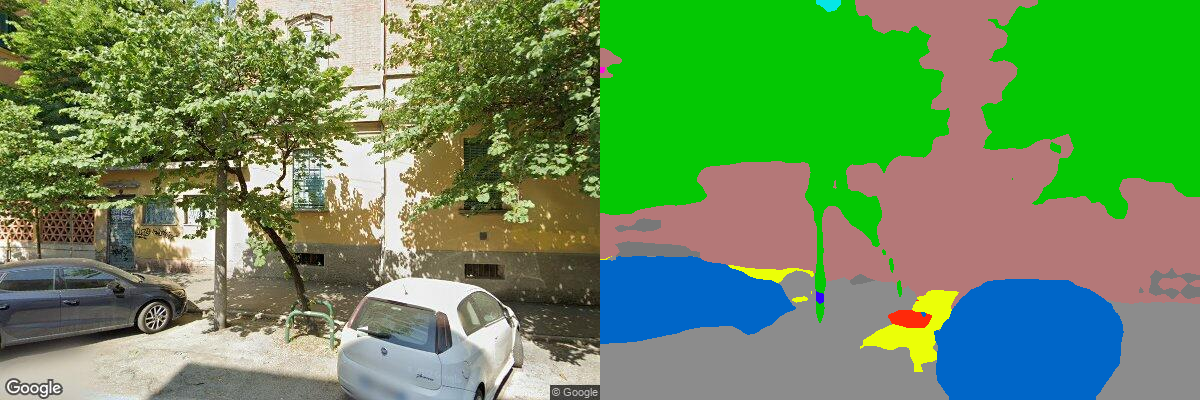

In [27]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)

# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

## Showing classes individually

To see which colors are which, here we visualize individual classes, one at a time.

In [ ]:
# Top classes in answer
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
for c in predicted_classes[:15]:
    visualize_result(img_original, pred, c)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(predicted_classes)

[ 4 20 13  6 52  9 34  2 12 17  0 41 10 18 44 16 15 14 45 46 11 47 40  8
  7 48  5 49  3 50  1 19 43 21 22 39 38 37 36 35 42 33 32 31 30 29 28 27
 51 25 24 23 26]


## Visualizing Results Numerically

While it's useful to show the segmented regions of our image, this is not a visualization strategy that scales well to multiple images. Let's also try showing the proportions of the classes in a bar chart.

In [ ]:
print(pred.shape)

(400, 600)


In [ ]:
# # from collections import Counter

# # get all the names of the classes for which we have predictions
# pred_names = [names[cl+1] for cl in predicted_classes[:15]]

# # create a dictionary of pixel counts by class, and get a list of the top 15 pixel counts
# class_counts = dict(Counter(pred.flatten()))
# pred_class_counts = [class_counts[i] for i in predicted_classes[:15]]

In [ ]:
# import matplotlib.pyplot as plt

# plt.bar(range(len(pred_names)), list(pred_class_counts), align='center')
# plt.xticks(range(len(pred_names)), list(pred_names), rotation='vertical')

# plt.show()

# COLLECTING RESULTS FROM A DATASET

Here we will connect to a folder, segment all the images in it, and record them in a dataframe so that you can visualize the labels you care about!


In [ ]:
import pandas as pd
import folium
import io
from tqdm import tqdm
from collections import Counter

# load PanoIDs from your GSV download
YOUR_PANO_CSV_PATH = "/content/drive/MyDrive/Bologna/panoids/panoid_DF.csv"

panoidDF = pd.read_csv(YOUR_PANO_CSV_PATH)

panoidDF.head()


,Unnamed: 0,date,lat,lon,panoID
0,0,2023-10,44.524154,11.293663,Q_94PAMIyuCL9-QKYNHS9Q
1,1,2023-09,44.524470,11.300727,8teCjXvTL86copc68ypZNg
2,2,2023-09,44.525029,11.307590,9Cpv5GXItkMTb7LvwgM8FA
3,3,2023-09,44.527696,11.314186,ZvVHLi-X0ef6VbT65KDSqw
4,4,2023-09,44.530618,11.320419,QQRGUeHcdx3u8vMC3zS-_w


In [ ]:
len(panoidDF)

2552

In [ ]:
# let's prepare to segment all the images in your folder

# fill in the path to your folder of images to segment
YOUR_IMAGE_FOLDER_PATH = "/content/drive/MyDrive/Bologna/GSV_images"

# fill these in with the labels you care about segmenting
# you can find the numbers associated with each level HERE: https://docs.google.com/spreadsheets/d/1se8YEtb2detS7OuPE86fXGyD269pMycAWe2mtKUj2W8/edit#gid=0
# use the "Idx" column
YOUR_LABELS =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150]
YOUR_PRED_NAMES = []

# add a column to your dataframe for each label you want to segment
for label_idx in YOUR_LABELS:
    label_name = names[label_idx]
    panoidDF[f'{label_name}'] = 0
    YOUR_PRED_NAMES.append(label_name)
panoidDF['visited?'] = 0
panoidDF['quantity'] = 0


<ipython-input-16-5b020ac5eb4f>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  panoidDF[f'{label_name}'] = 0
<ipython-input-16-5b020ac5eb4f>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  panoidDF[f'{label_name}'] = 0
<ipython-input-16-5b020ac5eb4f>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy(

In [ ]:
panoidDF.head()

,Unnamed: 0,date,lat,lon,panoID,wall,building,sky,floor,tree,...,plate,monitor,bulletin,shower,radiator,glass,clock,flag,visited?,quantity
0,0,2023-10,44.524154,11.293663,Q_94PAMIyuCL9-QKYNHS9Q,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2023-09,44.524470,11.300727,8teCjXvTL86copc68ypZNg,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2023-09,44.525029,11.307590,9Cpv5GXItkMTb7LvwgM8FA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2023-09,44.527696,11.314186,ZvVHLi-X0ef6VbT65KDSqw,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2023-09,44.530618,11.320419,QQRGUeHcdx3u8vMC3zS-_w,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# iterate over all the images in the folder
for img_name in tqdm(os.listdir(YOUR_IMAGE_FOLDER_PATH), desc="segmenting images"):

    # Get the full path of an image
    IMG_PATH = os.path.join(YOUR_IMAGE_FOLDER_PATH, img_name)
    image_id, extension = os.path.splitext(img_name)
    image_components = image_id.split('_')
    panoid = image_components[0]
    print('PANOID: ',panoid)
    # heading = image_components[1]

    #this is added newly---------------------------

    if panoid in panoidDF['panoID'].values:
        # Increment quantity by 1
      panoidDF.loc[panoidDF['panoID'] == panoid, 'quantity'] += 1
    else:
        # Add a new row with panoid and quantity set to 1
      new_row = pd.DataFrame({'panoID': [panoid], 'quantity': [1]})
      panoidDF = pd.concat([panoidDF, new_row], ignore_index=True)

    #this is the end of newly added-------------------------

    # define a transform to normalize the image and convert it to a tensor
    pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])

    # set up a singleton batch to pass one image at a time
    pil_image = PIL.Image.open(IMG_PATH).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    # pass through the model to get segmentation scores
    with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()

    # Check for the labels you care about
    class_counts = dict(Counter(pred.flatten()))

    for label_idx in YOUR_LABELS:
      class_idx = label_idx-1
      if class_idx in class_counts:
        panoidDF.loc[panoidDF['panoID'] == panoid, f'{names[label_idx]}'] += class_counts[class_idx]
        panoidDF.loc[panoidDF['panoID'] == panoid, 'visited?'] += 1

len(panoidDF)

segmenting images:   0%|          | 0/10209 [00:00<?, ?it/s]

PANOID:  5gZkhkSHO8NDvXKlTKV3jw


segmenting images:   0%|          | 2/10209 [00:00<33:46,  5.04it/s]

PANOID:  5gZkhkSHO8NDvXKlTKV3jw
PANOID:  v8bnI


segmenting images:   0%|          | 4/10209 [00:00<37:10,  4.57it/s]

PANOID:  AfzjH1c8UT2ER1dRiGV8aQ
PANOID:  AfzjH1c8UT2ER1dRiGV8aQ


segmenting images:   0%|          | 6/10209 [00:01<30:56,  5.50it/s]

PANOID:  5gZkhkSHO8NDvXKlTKV3jw
PANOID:  AfzjH1c8UT2ER1dRiGV8aQ


segmenting images:   0%|          | 8/10209 [00:01<27:42,  6.14it/s]

PANOID:  AfzjH1c8UT2ER1dRiGV8aQ
PANOID:  zhzEGcfgcWkVJt6HfTbq6Q


segmenting images:   0%|          | 10/10209 [00:01<26:20,  6.45it/s]

PANOID:  zhzEGcfgcWkVJt6HfTbq6Q
PANOID:  zhzEGcfgcWkVJt6HfTbq6Q


segmenting images:   0%|          | 12/10209 [00:02<26:10,  6.49it/s]

PANOID:  zhzEGcfgcWkVJt6HfTbq6Q
PANOID:  RJEBCdcPlESO5zfQ2045qw


segmenting images:   0%|          | 14/10209 [00:02<25:41,  6.61it/s]

PANOID:  RJEBCdcPlESO5zfQ2045qw
PANOID:  RJEBCdcPlESO5zfQ2045qw


segmenting images:   0%|          | 16/10209 [00:02<25:21,  6.70it/s]

PANOID:  RJEBCdcPlESO5zfQ2045qw
PANOID:  Mra0Rie7W9df4Q-kjtC3rA


segmenting images:   0%|          | 17/10209 [00:02<24:53,  6.83it/s]

PANOID:  Mra0Rie7W9df4Q-kjtC3rA


segmenting images:   0%|          | 18/10209 [00:03<29:07,  5.83it/s]

PANOID:  Mra0Rie7W9df4Q-kjtC3rA


segmenting images:   0%|          | 19/10209 [00:03<33:38,  5.05it/s]

PANOID:  TMK3JZvz3MyjnJRju0aW6w


segmenting images:   0%|          | 20/10209 [00:03<36:47,  4.62it/s]

PANOID:  Mra0Rie7W9df4Q-kjtC3rA


segmenting images:   0%|          | 21/10209 [00:03<43:41,  3.89it/s]

PANOID:  TMK3JZvz3MyjnJRju0aW6w


segmenting images:   0%|          | 22/10209 [00:04<42:37,  3.98it/s]

PANOID:  TMK3JZvz3MyjnJRju0aW6w


segmenting images:   0%|          | 23/10209 [00:04<43:13,  3.93it/s]

PANOID:  ClV6Fr-R5s0-nceXcmk7Iw


segmenting images:   0%|          | 25/10209 [00:04<40:05,  4.23it/s]

PANOID:  TMK3JZvz3MyjnJRju0aW6w
PANOID:  ClV6Fr-R5s0-nceXcmk7Iw


segmenting images:   0%|          | 27/10209 [00:05<36:18,  4.67it/s]

PANOID:  ClV6Fr-R5s0-nceXcmk7Iw
PANOID:  bNAcYUd0z3D74RLEBAwwKw


segmenting images:   0%|          | 29/10209 [00:05<35:20,  4.80it/s]

PANOID:  bNAcYUd0z3D74RLEBAwwKw
PANOID:  bNAcYUd0z3D74RLEBAwwKw


segmenting images:   0%|          | 31/10209 [00:06<34:12,  4.96it/s]

PANOID:  ClV6Fr-R5s0-nceXcmk7Iw
PANOID:  bNAcYUd0z3D74RLEBAwwKw


segmenting images:   0%|          | 33/10209 [00:06<33:27,  5.07it/s]

PANOID:  GgO6-Y4QIPWVn3t-tN-Cfw
PANOID:  GgO6-Y4QIPWVn3t-tN-Cfw


segmenting images:   0%|          | 34/10209 [00:06<33:37,  5.04it/s]

PANOID:  GgO6-Y4QIPWVn3t-tN-Cfw


segmenting images:   0%|          | 35/10209 [00:06<34:32,  4.91it/s]

PANOID:  N0Q2WS7JVP0KB7bgwxoSuA


segmenting images:   0%|          | 36/10209 [00:07<35:09,  4.82it/s]

PANOID:  GgO6-Y4QIPWVn3t-tN-Cfw


segmenting images:   0%|          | 37/10209 [00:07<36:14,  4.68it/s]

PANOID:  krcTZzCXInFanD0u0Cn6Cg


segmenting images:   0%|          | 39/10209 [00:07<35:27,  4.78it/s]

PANOID:  krcTZzCXInFanD0u0Cn6Cg
PANOID:  N0Q2WS7JVP0KB7bgwxoSuA


segmenting images:   0%|          | 41/10209 [00:08<34:49,  4.87it/s]

PANOID:  N0Q2WS7JVP0KB7bgwxoSuA
PANOID:  N0Q2WS7JVP0KB7bgwxoSuA


segmenting images:   0%|          | 42/10209 [00:08<35:23,  4.79it/s]

PANOID:  TTZ-jXupBzOuCAFgdWmqSw


segmenting images:   0%|          | 43/10209 [00:08<36:25,  4.65it/s]

PANOID:  TTZ-jXupBzOuCAFgdWmqSw


segmenting images:   0%|          | 45/10209 [00:08<35:05,  4.83it/s]

PANOID:  krcTZzCXInFanD0u0Cn6Cg
PANOID:  krcTZzCXInFanD0u0Cn6Cg


segmenting images:   0%|          | 47/10209 [00:09<30:06,  5.63it/s]

PANOID:  2LV5KrVEHSs2egQ5M-QpdA
PANOID:  2LV5KrVEHSs2egQ5M-QpdA


segmenting images:   0%|          | 49/10209 [00:09<27:50,  6.08it/s]

PANOID:  TTZ-jXupBzOuCAFgdWmqSw
PANOID:  2LV5KrVEHSs2egQ5M-QpdA


segmenting images:   0%|          | 51/10209 [00:09<25:35,  6.62it/s]

PANOID:  TTZ-jXupBzOuCAFgdWmqSw
PANOID:  2LV5KrVEHSs2egQ5M-QpdA


segmenting images:   1%|          | 53/10209 [00:10<24:09,  7.01it/s]

PANOID:  HNoleeUtN36mG4IRfIpsUg
PANOID:  HNoleeUtN36mG4IRfIpsUg


segmenting images:   1%|          | 55/10209 [00:10<23:53,  7.09it/s]

PANOID:  HNoleeUtN36mG4IRfIpsUg
PANOID:  HNoleeUtN36mG4IRfIpsUg


segmenting images:   1%|          | 57/10209 [00:10<24:15,  6.98it/s]

PANOID:  MUDPbv0Uam0NYapjS8PxwA
PANOID:  MUDPbv0Uam0NYapjS8PxwA


segmenting images:   1%|          | 59/10209 [00:10<24:00,  7.05it/s]

PANOID:  MUDPbv0Uam0NYapjS8PxwA
PANOID:  MUDPbv0Uam0NYapjS8PxwA


segmenting images:   1%|          | 61/10209 [00:11<24:13,  6.98it/s]

PANOID:  Nxv19HfQCVECs2uMUIqLwA
PANOID:  Nxv19HfQCVECs2uMUIqLwA


segmenting images:   1%|          | 63/10209 [00:11<24:45,  6.83it/s]

PANOID:  Nxv19HfQCVECs2uMUIqLwA
PANOID:  Nxv19HfQCVECs2uMUIqLwA


segmenting images:   1%|          | 65/10209 [00:11<24:38,  6.86it/s]

PANOID:  6Mhfz8XA4ARZRtFa3DEPVg
PANOID:  6Mhfz8XA4ARZRtFa3DEPVg


segmenting images:   1%|          | 67/10209 [00:12<25:19,  6.67it/s]

PANOID:  6Mhfz8XA4ARZRtFa3DEPVg
PANOID:  i0Nmn0WK


segmenting images:   1%|          | 69/10209 [00:12<24:52,  6.79it/s]

PANOID:  i0Nmn0WK
PANOID:  i0Nmn0WK


segmenting images:   1%|          | 71/10209 [00:12<25:50,  6.54it/s]

PANOID:  6Mhfz8XA4ARZRtFa3DEPVg
PANOID:  i0Nmn0WK


segmenting images:   1%|          | 73/10209 [00:13<25:36,  6.60it/s]

PANOID:  dpFy4RdFZacyAuhJcCcZWw
PANOID:  dpFy4RdFZacyAuhJcCcZWw


segmenting images:   1%|          | 75/10209 [00:13<25:30,  6.62it/s]

PANOID:  dpFy4RdFZacyAuhJcCcZWw
PANOID:  dpFy4RdFZacyAuhJcCcZWw


segmenting images:   1%|          | 77/10209 [00:13<25:46,  6.55it/s]

PANOID:  L96j
PANOID:  L96j


segmenting images:   1%|          | 79/10209 [00:13<24:18,  6.95it/s]

PANOID:  vXJvZ2LjS2YmRvlrGf2W2w
PANOID:  L96j


segmenting images:   1%|          | 81/10209 [00:14<24:49,  6.80it/s]

PANOID:  L96j
PANOID:  EeyvvpT7x39Bs28jnKwoQQ


segmenting images:   1%|          | 83/10209 [00:14<26:45,  6.31it/s]

PANOID:  vXJvZ2LjS2YmRvlrGf2W2w
PANOID:  vXJvZ2LjS2YmRvlrGf2W2w


segmenting images:   1%|          | 85/10209 [00:14<25:34,  6.60it/s]

PANOID:  vXJvZ2LjS2YmRvlrGf2W2w
PANOID:  EeyvvpT7x39Bs28jnKwoQQ


segmenting images:   1%|          | 87/10209 [00:15<25:59,  6.49it/s]

PANOID:  EeyvvpT7x39Bs28jnKwoQQ
PANOID:  QH4SfMINfdHX4ZudrQAFGw


segmenting images:   1%|          | 89/10209 [00:15<25:28,  6.62it/s]

PANOID:  EeyvvpT7x39Bs28jnKwoQQ
PANOID:  QH4SfMINfdHX4ZudrQAFGw


segmenting images:   1%|          | 91/10209 [00:15<25:14,  6.68it/s]

PANOID:  QH4SfMINfdHX4ZudrQAFGw
PANOID:  QH4SfMINfdHX4ZudrQAFGw


segmenting images:   1%|          | 93/10209 [00:16<25:30,  6.61it/s]

PANOID:  krjdPyGRYV9ZO0t7vpE
PANOID:  krjdPyGRYV9ZO0t7vpE


segmenting images:   1%|          | 95/10209 [00:16<24:59,  6.75it/s]

PANOID:  krjdPyGRYV9ZO0t7vpE
PANOID:  Vp1Z35rVTk-x8yKBOhECng


segmenting images:   1%|          | 97/10209 [00:16<26:08,  6.45it/s]

PANOID:  krjdPyGRYV9ZO0t7vpE
PANOID:  Vp1Z35rVTk-x8yKBOhECng


segmenting images:   1%|          | 99/10209 [00:17<26:09,  6.44it/s]

PANOID:  Vp1Z35rVTk-x8yKBOhECng
PANOID:  1G7P-2WlIiELQpodREJmaw


segmenting images:   1%|          | 101/10209 [00:17<24:49,  6.79it/s]

PANOID:  1G7P-2WlIiELQpodREJmaw
PANOID:  1G7P-2WlIiELQpodREJmaw


segmenting images:   1%|          | 102/10209 [00:17<24:28,  6.88it/s]

PANOID:  1G7P-2WlIiELQpodREJmaw


segmenting images:   1%|          | 103/10209 [00:17<27:51,  6.05it/s]

PANOID:  Vp1Z35rVTk-x8yKBOhECng


segmenting images:   1%|          | 104/10209 [00:50<27:49:48,  9.91s/it]

PANOID:  c4AkwaWhRjHqAAB89Flpog


segmenting images:   1%|          | 105/10209 [02:05<82:36:59, 29.44s/it]

PANOID:  c4AkwaWhRjHqAAB89Flpog


segmenting images:   1%|          | 107/10209 [02:10<43:42:16, 15.57s/it]

PANOID:  c4AkwaWhRjHqAAB89Flpog
PANOID:  c4AkwaWhRjHqAAB89Flpog


segmenting images:   1%|          | 109/10209 [02:10<21:37:24,  7.71s/it]

PANOID:  CAoSLEFGMVFpcFA0d1RrSXU0Wm92R25Db1pHdUxLMng0Tm9RWkhodmFIYlVxNUdV
PANOID:  CAoSLEFGMVFpcFA0d1RrSXU0Wm92R25Db1pHdUxLMng0Tm9RWkhodmFIYlVxNUdV


segmenting images:   1%|          | 111/10209 [02:11<10:48:41,  3.85s/it]

PANOID:  CAoSLEFGMVFpcFA0d1RrSXU0Wm92R25Db1pHdUxLMng0Tm9RWkhodmFIYlVxNUdV
PANOID:  CAoSLEFGMVFpcFA0d1RrSXU0Wm92R25Db1pHdUxLMng0Tm9RWkhodmFIYlVxNUdV


segmenting images:   1%|          | 113/10209 [02:11<5:30:59,  1.97s/it]

PANOID:  uGtTyqfenZjGEQjnloSQiQ
PANOID:  uGtTyqfenZjGEQjnloSQiQ


segmenting images:   1%|          | 115/10209 [02:11<2:55:43,  1.04s/it]

PANOID:  GU
PANOID:  uGtTyqfenZjGEQjnloSQiQ


segmenting images:   1%|          | 117/10209 [02:12<1:39:24,  1.69it/s]

PANOID:  uGtTyqfenZjGEQjnloSQiQ
PANOID:  GU


segmenting images:   1%|          | 119/10209 [02:12<1:03:32,  2.65it/s]

PANOID:  GU
PANOID:  do-QiruE-KNRdA-sQ2sT


segmenting images:   1%|          | 121/10209 [02:12<44:24,  3.79it/s]

PANOID:  GU
PANOID:  PssIhMfhgeOdPTMd0-g4AA


segmenting images:   1%|          | 123/10209 [02:13<36:15,  4.64it/s]

PANOID:  do-QiruE-KNRdA-sQ2sT
PANOID:  do-QiruE-KNRdA-sQ2sT


segmenting images:   1%|          | 125/10209 [02:13<30:48,  5.45it/s]

PANOID:  do-QiruE-KNRdA-sQ2sT
PANOID:  PssIhMfhgeOdPTMd0-g4AA


segmenting images:   1%|          | 127/10209 [02:13<27:59,  6.00it/s]

PANOID:  QpmziiAXQeO1qejPBcnchA
PANOID:  PssIhMfhgeOdPTMd0-g4AA


segmenting images:   1%|▏         | 129/10209 [02:14<25:58,  6.47it/s]

PANOID:  PssIhMfhgeOdPTMd0-g4AA
PANOID:  QpmziiAXQeO1qejPBcnchA


segmenting images:   1%|▏         | 131/10209 [02:14<26:34,  6.32it/s]

PANOID:  XkYwFOFReGkgoB
PANOID:  QpmziiAXQeO1qejPBcnchA


segmenting images:   1%|▏         | 133/10209 [02:14<25:41,  6.54it/s]

PANOID:  QpmziiAXQeO1qejPBcnchA
PANOID:  XkYwFOFReGkgoB


segmenting images:   1%|▏         | 135/10209 [02:15<24:55,  6.73it/s]

PANOID:  gcqe6a0Z4mbA4iLkuRK7kw
PANOID:  XkYwFOFReGkgoB


segmenting images:   1%|▏         | 137/10209 [02:15<25:12,  6.66it/s]

PANOID:  gcqe6a0Z4mbA4iLkuRK7kw
PANOID:  XkYwFOFReGkgoB


segmenting images:   1%|▏         | 139/10209 [02:15<25:04,  6.70it/s]

PANOID:  H5-ensH8itesuhOiqg6zpQ
PANOID:  gcqe6a0Z4mbA4iLkuRK7kw


segmenting images:   1%|▏         | 141/10209 [02:15<25:26,  6.60it/s]

PANOID:  H5-ensH8itesuhOiqg6zpQ
PANOID:  H5-ensH8itesuhOiqg6zpQ


segmenting images:   1%|▏         | 143/10209 [02:16<25:52,  6.48it/s]

PANOID:  gcqe6a0Z4mbA4iLkuRK7kw
PANOID:  Hmg2H7bIekQq0sNWycJvpQ


segmenting images:   1%|▏         | 145/10209 [02:16<25:25,  6.60it/s]

PANOID:  Hmg2H7bIekQq0sNWycJvpQ
PANOID:  Hmg2H7bIekQq0sNWycJvpQ


segmenting images:   1%|▏         | 147/10209 [02:16<25:27,  6.59it/s]

PANOID:  H5-ensH8itesuhOiqg6zpQ
PANOID:  lPvAoABr


segmenting images:   1%|▏         | 149/10209 [02:17<25:45,  6.51it/s]

PANOID:  lPvAoABr
PANOID:  lPvAoABr


segmenting images:   1%|▏         | 151/10209 [02:17<27:03,  6.20it/s]

PANOID:  Hmg2H7bIekQq0sNWycJvpQ
PANOID:  lPvAoABr


segmenting images:   1%|▏         | 153/10209 [02:17<26:31,  6.32it/s]

PANOID:  lVcSSE1WmEqnASRI4X6zdw
PANOID:  lVcSSE1WmEqnASRI4X6zdw


segmenting images:   2%|▏         | 155/10209 [02:18<26:30,  6.32it/s]

PANOID:  lVcSSE1WmEqnASRI4X6zdw
PANOID:  pG2B19COVzz8e1dyj637GA


segmenting images:   2%|▏         | 157/10209 [02:18<26:35,  6.30it/s]

PANOID:  lVcSSE1WmEqnASRI4X6zdw
PANOID:  pG2B19COVzz8e1dyj637GA


segmenting images:   2%|▏         | 158/10209 [02:18<28:27,  5.89it/s]

PANOID:  pG2B19COVzz8e1dyj637GA


segmenting images:   2%|▏         | 159/10209 [02:18<30:26,  5.50it/s]

PANOID:  ZfqQUp9lQUl7YpmuvgAmmg


segmenting images:   2%|▏         | 161/10209 [02:19<32:09,  5.21it/s]

PANOID:  ZfqQUp9lQUl7YpmuvgAmmg
PANOID:  pG2B19COVzz8e1dyj637GA


segmenting images:   2%|▏         | 163/10209 [02:19<33:36,  4.98it/s]

PANOID:  lF8rGhqOKIfddariE5waSw
PANOID:  ZfqQUp9lQUl7YpmuvgAmmg


segmenting images:   2%|▏         | 164/10209 [02:19<34:05,  4.91it/s]

PANOID:  lF8rGhqOKIfddariE5waSw


segmenting images:   2%|▏         | 165/10209 [02:20<34:31,  4.85it/s]

PANOID:  ZfqQUp9lQUl7YpmuvgAmmg


segmenting images:   2%|▏         | 166/10209 [02:20<35:20,  4.74it/s]

PANOID:  36rcfNbMnpjwY-sDpLVf


segmenting images:   2%|▏         | 167/10209 [02:20<36:33,  4.58it/s]

PANOID:  lF8rGhqOKIfddariE5waSw


segmenting images:   2%|▏         | 168/10209 [02:20<36:23,  4.60it/s]

PANOID:  36rcfNbMnpjwY-sDpLVf


segmenting images:   2%|▏         | 169/10209 [02:20<35:58,  4.65it/s]

PANOID:  lF8rGhqOKIfddariE5waSw


segmenting images:   2%|▏         | 170/10209 [02:21<35:53,  4.66it/s]

PANOID:  36rcfNbMnpjwY-sDpLVf


segmenting images:   2%|▏         | 171/10209 [02:21<36:07,  4.63it/s]

PANOID:  36rcfNbMnpjwY-sDpLVf


segmenting images:   2%|▏         | 172/10209 [02:21<36:08,  4.63it/s]

PANOID:  gK9zrBU0ZvWzMTU870TSPw


segmenting images:   2%|▏         | 173/10209 [02:21<35:58,  4.65it/s]

PANOID:  gK9zrBU0ZvWzMTU870TSPw


segmenting images:   2%|▏         | 175/10209 [02:22<35:09,  4.76it/s]

PANOID:  gK9zrBU0ZvWzMTU870TSPw
PANOID:  gK9zrBU0ZvWzMTU870TSPw


segmenting images:   2%|▏         | 177/10209 [02:22<32:02,  5.22it/s]

PANOID:  8yKAcCoDLrkM9AReYE2g-Q
PANOID:  8yKAcCoDLrkM9AReYE2g-Q


segmenting images:   2%|▏         | 179/10209 [02:22<29:14,  5.72it/s]

PANOID:  8yKAcCoDLrkM9AReYE2g-Q
PANOID:  8yKAcCoDLrkM9AReYE2g-Q


segmenting images:   2%|▏         | 181/10209 [02:23<27:01,  6.19it/s]

PANOID:  pTvqU0zu4f
PANOID:  pTvqU0zu4f


segmenting images:   2%|▏         | 183/10209 [02:23<26:08,  6.39it/s]

PANOID:  pTvqU0zu4f
PANOID:  pTvqU0zu4f


segmenting images:   2%|▏         | 185/10209 [02:23<26:12,  6.37it/s]

PANOID:  YmeZhBkSCT4i9VxmPtDW
PANOID:  YmeZhBkSCT4i9VxmPtDW


segmenting images:   2%|▏         | 187/10209 [02:24<25:18,  6.60it/s]

PANOID:  YmeZhBkSCT4i9VxmPtDW
PANOID:  m8KcQPIwd1zwgRNzAZ3c8Q


segmenting images:   2%|▏         | 189/10209 [02:24<26:06,  6.40it/s]

PANOID:  m8KcQPIwd1zwgRNzAZ3c8Q
PANOID:  m8KcQPIwd1zwgRNzAZ3c8Q


segmenting images:   2%|▏         | 191/10209 [02:24<27:16,  6.12it/s]

PANOID:  YmeZhBkSCT4i9VxmPtDW
PANOID:  IkLeOUNUYgqp


segmenting images:   2%|▏         | 193/10209 [02:25<26:27,  6.31it/s]

PANOID:  IkLeOUNUYgqp
PANOID:  IkLeOUNUYgqp


segmenting images:   2%|▏         | 195/10209 [02:25<26:13,  6.37it/s]

PANOID:  m8KcQPIwd1zwgRNzAZ3c8Q
PANOID:  8In3s


segmenting images:   2%|▏         | 197/10209 [02:25<26:42,  6.25it/s]

PANOID:  8In3s
PANOID:  8In3s


segmenting images:   2%|▏         | 199/10209 [02:26<26:35,  6.27it/s]

PANOID:  IkLeOUNUYgqp
PANOID:  8In3s


segmenting images:   2%|▏         | 201/10209 [02:26<27:15,  6.12it/s]

PANOID:  KB9MQr6bmyMTsD
PANOID:  KB9MQr6bmyMTsD


segmenting images:   2%|▏         | 203/10209 [02:26<26:52,  6.20it/s]

PANOID:  KB9MQr6bmyMTsD
PANOID:  KB9MQr6bmyMTsD


segmenting images:   2%|▏         | 205/10209 [02:27<26:24,  6.31it/s]

PANOID:  N53H0Mv5KMtdku1-CUliEA
PANOID:  NkR8o21c23Oe0Ac1gUFkfA


segmenting images:   2%|▏         | 207/10209 [02:27<26:43,  6.24it/s]

PANOID:  N53H0Mv5KMtdku1-CUliEA
PANOID:  N53H0Mv5KMtdku1-CUliEA


segmenting images:   2%|▏         | 209/10209 [02:27<25:33,  6.52it/s]

PANOID:  N53H0Mv5KMtdku1-CUliEA
PANOID:  NkR8o21c23Oe0Ac1gUFkfA


segmenting images:   2%|▏         | 211/10209 [02:27<25:49,  6.45it/s]

PANOID:  NkR8o21c23Oe0Ac1gUFkfA
PANOID:  NkR8o21c23Oe0Ac1gUFkfA


segmenting images:   2%|▏         | 213/10209 [02:28<25:34,  6.51it/s]

PANOID:  n7HZ45gLlmHpOL
PANOID:  n7HZ45gLlmHpOL


segmenting images:   2%|▏         | 215/10209 [02:28<25:29,  6.53it/s]

PANOID:  n7HZ45gLlmHpOL
PANOID:  n7HZ45gLlmHpOL


segmenting images:   2%|▏         | 217/10209 [02:28<26:25,  6.30it/s]

PANOID:  gNlH-vHGe4eBVI2UrX5oxg
PANOID:  gNlH-vHGe4eBVI2UrX5oxg


segmenting images:   2%|▏         | 219/10209 [02:29<26:03,  6.39it/s]

PANOID:  gNlH-vHGe4eBVI2UrX5oxg
PANOID:  x


segmenting images:   2%|▏         | 221/10209 [02:29<26:24,  6.30it/s]

PANOID:  gNlH-vHGe4eBVI2UrX5oxg
PANOID:  x


segmenting images:   2%|▏         | 223/10209 [02:29<25:48,  6.45it/s]

PANOID:  x
PANOID:  TPLn9seZvkmK0vgM3RO5mA


segmenting images:   2%|▏         | 225/10209 [02:30<25:06,  6.63it/s]

PANOID:  x
PANOID:  TPLn9seZvkmK0vgM3RO5mA


segmenting images:   2%|▏         | 227/10209 [02:30<25:14,  6.59it/s]

PANOID:  TPLn9seZvkmK0vgM3RO5mA
PANOID:  TPLn9seZvkmK0vgM3RO5mA


segmenting images:   2%|▏         | 229/10209 [02:30<27:23,  6.07it/s]

PANOID:  v2tTxzRK1Lun65
PANOID:  v2tTxzRK1Lun65


segmenting images:   2%|▏         | 231/10209 [02:31<26:25,  6.29it/s]

PANOID:  v2tTxzRK1Lun65
PANOID:  v2tTxzRK1Lun65


segmenting images:   2%|▏         | 233/10209 [02:31<26:09,  6.36it/s]

PANOID:  WHqGmBB6NcJ1lJh0Hdxx0Q
PANOID:  WHqGmBB6NcJ1lJh0Hdxx0Q


segmenting images:   2%|▏         | 235/10209 [02:31<25:31,  6.51it/s]

PANOID:  WHqGmBB6NcJ1lJh0Hdxx0Q
PANOID:  ARqC3D528icJ8tiRpz1rug


segmenting images:   2%|▏         | 237/10209 [02:31<25:29,  6.52it/s]

PANOID:  ARqC3D528icJ8tiRpz1rug
PANOID:  ARqC3D528icJ8tiRpz1rug


segmenting images:   2%|▏         | 239/10209 [02:32<26:00,  6.39it/s]

PANOID:  ARqC3D528icJ8tiRpz1rug
PANOID:  WHqGmBB6NcJ1lJh0Hdxx0Q


segmenting images:   2%|▏         | 241/10209 [02:32<29:25,  5.64it/s]

PANOID:  K0r9T9GQjK0GKZOw0pKEKA
PANOID:  K0r9T9GQjK0GKZOw0pKEKA


segmenting images:   2%|▏         | 242/10209 [02:32<31:12,  5.32it/s]

PANOID:  K0r9T9GQjK0GKZOw0pKEKA


segmenting images:   2%|▏         | 243/10209 [02:33<32:03,  5.18it/s]

PANOID:  K0r9T9GQjK0GKZOw0pKEKA


segmenting images:   2%|▏         | 245/10209 [02:33<32:48,  5.06it/s]

PANOID:  IzWOqaND6XE8JlmG8gVblQ
PANOID:  IzWOqaND6XE8JlmG8gVblQ


segmenting images:   2%|▏         | 247/10209 [02:33<32:26,  5.12it/s]

PANOID:  IzWOqaND6XE8JlmG8gVblQ
PANOID:  IzWOqaND6XE8JlmG8gVblQ


segmenting images:   2%|▏         | 249/10209 [02:34<32:50,  5.05it/s]

PANOID:  vj4naMRn86H4CXEwWVj-xA
PANOID:  vj4naMRn86H4CXEwWVj-xA


segmenting images:   2%|▏         | 250/10209 [02:34<33:59,  4.88it/s]

PANOID:  vj4naMRn86H4CXEwWVj-xA


segmenting images:   2%|▏         | 251/10209 [02:34<34:17,  4.84it/s]

PANOID:  vj4naMRn86H4CXEwWVj-xA


segmenting images:   2%|▏         | 253/10209 [02:35<34:20,  4.83it/s]

PANOID:  jAOvaobceJrSlBQqLFdUWg
PANOID:  jAOvaobceJrSlBQqLFdUWg


segmenting images:   2%|▏         | 255/10209 [02:35<33:21,  4.97it/s]

PANOID:  jAOvaobceJrSlBQqLFdUWg
PANOID:  CE5s3e4pUaWdNUTgnmL1WQ


segmenting images:   3%|▎         | 256/10209 [02:35<34:06,  4.86it/s]

PANOID:  CE5s3e4pUaWdNUTgnmL1WQ


segmenting images:   3%|▎         | 257/10209 [02:36<34:57,  4.74it/s]

PANOID:  jAOvaobceJrSlBQqLFdUWg


segmenting images:   3%|▎         | 259/10209 [02:36<32:48,  5.06it/s]

PANOID:  CE5s3e4pUaWdNUTgnmL1WQ
PANOID:  CE5s3e4pUaWdNUTgnmL1WQ


segmenting images:   3%|▎         | 261/10209 [02:36<28:43,  5.77it/s]

PANOID:  XJf-NIg0boiFwZ9T8uDu5A
PANOID:  XJf-NIg0boiFwZ9T8uDu5A


segmenting images:   3%|▎         | 263/10209 [02:37<27:41,  5.99it/s]

PANOID:  XJf-NIg0boiFwZ9T8uDu5A
PANOID:  2II2zP55foreV8uveFDaqA


segmenting images:   3%|▎         | 265/10209 [02:37<26:14,  6.32it/s]

PANOID:  2II2zP55foreV8uveFDaqA
PANOID:  2II2zP55foreV8uveFDaqA


segmenting images:   3%|▎         | 267/10209 [02:37<25:21,  6.53it/s]

PANOID:  XJf-NIg0boiFwZ9T8uDu5A
PANOID:  2II2zP55foreV8uveFDaqA


segmenting images:   3%|▎         | 269/10209 [02:37<25:46,  6.43it/s]

PANOID:  5o
PANOID:  5o


segmenting images:   3%|▎         | 271/10209 [02:38<26:01,  6.37it/s]

PANOID:  5o
PANOID:  5o


segmenting images:   3%|▎         | 273/10209 [02:38<25:12,  6.57it/s]

PANOID:  ysurOJRGd5LL5FnHxVvkHA
PANOID:  ysurOJRGd5LL5FnHxVvkHA


segmenting images:   3%|▎         | 275/10209 [02:38<24:45,  6.69it/s]

PANOID:  ysurOJRGd5LL5FnHxVvkHA
PANOID:  jA8r7S3MAsmjKwnjSG5p0Q


segmenting images:   3%|▎         | 277/10209 [02:39<26:01,  6.36it/s]

PANOID:  jA8r7S3MAsmjKwnjSG5p0Q
PANOID:  ysurOJRGd5LL5FnHxVvkHA


segmenting images:   3%|▎         | 279/10209 [02:39<25:59,  6.37it/s]

PANOID:  WsxeZLub827LBumE
PANOID:  WsxeZLub827LBumE


segmenting images:   3%|▎         | 281/10209 [02:39<25:27,  6.50it/s]

PANOID:  WsxeZLub827LBumE
PANOID:  jA8r7S3MAsmjKwnjSG5p0Q


segmenting images:   3%|▎         | 283/10209 [02:40<25:03,  6.60it/s]

PANOID:  jA8r7S3MAsmjKwnjSG5p0Q
PANOID:  P2JRocGrFo7A3ErG


segmenting images:   3%|▎         | 285/10209 [02:40<25:30,  6.48it/s]

PANOID:  P2JRocGrFo7A3ErG
PANOID:  P2JRocGrFo7A3ErG


segmenting images:   3%|▎         | 287/10209 [02:40<26:07,  6.33it/s]

PANOID:  P2JRocGrFo7A3ErG
PANOID:  WsxeZLub827LBumE


segmenting images:   3%|▎         | 289/10209 [02:41<28:57,  5.71it/s]

PANOID:  s2rYrBx6SPq825jhRJeMIg
PANOID:  s2rYrBx6SPq825jhRJeMIg


segmenting images:   3%|▎         | 290/10209 [02:41<30:44,  5.38it/s]

PANOID:  s2rYrBx6SPq825jhRJeMIg


segmenting images:   3%|▎         | 291/10209 [02:41<32:40,  5.06it/s]

PANOID:  s2rYrBx6SPq825jhRJeMIg


segmenting images:   3%|▎         | 292/10209 [02:41<34:51,  4.74it/s]

PANOID:  psOGLeEnEik425BLyJ6i1g


segmenting images:   3%|▎         | 293/10209 [02:41<34:51,  4.74it/s]

PANOID:  9xi4tjaNuY9yn7XMvV4HWQ


segmenting images:   3%|▎         | 295/10209 [02:42<34:13,  4.83it/s]

PANOID:  9xi4tjaNuY9yn7XMvV4HWQ


segmenting images:   3%|▎         | 296/10209 [02:42<33:34,  4.92it/s]

PANOID:  9xi4tjaNuY9yn7XMvV4HWQ
PANOID:  psOGLeEnEik425BLyJ6i1g


segmenting images:   3%|▎         | 297/10209 [02:42<33:22,  4.95it/s]

PANOID:  9xi4tjaNuY9yn7XMvV4HWQ


segmenting images:   3%|▎         | 298/10209 [02:42<33:51,  4.88it/s]

PANOID:  XZyMA2Yjy8DC5S8e


segmenting images:   3%|▎         | 299/10209 [02:43<35:16,  4.68it/s]

PANOID:  XZyMA2Yjy8DC5S8e


segmenting images:   3%|▎         | 300/10209 [02:43<35:29,  4.65it/s]

PANOID:  psOGLeEnEik425BLyJ6i1g


segmenting images:   3%|▎         | 302/10209 [02:43<34:17,  4.81it/s]

PANOID:  psOGLeEnEik425BLyJ6i1g
PANOID:  XZyMA2Yjy8DC5S8e


segmenting images:   3%|▎         | 303/10209 [02:44<33:36,  4.91it/s]

PANOID:  7IGM


segmenting images:   3%|▎         | 305/10209 [02:44<33:54,  4.87it/s]

PANOID:  7IGM
PANOID:  XZyMA2Yjy8DC5S8e


segmenting images:   3%|▎         | 307/10209 [02:44<32:05,  5.14it/s]

PANOID:  7IGM
PANOID:  7IGM


segmenting images:   3%|▎         | 309/10209 [02:45<29:02,  5.68it/s]

PANOID:  4VDxees
PANOID:  4VDxees


segmenting images:   3%|▎         | 311/10209 [02:45<26:46,  6.16it/s]

PANOID:  4VDxees
PANOID:  4VDxees


segmenting images:   3%|▎         | 313/10209 [02:45<25:36,  6.44it/s]

PANOID:  ylw47XsnthJ-BZM-5fkLbw
PANOID:  ylw47XsnthJ-BZM-5fkLbw


segmenting images:   3%|▎         | 315/10209 [02:46<24:56,  6.61it/s]

PANOID:  ylw47XsnthJ-BZM-5fkLbw
PANOID:  ylw47XsnthJ-BZM-5fkLbw


segmenting images:   3%|▎         | 317/10209 [02:46<25:09,  6.55it/s]

PANOID:  CyTA6QRTESD4mX-5asXveA
PANOID:  CyTA6QRTESD4mX-5asXveA


segmenting images:   3%|▎         | 319/10209 [02:46<29:02,  5.68it/s]

PANOID:  CyTA6QRTESD4mX-5asXveA
PANOID:  OyZ


segmenting images:   3%|▎         | 321/10209 [02:47<31:27,  5.24it/s]

PANOID:  OyZ
PANOID:  OyZ


segmenting images:   3%|▎         | 323/10209 [02:47<32:06,  5.13it/s]

PANOID:  CyTA6QRTESD4mX-5asXveA
PANOID:  OyZ


segmenting images:   3%|▎         | 324/10209 [02:47<32:29,  5.07it/s]

PANOID:  Iw479FWQE


segmenting images:   3%|▎         | 326/10209 [02:48<33:26,  4.93it/s]

PANOID:  Iw479FWQE


segmenting images:   3%|▎         | 327/10209 [02:48<33:30,  4.91it/s]

PANOID:  Iw479FWQE
PANOID:  Iw479FWQE


segmenting images:   3%|▎         | 328/10209 [02:48<33:57,  4.85it/s]

PANOID:  5RDqS73PSFEp9uSeKstdXA


segmenting images:   3%|▎         | 329/10209 [02:48<34:33,  4.77it/s]

PANOID:  5RDqS73PSFEp9uSeKstdXA


segmenting images:   3%|▎         | 330/10209 [02:49<34:39,  4.75it/s]

PANOID:  5RDqS73PSFEp9uSeKstdXA


segmenting images:   3%|▎         | 331/10209 [02:49<34:21,  4.79it/s]

PANOID:  5RDqS73PSFEp9uSeKstdXA


segmenting images:   3%|▎         | 333/10209 [02:49<34:01,  4.84it/s]

PANOID:  41PJWCAloSjkjdex68vyMQ
PANOID:  41PJWCAloSjkjdex68vyMQ


segmenting images:   3%|▎         | 335/10209 [02:50<34:28,  4.77it/s]

PANOID:  41PJWCAloSjkjdex68vyMQ
PANOID:  41PJWCAloSjkjdex68vyMQ


segmenting images:   3%|▎         | 337/10209 [02:50<32:18,  5.09it/s]

PANOID:  IYbtcP
PANOID:  IYbtcP


segmenting images:   3%|▎         | 339/10209 [02:50<28:44,  5.72it/s]

PANOID:  IYbtcP
PANOID:  IYbtcP


segmenting images:   3%|▎         | 341/10209 [02:51<26:18,  6.25it/s]

PANOID:  KSo8r7N1XFvnXyA8C2Ki4A
PANOID:  KSo8r7N1XFvnXyA8C2Ki4A


segmenting images:   3%|▎         | 343/10209 [02:51<25:34,  6.43it/s]

PANOID:  KSo8r7N1XFvnXyA8C2Ki4A
PANOID:  XcHBqi94Jm4MDo5cD99x3A


segmenting images:   3%|▎         | 345/10209 [02:51<24:38,  6.67it/s]

PANOID:  XcHBqi94Jm4MDo5cD99x3A
PANOID:  KSo8r7N1XFvnXyA8C2Ki4A


segmenting images:   3%|▎         | 347/10209 [02:51<24:21,  6.75it/s]

PANOID:  XcHBqi94Jm4MDo5cD99x3A
PANOID:  XcHBqi94Jm4MDo5cD99x3A


segmenting images:   3%|▎         | 349/10209 [02:52<23:46,  6.91it/s]

PANOID:  Q9dR7-2g3GlLKRnvp-BftA
PANOID:  Q9dR7-2g3GlLKRnvp-BftA


segmenting images:   3%|▎         | 351/10209 [02:52<24:18,  6.76it/s]

PANOID:  Q9dR7-2g3GlLKRnvp-BftA
PANOID:  Q9dR7-2g3GlLKRnvp-BftA


segmenting images:   3%|▎         | 353/10209 [02:52<24:17,  6.76it/s]

PANOID:  S93yO0FrUctADkaZgKXeHg
PANOID:  S93yO0FrUctADkaZgKXeHg


segmenting images:   3%|▎         | 355/10209 [02:53<24:06,  6.81it/s]

PANOID:  S93yO0FrUctADkaZgKXeHg
PANOID:  H8i3pA6NABpRAeO7PRtzvA


segmenting images:   3%|▎         | 357/10209 [02:53<23:57,  6.85it/s]

PANOID:  S93yO0FrUctADkaZgKXeHg
PANOID:  H8i3pA6NABpRAeO7PRtzvA


segmenting images:   4%|▎         | 359/10209 [02:53<25:14,  6.50it/s]

PANOID:  zNJsEruFAB20dfDXfU92bQ
PANOID:  H8i3pA6NABpRAeO7PRtzvA


segmenting images:   4%|▎         | 361/10209 [02:54<24:44,  6.63it/s]

PANOID:  H8i3pA6NABpRAeO7PRtzvA
PANOID:  zNJsEruFAB20dfDXfU92bQ


segmenting images:   4%|▎         | 363/10209 [02:54<24:05,  6.81it/s]

PANOID:  zNJsEruFAB20dfDXfU92bQ
PANOID:  vvOmFWeTJ35K5EosWIGoFg


segmenting images:   4%|▎         | 365/10209 [02:54<23:53,  6.87it/s]

PANOID:  vvOmFWeTJ35K5EosWIGoFg
PANOID:  vvOmFWeTJ35K5EosWIGoFg


segmenting images:   4%|▎         | 367/10209 [02:54<23:45,  6.90it/s]

PANOID:  vvOmFWeTJ35K5EosWIGoFg
PANOID:  zNJsEruFAB20dfDXfU92bQ


segmenting images:   4%|▎         | 369/10209 [02:55<23:25,  7.00it/s]

PANOID:  gODKVfEc7GsdZarpiL8LDw
PANOID:  gODKVfEc7GsdZarpiL8LDw


segmenting images:   4%|▎         | 371/10209 [02:55<24:00,  6.83it/s]

PANOID:  gODKVfEc7GsdZarpiL8LDw
PANOID:  gODKVfEc7GsdZarpiL8LDw


segmenting images:   4%|▎         | 373/10209 [02:55<25:05,  6.53it/s]

PANOID:  UhKwl3UmG
PANOID:  UhKwl3UmG


segmenting images:   4%|▎         | 375/10209 [02:56<24:37,  6.66it/s]

PANOID:  3NI7Hv2BaINTBUe5xx4Kug
PANOID:  UhKwl3UmG


segmenting images:   4%|▎         | 377/10209 [02:56<24:09,  6.78it/s]

PANOID:  UhKwl3UmG
PANOID:  xD0A2S8v


segmenting images:   4%|▎         | 379/10209 [02:56<24:12,  6.77it/s]

PANOID:  3NI7Hv2BaINTBUe5xx4Kug
PANOID:  3NI7Hv2BaINTBUe5xx4Kug


segmenting images:   4%|▎         | 381/10209 [02:56<24:28,  6.69it/s]

PANOID:  3NI7Hv2BaINTBUe5xx4Kug
PANOID:  xD0A2S8v


segmenting images:   4%|▍         | 383/10209 [02:57<24:47,  6.61it/s]

PANOID:  wB9X8
PANOID:  xD0A2S8v


segmenting images:   4%|▍         | 385/10209 [02:57<24:26,  6.70it/s]

PANOID:  wB9X8
PANOID:  xD0A2S8v


segmenting images:   4%|▍         | 387/10209 [02:57<24:21,  6.72it/s]

PANOID:  wB9X8
PANOID:  wB9X8


segmenting images:   4%|▍         | 389/10209 [02:58<23:59,  6.82it/s]

PANOID:  iKBOXhGORARpVbpW6oHAhA
PANOID:  iKBOXhGORARpVbpW6oHAhA


segmenting images:   4%|▍         | 391/10209 [02:58<24:04,  6.80it/s]

PANOID:  iKBOXhGORARpVbpW6oHAhA
PANOID:  iKBOXhGORARpVbpW6oHAhA


segmenting images:   4%|▍         | 393/10209 [02:58<24:48,  6.60it/s]

PANOID:  GnWpTsZnGI6hHEXPTcfaQw
PANOID:  GnWpTsZnGI6hHEXPTcfaQw


segmenting images:   4%|▍         | 395/10209 [02:59<24:53,  6.57it/s]

PANOID:  GnWpTsZnGI6hHEXPTcfaQw
PANOID:  pLSvS7Fyxo6kkIKEyK9aLQ


segmenting images:   4%|▍         | 397/10209 [02:59<24:50,  6.58it/s]

PANOID:  GnWpTsZnGI6hHEXPTcfaQw
PANOID:  pLSvS7Fyxo6kkIKEyK9aLQ


segmenting images:   4%|▍         | 399/10209 [02:59<25:01,  6.53it/s]

PANOID:  pLSvS7Fyxo6kkIKEyK9aLQ
PANOID:  9o-5o8pWDTWW6JNfX8zioQ


segmenting images:   4%|▍         | 401/10209 [02:59<24:50,  6.58it/s]

PANOID:  pLSvS7Fyxo6kkIKEyK9aLQ
PANOID:  9o-5o8pWDTWW6JNfX8zioQ


segmenting images:   4%|▍         | 403/10209 [03:00<25:01,  6.53it/s]

PANOID:  9o-5o8pWDTWW6JNfX8zioQ
PANOID:  9o-5o8pWDTWW6JNfX8zioQ


segmenting images:   4%|▍         | 404/10209 [03:00<25:25,  6.43it/s]

PANOID:  39CFH5ZOwqtHugO6ls0Keg


segmenting images:   4%|▍         | 406/10209 [03:00<29:39,  5.51it/s]

PANOID:  39CFH5ZOwqtHugO6ls0Keg
PANOID:  39CFH5ZOwqtHugO6ls0Keg


segmenting images:   4%|▍         | 407/10209 [03:01<31:59,  5.11it/s]

PANOID:  4Ctr6-kqCFakCTMh4tu4pw


segmenting images:   4%|▍         | 408/10209 [03:01<32:55,  4.96it/s]

PANOID:  4Ctr6-kqCFakCTMh4tu4pw


segmenting images:   4%|▍         | 409/10209 [03:01<33:27,  4.88it/s]

PANOID:  39CFH5ZOwqtHugO6ls0Keg


segmenting images:   4%|▍         | 410/10209 [03:01<33:49,  4.83it/s]

PANOID:  4Ctr6-kqCFakCTMh4tu4pw


segmenting images:   4%|▍         | 412/10209 [03:02<33:24,  4.89it/s]

PANOID:  4Ctr6-kqCFakCTMh4tu4pw
PANOID:  -7RLHzrBRkbIZIqxJVRZVw


segmenting images:   4%|▍         | 413/10209 [03:02<33:04,  4.94it/s]

PANOID:  -7RLHzrBRkbIZIqxJVRZVw


segmenting images:   4%|▍         | 415/10209 [03:02<33:00,  4.95it/s]

PANOID:  -7RLHzrBRkbIZIqxJVRZVw
PANOID:  -7RLHzrBRkbIZIqxJVRZVw


segmenting images:   4%|▍         | 416/10209 [03:02<33:31,  4.87it/s]

PANOID:  89UNf-Z3PhWQEGJwP-jw2g


segmenting images:   4%|▍         | 417/10209 [03:03<34:27,  4.74it/s]

PANOID:  89UNf-Z3PhWQEGJwP-jw2g


segmenting images:   4%|▍         | 419/10209 [03:03<34:02,  4.79it/s]

PANOID:  89UNf-Z3PhWQEGJwP-jw2g


segmenting images:   4%|▍         | 420/10209 [03:03<33:42,  4.84it/s]

PANOID:  89UNf-Z3PhWQEGJwP-jw2g
PANOID:  YahtLIVPt9tSR0PSo8euaQ


segmenting images:   4%|▍         | 421/10209 [03:03<33:22,  4.89it/s]

PANOID:  A9xXcT5ei3nlkiwKxwUp-g


segmenting images:   4%|▍         | 423/10209 [03:04<32:33,  5.01it/s]

PANOID:  YahtLIVPt9tSR0PSo8euaQ
PANOID:  YahtLIVPt9tSR0PSo8euaQ


segmenting images:   4%|▍         | 425/10209 [03:04<29:43,  5.49it/s]

PANOID:  YahtLIVPt9tSR0PSo8euaQ
PANOID:  A9xXcT5ei3nlkiwKxwUp-g


segmenting images:   4%|▍         | 427/10209 [03:05<26:28,  6.16it/s]

PANOID:  A9xXcT5ei3nlkiwKxwUp-g
PANOID:  A9xXcT5ei3nlkiwKxwUp-g


segmenting images:   4%|▍         | 429/10209 [03:05<26:04,  6.25it/s]

PANOID:  CAoSLEFGMVFpcE9uRENuTjhxRDBUS3JWMG9TQldTSzE4V2JESmIxNndlZU5rQTdG
PANOID:  CAoSLEFGMVFpcE9uRENuTjhxRDBUS3JWMG9TQldTSzE4V2JESmIxNndlZU5rQTdG


segmenting images:   4%|▍         | 431/10209 [03:05<25:33,  6.38it/s]

PANOID:  CAoSLEFGMVFpcE9uRENuTjhxRDBUS3JWMG9TQldTSzE4V2JESmIxNndlZU5rQTdG
PANOID:  wFvM2z6LbTL19ob2oG7FHQ


segmenting images:   4%|▍         | 433/10209 [03:05<25:24,  6.41it/s]

PANOID:  CAoSLEFGMVFpcE9uRENuTjhxRDBUS3JWMG9TQldTSzE4V2JESmIxNndlZU5rQTdG
PANOID:  wFvM2z6LbTL19ob2oG7FHQ


segmenting images:   4%|▍         | 435/10209 [03:06<24:12,  6.73it/s]

PANOID:  O5oMMRZCghjNuA2InN37kQ
PANOID:  O5oMMRZCghjNuA2InN37kQ


segmenting images:   4%|▍         | 437/10209 [03:06<23:40,  6.88it/s]

PANOID:  wFvM2z6LbTL19ob2oG7FHQ
PANOID:  wFvM2z6LbTL19ob2oG7FHQ


segmenting images:   4%|▍         | 439/10209 [03:06<23:51,  6.83it/s]

PANOID:  O5oMMRZCghjNuA2InN37kQ
PANOID:  O5oMMRZCghjNuA2InN37kQ


segmenting images:   4%|▍         | 441/10209 [03:07<23:59,  6.79it/s]

PANOID:  XMCV83UnoCG
PANOID:  XMCV83UnoCG


segmenting images:   4%|▍         | 443/10209 [03:07<24:53,  6.54it/s]

PANOID:  XMCV83UnoCG
PANOID:  vQYqMWy6Oe-adl5a1L85ow


segmenting images:   4%|▍         | 445/10209 [03:07<24:54,  6.53it/s]

PANOID:  vQYqMWy6Oe-adl5a1L85ow
PANOID:  vQYqMWy6Oe-adl5a1L85ow


segmenting images:   4%|▍         | 447/10209 [03:07<23:54,  6.81it/s]

PANOID:  XMCV83UnoCG
PANOID:  vQYqMWy6Oe-adl5a1L85ow


segmenting images:   4%|▍         | 449/10209 [03:08<24:00,  6.77it/s]

PANOID:  GG005iMxbi9F0mp9DMgDbA
PANOID:  GG005iMxbi9F0mp9DMgDbA


segmenting images:   4%|▍         | 451/10209 [03:08<24:40,  6.59it/s]

PANOID:  GG005iMxbi9F0mp9DMgDbA
PANOID:  GG005iMxbi9F0mp9DMgDbA


segmenting images:   4%|▍         | 453/10209 [03:08<24:52,  6.54it/s]

PANOID:  
PANOID:  


segmenting images:   4%|▍         | 455/10209 [03:09<23:54,  6.80it/s]

PANOID:  
PANOID:  


segmenting images:   4%|▍         | 457/10209 [03:09<24:20,  6.68it/s]

PANOID:  C
PANOID:  C


segmenting images:   4%|▍         | 459/10209 [03:09<23:49,  6.82it/s]

PANOID:  C
PANOID:  tyYcx8ZrTRceO96EGxcyTw


segmenting images:   5%|▍         | 461/10209 [03:10<23:02,  7.05it/s]

PANOID:  tyYcx8ZrTRceO96EGxcyTw
PANOID:  tyYcx8ZrTRceO96EGxcyTw


segmenting images:   5%|▍         | 463/10209 [03:10<23:18,  6.97it/s]

PANOID:  C
PANOID:  yNot9Lk4jVBLKP-I9Dyk


segmenting images:   5%|▍         | 465/10209 [03:10<23:49,  6.81it/s]

PANOID:  tyYcx8ZrTRceO96EGxcyTw
PANOID:  yNot9Lk4jVBLKP-I9Dyk


segmenting images:   5%|▍         | 467/10209 [03:10<23:38,  6.87it/s]

PANOID:  h2yJysecaVn3TYqGvo1cUw
PANOID:  h2yJysecaVn3TYqGvo1cUw


segmenting images:   5%|▍         | 469/10209 [03:11<23:21,  6.95it/s]

PANOID:  yNot9Lk4jVBLKP-I9Dyk
PANOID:  yNot9Lk4jVBLKP-I9Dyk


segmenting images:   5%|▍         | 471/10209 [03:11<23:30,  6.90it/s]

PANOID:  PE5pTTjvIIId7stx0hzd2g
PANOID:  h2yJysecaVn3TYqGvo1cUw


segmenting images:   5%|▍         | 473/10209 [03:11<23:43,  6.84it/s]

PANOID:  PE5pTTjvIIId7stx0hzd2g
PANOID:  h2yJysecaVn3TYqGvo1cUw


segmenting images:   5%|▍         | 475/10209 [03:12<23:00,  7.05it/s]

PANOID:  PE5pTTjvIIId7stx0hzd2g
PANOID:  EHqLtUuEHWJOfn3HEpi6Eg


segmenting images:   5%|▍         | 477/10209 [03:12<25:07,  6.46it/s]

PANOID:  EHqLtUuEHWJOfn3HEpi6Eg
PANOID:  PE5pTTjvIIId7stx0hzd2g


segmenting images:   5%|▍         | 479/10209 [03:12<24:28,  6.62it/s]

PANOID:  EHqLtUuEHWJOfn3HEpi6Eg
PANOID:  EHqLtUuEHWJOfn3HEpi6Eg


segmenting images:   5%|▍         | 481/10209 [03:13<25:00,  6.48it/s]

PANOID:  Afequ3pSNlBCSCAPoEZHMg
PANOID:  Afequ3pSNlBCSCAPoEZHMg


segmenting images:   5%|▍         | 483/10209 [03:13<25:13,  6.43it/s]

PANOID:  Afequ3pSNlBCSCAPoEZHMg
PANOID:  Afequ3pSNlBCSCAPoEZHMg


segmenting images:   5%|▍         | 485/10209 [03:13<26:09,  6.19it/s]

PANOID:  wda2S3DEzHdiAzyJp56hBw
PANOID:  wda2S3DEzHdiAzyJp56hBw


segmenting images:   5%|▍         | 487/10209 [03:13<26:19,  6.16it/s]

PANOID:  wda2S3DEzHdiAzyJp56hBw
PANOID:  FkNdFHSHO


segmenting images:   5%|▍         | 489/10209 [03:14<25:50,  6.27it/s]

PANOID:  wda2S3DEzHdiAzyJp56hBw
PANOID:  FkNdFHSHO


segmenting images:   5%|▍         | 491/10209 [03:14<24:43,  6.55it/s]

PANOID:  07pO4MCrF0WFpflNR7VrOQ
PANOID:  07pO4MCrF0WFpflNR7VrOQ


segmenting images:   5%|▍         | 493/10209 [03:14<27:39,  5.85it/s]

PANOID:  FkNdFHSHO
PANOID:  FkNdFHSHO


segmenting images:   5%|▍         | 494/10209 [03:15<29:30,  5.49it/s]

PANOID:  07pO4MCrF0WFpflNR7VrOQ


segmenting images:   5%|▍         | 495/10209 [03:15<30:31,  5.30it/s]

PANOID:  ihrmvSbxAk1FHhoqhPROHg


segmenting images:   5%|▍         | 496/10209 [03:15<31:27,  5.15it/s]

PANOID:  07pO4MCrF0WFpflNR7VrOQ


segmenting images:   5%|▍         | 497/10209 [03:15<31:57,  5.06it/s]

PANOID:  ihrmvSbxAk1FHhoqhPROHg


segmenting images:   5%|▍         | 498/10209 [03:16<32:19,  5.01it/s]

PANOID:  ihrmvSbxAk1FHhoqhPROHg


segmenting images:   5%|▍         | 500/10209 [03:16<32:48,  4.93it/s]

PANOID:  ihrmvSbxAk1FHhoqhPROHg
PANOID:  9uGQzJelWZ1Nmcf


segmenting images:   5%|▍         | 502/10209 [03:16<33:31,  4.82it/s]

PANOID:  9uGQzJelWZ1Nmcf
PANOID:  9uGQzJelWZ1Nmcf


segmenting images:   5%|▍         | 503/10209 [03:17<33:37,  4.81it/s]

PANOID:  -quwfigE15MedBkZqTNkxA


segmenting images:   5%|▍         | 505/10209 [03:17<33:37,  4.81it/s]

PANOID:  -quwfigE15MedBkZqTNkxA
PANOID:  9uGQzJelWZ1Nmcf


segmenting images:   5%|▍         | 506/10209 [03:17<36:11,  4.47it/s]

PANOID:  cmwBdC9hWie30J4gr3


segmenting images:   5%|▍         | 507/10209 [03:17<36:24,  4.44it/s]

PANOID:  -quwfigE15MedBkZqTNkxA


segmenting images:   5%|▍         | 509/10209 [03:18<34:56,  4.63it/s]

PANOID:  -quwfigE15MedBkZqTNkxA
PANOID:  cmwBdC9hWie30J4gr3


segmenting images:   5%|▌         | 511/10209 [03:18<30:43,  5.26it/s]

PANOID:  cmwBdC9hWie30J4gr3
PANOID:  Jrpu8kJ2Huz4ZgYZYShjtw


segmenting images:   5%|▌         | 513/10209 [03:19<27:08,  5.95it/s]

PANOID:  Jrpu8kJ2Huz4ZgYZYShjtw
PANOID:  cmwBdC9hWie30J4gr3


segmenting images:   5%|▌         | 515/10209 [03:19<25:15,  6.40it/s]

PANOID:  Jrpu8kJ2Huz4ZgYZYShjtw
PANOID:  xeeYD9OOIrFuLr7AgK


segmenting images:   5%|▌         | 517/10209 [03:19<25:03,  6.44it/s]

PANOID:  xeeYD9OOIrFuLr7AgK
PANOID:  Jrpu8kJ2Huz4ZgYZYShjtw


segmenting images:   5%|▌         | 519/10209 [03:19<25:10,  6.42it/s]

PANOID:  Y-0MaKgFPqyBq-GVA9U5JA
PANOID:  xeeYD9OOIrFuLr7AgK


segmenting images:   5%|▌         | 521/10209 [03:20<24:35,  6.57it/s]

PANOID:  xeeYD9OOIrFuLr7AgK
PANOID:  Y-0MaKgFPqyBq-GVA9U5JA


segmenting images:   5%|▌         | 523/10209 [03:20<24:27,  6.60it/s]

PANOID:  Y-0MaKgFPqyBq-GVA9U5JA
PANOID:  9ehu7J3-MkzbKQ


segmenting images:   5%|▌         | 525/10209 [03:20<27:32,  5.86it/s]

PANOID:  Y-0MaKgFPqyBq-GVA9U5JA
PANOID:  9ehu7J3-MkzbKQ


segmenting images:   5%|▌         | 526/10209 [03:21<45:11,  3.57it/s]

PANOID:  9ehu7J3-MkzbKQ


segmenting images:   5%|▌         | 527/10209 [03:21<42:01,  3.84it/s]

PANOID:  I6ohsVYY-e8sS9pH68RLMA


segmenting images:   5%|▌         | 529/10209 [03:22<37:33,  4.30it/s]

PANOID:  9ehu7J3-MkzbKQ
PANOID:  CEN1UBjALZGCYjCwBhQNZA


segmenting images:   5%|▌         | 530/10209 [03:22<36:30,  4.42it/s]

PANOID:  I6ohsVYY-e8sS9pH68RLMA


segmenting images:   5%|▌         | 531/10209 [03:22<36:41,  4.40it/s]

PANOID:  I6ohsVYY-e8sS9pH68RLMA


segmenting images:   5%|▌         | 532/10209 [03:22<36:02,  4.48it/s]

PANOID:  I6ohsVYY-e8sS9pH68RLMA


segmenting images:   5%|▌         | 533/10209 [03:22<36:25,  4.43it/s]

PANOID:  CEN1UBjALZGCYjCwBhQNZA


segmenting images:   5%|▌         | 534/10209 [03:23<35:54,  4.49it/s]

PANOID:  CEN1UBjALZGCYjCwBhQNZA


segmenting images:   5%|▌         | 535/10209 [03:23<35:43,  4.51it/s]

PANOID:  CEN1UBjALZGCYjCwBhQNZA


segmenting images:   5%|▌         | 536/10209 [03:23<35:30,  4.54it/s]

PANOID:  cgEsFZlgkhBPjwGW8EUP3A


segmenting images:   5%|▌         | 537/10209 [03:23<35:52,  4.49it/s]

PANOID:  cgEsFZlgkhBPjwGW8EUP3A


segmenting images:   5%|▌         | 538/10209 [03:24<36:07,  4.46it/s]

PANOID:  CcUwj17Z2auEtX0OEyOkuQ


segmenting images:   5%|▌         | 539/10209 [03:24<36:01,  4.47it/s]

PANOID:  cgEsFZlgkhBPjwGW8EUP3A


segmenting images:   5%|▌         | 540/10209 [03:24<36:19,  4.44it/s]

PANOID:  cgEsFZlgkhBPjwGW8EUP3A


segmenting images:   5%|▌         | 541/10209 [03:24<36:56,  4.36it/s]

PANOID:  F-eBdBTHA7iIGtIiUTzS4Q


segmenting images:   5%|▌         | 543/10209 [03:25<35:24,  4.55it/s]

PANOID:  F-eBdBTHA7iIGtIiUTzS4Q
PANOID:  CcUwj17Z2auEtX0OEyOkuQ


segmenting images:   5%|▌         | 544/10209 [03:25<34:45,  4.64it/s]

PANOID:  CcUwj17Z2auEtX0OEyOkuQ


segmenting images:   5%|▌         | 545/10209 [03:25<34:49,  4.63it/s]

PANOID:  CcUwj17Z2auEtX0OEyOkuQ


segmenting images:   5%|▌         | 546/10209 [03:25<35:28,  4.54it/s]

PANOID:  F-eBdBTHA7iIGtIiUTzS4Q


segmenting images:   5%|▌         | 547/10209 [03:26<36:54,  4.36it/s]

PANOID:  F-eBdBTHA7iIGtIiUTzS4Q


segmenting images:   5%|▌         | 548/10209 [03:26<38:11,  4.22it/s]

PANOID:  0e


segmenting images:   5%|▌         | 550/10209 [03:26<36:37,  4.40it/s]

PANOID:  0e


segmenting images:   5%|▌         | 551/10209 [03:26<35:11,  4.57it/s]

PANOID:  0e
PANOID:  0e


segmenting images:   5%|▌         | 552/10209 [03:27<34:13,  4.70it/s]

PANOID:  CAoSLEFGMVFpcE1vZ3JYbFQ5V2lBemptTFNpY3M4OElWbXluempzT2NWQ1VEdjhK


segmenting images:   5%|▌         | 554/10209 [03:27<33:55,  4.74it/s]

PANOID:  CAoSLEFGMVFpcE1vZ3JYbFQ5V2lBemptTFNpY3M4OElWbXluempzT2NWQ1VEdjhK


segmenting images:   5%|▌         | 555/10209 [03:27<32:59,  4.88it/s]

PANOID:  CAoSLEFGMVFpcE1vZ3JYbFQ5V2lBemptTFNpY3M4OElWbXluempzT2NWQ1VEdjhK
PANOID:  SKcF5aj8tqzn7IfYcxoIUg


segmenting images:   5%|▌         | 556/10209 [03:28<33:35,  4.79it/s]

PANOID:  CAoSLEFGMVFpcE1vZ3JYbFQ5V2lBemptTFNpY3M4OElWbXluempzT2NWQ1VEdjhK


segmenting images:   5%|▌         | 557/10209 [03:28<34:18,  4.69it/s]

PANOID:  SKcF5aj8tqzn7IfYcxoIUg


segmenting images:   5%|▌         | 558/10209 [03:28<35:36,  4.52it/s]

PANOID:  zGZllxJyYrXnteVEefoRBg


segmenting images:   5%|▌         | 559/10209 [03:28<39:04,  4.12it/s]

PANOID:  SKcF5aj8tqzn7IfYcxoIUg


segmenting images:   5%|▌         | 560/10209 [03:29<39:23,  4.08it/s]

PANOID:  SKcF5aj8tqzn7IfYcxoIUg


segmenting images:   5%|▌         | 561/10209 [03:29<43:31,  3.69it/s]

PANOID:  zGZllxJyYrXnteVEefoRBg


segmenting images:   6%|▌         | 562/10209 [03:29<44:03,  3.65it/s]

PANOID:  b3Ft38ftngoKJrq-cWhJrQ


segmenting images:   6%|▌         | 563/10209 [03:29<45:27,  3.54it/s]

PANOID:  zGZllxJyYrXnteVEefoRBg


segmenting images:   6%|▌         | 564/10209 [03:30<48:05,  3.34it/s]

PANOID:  zGZllxJyYrXnteVEefoRBg


segmenting images:   6%|▌         | 565/10209 [03:30<45:46,  3.51it/s]

PANOID:  b3Ft38ftngoKJrq-cWhJrQ


segmenting images:   6%|▌         | 566/10209 [03:30<45:45,  3.51it/s]

PANOID:  b3Ft38ftngoKJrq-cWhJrQ


segmenting images:   6%|▌         | 567/10209 [03:31<46:23,  3.46it/s]

PANOID:  s0kWX0rqgbl70eSjHrXqDQ


segmenting images:   6%|▌         | 568/10209 [03:31<43:47,  3.67it/s]

PANOID:  b3Ft38ftngoKJrq-cWhJrQ


segmenting images:   6%|▌         | 569/10209 [03:31<45:34,  3.53it/s]

PANOID:  s0kWX0rqgbl70eSjHrXqDQ


segmenting images:   6%|▌         | 570/10209 [03:31<46:15,  3.47it/s]

PANOID:  s0kWX0rqgbl70eSjHrXqDQ


segmenting images:   6%|▌         | 571/10209 [03:32<48:37,  3.30it/s]

PANOID:  s0kWX0rqgbl70eSjHrXqDQ


segmenting images:   6%|▌         | 572/10209 [03:32<44:41,  3.59it/s]

PANOID:  OL821VSWdBeIm2-79hltsA


segmenting images:   6%|▌         | 573/10209 [03:32<47:12,  3.40it/s]

PANOID:  OL821VSWdBeIm2-79hltsA


segmenting images:   6%|▌         | 574/10209 [03:33<46:18,  3.47it/s]

PANOID:  OL821VSWdBeIm2-79hltsA


segmenting images:   6%|▌         | 575/10209 [03:33<46:26,  3.46it/s]

PANOID:  OL821VSWdBeIm2-79hltsA


segmenting images:   6%|▌         | 576/10209 [03:33<45:28,  3.53it/s]

PANOID:  Y


segmenting images:   6%|▌         | 577/10209 [03:34<49:48,  3.22it/s]

PANOID:  Y


segmenting images:   6%|▌         | 578/10209 [03:34<48:44,  3.29it/s]

PANOID:  Y


segmenting images:   6%|▌         | 579/10209 [03:34<45:35,  3.52it/s]

PANOID:  Y


segmenting images:   6%|▌         | 580/10209 [03:34<43:19,  3.70it/s]

PANOID:  Lx2MB4mmptpdvZlzyZsb8A


segmenting images:   6%|▌         | 581/10209 [03:35<41:21,  3.88it/s]

PANOID:  SQh4wT8tLt21FQvk6H-EZQ


segmenting images:   6%|▌         | 582/10209 [03:35<39:39,  4.05it/s]

PANOID:  Lx2MB4mmptpdvZlzyZsb8A


segmenting images:   6%|▌         | 584/10209 [03:35<36:42,  4.37it/s]

PANOID:  Lx2MB4mmptpdvZlzyZsb8A
PANOID:  Lx2MB4mmptpdvZlzyZsb8A


segmenting images:   6%|▌         | 585/10209 [03:35<36:29,  4.40it/s]

PANOID:  SQh4wT8tLt21FQvk6H-EZQ


segmenting images:   6%|▌         | 586/10209 [03:36<36:07,  4.44it/s]

PANOID:  SQh4wT8tLt21FQvk6H-EZQ


segmenting images:   6%|▌         | 587/10209 [03:36<36:03,  4.45it/s]

PANOID:  vROuBJVGFFeFwY66FNamtQ


segmenting images:   6%|▌         | 589/10209 [03:36<34:47,  4.61it/s]

PANOID:  SQh4wT8tLt21FQvk6H-EZQ
PANOID:  vROuBJVGFFeFwY66FNamtQ


segmenting images:   6%|▌         | 590/10209 [03:36<34:01,  4.71it/s]

PANOID:  X7ixBhjAv1PEAsWRLvgkTQ


segmenting images:   6%|▌         | 592/10209 [03:37<33:06,  4.84it/s]

PANOID:  vROuBJVGFFeFwY66FNamtQ
PANOID:  X7ixBhjAv1PEAsWRLvgkTQ


segmenting images:   6%|▌         | 593/10209 [03:37<34:33,  4.64it/s]

PANOID:  vROuBJVGFFeFwY66FNamtQ


segmenting images:   6%|▌         | 594/10209 [03:37<34:04,  4.70it/s]

PANOID:  X7ixBhjAv1PEAsWRLvgkTQ


segmenting images:   6%|▌         | 595/10209 [03:38<35:10,  4.56it/s]

PANOID:  aCScVIwS-Jnt-WGT6Hd2bw


segmenting images:   6%|▌         | 596/10209 [03:38<35:18,  4.54it/s]

PANOID:  aCScVIwS-Jnt-WGT6Hd2bw


segmenting images:   6%|▌         | 598/10209 [03:38<33:48,  4.74it/s]

PANOID:  X7ixBhjAv1PEAsWRLvgkTQ
PANOID:  aCScVIwS-Jnt-WGT6Hd2bw


segmenting images:   6%|▌         | 600/10209 [03:39<28:56,  5.53it/s]

PANOID:  aCScVIwS-Jnt-WGT6Hd2bw
PANOID:  hBEBisZfas-YgP2QVf3CJA


segmenting images:   6%|▌         | 602/10209 [03:39<26:20,  6.08it/s]

PANOID:  hBEBisZfas-YgP2QVf3CJA
PANOID:  M5x6q66X7Wal9ZzMmbbsaw


segmenting images:   6%|▌         | 604/10209 [03:39<24:49,  6.45it/s]

PANOID:  M5x6q66X7Wal9ZzMmbbsaw
PANOID:  hBEBisZfas-YgP2QVf3CJA


segmenting images:   6%|▌         | 606/10209 [03:39<24:17,  6.59it/s]

PANOID:  hBEBisZfas-YgP2QVf3CJA
PANOID:  M5x6q66X7Wal9ZzMmbbsaw


segmenting images:   6%|▌         | 608/10209 [03:40<25:11,  6.35it/s]

PANOID:  rvZSdHHkLMlPOus2wrPpmg
PANOID:  M5x6q66X7Wal9ZzMmbbsaw


segmenting images:   6%|▌         | 610/10209 [03:40<24:58,  6.41it/s]

PANOID:  rvZSdHHkLMlPOus2wrPpmg
PANOID:  rvZSdHHkLMlPOus2wrPpmg


segmenting images:   6%|▌         | 612/10209 [03:40<25:30,  6.27it/s]

PANOID:  dsp8WS
PANOID:  rvZSdHHkLMlPOus2wrPpmg


segmenting images:   6%|▌         | 614/10209 [03:41<24:58,  6.40it/s]

PANOID:  dsp8WS
PANOID:  dsp8WS


segmenting images:   6%|▌         | 616/10209 [03:41<25:05,  6.37it/s]

PANOID:  dsp8WS
PANOID:  mzDl0eSs9EeIiW6Ol4gMtQ


segmenting images:   6%|▌         | 618/10209 [03:41<24:47,  6.45it/s]

PANOID:  mzDl0eSs9EeIiW6Ol4gMtQ
PANOID:  mzDl0eSs9EeIiW6Ol4gMtQ


segmenting images:   6%|▌         | 620/10209 [03:42<25:22,  6.30it/s]

PANOID:  mzDl0eSs9EeIiW6Ol4gMtQ
PANOID:  -hu-p-SK0XvSFnZm2RSRtw


segmenting images:   6%|▌         | 622/10209 [03:42<24:53,  6.42it/s]

PANOID:  -hu-p-SK0XvSFnZm2RSRtw
PANOID:  -hu-p-SK0XvSFnZm2RSRtw


segmenting images:   6%|▌         | 624/10209 [03:42<25:23,  6.29it/s]

PANOID:  -hu-p-SK0XvSFnZm2RSRtw
PANOID:  lnXeHfK2qUkAdC2O8Moi2A


segmenting images:   6%|▌         | 626/10209 [03:43<24:42,  6.47it/s]

PANOID:  IEyia2sGhoaCs0Twzo6hFA
PANOID:  IEyia2sGhoaCs0Twzo6hFA


segmenting images:   6%|▌         | 627/10209 [03:43<24:36,  6.49it/s]

PANOID:  IEyia2sGhoaCs0Twzo6hFA


segmenting images:   6%|▌         | 628/10209 [03:43<27:50,  5.74it/s]

PANOID:  IEyia2sGhoaCs0Twzo6hFA


segmenting images:   6%|▌         | 629/10209 [05:09<69:03:41, 25.95s/it]

PANOID:  HRAMFgB4b8Xqv7W3AKeNfg


segmenting images:   6%|▌         | 630/10209 [05:38<71:24:17, 26.84s/it]

PANOID:  lnXeHfK2qUkAdC2O8Moi2A


segmenting images:   6%|▌         | 631/10209 [05:38<50:10:22, 18.86s/it]

PANOID:  lnXeHfK2qUkAdC2O8Moi2A


segmenting images:   6%|▌         | 632/10209 [05:38<35:18:18, 13.27s/it]

PANOID:  lnXeHfK2qUkAdC2O8Moi2A


segmenting images:   6%|▌         | 633/10209 [05:39<24:52:45,  9.35s/it]

PANOID:  HRAMFgB4b8Xqv7W3AKeNfg


segmenting images:   6%|▌         | 634/10209 [05:39<17:35:08,  6.61s/it]

PANOID:  HRAMFgB4b8Xqv7W3AKeNfg


segmenting images:   6%|▌         | 635/10209 [05:39<12:29:23,  4.70s/it]

PANOID:  HRAMFgB4b8Xqv7W3AKeNfg


segmenting images:   6%|▌         | 636/10209 [05:39<8:54:57,  3.35s/it] 

PANOID:  DJXPBKtCR4IUdTR5GWdpYw


segmenting images:   6%|▌         | 637/10209 [05:39<6:25:22,  2.42s/it]

PANOID:  DJXPBKtCR4IUdTR5GWdpYw


segmenting images:   6%|▌         | 638/10209 [05:40<4:40:30,  1.76s/it]

PANOID:  DJXPBKtCR4IUdTR5GWdpYw


segmenting images:   6%|▋         | 639/10209 [05:40<3:26:43,  1.30s/it]

PANOID:  


segmenting images:   6%|▋         | 640/10209 [05:40<2:35:39,  1.02it/s]

PANOID:  


segmenting images:   6%|▋         | 641/10209 [05:40<1:59:58,  1.33it/s]

PANOID:  DJXPBKtCR4IUdTR5GWdpYw


segmenting images:   6%|▋         | 642/10209 [05:41<1:35:00,  1.68it/s]

PANOID:  


segmenting images:   6%|▋         | 643/10209 [05:41<1:17:36,  2.05it/s]

PANOID:  7dWXSnyqY6s41wAiiXfrkg


segmenting images:   6%|▋         | 644/10209 [05:41<1:05:40,  2.43it/s]

PANOID:  


segmenting images:   6%|▋         | 645/10209 [05:41<57:26,  2.78it/s]  

PANOID:  7dWXSnyqY6s41wAiiXfrkg


segmenting images:   6%|▋         | 646/10209 [05:42<51:38,  3.09it/s]

PANOID:  7dWXSnyqY6s41wAiiXfrkg


segmenting images:   6%|▋         | 648/10209 [05:42<42:59,  3.71it/s]

PANOID:  1jE2hk6055CP43Rbk6s58w
PANOID:  1jE2hk6055CP43Rbk6s58w


segmenting images:   6%|▋         | 649/10209 [05:42<40:20,  3.95it/s]

PANOID:  7dWXSnyqY6s41wAiiXfrkg


segmenting images:   6%|▋         | 650/10209 [05:42<39:45,  4.01it/s]

PANOID:  1jE2hk6055CP43Rbk6s58w


segmenting images:   6%|▋         | 651/10209 [05:43<38:13,  4.17it/s]

PANOID:  -MewJ9n6w6JwrlP4I


segmenting images:   6%|▋         | 652/10209 [05:43<39:42,  4.01it/s]

PANOID:  -MewJ9n6w6JwrlP4I


segmenting images:   6%|▋         | 653/10209 [05:43<38:12,  4.17it/s]

PANOID:  -MewJ9n6w6JwrlP4I


segmenting images:   6%|▋         | 654/10209 [05:43<37:18,  4.27it/s]

PANOID:  1jE2hk6055CP43Rbk6s58w


segmenting images:   6%|▋         | 655/10209 [05:44<37:31,  4.24it/s]

PANOID:  DrsDTo5q6BzAj478LKcdTQ


segmenting images:   6%|▋         | 656/10209 [05:44<38:10,  4.17it/s]

PANOID:  -MewJ9n6w6JwrlP4I


segmenting images:   6%|▋         | 657/10209 [05:44<37:04,  4.29it/s]

PANOID:  DrsDTo5q6BzAj478LKcdTQ


segmenting images:   6%|▋         | 658/10209 [05:44<37:16,  4.27it/s]

PANOID:  DrsDTo5q6BzAj478LKcdTQ


segmenting images:   6%|▋         | 659/10209 [05:45<36:48,  4.32it/s]

PANOID:  QWYWifXLNUlznDC9eL


segmenting images:   6%|▋         | 660/10209 [05:45<40:31,  3.93it/s]

PANOID:  QWYWifXLNUlznDC9eL


segmenting images:   6%|▋         | 661/10209 [05:45<40:43,  3.91it/s]

PANOID:  QWYWifXLNUlznDC9eL


segmenting images:   6%|▋         | 662/10209 [05:45<44:35,  3.57it/s]

PANOID:  DrsDTo5q6BzAj478LKcdTQ


segmenting images:   6%|▋         | 663/10209 [05:46<47:01,  3.38it/s]

PANOID:  ADXoiSPLbDd7Bu16656Ecw


segmenting images:   7%|▋         | 664/10209 [05:46<47:08,  3.38it/s]

PANOID:  ADXoiSPLbDd7Bu16656Ecw


segmenting images:   7%|▋         | 665/10209 [05:46<45:43,  3.48it/s]

PANOID:  ADXoiSPLbDd7Bu16656Ecw


segmenting images:   7%|▋         | 666/10209 [05:47<44:43,  3.56it/s]

PANOID:  QWYWifXLNUlznDC9eL


segmenting images:   7%|▋         | 667/10209 [05:47<44:53,  3.54it/s]

PANOID:  ADXoiSPLbDd7Bu16656Ecw


segmenting images:   7%|▋         | 668/10209 [05:47<46:04,  3.45it/s]

PANOID:  E5M4axSkxv


segmenting images:   7%|▋         | 669/10209 [05:48<48:03,  3.31it/s]

PANOID:  E5M4axSkxv


segmenting images:   7%|▋         | 670/10209 [05:48<51:45,  3.07it/s]

PANOID:  E5M4axSkxv


segmenting images:   7%|▋         | 671/10209 [05:48<51:55,  3.06it/s]

PANOID:  E5M4axSkxv


segmenting images:   7%|▋         | 672/10209 [05:49<51:32,  3.08it/s]

PANOID:  1x43lwoW29ddMkueOnnVNA


segmenting images:   7%|▋         | 673/10209 [05:49<48:47,  3.26it/s]

PANOID:  1x43lwoW29ddMkueOnnVNA


segmenting images:   7%|▋         | 674/10209 [05:49<48:15,  3.29it/s]

PANOID:  1x43lwoW29ddMkueOnnVNA


segmenting images:   7%|▋         | 675/10209 [05:49<46:33,  3.41it/s]

PANOID:  


segmenting images:   7%|▋         | 676/10209 [05:50<46:43,  3.40it/s]

PANOID:  1x43lwoW29ddMkueOnnVNA


segmenting images:   7%|▋         | 677/10209 [05:50<46:19,  3.43it/s]

PANOID:  


segmenting images:   7%|▋         | 678/10209 [05:50<46:56,  3.38it/s]

PANOID:  8731tGKQH5Adyb1MXzD7Ug


segmenting images:   7%|▋         | 679/10209 [05:51<47:10,  3.37it/s]

PANOID:  8731tGKQH5Adyb1MXzD7Ug


segmenting images:   7%|▋         | 680/10209 [05:51<45:14,  3.51it/s]

PANOID:  


segmenting images:   7%|▋         | 681/10209 [05:51<44:17,  3.59it/s]

PANOID:  


segmenting images:   7%|▋         | 682/10209 [05:51<42:04,  3.77it/s]

PANOID:  8731tGKQH5Adyb1MXzD7Ug


segmenting images:   7%|▋         | 683/10209 [05:52<39:38,  4.00it/s]

PANOID:  lL1hJpbRBGzX2DbxJFngFQ


segmenting images:   7%|▋         | 684/10209 [05:52<38:40,  4.10it/s]

PANOID:  lL1hJpbRBGzX2DbxJFngFQ


segmenting images:   7%|▋         | 685/10209 [05:52<37:11,  4.27it/s]

PANOID:  lL1hJpbRBGzX2DbxJFngFQ


segmenting images:   7%|▋         | 686/10209 [05:52<36:50,  4.31it/s]

PANOID:  8731tGKQH5Adyb1MXzD7Ug


segmenting images:   7%|▋         | 688/10209 [05:53<34:49,  4.56it/s]

PANOID:  j
PANOID:  j


segmenting images:   7%|▋         | 690/10209 [05:53<29:34,  5.36it/s]

PANOID:  lL1hJpbRBGzX2DbxJFngFQ
PANOID:  j


segmenting images:   7%|▋         | 692/10209 [05:53<27:08,  5.85it/s]

PANOID:  j
PANOID:  y4Fot5CIz1GCabt6H-wYLA


segmenting images:   7%|▋         | 694/10209 [05:54<26:11,  6.05it/s]

PANOID:  y4Fot5CIz1GCabt6H-wYLA
PANOID:  y4Fot5CIz1GCabt6H-wYLA


segmenting images:   7%|▋         | 695/10209 [05:54<28:08,  5.63it/s]

PANOID:  y4Fot5CIz1GCabt6H-wYLA


segmenting images:   7%|▋         | 696/10209 [05:54<34:54,  4.54it/s]

PANOID:  zoeJf5hGrvN0Rgmz6QO2sQ


segmenting images:   7%|▋         | 697/10209 [05:54<34:52,  4.55it/s]

PANOID:  y7smxErdmYqrdqxLkg2n8g


segmenting images:   7%|▋         | 698/10209 [05:55<34:48,  4.55it/s]

PANOID:  y7smxErdmYqrdqxLkg2n8g


segmenting images:   7%|▋         | 699/10209 [05:55<34:49,  4.55it/s]

PANOID:  zoeJf5hGrvN0Rgmz6QO2sQ


segmenting images:   7%|▋         | 700/10209 [05:55<35:28,  4.47it/s]

PANOID:  y7smxErdmYqrdqxLkg2n8g


segmenting images:   7%|▋         | 702/10209 [05:55<34:09,  4.64it/s]

PANOID:  y7smxErdmYqrdqxLkg2n8g
PANOID:  oB5WwCOqVfGWT0VrHXNz4Q


segmenting images:   7%|▋         | 703/10209 [05:56<34:29,  4.59it/s]

PANOID:  oB5WwCOqVfGWT0VrHXNz4Q


segmenting images:   7%|▋         | 704/10209 [05:56<35:00,  4.53it/s]

PANOID:  zoeJf5hGrvN0Rgmz6QO2sQ


segmenting images:   7%|▋         | 705/10209 [05:56<34:57,  4.53it/s]

PANOID:  zoeJf5hGrvN0Rgmz6QO2sQ


segmenting images:   7%|▋         | 706/10209 [05:56<35:19,  4.48it/s]

PANOID:  oB5WwCOqVfGWT0VrHXNz4Q


segmenting images:   7%|▋         | 708/10209 [05:57<35:08,  4.51it/s]

PANOID:  AuVl4tvXPi0tF3oOHdxAoQ
PANOID:  AuVl4tvXPi0tF3oOHdxAoQ


segmenting images:   7%|▋         | 709/10209 [05:57<35:00,  4.52it/s]

PANOID:  oB5WwCOqVfGWT0VrHXNz4Q


segmenting images:   7%|▋         | 711/10209 [05:57<34:31,  4.59it/s]

PANOID:  AuVl4tvXPi0tF3oOHdxAoQ
PANOID:  TZRVdwGjtPlfcz1r4iFR


segmenting images:   7%|▋         | 713/10209 [05:58<35:01,  4.52it/s]

PANOID:  TZRVdwGjtPlfcz1r4iFR
PANOID:  TZRVdwGjtPlfcz1r4iFR


segmenting images:   7%|▋         | 714/10209 [05:58<34:41,  4.56it/s]

PANOID:  AuVl4tvXPi0tF3oOHdxAoQ


segmenting images:   7%|▋         | 716/10209 [05:59<33:54,  4.67it/s]

PANOID:  MkSInMQmSDURfv3GHPCi9w
PANOID:  MkSInMQmSDURfv3GHPCi9w


segmenting images:   7%|▋         | 717/10209 [05:59<34:21,  4.60it/s]

PANOID:  TZRVdwGjtPlfcz1r4iFR


segmenting images:   7%|▋         | 718/10209 [05:59<35:32,  4.45it/s]

PANOID:  CAoSLEFGMVFpcFBBbThvbXdOMzA0RDFXUDBHMFdhbnhZNmV2QTVYTWc5UXlEUmgz


segmenting images:   7%|▋         | 720/10209 [05:59<34:38,  4.56it/s]

PANOID:  MkSInMQmSDURfv3GHPCi9w
PANOID:  MkSInMQmSDURfv3GHPCi9w


segmenting images:   7%|▋         | 721/10209 [06:00<34:18,  4.61it/s]

PANOID:  CAoSLEFGMVFpcFBBbThvbXdOMzA0RDFXUDBHMFdhbnhZNmV2QTVYTWc5UXlEUmgz


segmenting images:   7%|▋         | 723/10209 [06:00<33:57,  4.65it/s]

PANOID:  CAoSLEFGMVFpcFBBbThvbXdOMzA0RDFXUDBHMFdhbnhZNmV2QTVYTWc5UXlEUmgz
PANOID:  CAoSLEFGMVFpcFBBbThvbXdOMzA0RDFXUDBHMFdhbnhZNmV2QTVYTWc5UXlEUmgz


segmenting images:   7%|▋         | 724/10209 [06:00<34:55,  4.53it/s]

PANOID:  


segmenting images:   7%|▋         | 725/10209 [06:01<35:52,  4.41it/s]

PANOID:  


segmenting images:   7%|▋         | 726/10209 [06:01<37:05,  4.26it/s]

PANOID:  


segmenting images:   7%|▋         | 727/10209 [06:01<37:30,  4.21it/s]

PANOID:  sgiGV7wy4-uGVAWBJY3zKg


segmenting images:   7%|▋         | 728/10209 [06:01<36:37,  4.32it/s]

PANOID:  


segmenting images:   7%|▋         | 729/10209 [06:02<38:30,  4.10it/s]

PANOID:  sgiGV7wy4-uGVAWBJY3zKg


segmenting images:   7%|▋         | 730/10209 [06:02<42:21,  3.73it/s]

PANOID:  sgiGV7wy4-uGVAWBJY3zKg


segmenting images:   7%|▋         | 731/10209 [06:02<47:19,  3.34it/s]

PANOID:  gfwbS8fq6n


segmenting images:   7%|▋         | 732/10209 [06:03<46:18,  3.41it/s]

PANOID:  sgiGV7wy4-uGVAWBJY3zKg


segmenting images:   7%|▋         | 733/10209 [06:03<48:39,  3.25it/s]

PANOID:  gfwbS8fq6n


segmenting images:   7%|▋         | 734/10209 [06:03<46:15,  3.41it/s]

PANOID:  ReBe66x4kYSBv2vdOGNB6Q


segmenting images:   7%|▋         | 735/10209 [06:03<45:34,  3.46it/s]

PANOID:  gfwbS8fq6n


segmenting images:   7%|▋         | 736/10209 [06:04<43:19,  3.64it/s]

PANOID:  gfwbS8fq6n


segmenting images:   7%|▋         | 737/10209 [06:04<43:13,  3.65it/s]

PANOID:  ReBe66x4kYSBv2vdOGNB6Q


segmenting images:   7%|▋         | 738/10209 [06:04<42:26,  3.72it/s]

PANOID:  ReBe66x4kYSBv2vdOGNB6Q


segmenting images:   7%|▋         | 739/10209 [06:04<41:21,  3.82it/s]

PANOID:  iCJ8UEkIWu6qUAGWjoA7Tw


segmenting images:   7%|▋         | 740/10209 [06:05<43:21,  3.64it/s]

PANOID:  iCJ8UEkIWu6qUAGWjoA7Tw


segmenting images:   7%|▋         | 741/10209 [06:05<46:00,  3.43it/s]

PANOID:  ReBe66x4kYSBv2vdOGNB6Q


segmenting images:   7%|▋         | 742/10209 [06:05<45:23,  3.48it/s]

PANOID:  iCJ8UEkIWu6qUAGWjoA7Tw


segmenting images:   7%|▋         | 743/10209 [06:06<47:32,  3.32it/s]

PANOID:  p9cKI0SWiMSl2flSU2lHow


segmenting images:   7%|▋         | 744/10209 [06:06<45:55,  3.43it/s]

PANOID:  iCJ8UEkIWu6qUAGWjoA7Tw


segmenting images:   7%|▋         | 745/10209 [06:06<43:34,  3.62it/s]

PANOID:  p9cKI0SWiMSl2flSU2lHow


segmenting images:   7%|▋         | 746/10209 [06:07<46:09,  3.42it/s]

PANOID:  p9cKI0SWiMSl2flSU2lHow


segmenting images:   7%|▋         | 747/10209 [06:07<48:07,  3.28it/s]

PANOID:  p9cKI0SWiMSl2flSU2lHow


segmenting images:   7%|▋         | 748/10209 [06:07<48:01,  3.28it/s]

PANOID:  oWGG21n66IWayfLOcQNbQw


segmenting images:   7%|▋         | 749/10209 [06:07<47:43,  3.30it/s]

PANOID:  oWGG21n66IWayfLOcQNbQw


segmenting images:   7%|▋         | 750/10209 [06:08<45:09,  3.49it/s]

PANOID:  oWGG21n66IWayfLOcQNbQw


segmenting images:   7%|▋         | 751/10209 [06:08<41:37,  3.79it/s]

PANOID:  oWGG21n66IWayfLOcQNbQw


segmenting images:   7%|▋         | 752/10209 [06:08<39:55,  3.95it/s]

PANOID:  wdQ6AR1wUoNRtoy9RtQbuA


segmenting images:   7%|▋         | 753/10209 [06:08<38:48,  4.06it/s]

PANOID:  wdQ6AR1wUoNRtoy9RtQbuA


segmenting images:   7%|▋         | 754/10209 [06:09<37:21,  4.22it/s]

PANOID:  wdQ6AR1wUoNRtoy9RtQbuA


segmenting images:   7%|▋         | 755/10209 [06:09<37:46,  4.17it/s]

PANOID:  wdQ6AR1wUoNRtoy9RtQbuA


segmenting images:   7%|▋         | 756/10209 [06:09<37:20,  4.22it/s]

PANOID:  1eG6CU3QIOf7KYyhdxULcA


segmenting images:   7%|▋         | 757/10209 [06:09<37:47,  4.17it/s]

PANOID:  do1kIdRW8Ii


segmenting images:   7%|▋         | 758/10209 [06:10<36:25,  4.32it/s]

PANOID:  1eG6CU3QIOf7KYyhdxULcA


segmenting images:   7%|▋         | 760/10209 [06:10<34:56,  4.51it/s]

PANOID:  1eG6CU3QIOf7KYyhdxULcA
PANOID:  1eG6CU3QIOf7KYyhdxULcA


segmenting images:   7%|▋         | 761/10209 [06:10<34:25,  4.57it/s]

PANOID:  do1kIdRW8Ii


segmenting images:   7%|▋         | 762/10209 [06:10<34:49,  4.52it/s]

PANOID:  5S2Fx490HS1CPA6mTBC-1w


segmenting images:   7%|▋         | 763/10209 [06:11<35:23,  4.45it/s]

PANOID:  5S2Fx490HS1CPA6mTBC-1w


segmenting images:   7%|▋         | 764/10209 [06:11<34:53,  4.51it/s]

PANOID:  do1kIdRW8Ii


segmenting images:   8%|▊         | 766/10209 [06:11<34:08,  4.61it/s]

PANOID:  do1kIdRW8Ii
PANOID:  8uI5ftEroRl3VSulNBFuHw


segmenting images:   8%|▊         | 767/10209 [06:11<34:47,  4.52it/s]

PANOID:  5S2Fx490HS1CPA6mTBC-1w


segmenting images:   8%|▊         | 768/10209 [06:12<35:26,  4.44it/s]

PANOID:  8uI5ftEroRl3VSulNBFuHw


segmenting images:   8%|▊         | 770/10209 [06:12<32:38,  4.82it/s]

PANOID:  5S2Fx490HS1CPA6mTBC-1w
PANOID:  8uI5ftEroRl3VSulNBFuHw


segmenting images:   8%|▊         | 772/10209 [06:12<27:51,  5.65it/s]

PANOID:  FRtN7lHkAmJPwRoPval9qw
PANOID:  8uI5ftEroRl3VSulNBFuHw


segmenting images:   8%|▊         | 774/10209 [06:13<26:01,  6.04it/s]

PANOID:  FRtN7lHkAmJPwRoPval9qw
PANOID:  FRtN7lHkAmJPwRoPval9qw


segmenting images:   8%|▊         | 776/10209 [06:13<24:58,  6.30it/s]

PANOID:  6fQfo5GF49683SW
PANOID:  6fQfo5GF49683SW


segmenting images:   8%|▊         | 778/10209 [06:13<24:38,  6.38it/s]

PANOID:  FRtN7lHkAmJPwRoPval9qw
PANOID:  6fQfo5GF49683SW


segmenting images:   8%|▊         | 780/10209 [06:14<24:05,  6.52it/s]

PANOID:  6fQfo5GF49683SW
PANOID:  IHyghFYdmq1iQpi4jnEw4A


segmenting images:   8%|▊         | 782/10209 [06:14<24:03,  6.53it/s]

PANOID:  IHyghFYdmq1iQpi4jnEw4A
PANOID:  IHyghFYdmq1iQpi4jnEw4A


segmenting images:   8%|▊         | 784/10209 [06:14<24:22,  6.45it/s]

PANOID:  IHyghFYdmq1iQpi4jnEw4A
PANOID:  hgGqOZASxDvjDlLW2pMuGA


segmenting images:   8%|▊         | 786/10209 [06:15<24:47,  6.33it/s]

PANOID:  hgGqOZASxDvjDlLW2pMuGA
PANOID:  gWsoN8


segmenting images:   8%|▊         | 788/10209 [06:15<24:52,  6.31it/s]

PANOID:  hgGqOZASxDvjDlLW2pMuGA
PANOID:  hgGqOZASxDvjDlLW2pMuGA


segmenting images:   8%|▊         | 790/10209 [06:15<24:41,  6.36it/s]

PANOID:  gWsoN8
PANOID:  dSViEvKlhl


segmenting images:   8%|▊         | 792/10209 [06:16<24:52,  6.31it/s]

PANOID:  gWsoN8
PANOID:  gWsoN8


segmenting images:   8%|▊         | 794/10209 [06:16<24:17,  6.46it/s]

PANOID:  dSViEvKlhl
PANOID:  dSViEvKlhl


segmenting images:   8%|▊         | 796/10209 [06:16<24:29,  6.41it/s]

PANOID:  XBgBE15EsyHiX37
PANOID:  dSViEvKlhl


segmenting images:   8%|▊         | 797/10209 [06:16<24:51,  6.31it/s]

PANOID:  XBgBE15EsyHiX37


segmenting images:   8%|▊         | 798/10209 [06:17<29:54,  5.24it/s]

PANOID:  XBgBE15EsyHiX37


segmenting images:   8%|▊         | 799/10209 [08:06<86:18:30, 33.02s/it]

PANOID:  XBgBE15EsyHiX37


segmenting images:   8%|▊         | 800/10209 [08:17<68:29:47, 26.21s/it]

PANOID:  jv2lSgyqgpH9KESAvQXiyw


segmenting images:   8%|▊         | 801/10209 [08:17<48:07:44, 18.42s/it]

PANOID:  jv2lSgyqgpH9KESAvQXiyw


segmenting images:   8%|▊         | 802/10209 [08:17<33:52:19, 12.96s/it]

PANOID:  jv2lSgyqgpH9KESAvQXiyw


segmenting images:   8%|▊         | 803/10209 [08:17<23:53:10,  9.14s/it]

PANOID:  UuNGI7NLK678wgQJpA3zng


segmenting images:   8%|▊         | 804/10209 [08:17<16:53:42,  6.47s/it]

PANOID:  UuNGI7NLK678wgQJpA3zng


segmenting images:   8%|▊         | 806/10209 [08:18<8:33:49,  3.28s/it] 

PANOID:  jv2lSgyqgpH9KESAvQXiyw
PANOID:  UuNGI7NLK678wgQJpA3zng


segmenting images:   8%|▊         | 807/10209 [08:18<6:10:30,  2.36s/it]

PANOID:  UuNGI7NLK678wgQJpA3zng


segmenting images:   8%|▊         | 808/10209 [08:18<4:30:42,  1.73s/it]

PANOID:  CAoSLEFGMVFpcE83TXNWLTNvRk5yUUh3dG9rRVBwRjI1UVM1TUxPV2NYLVN1WFVC


segmenting images:   8%|▊         | 809/10209 [08:19<3:22:09,  1.29s/it]

PANOID:  CAoSLEFGMVFpcE83TXNWLTNvRk5yUUh3dG9rRVBwRjI1UVM1TUxPV2NYLVN1WFVC


segmenting images:   8%|▊         | 810/10209 [08:19<2:32:45,  1.03it/s]

PANOID:  CAoSLEFGMVFpcE83TXNWLTNvRk5yUUh3dG9rRVBwRjI1UVM1TUxPV2NYLVN1WFVC


segmenting images:   8%|▊         | 812/10209 [08:19<1:32:35,  1.69it/s]

PANOID:  CAoSLEFGMVFpcE40eE8yYmRXLTBkaTdPeHZIZTJJMGUxSWs5b3h4T0hDRVRpYlNu
PANOID:  CAoSLEFGMVFpcE83TXNWLTNvRk5yUUh3dG9rRVBwRjI1UVM1TUxPV2NYLVN1WFVC


segmenting images:   8%|▊         | 814/10209 [08:20<1:03:04,  2.48it/s]

PANOID:  CAoSLEFGMVFpcE40eE8yYmRXLTBkaTdPeHZIZTJJMGUxSWs5b3h4T0hDRVRpYlNu


segmenting images:   8%|▊         | 815/10209 [08:20<53:37,  2.92it/s]  

PANOID:  CAoSLEFGMVFpcE40eE8yYmRXLTBkaTdPeHZIZTJJMGUxSWs5b3h4T0hDRVRpYlNu
PANOID:  CAoSLEFGMVFpcE40eE8yYmRXLTBkaTdPeHZIZTJJMGUxSWs5b3h4T0hDRVRpYlNu


segmenting images:   8%|▊         | 816/10209 [08:20<49:09,  3.18it/s]

PANOID:  AELU2yV9K


segmenting images:   8%|▊         | 817/10209 [08:20<46:47,  3.34it/s]

PANOID:  ayUrihUMhChYz24rHZEtnQ


segmenting images:   8%|▊         | 818/10209 [08:21<45:27,  3.44it/s]

PANOID:  ayUrihUMhChYz24rHZEtnQ


segmenting images:   8%|▊         | 819/10209 [08:21<43:57,  3.56it/s]

PANOID:  ayUrihUMhChYz24rHZEtnQ


segmenting images:   8%|▊         | 820/10209 [08:21<45:04,  3.47it/s]

PANOID:  ayUrihUMhChYz24rHZEtnQ


segmenting images:   8%|▊         | 821/10209 [08:22<45:11,  3.46it/s]

PANOID:  tcH8eGUuthdVADqP7TU


segmenting images:   8%|▊         | 822/10209 [08:22<49:50,  3.14it/s]

PANOID:  AELU2yV9K


segmenting images:   8%|▊         | 823/10209 [08:22<48:24,  3.23it/s]

PANOID:  AELU2yV9K


segmenting images:   8%|▊         | 824/10209 [08:23<45:17,  3.45it/s]

PANOID:  AELU2yV9K


segmenting images:   8%|▊         | 825/10209 [08:23<43:49,  3.57it/s]

PANOID:  tcH8eGUuthdVADqP7TU


segmenting images:   8%|▊         | 826/10209 [08:23<46:25,  3.37it/s]

PANOID:  5Hs2kpnIJEDks5qGW6vU1A


segmenting images:   8%|▊         | 827/10209 [08:23<43:53,  3.56it/s]

PANOID:  5Hs2kpnIJEDks5qGW6vU1A


segmenting images:   8%|▊         | 828/10209 [08:24<45:27,  3.44it/s]

PANOID:  tcH8eGUuthdVADqP7TU


segmenting images:   8%|▊         | 829/10209 [08:24<45:07,  3.46it/s]

PANOID:  tcH8eGUuthdVADqP7TU


segmenting images:   8%|▊         | 830/10209 [08:24<45:20,  3.45it/s]

PANOID:  5Hs2kpnIJEDks5qGW6vU1A


segmenting images:   8%|▊         | 831/10209 [08:25<46:20,  3.37it/s]

PANOID:  5Hs2kpnIJEDks5qGW6vU1A


segmenting images:   8%|▊         | 832/10209 [08:25<43:34,  3.59it/s]

PANOID:  Et


segmenting images:   8%|▊         | 833/10209 [08:25<43:59,  3.55it/s]

PANOID:  Et


segmenting images:   8%|▊         | 834/10209 [08:25<42:24,  3.68it/s]

PANOID:  Et


segmenting images:   8%|▊         | 835/10209 [08:26<41:02,  3.81it/s]

PANOID:  aTQIKUM


segmenting images:   8%|▊         | 836/10209 [08:26<43:27,  3.60it/s]

PANOID:  Et


segmenting images:   8%|▊         | 837/10209 [08:26<47:56,  3.26it/s]

PANOID:  aTQIKUM


segmenting images:   8%|▊         | 838/10209 [08:27<46:27,  3.36it/s]

PANOID:  aTQIKUM


segmenting images:   8%|▊         | 839/10209 [08:27<46:07,  3.39it/s]

PANOID:  aTQIKUM


segmenting images:   8%|▊         | 840/10209 [08:27<42:47,  3.65it/s]

PANOID:  CAoSLEFGMVFpcFBsaHVjaVJJbFhPZlVuM2RpSVo3OGQ5NlpnaGQ4R1hpdzBJRnFl


segmenting images:   8%|▊         | 842/10209 [08:27<37:54,  4.12it/s]

PANOID:  CAoSLEFGMVFpcFBsaHVjaVJJbFhPZlVuM2RpSVo3OGQ5NlpnaGQ4R1hpdzBJRnFl
PANOID:  CAoSLEFGMVFpcFBsaHVjaVJJbFhPZlVuM2RpSVo3OGQ5NlpnaGQ4R1hpdzBJRnFl


segmenting images:   8%|▊         | 843/10209 [08:28<37:48,  4.13it/s]

PANOID:  GXULHwLoiLF8IfTqlRSVvw


segmenting images:   8%|▊         | 844/10209 [08:28<37:35,  4.15it/s]

PANOID:  CAoSLEFGMVFpcFBsaHVjaVJJbFhPZlVuM2RpSVo3OGQ5NlpnaGQ4R1hpdzBJRnFl


segmenting images:   8%|▊         | 845/10209 [08:28<36:15,  4.30it/s]

PANOID:  GXULHwLoiLF8IfTqlRSVvw


segmenting images:   8%|▊         | 846/10209 [08:28<36:15,  4.30it/s]

PANOID:  jdKSs40vDFi-l8skpAXNBA


segmenting images:   8%|▊         | 847/10209 [08:29<35:24,  4.41it/s]

PANOID:  GXULHwLoiLF8IfTqlRSVvw


segmenting images:   8%|▊         | 848/10209 [08:29<34:50,  4.48it/s]

PANOID:  jdKSs40vDFi-l8skpAXNBA


segmenting images:   8%|▊         | 849/10209 [08:29<35:22,  4.41it/s]

PANOID:  GXULHwLoiLF8IfTqlRSVvw


segmenting images:   8%|▊         | 850/10209 [08:29<35:13,  4.43it/s]

PANOID:  jdKSs40vDFi-l8skpAXNBA


segmenting images:   8%|▊         | 851/10209 [08:30<35:07,  4.44it/s]

PANOID:  jdKSs40vDFi-l8skpAXNBA


segmenting images:   8%|▊         | 852/10209 [08:30<34:31,  4.52it/s]

PANOID:  BUFVb47dh7VphtD0BIYN-g


segmenting images:   8%|▊         | 853/10209 [08:30<34:46,  4.48it/s]

PANOID:  BUFVb47dh7VphtD0BIYN-g


segmenting images:   8%|▊         | 854/10209 [08:30<34:57,  4.46it/s]

PANOID:  BUFVb47dh7VphtD0BIYN-g


segmenting images:   8%|▊         | 855/10209 [08:30<34:20,  4.54it/s]

PANOID:  Xpr99GAKb-sPwWGhXH4kkw


segmenting images:   8%|▊         | 857/10209 [08:31<31:52,  4.89it/s]

PANOID:  BUFVb47dh7VphtD0BIYN-g
PANOID:  Xpr99GAKb-sPwWGhXH4kkw


segmenting images:   8%|▊         | 859/10209 [08:31<28:19,  5.50it/s]

PANOID:  Xpr99GAKb-sPwWGhXH4kkw
PANOID:  Xpr99GAKb-sPwWGhXH4kkw


segmenting images:   8%|▊         | 861/10209 [08:31<27:02,  5.76it/s]

PANOID:  hJXPPHIaNklGOidyYGgYgw
PANOID:  hJXPPHIaNklGOidyYGgYgw


segmenting images:   8%|▊         | 863/10209 [08:32<25:17,  6.16it/s]

PANOID:  hJXPPHIaNklGOidyYGgYgw
PANOID:  94-BM8WLAqpMyd5juFm1Fw


segmenting images:   8%|▊         | 865/10209 [08:32<26:49,  5.80it/s]

PANOID:  hJXPPHIaNklGOidyYGgYgw
PANOID:  94-BM8WLAqpMyd5juFm1Fw


segmenting images:   8%|▊         | 866/10209 [08:32<29:21,  5.30it/s]

PANOID:  94-BM8WLAqpMyd5juFm1Fw


segmenting images:   8%|▊         | 867/10209 [08:33<31:19,  4.97it/s]

PANOID:  94-BM8WLAqpMyd5juFm1Fw


segmenting images:   9%|▊         | 868/10209 [08:33<33:47,  4.61it/s]

PANOID:  CAoSLEFGMVFpcE1TdDE2M212RVpfMkg1V0tTRmZydHZwNExxUVdsdGFqMHBKU1lZ


segmenting images:   9%|▊         | 869/10209 [08:33<33:41,  4.62it/s]

PANOID:  CAoSLEFGMVFpcE1TdDE2M212RVpfMkg1V0tTRmZydHZwNExxUVdsdGFqMHBKU1lZ


segmenting images:   9%|▊         | 870/10209 [08:33<35:31,  4.38it/s]

PANOID:  CAoSLEFGMVFpcE1TdDE2M212RVpfMkg1V0tTRmZydHZwNExxUVdsdGFqMHBKU1lZ


segmenting images:   9%|▊         | 872/10209 [08:34<35:12,  4.42it/s]

PANOID:  CAoSLEFGMVFpcE1TdDE2M212RVpfMkg1V0tTRmZydHZwNExxUVdsdGFqMHBKU1lZ
PANOID:  xQ9bUpi5rsfIAdsEwGp3FQ


segmenting images:   9%|▊         | 873/10209 [08:34<34:58,  4.45it/s]

PANOID:  xQ9bUpi5rsfIAdsEwGp3FQ


segmenting images:   9%|▊         | 874/10209 [08:34<36:36,  4.25it/s]

PANOID:  xQ9bUpi5rsfIAdsEwGp3FQ


segmenting images:   9%|▊         | 875/10209 [08:34<36:06,  4.31it/s]

PANOID:  xQ9bUpi5rsfIAdsEwGp3FQ


segmenting images:   9%|▊         | 876/10209 [08:35<35:08,  4.43it/s]

PANOID:  1JvEj0v86hi0vEDqabrucw


segmenting images:   9%|▊         | 877/10209 [08:35<35:48,  4.34it/s]

PANOID:  1JvEj0v86hi0vEDqabrucw


segmenting images:   9%|▊         | 878/10209 [08:35<35:41,  4.36it/s]

PANOID:  1JvEj0v86hi0vEDqabrucw


segmenting images:   9%|▊         | 880/10209 [08:36<34:17,  4.53it/s]

PANOID:  dGtF2wTG0EHUahqEXyL46Q
PANOID:  dGtF2wTG0EHUahqEXyL46Q


segmenting images:   9%|▊         | 881/10209 [08:36<34:07,  4.56it/s]

PANOID:  dGtF2wTG0EHUahqEXyL46Q


segmenting images:   9%|▊         | 882/10209 [08:36<34:53,  4.45it/s]

PANOID:  1JvEj0v86hi0vEDqabrucw


segmenting images:   9%|▊         | 883/10209 [08:36<35:47,  4.34it/s]

PANOID:  dGtF2wTG0EHUahqEXyL46Q


segmenting images:   9%|▊         | 884/10209 [08:36<35:45,  4.35it/s]

PANOID:  k85WICYGoJ-aUBcuBedt8w


segmenting images:   9%|▊         | 885/10209 [08:37<36:08,  4.30it/s]

PANOID:  k85WICYGoJ-aUBcuBedt8w


segmenting images:   9%|▊         | 886/10209 [08:37<36:34,  4.25it/s]

PANOID:  k85WICYGoJ-aUBcuBedt8w


segmenting images:   9%|▊         | 887/10209 [08:37<37:35,  4.13it/s]

PANOID:  k85WICYGoJ-aUBcuBedt8w


segmenting images:   9%|▊         | 888/10209 [08:38<41:21,  3.76it/s]

PANOID:  SVWkxRlRJhRXn9KuZRPjcg


segmenting images:   9%|▊         | 889/10209 [08:38<40:12,  3.86it/s]

PANOID:  SVWkxRlRJhRXn9KuZRPjcg


segmenting images:   9%|▊         | 890/10209 [08:38<41:32,  3.74it/s]

PANOID:  SVWkxRlRJhRXn9KuZRPjcg


segmenting images:   9%|▊         | 891/10209 [08:38<43:58,  3.53it/s]

PANOID:  SVWkxRlRJhRXn9KuZRPjcg


segmenting images:   9%|▊         | 892/10209 [08:39<42:50,  3.62it/s]

PANOID:  aQN0bXDHvhDJxOgs8L1HHw


segmenting images:   9%|▊         | 893/10209 [08:39<42:05,  3.69it/s]

PANOID:  iqF14QBNw6Ewu8byqKNldA


segmenting images:   9%|▉         | 894/10209 [08:39<43:47,  3.55it/s]

PANOID:  iqF14QBNw6Ewu8byqKNldA


segmenting images:   9%|▉         | 895/10209 [08:39<43:22,  3.58it/s]

PANOID:  iqF14QBNw6Ewu8byqKNldA


segmenting images:   9%|▉         | 896/10209 [08:40<43:37,  3.56it/s]

PANOID:  iqF14QBNw6Ewu8byqKNldA


segmenting images:   9%|▉         | 897/10209 [08:40<44:39,  3.47it/s]

PANOID:  aQN0bXDHvhDJxOgs8L1HHw


segmenting images:   9%|▉         | 898/10209 [08:40<43:02,  3.60it/s]

PANOID:  aQN0bXDHvhDJxOgs8L1HHw


segmenting images:   9%|▉         | 899/10209 [08:41<42:00,  3.69it/s]

PANOID:  Dto21x7tco3olCScpTR-QA


segmenting images:   9%|▉         | 900/10209 [08:41<43:44,  3.55it/s]

PANOID:  aQN0bXDHvhDJxOgs8L1HHw


segmenting images:   9%|▉         | 901/10209 [08:41<45:44,  3.39it/s]

PANOID:  Dto21x7tco3olCScpTR-QA


segmenting images:   9%|▉         | 902/10209 [08:41<43:04,  3.60it/s]

PANOID:  Dto21x7tco3olCScpTR-QA


segmenting images:   9%|▉         | 903/10209 [08:42<40:40,  3.81it/s]

PANOID:  4EMgxxCzPcwttHgsyY269A


segmenting images:   9%|▉         | 904/10209 [08:42<39:36,  3.92it/s]

PANOID:  Dto21x7tco3olCScpTR-QA


segmenting images:   9%|▉         | 905/10209 [08:42<41:14,  3.76it/s]

PANOID:  DmEncqLDdkFu0NA-lJt8Kg


segmenting images:   9%|▉         | 906/10209 [08:43<43:10,  3.59it/s]

PANOID:  4EMgxxCzPcwttHgsyY269A


segmenting images:   9%|▉         | 907/10209 [08:43<44:44,  3.46it/s]

PANOID:  4EMgxxCzPcwttHgsyY269A


segmenting images:   9%|▉         | 908/10209 [08:43<44:23,  3.49it/s]

PANOID:  4EMgxxCzPcwttHgsyY269A


segmenting images:   9%|▉         | 909/10209 [08:43<43:56,  3.53it/s]

PANOID:  il73o0YH0JiM-QPoTRIoKQ


segmenting images:   9%|▉         | 911/10209 [08:44<39:48,  3.89it/s]

PANOID:  DmEncqLDdkFu0NA-lJt8Kg
PANOID:  DmEncqLDdkFu0NA-lJt8Kg


segmenting images:   9%|▉         | 912/10209 [08:44<39:33,  3.92it/s]

PANOID:  il73o0YH0JiM-QPoTRIoKQ


segmenting images:   9%|▉         | 913/10209 [08:44<39:08,  3.96it/s]

PANOID:  DmEncqLDdkFu0NA-lJt8Kg


segmenting images:   9%|▉         | 914/10209 [08:45<38:08,  4.06it/s]

PANOID:  il73o0YH0JiM-QPoTRIoKQ


segmenting images:   9%|▉         | 915/10209 [08:45<37:25,  4.14it/s]

PANOID:  qO21ObG-9dIw7T5TaMnMzA


segmenting images:   9%|▉         | 917/10209 [08:45<35:43,  4.33it/s]

PANOID:  qO21ObG-9dIw7T5TaMnMzA
PANOID:  il73o0YH0JiM-QPoTRIoKQ


segmenting images:   9%|▉         | 918/10209 [08:46<35:43,  4.33it/s]

PANOID:  qO21ObG-9dIw7T5TaMnMzA


segmenting images:   9%|▉         | 919/10209 [08:46<35:18,  4.39it/s]

PANOID:  mDW7D-2YbBi0DUSrECyfOg


segmenting images:   9%|▉         | 920/10209 [08:46<36:15,  4.27it/s]

PANOID:  mDW7D-2YbBi0DUSrECyfOg


segmenting images:   9%|▉         | 921/10209 [08:46<36:14,  4.27it/s]

PANOID:  mDW7D-2YbBi0DUSrECyfOg


segmenting images:   9%|▉         | 922/10209 [08:46<37:17,  4.15it/s]

PANOID:  qO21ObG-9dIw7T5TaMnMzA


segmenting images:   9%|▉         | 924/10209 [08:47<34:33,  4.48it/s]

PANOID:  MoqIKSmEZHP3MYBgwPVK-Q


segmenting images:   9%|▉         | 925/10209 [08:47<33:49,  4.57it/s]

PANOID:  MoqIKSmEZHP3MYBgwPVK-Q
PANOID:  mDW7D-2YbBi0DUSrECyfOg


segmenting images:   9%|▉         | 927/10209 [08:48<33:37,  4.60it/s]

PANOID:  MoqIKSmEZHP3MYBgwPVK-Q
PANOID:  MoqIKSmEZHP3MYBgwPVK-Q


segmenting images:   9%|▉         | 928/10209 [08:48<35:11,  4.39it/s]

PANOID:  CAoSLEFGMVFpcE5zbG9LUzZJY1oyNTZ6bzN6Tk9GS3VoQXVib3hoQm1LSG1FcjJw


segmenting images:   9%|▉         | 929/10209 [08:48<36:03,  4.29it/s]

PANOID:  CAoSLEFGMVFpcE5zbG9LUzZJY1oyNTZ6bzN6Tk9GS3VoQXVib3hoQm1LSG1FcjJw


segmenting images:   9%|▉         | 930/10209 [08:48<36:07,  4.28it/s]

PANOID:  CAoSLEFGMVFpcE5zbG9LUzZJY1oyNTZ6bzN6Tk9GS3VoQXVib3hoQm1LSG1FcjJw


segmenting images:   9%|▉         | 931/10209 [08:49<36:07,  4.28it/s]

PANOID:  UFRLuI


segmenting images:   9%|▉         | 932/10209 [08:49<34:45,  4.45it/s]

PANOID:  CAoSLEFGMVFpcE5zbG9LUzZJY1oyNTZ6bzN6Tk9GS3VoQXVib3hoQm1LSG1FcjJw


segmenting images:   9%|▉         | 933/10209 [08:49<36:23,  4.25it/s]

PANOID:  ztzXeRArH5iweYwhQFiTTQ


segmenting images:   9%|▉         | 934/10209 [08:49<37:44,  4.10it/s]

PANOID:  UFRLuI


segmenting images:   9%|▉         | 935/10209 [08:49<37:16,  4.15it/s]

PANOID:  UFRLuI


segmenting images:   9%|▉         | 936/10209 [08:50<36:53,  4.19it/s]

PANOID:  ztzXeRArH5iweYwhQFiTTQ


segmenting images:   9%|▉         | 937/10209 [08:50<36:57,  4.18it/s]

PANOID:  UFRLuI


segmenting images:   9%|▉         | 938/10209 [08:50<36:08,  4.28it/s]

PANOID:  pvzlvpCU5iOAvEy


segmenting images:   9%|▉         | 939/10209 [08:50<38:11,  4.05it/s]

PANOID:  ztzXeRArH5iweYwhQFiTTQ


segmenting images:   9%|▉         | 940/10209 [08:51<36:44,  4.20it/s]

PANOID:  ztzXeRArH5iweYwhQFiTTQ


segmenting images:   9%|▉         | 941/10209 [08:51<36:04,  4.28it/s]

PANOID:  pvzlvpCU5iOAvEy


segmenting images:   9%|▉         | 943/10209 [08:51<32:57,  4.69it/s]

PANOID:  pvzlvpCU5iOAvEy
PANOID:  0PLZAbdfrcYFz


segmenting images:   9%|▉         | 945/10209 [08:52<28:54,  5.34it/s]

PANOID:  pvzlvpCU5iOAvEy
PANOID:  0PLZAbdfrcYFz


segmenting images:   9%|▉         | 947/10209 [08:52<26:41,  5.78it/s]

PANOID:  0PLZAbdfrcYFz
PANOID:  0PLZAbdfrcYFz


segmenting images:   9%|▉         | 949/10209 [08:52<25:09,  6.13it/s]

PANOID:  avoeVVDZWktZcCNb
PANOID:  avoeVVDZWktZcCNb


segmenting images:   9%|▉         | 951/10209 [08:53<24:06,  6.40it/s]

PANOID:  avoeVVDZWktZcCNb
PANOID:  avoeVVDZWktZcCNb


segmenting images:   9%|▉         | 953/10209 [08:53<23:43,  6.50it/s]

PANOID:  Lrl7MXQZd9tMxaoFQPu4EQ
PANOID:  Lrl7MXQZd9tMxaoFQPu4EQ


segmenting images:   9%|▉         | 955/10209 [08:53<23:37,  6.53it/s]

PANOID:  Lrl7MXQZd9tMxaoFQPu4EQ
PANOID:  Lrl7MXQZd9tMxaoFQPu4EQ


segmenting images:   9%|▉         | 957/10209 [08:53<23:33,  6.55it/s]

PANOID:  gty6nckwJ9cXLmg6IsDjSA
PANOID:  gty6nckwJ9cXLmg6IsDjSA


segmenting images:   9%|▉         | 959/10209 [08:54<25:04,  6.15it/s]

PANOID:  gty6nckwJ9cXLmg6IsDjSA
PANOID:  8IwXqjnS


segmenting images:   9%|▉         | 961/10209 [08:54<29:05,  5.30it/s]

PANOID:  8IwXqjnS
PANOID:  gty6nckwJ9cXLmg6IsDjSA


segmenting images:   9%|▉         | 962/10209 [08:54<29:59,  5.14it/s]

PANOID:  8IwXqjnS


segmenting images:   9%|▉         | 963/10209 [08:55<30:58,  4.97it/s]

PANOID:  zrXR23ld6zAK90uVwdmcuw


segmenting images:   9%|▉         | 964/10209 [08:55<31:34,  4.88it/s]

PANOID:  zrXR23ld6zAK90uVwdmcuw


segmenting images:   9%|▉         | 966/10209 [08:55<31:07,  4.95it/s]

PANOID:  8IwXqjnS
PANOID:  CAoSLEFGMVFpcFAzZEdvUVMwOTlJRUp1UDAxbTVzZ0dZY2N3VDhydmNBaGZDZjZl


segmenting images:   9%|▉         | 968/10209 [08:56<30:44,  5.01it/s]

PANOID:  CAoSLEFGMVFpcFAzZEdvUVMwOTlJRUp1UDAxbTVzZ0dZY2N3VDhydmNBaGZDZjZl
PANOID:  zrXR23ld6zAK90uVwdmcuw


segmenting images:   9%|▉         | 969/10209 [08:56<41:43,  3.69it/s]

PANOID:  zrXR23ld6zAK90uVwdmcuw


segmenting images:  10%|▉         | 970/10209 [10:15<61:28:02, 23.95s/it]

PANOID:  CAoSLEFGMVFpcFAzZEdvUVMwOTlJRUp1UDAxbTVzZ0dZY2N3VDhydmNBaGZDZjZl


segmenting images:  10%|▉         | 971/10209 [10:54<72:38:57, 28.31s/it]

PANOID:  RBJuvcvTIjmyB9j8reaYWA


segmenting images:  10%|▉         | 972/10209 [10:54<51:02:29, 19.89s/it]

PANOID:  CAoSLEFGMVFpcFAzZEdvUVMwOTlJRUp1UDAxbTVzZ0dZY2N3VDhydmNBaGZDZjZl


segmenting images:  10%|▉         | 973/10209 [10:54<35:53:58, 13.99s/it]

PANOID:  RBJuvcvTIjmyB9j8reaYWA


segmenting images:  10%|▉         | 974/10209 [10:54<25:18:12,  9.86s/it]

PANOID:  Efw-iM9ve1Qv8Lzfy6fWbg


segmenting images:  10%|▉         | 975/10209 [10:55<17:53:20,  6.97s/it]

PANOID:  RBJuvcvTIjmyB9j8reaYWA


segmenting images:  10%|▉         | 976/10209 [10:55<12:41:52,  4.95s/it]

PANOID:  Efw-iM9ve1Qv8Lzfy6fWbg


segmenting images:  10%|▉         | 977/10209 [10:55<9:05:51,  3.55s/it] 

PANOID:  Efw-iM9ve1Qv8Lzfy6fWbg


segmenting images:  10%|▉         | 978/10209 [10:55<6:33:01,  2.55s/it]

PANOID:  RBJuvcvTIjmyB9j8reaYWA


segmenting images:  10%|▉         | 979/10209 [10:56<4:52:07,  1.90s/it]

PANOID:  nyT5nhSqaO93uvUsh


segmenting images:  10%|▉         | 980/10209 [10:56<3:38:56,  1.42s/it]

PANOID:  nyT5nhSqaO93uvUsh


segmenting images:  10%|▉         | 981/10209 [10:56<2:47:34,  1.09s/it]

PANOID:  nyT5nhSqaO93uvUsh


segmenting images:  10%|▉         | 982/10209 [10:57<2:10:08,  1.18it/s]

PANOID:  Efw-iM9ve1Qv8Lzfy6fWbg


segmenting images:  10%|▉         | 983/10209 [10:57<1:43:38,  1.48it/s]

PANOID:  HJ65vcDYmY2VWZAuBEIxEw


segmenting images:  10%|▉         | 984/10209 [10:57<1:25:49,  1.79it/s]

PANOID:  nyT5nhSqaO93uvUsh


segmenting images:  10%|▉         | 985/10209 [10:58<1:12:30,  2.12it/s]

PANOID:  HJ65vcDYmY2VWZAuBEIxEw


segmenting images:  10%|▉         | 986/10209 [10:58<1:04:43,  2.38it/s]

PANOID:  HJ65vcDYmY2VWZAuBEIxEw


segmenting images:  10%|▉         | 987/10209 [10:58<1:01:25,  2.50it/s]

PANOID:  HJ65vcDYmY2VWZAuBEIxEw


segmenting images:  10%|▉         | 988/10209 [10:59<58:04,  2.65it/s]  

PANOID:  s5Pf0QVJj6StDVLxQdfM0Q


segmenting images:  10%|▉         | 989/10209 [10:59<55:42,  2.76it/s]

PANOID:  s5Pf0QVJj6StDVLxQdfM0Q


segmenting images:  10%|▉         | 990/10209 [10:59<52:57,  2.90it/s]

PANOID:  9d4RF-iAd3iUkQS7r7KUUw


segmenting images:  10%|▉         | 991/10209 [10:59<49:12,  3.12it/s]

PANOID:  s5Pf0QVJj6StDVLxQdfM0Q


segmenting images:  10%|▉         | 992/10209 [11:00<47:06,  3.26it/s]

PANOID:  s5Pf0QVJj6StDVLxQdfM0Q


segmenting images:  10%|▉         | 993/10209 [11:00<43:55,  3.50it/s]

PANOID:  9d4RF-iAd3iUkQS7r7KUUw


segmenting images:  10%|▉         | 994/10209 [11:00<41:35,  3.69it/s]

PANOID:  t6SkZLoB1DrbGNHz-iuIlg


segmenting images:  10%|▉         | 995/10209 [11:00<39:23,  3.90it/s]

PANOID:  9d4RF-iAd3iUkQS7r7KUUw


segmenting images:  10%|▉         | 996/10209 [11:01<43:48,  3.51it/s]

PANOID:  9d4RF-iAd3iUkQS7r7KUUw


segmenting images:  10%|▉         | 997/10209 [11:01<43:43,  3.51it/s]

PANOID:  t6SkZLoB1DrbGNHz-iuIlg


segmenting images:  10%|▉         | 998/10209 [11:01<42:02,  3.65it/s]

PANOID:  t6SkZLoB1DrbGNHz-iuIlg


segmenting images:  10%|▉         | 999/10209 [11:02<42:41,  3.60it/s]

PANOID:  t6SkZLoB1DrbGNHz-iuIlg


segmenting images:  10%|▉         | 1000/10209 [11:02<40:35,  3.78it/s]

PANOID:  cYNy-kAjAbS3jAiI


segmenting images:  10%|▉         | 1001/10209 [11:02<40:40,  3.77it/s]

PANOID:  cYNy-kAjAbS3jAiI


segmenting images:  10%|▉         | 1002/10209 [11:02<39:41,  3.87it/s]

PANOID:  8BUAWe


segmenting images:  10%|▉         | 1003/10209 [11:03<39:54,  3.84it/s]

PANOID:  2ulPyG


segmenting images:  10%|▉         | 1004/10209 [11:03<39:38,  3.87it/s]

PANOID:  8BUAWe


segmenting images:  10%|▉         | 1005/10209 [11:03<39:23,  3.89it/s]

PANOID:  2ulPyG


segmenting images:  10%|▉         | 1006/10209 [11:03<37:18,  4.11it/s]

PANOID:  8BUAWe


segmenting images:  10%|▉         | 1007/10209 [11:04<37:05,  4.14it/s]

PANOID:  oYDUM


segmenting images:  10%|▉         | 1008/10209 [11:04<38:22,  4.00it/s]

PANOID:  oYDUM


segmenting images:  10%|▉         | 1009/10209 [11:04<38:20,  4.00it/s]

PANOID:  8BUAWe


segmenting images:  10%|▉         | 1010/10209 [11:04<37:20,  4.11it/s]

PANOID:  oYDUM


segmenting images:  10%|▉         | 1011/10209 [11:05<37:45,  4.06it/s]

PANOID:  1BFMWV9LQqcB4eYa3DS5Bw


segmenting images:  10%|▉         | 1012/10209 [11:05<37:09,  4.13it/s]

PANOID:  1BFMWV9LQqcB4eYa3DS5Bw


segmenting images:  10%|▉         | 1013/10209 [11:05<37:19,  4.11it/s]

PANOID:  1BFMWV9LQqcB4eYa3DS5Bw


segmenting images:  10%|▉         | 1014/10209 [11:05<37:25,  4.09it/s]

PANOID:  oYDUM


segmenting images:  10%|▉         | 1015/10209 [11:05<37:04,  4.13it/s]

PANOID:  1BFMWV9LQqcB4eYa3DS5Bw


segmenting images:  10%|▉         | 1016/10209 [11:06<35:18,  4.34it/s]

PANOID:  nwY9Jp40PjJP60KnBcQfoA


segmenting images:  10%|▉         | 1017/10209 [11:06<34:45,  4.41it/s]

PANOID:  nwY9Jp40PjJP60KnBcQfoA


segmenting images:  10%|▉         | 1018/10209 [11:06<34:08,  4.49it/s]

PANOID:  nwY9Jp40PjJP60KnBcQfoA


segmenting images:  10%|▉         | 1019/10209 [11:06<34:06,  4.49it/s]

PANOID:  HEmM0F8QWzDm41V9Hq87yg


segmenting images:  10%|▉         | 1020/10209 [11:07<34:39,  4.42it/s]

PANOID:  HEmM0F8QWzDm41V9Hq87yg


segmenting images:  10%|█         | 1021/10209 [11:07<34:26,  4.45it/s]

PANOID:  nwY9Jp40PjJP60KnBcQfoA


segmenting images:  10%|█         | 1022/10209 [11:07<34:02,  4.50it/s]

PANOID:  HEmM0F8QWzDm41V9Hq87yg


segmenting images:  10%|█         | 1023/10209 [11:07<35:35,  4.30it/s]

PANOID:  HEmM0F8QWzDm41V9Hq87yg


segmenting images:  10%|█         | 1024/10209 [11:08<35:14,  4.34it/s]

PANOID:  OJBUoG6u7JvEPQrSrtjMDQ


segmenting images:  10%|█         | 1025/10209 [11:08<35:04,  4.36it/s]

PANOID:  OJBUoG6u7JvEPQrSrtjMDQ


segmenting images:  10%|█         | 1026/10209 [11:08<35:34,  4.30it/s]

PANOID:  OJBUoG6u7JvEPQrSrtjMDQ


segmenting images:  10%|█         | 1027/10209 [11:08<34:17,  4.46it/s]

PANOID:  OJBUoG6u7JvEPQrSrtjMDQ


segmenting images:  10%|█         | 1028/10209 [11:08<34:08,  4.48it/s]

PANOID:  ZqAfL2umP50UODFeoLHD1g


segmenting images:  10%|█         | 1030/10209 [11:09<32:04,  4.77it/s]

PANOID:  ZqAfL2umP50UODFeoLHD1g
PANOID:  ZqAfL2umP50UODFeoLHD1g


segmenting images:  10%|█         | 1032/10209 [11:09<28:20,  5.40it/s]

PANOID:  LuoOJ82UVwix0LnwvsLhWQ
PANOID:  ZqAfL2umP50UODFeoLHD1g


segmenting images:  10%|█         | 1034/10209 [11:09<26:06,  5.86it/s]

PANOID:  LuoOJ82UVwix0LnwvsLhWQ
PANOID:  LuoOJ82UVwix0LnwvsLhWQ


segmenting images:  10%|█         | 1036/10209 [11:10<26:14,  5.83it/s]

PANOID:  D9-PM
PANOID:  D9-PM


segmenting images:  10%|█         | 1038/10209 [11:10<25:43,  5.94it/s]

PANOID:  LuoOJ82UVwix0LnwvsLhWQ
PANOID:  nh942HT31daVdnFP7r37xA


segmenting images:  10%|█         | 1039/10209 [11:10<26:57,  5.67it/s]

PANOID:  nh942HT31daVdnFP7r37xA


segmenting images:  10%|█         | 1040/10209 [11:11<33:56,  4.50it/s]

PANOID:  D9-PM


segmenting images:  10%|█         | 1041/10209 [11:11<38:24,  3.98it/s]

PANOID:  D9-PM


segmenting images:  10%|█         | 1042/10209 [11:11<37:49,  4.04it/s]

PANOID:  nh942HT31daVdnFP7r37xA


segmenting images:  10%|█         | 1043/10209 [11:11<36:21,  4.20it/s]

PANOID:  VxrDVZGAa7BgiyhWQ527Hg


segmenting images:  10%|█         | 1044/10209 [11:12<36:31,  4.18it/s]

PANOID:  VxrDVZGAa7BgiyhWQ527Hg


segmenting images:  10%|█         | 1045/10209 [11:12<37:56,  4.03it/s]

PANOID:  nh942HT31daVdnFP7r37xA


segmenting images:  10%|█         | 1046/10209 [11:12<40:08,  3.80it/s]

PANOID:  VxrDVZGAa7BgiyhWQ527Hg


segmenting images:  10%|█         | 1047/10209 [11:13<41:22,  3.69it/s]

PANOID:  frHAsPqlYWk1OuhWI6Neng


segmenting images:  10%|█         | 1048/10209 [11:13<42:40,  3.58it/s]

PANOID:  frHAsPqlYWk1OuhWI6Neng


segmenting images:  10%|█         | 1049/10209 [11:13<42:07,  3.62it/s]

PANOID:  VxrDVZGAa7BgiyhWQ527Hg


segmenting images:  10%|█         | 1050/10209 [11:13<43:42,  3.49it/s]

PANOID:  frHAsPqlYWk1OuhWI6Neng


segmenting images:  10%|█         | 1051/10209 [11:14<43:53,  3.48it/s]

PANOID:  GBIIJK0wU69Z4sNV9D3CDw


segmenting images:  10%|█         | 1052/10209 [11:14<44:22,  3.44it/s]

PANOID:  frHAsPqlYWk1OuhWI6Neng


segmenting images:  10%|█         | 1053/10209 [11:14<46:07,  3.31it/s]

PANOID:  GBIIJK0wU69Z4sNV9D3CDw


segmenting images:  10%|█         | 1054/10209 [11:15<46:30,  3.28it/s]

PANOID:  GBIIJK0wU69Z4sNV9D3CDw


segmenting images:  10%|█         | 1055/10209 [11:15<49:05,  3.11it/s]

PANOID:  GBIIJK0wU69Z4sNV9D3CDw


segmenting images:  10%|█         | 1056/10209 [11:15<50:27,  3.02it/s]

PANOID:  SgFLEfCHxKRAI5FVwFVhIw


segmenting images:  10%|█         | 1057/10209 [11:16<51:48,  2.94it/s]

PANOID:  SgFLEfCHxKRAI5FVwFVhIw


segmenting images:  10%|█         | 1058/10209 [11:16<50:22,  3.03it/s]

PANOID:  SgFLEfCHxKRAI5FVwFVhIw


segmenting images:  10%|█         | 1059/10209 [11:16<48:36,  3.14it/s]

PANOID:  SgFLEfCHxKRAI5FVwFVhIw


segmenting images:  10%|█         | 1060/10209 [11:17<50:07,  3.04it/s]

PANOID:  CAoSLEFGMVFpcE9CdzU0dGxObXhSODExelBkX1hqQ0pFY292RVQyWXRfZGt3djJ5


segmenting images:  10%|█         | 1061/10209 [11:17<48:22,  3.15it/s]

PANOID:  CAoSLEFGMVFpcE9CdzU0dGxObXhSODExelBkX1hqQ0pFY292RVQyWXRfZGt3djJ5


segmenting images:  10%|█         | 1062/10209 [11:17<44:43,  3.41it/s]

PANOID:  ALZglZb12NvKd0aVW0aGjg


segmenting images:  10%|█         | 1063/10209 [11:17<42:28,  3.59it/s]

PANOID:  CAoSLEFGMVFpcE9CdzU0dGxObXhSODExelBkX1hqQ0pFY292RVQyWXRfZGt3djJ5


segmenting images:  10%|█         | 1064/10209 [11:18<44:40,  3.41it/s]

PANOID:  CAoSLEFGMVFpcE9CdzU0dGxObXhSODExelBkX1hqQ0pFY292RVQyWXRfZGt3djJ5


segmenting images:  10%|█         | 1065/10209 [11:18<42:44,  3.57it/s]

PANOID:  ALZglZb12NvKd0aVW0aGjg


segmenting images:  10%|█         | 1066/10209 [11:18<43:38,  3.49it/s]

PANOID:  ALZglZb12NvKd0aVW0aGjg


segmenting images:  10%|█         | 1067/10209 [11:19<40:36,  3.75it/s]

PANOID:  aURpuVpAj1NB4I8K3cyOSw


segmenting images:  10%|█         | 1068/10209 [11:19<40:10,  3.79it/s]

PANOID:  aURpuVpAj1NB4I8K3cyOSw


segmenting images:  10%|█         | 1069/10209 [11:19<38:49,  3.92it/s]

PANOID:  ALZglZb12NvKd0aVW0aGjg


segmenting images:  10%|█         | 1070/10209 [11:19<39:41,  3.84it/s]

PANOID:  1ISzHzA0VhouWhcILgDzWg


segmenting images:  10%|█         | 1071/10209 [11:20<39:04,  3.90it/s]

PANOID:  aURpuVpAj1NB4I8K3cyOSw


segmenting images:  11%|█         | 1072/10209 [11:20<38:27,  3.96it/s]

PANOID:  aURpuVpAj1NB4I8K3cyOSw


segmenting images:  11%|█         | 1073/10209 [11:20<37:49,  4.03it/s]

PANOID:  1ISzHzA0VhouWhcILgDzWg


segmenting images:  11%|█         | 1074/10209 [11:20<37:11,  4.09it/s]

PANOID:  1ISzHzA0VhouWhcILgDzWg


segmenting images:  11%|█         | 1075/10209 [11:20<36:14,  4.20it/s]

PANOID:  S5h7PVVvWOJg1PHN8NLn8w


segmenting images:  11%|█         | 1076/10209 [11:21<35:22,  4.30it/s]

PANOID:  S5h7PVVvWOJg1PHN8NLn8w


segmenting images:  11%|█         | 1077/10209 [11:21<34:38,  4.39it/s]

PANOID:  1ISzHzA0VhouWhcILgDzWg


segmenting images:  11%|█         | 1078/10209 [11:21<35:25,  4.30it/s]

PANOID:  S5h7PVVvWOJg1PHN8NLn8w


segmenting images:  11%|█         | 1079/10209 [11:21<36:36,  4.16it/s]

PANOID:  fPWu-tiw6LRoNp3AHimDVA


segmenting images:  11%|█         | 1080/10209 [11:22<36:17,  4.19it/s]

PANOID:  fPWu-tiw6LRoNp3AHimDVA


segmenting images:  11%|█         | 1081/10209 [11:22<36:20,  4.19it/s]

PANOID:  S5h7PVVvWOJg1PHN8NLn8w


segmenting images:  11%|█         | 1082/10209 [11:22<36:12,  4.20it/s]

PANOID:  2OwW2rhAeFNUm9cEG7Nx9Q


segmenting images:  11%|█         | 1083/10209 [11:22<36:08,  4.21it/s]

PANOID:  2OwW2rhAeFNUm9cEG7Nx9Q


segmenting images:  11%|█         | 1084/10209 [11:23<35:09,  4.33it/s]

PANOID:  fPWu-tiw6LRoNp3AHimDVA


segmenting images:  11%|█         | 1085/10209 [11:23<35:35,  4.27it/s]

PANOID:  fPWu-tiw6LRoNp3AHimDVA


segmenting images:  11%|█         | 1086/10209 [11:23<36:08,  4.21it/s]

PANOID:  0tnzEDn5YH35XRtVr5QljQ


segmenting images:  11%|█         | 1087/10209 [11:23<35:41,  4.26it/s]

PANOID:  2OwW2rhAeFNUm9cEG7Nx9Q


segmenting images:  11%|█         | 1088/10209 [11:24<35:48,  4.24it/s]

PANOID:  0tnzEDn5YH35XRtVr5QljQ


segmenting images:  11%|█         | 1089/10209 [11:24<36:16,  4.19it/s]

PANOID:  2OwW2rhAeFNUm9cEG7Nx9Q


segmenting images:  11%|█         | 1091/10209 [11:24<34:33,  4.40it/s]

PANOID:  0tnzEDn5YH35XRtVr5QljQ
PANOID:  Baw1Fku5dby5m-XjetKTNg


segmenting images:  11%|█         | 1092/10209 [11:24<35:54,  4.23it/s]

PANOID:  0tnzEDn5YH35XRtVr5QljQ


segmenting images:  11%|█         | 1093/10209 [11:25<35:28,  4.28it/s]

PANOID:  Baw1Fku5dby5m-XjetKTNg


segmenting images:  11%|█         | 1095/10209 [11:25<34:14,  4.44it/s]

PANOID:  Baw1Fku5dby5m-XjetKTNg
PANOID:  vzoIM9m3uTkw


segmenting images:  11%|█         | 1097/10209 [11:26<33:45,  4.50it/s]

PANOID:  vzoIM9m3uTkw
PANOID:  vzoIM9m3uTkw


segmenting images:  11%|█         | 1099/10209 [11:26<32:38,  4.65it/s]

PANOID:  Baw1Fku5dby5m-XjetKTNg
PANOID:  FwnudqzQown6NJk23WfspQ


segmenting images:  11%|█         | 1100/10209 [11:26<32:51,  4.62it/s]

PANOID:  FwnudqzQown6NJk23WfspQ


segmenting images:  11%|█         | 1102/10209 [11:27<32:59,  4.60it/s]

PANOID:  vzoIM9m3uTkw
PANOID:  FwnudqzQown6NJk23WfspQ


segmenting images:  11%|█         | 1103/10209 [11:27<34:06,  4.45it/s]

PANOID:  FwnudqzQown6NJk23WfspQ


segmenting images:  11%|█         | 1104/10209 [11:27<34:55,  4.34it/s]

PANOID:  wKH7GJzmRilJ2y


segmenting images:  11%|█         | 1105/10209 [11:27<35:38,  4.26it/s]

PANOID:  wKH7GJzmRilJ2y


segmenting images:  11%|█         | 1106/10209 [11:28<34:59,  4.34it/s]

PANOID:  wKH7GJzmRilJ2y


segmenting images:  11%|█         | 1107/10209 [11:28<34:42,  4.37it/s]

PANOID:  wKH7GJzmRilJ2y


segmenting images:  11%|█         | 1108/10209 [11:28<34:12,  4.43it/s]

PANOID:  4hNhBR2kDNuiI0yJH0eu2g


segmenting images:  11%|█         | 1109/10209 [11:28<35:59,  4.21it/s]

PANOID:  4hNhBR2kDNuiI0yJH0eu2g


segmenting images:  11%|█         | 1110/10209 [11:29<36:09,  4.19it/s]

PANOID:  4hNhBR2kDNuiI0yJH0eu2g


segmenting images:  11%|█         | 1111/10209 [11:29<36:40,  4.13it/s]

PANOID:  4hNhBR2kDNuiI0yJH0eu2g


segmenting images:  11%|█         | 1112/10209 [11:29<40:00,  3.79it/s]

PANOID:  nNu-LBcAmdr54ZdJD2IDYg


segmenting images:  11%|█         | 1113/10209 [11:29<40:00,  3.79it/s]

PANOID:  uwhH74OeWyVg


segmenting images:  11%|█         | 1114/10209 [11:30<38:25,  3.95it/s]

PANOID:  nNu-LBcAmdr54ZdJD2IDYg


segmenting images:  11%|█         | 1115/10209 [11:30<36:36,  4.14it/s]

PANOID:  nNu-LBcAmdr54ZdJD2IDYg


segmenting images:  11%|█         | 1116/10209 [11:30<35:57,  4.22it/s]

PANOID:  nNu-LBcAmdr54ZdJD2IDYg


segmenting images:  11%|█         | 1117/10209 [11:30<35:23,  4.28it/s]

PANOID:  uwhH74OeWyVg


segmenting images:  11%|█         | 1118/10209 [11:30<34:19,  4.42it/s]

PANOID:  uwhH74OeWyVg


segmenting images:  11%|█         | 1119/10209 [11:31<34:06,  4.44it/s]

PANOID:  uwhH74OeWyVg


segmenting images:  11%|█         | 1120/10209 [11:31<34:02,  4.45it/s]

PANOID:  UTg2LHOvpqKBaH2YIIqq5Q


segmenting images:  11%|█         | 1121/10209 [11:31<33:57,  4.46it/s]

PANOID:  UTg2LHOvpqKBaH2YIIqq5Q


segmenting images:  11%|█         | 1122/10209 [11:31<34:32,  4.38it/s]

PANOID:  10-nhB48pbIQa6SnBt4WEA


segmenting images:  11%|█         | 1123/10209 [11:32<34:23,  4.40it/s]

PANOID:  UTg2LHOvpqKBaH2YIIqq5Q


segmenting images:  11%|█         | 1124/10209 [11:32<34:21,  4.41it/s]

PANOID:  10-nhB48pbIQa6SnBt4WEA


segmenting images:  11%|█         | 1125/10209 [11:32<33:22,  4.54it/s]

PANOID:  UTg2LHOvpqKBaH2YIIqq5Q


segmenting images:  11%|█         | 1127/10209 [11:32<33:20,  4.54it/s]

PANOID:  10-nhB48pbIQa6SnBt4WEA
PANOID:  9V4WIgCbPlpmcENaMFBnPg


segmenting images:  11%|█         | 1128/10209 [11:33<32:53,  4.60it/s]

PANOID:  10-nhB48pbIQa6SnBt4WEA


segmenting images:  11%|█         | 1130/10209 [11:33<32:13,  4.70it/s]

PANOID:  9V4WIgCbPlpmcENaMFBnPg
PANOID:  9V4WIgCbPlpmcENaMFBnPg


segmenting images:  11%|█         | 1132/10209 [11:33<27:28,  5.51it/s]

PANOID:  i6HhNP-FLSmti6fOfXWL3g
PANOID:  i6HhNP-FLSmti6fOfXWL3g


segmenting images:  11%|█         | 1134/10209 [11:34<25:02,  6.04it/s]

PANOID:  i6HhNP-FLSmti6fOfXWL3g
PANOID:  9V4WIgCbPlpmcENaMFBnPg


segmenting images:  11%|█         | 1136/10209 [11:34<23:46,  6.36it/s]

PANOID:  Z3rzFy22UJzIgKmjDjbAjw
PANOID:  Z3rzFy22UJzIgKmjDjbAjw


segmenting images:  11%|█         | 1138/10209 [11:34<22:46,  6.64it/s]

PANOID:  i6HhNP-FLSmti6fOfXWL3g
PANOID:  IZj


segmenting images:  11%|█         | 1140/10209 [11:35<22:36,  6.69it/s]

PANOID:  Z3rzFy22UJzIgKmjDjbAjw
PANOID:  Z3rzFy22UJzIgKmjDjbAjw


segmenting images:  11%|█         | 1142/10209 [11:35<22:16,  6.79it/s]

PANOID:  IZj
PANOID:  IZj


segmenting images:  11%|█         | 1143/10209 [11:35<27:11,  5.56it/s]

PANOID:  IZj


segmenting images:  11%|█         | 1144/10209 [11:49<10:36:27,  4.21s/it]

PANOID:  ETvxdALFgu4ICQX5JcgzZA


segmenting images:  11%|█         | 1145/10209 [12:09<22:51:05,  9.08s/it]

PANOID:  ETvxdALFgu4ICQX5JcgzZA


segmenting images:  11%|█         | 1146/10209 [13:32<78:09:50, 31.05s/it]

PANOID:  ETvxdALFgu4ICQX5JcgzZA


segmenting images:  11%|█         | 1147/10209 [13:32<54:56:26, 21.83s/it]

PANOID:  ETvxdALFgu4ICQX5JcgzZA


segmenting images:  11%|█         | 1148/10209 [13:32<38:38:43, 15.35s/it]

PANOID:  Yf5gcRwUyJZofRzneZRreA


segmenting images:  11%|█▏        | 1149/10209 [13:32<27:14:18, 10.82s/it]

PANOID:  Yf5gcRwUyJZofRzneZRreA


segmenting images:  11%|█▏        | 1150/10209 [13:33<19:16:57,  7.66s/it]

PANOID:  Yf5gcRwUyJZofRzneZRreA


segmenting images:  11%|█▏        | 1151/10209 [13:33<13:42:05,  5.45s/it]

PANOID:  Yf5gcRwUyJZofRzneZRreA


segmenting images:  11%|█▏        | 1152/10209 [13:33<9:45:50,  3.88s/it] 

PANOID:  VBlTtLcBsj8hhZ2ioJ3rmQ


segmenting images:  11%|█▏        | 1153/10209 [13:33<7:01:38,  2.79s/it]

PANOID:  VBlTtLcBsj8hhZ2ioJ3rmQ


segmenting images:  11%|█▏        | 1154/10209 [13:34<5:06:09,  2.03s/it]

PANOID:  VBlTtLcBsj8hhZ2ioJ3rmQ


segmenting images:  11%|█▏        | 1155/10209 [13:34<3:45:02,  1.49s/it]

PANOID:  VBlTtLcBsj8hhZ2ioJ3rmQ


segmenting images:  11%|█▏        | 1156/10209 [13:34<2:48:33,  1.12s/it]

PANOID:  CAoSLEFGMVFpcFB6U29HQWx2QUU4TWQ1VjVvWWpJaGdKdTBBTDNOMkJISl9zcWhw


segmenting images:  11%|█▏        | 1157/10209 [13:34<2:09:22,  1.17it/s]

PANOID:  CAoSLEFGMVFpcFB6U29HQWx2QUU4TWQ1VjVvWWpJaGdKdTBBTDNOMkJISl9zcWhw


segmenting images:  11%|█▏        | 1158/10209 [13:35<1:42:02,  1.48it/s]

PANOID:  CAoSLEFGMVFpcFB6U29HQWx2QUU4TWQ1VjVvWWpJaGdKdTBBTDNOMkJISl9zcWhw


segmenting images:  11%|█▏        | 1159/10209 [13:35<1:22:01,  1.84it/s]

PANOID:  rLnTPKc1E-9Jxbcm


segmenting images:  11%|█▏        | 1160/10209 [13:35<1:08:35,  2.20it/s]

PANOID:  CAoSLEFGMVFpcFB6U29HQWx2QUU4TWQ1VjVvWWpJaGdKdTBBTDNOMkJISl9zcWhw


segmenting images:  11%|█▏        | 1161/10209 [13:35<59:18,  2.54it/s]  

PANOID:  rLnTPKc1E-9Jxbcm


segmenting images:  11%|█▏        | 1162/10209 [13:36<53:26,  2.82it/s]

PANOID:  rLnTPKc1E-9Jxbcm


segmenting images:  11%|█▏        | 1163/10209 [13:36<49:37,  3.04it/s]

PANOID:  rLnTPKc1E-9Jxbcm


segmenting images:  11%|█▏        | 1164/10209 [13:36<45:05,  3.34it/s]

PANOID:  MnsNq5vcQ


segmenting images:  11%|█▏        | 1165/10209 [13:36<42:52,  3.52it/s]

PANOID:  MnsNq5vcQ


segmenting images:  11%|█▏        | 1166/10209 [13:37<39:13,  3.84it/s]

PANOID:  MnsNq5vcQ


segmenting images:  11%|█▏        | 1167/10209 [13:37<37:24,  4.03it/s]

PANOID:  NrL09fnbJ96pn3HWyWxaQA


segmenting images:  11%|█▏        | 1168/10209 [13:37<36:19,  4.15it/s]

PANOID:  NrL09fnbJ96pn3HWyWxaQA


segmenting images:  11%|█▏        | 1169/10209 [13:37<35:22,  4.26it/s]

PANOID:  NrL09fnbJ96pn3HWyWxaQA


segmenting images:  11%|█▏        | 1170/10209 [13:37<35:07,  4.29it/s]

PANOID:  MnsNq5vcQ


segmenting images:  11%|█▏        | 1171/10209 [13:38<35:11,  4.28it/s]

PANOID:  aVM4KPDBb6seui3yAPFGaA


segmenting images:  11%|█▏        | 1172/10209 [13:38<35:48,  4.21it/s]

PANOID:  NrL09fnbJ96pn3HWyWxaQA


segmenting images:  11%|█▏        | 1173/10209 [13:38<35:33,  4.24it/s]

PANOID:  wBObZM0ZVYlL7CIZYnVf2g


segmenting images:  12%|█▏        | 1175/10209 [13:39<34:22,  4.38it/s]

PANOID:  aVM4KPDBb6seui3yAPFGaA
PANOID:  aVM4KPDBb6seui3yAPFGaA


segmenting images:  12%|█▏        | 1176/10209 [13:39<34:42,  4.34it/s]

PANOID:  aVM4KPDBb6seui3yAPFGaA


segmenting images:  12%|█▏        | 1177/10209 [13:39<35:20,  4.26it/s]

PANOID:  wBObZM0ZVYlL7CIZYnVf2g


segmenting images:  12%|█▏        | 1178/10209 [13:39<34:37,  4.35it/s]

PANOID:  wBObZM0ZVYlL7CIZYnVf2g


segmenting images:  12%|█▏        | 1179/10209 [13:40<35:23,  4.25it/s]

PANOID:  Nn6NowQajB9-OxOUwUaG7g


segmenting images:  12%|█▏        | 1180/10209 [13:40<35:06,  4.29it/s]

PANOID:  wBObZM0ZVYlL7CIZYnVf2g


segmenting images:  12%|█▏        | 1181/10209 [13:40<34:54,  4.31it/s]

PANOID:  Nn6NowQajB9-OxOUwUaG7g


segmenting images:  12%|█▏        | 1182/10209 [13:40<34:14,  4.39it/s]

PANOID:  Nn6NowQajB9-OxOUwUaG7g


segmenting images:  12%|█▏        | 1183/10209 [13:40<34:36,  4.35it/s]

PANOID:  Njjld93kO


segmenting images:  12%|█▏        | 1184/10209 [13:41<36:19,  4.14it/s]

PANOID:  Njjld93kO


segmenting images:  12%|█▏        | 1185/10209 [13:41<36:03,  4.17it/s]

PANOID:  Njjld93kO


segmenting images:  12%|█▏        | 1186/10209 [13:41<36:08,  4.16it/s]

PANOID:  Nn6NowQajB9-OxOUwUaG7g


segmenting images:  12%|█▏        | 1187/10209 [13:41<35:30,  4.23it/s]

PANOID:  Z


segmenting images:  12%|█▏        | 1188/10209 [13:42<36:22,  4.13it/s]

PANOID:  Z


segmenting images:  12%|█▏        | 1189/10209 [13:42<35:50,  4.19it/s]

PANOID:  Z


segmenting images:  12%|█▏        | 1190/10209 [13:42<37:01,  4.06it/s]

PANOID:  Njjld93kO


segmenting images:  12%|█▏        | 1191/10209 [13:42<36:34,  4.11it/s]

PANOID:  Z


segmenting images:  12%|█▏        | 1192/10209 [13:43<35:26,  4.24it/s]

PANOID:  EEbGYNANQqhtAkEHGj3ziA


segmenting images:  12%|█▏        | 1193/10209 [13:43<37:58,  3.96it/s]

PANOID:  EEbGYNANQqhtAkEHGj3ziA


segmenting images:  12%|█▏        | 1194/10209 [13:43<37:00,  4.06it/s]

PANOID:  EEbGYNANQqhtAkEHGj3ziA


segmenting images:  12%|█▏        | 1195/10209 [13:43<36:24,  4.13it/s]

PANOID:  EEbGYNANQqhtAkEHGj3ziA


segmenting images:  12%|█▏        | 1196/10209 [13:44<36:00,  4.17it/s]

PANOID:  Ixm5HXoV7Da


segmenting images:  12%|█▏        | 1197/10209 [13:44<36:22,  4.13it/s]

PANOID:  Ixm5HXoV7Da


segmenting images:  12%|█▏        | 1198/10209 [13:44<35:40,  4.21it/s]

PANOID:  Ixm5HXoV7Da


segmenting images:  12%|█▏        | 1199/10209 [13:44<35:35,  4.22it/s]

PANOID:  Ixm5HXoV7Da


segmenting images:  12%|█▏        | 1201/10209 [13:45<33:43,  4.45it/s]

PANOID:  z-UAk4vyNCeKorBEdsr7xg
PANOID:  z-UAk4vyNCeKorBEdsr7xg


segmenting images:  12%|█▏        | 1202/10209 [13:45<33:47,  4.44it/s]

PANOID:  z-UAk4vyNCeKorBEdsr7xg


segmenting images:  12%|█▏        | 1203/10209 [13:45<34:35,  4.34it/s]

PANOID:  z-UAk4vyNCeKorBEdsr7xg


segmenting images:  12%|█▏        | 1204/10209 [13:45<33:42,  4.45it/s]

PANOID:  viMQZKeqME8wjI4CsRiqpQ


segmenting images:  12%|█▏        | 1206/10209 [13:46<31:11,  4.81it/s]

PANOID:  viMQZKeqME8wjI4CsRiqpQ
PANOID:  viMQZKeqME8wjI4CsRiqpQ


segmenting images:  12%|█▏        | 1207/10209 [13:46<30:33,  4.91it/s]

PANOID:  viMQZKeqME8wjI4CsRiqpQ


segmenting images:  12%|█▏        | 1208/10209 [13:46<31:00,  4.84it/s]

PANOID:  wC6h1JoHouRMJkC4FeJogw


segmenting images:  12%|█▏        | 1209/10209 [13:46<31:23,  4.78it/s]

PANOID:  wC6h1JoHouRMJkC4FeJogw


segmenting images:  12%|█▏        | 1210/10209 [13:47<31:31,  4.76it/s]

PANOID:  wC6h1JoHouRMJkC4FeJogw


segmenting images:  12%|█▏        | 1211/10209 [13:47<31:56,  4.69it/s]

PANOID:  wC6h1JoHouRMJkC4FeJogw


segmenting images:  12%|█▏        | 1212/10209 [13:47<32:12,  4.66it/s]

PANOID:  BTb7pxOhpCxZh-jFTJEXLA


segmenting images:  12%|█▏        | 1213/10209 [13:47<33:42,  4.45it/s]

PANOID:  BTb7pxOhpCxZh-jFTJEXLA


segmenting images:  12%|█▏        | 1214/10209 [13:48<38:18,  3.91it/s]

PANOID:  BTb7pxOhpCxZh-jFTJEXLA


segmenting images:  12%|█▏        | 1215/10209 [13:48<42:13,  3.55it/s]

PANOID:  BTb7pxOhpCxZh-jFTJEXLA


segmenting images:  12%|█▏        | 1216/10209 [13:48<43:37,  3.44it/s]

PANOID:  f4TfriUuvfoYDSFDIe-kEg


segmenting images:  12%|█▏        | 1217/10209 [13:49<43:44,  3.43it/s]

PANOID:  gHu50OsYypmR0RYaUmOiJQ


segmenting images:  12%|█▏        | 1218/10209 [13:49<44:32,  3.36it/s]

PANOID:  gHu50OsYypmR0RYaUmOiJQ


segmenting images:  12%|█▏        | 1219/10209 [13:49<45:34,  3.29it/s]

PANOID:  gHu50OsYypmR0RYaUmOiJQ


segmenting images:  12%|█▏        | 1220/10209 [13:50<44:38,  3.36it/s]

PANOID:  gHu50OsYypmR0RYaUmOiJQ


segmenting images:  12%|█▏        | 1221/10209 [13:50<45:47,  3.27it/s]

PANOID:  f4TfriUuvfoYDSFDIe-kEg


segmenting images:  12%|█▏        | 1222/10209 [13:50<44:33,  3.36it/s]

PANOID:  f4TfriUuvfoYDSFDIe-kEg


segmenting images:  12%|█▏        | 1223/10209 [13:51<46:10,  3.24it/s]

PANOID:  L-qNM9YJ8yHpONc2iSDbJg


segmenting images:  12%|█▏        | 1224/10209 [13:51<45:35,  3.29it/s]

PANOID:  f4TfriUuvfoYDSFDIe-kEg


segmenting images:  12%|█▏        | 1225/10209 [13:51<42:34,  3.52it/s]

PANOID:  L-qNM9YJ8yHpONc2iSDbJg


segmenting images:  12%|█▏        | 1226/10209 [13:51<42:15,  3.54it/s]

PANOID:  L-qNM9YJ8yHpONc2iSDbJg


segmenting images:  12%|█▏        | 1227/10209 [13:52<42:03,  3.56it/s]

PANOID:  L-qNM9YJ8yHpONc2iSDbJg


segmenting images:  12%|█▏        | 1228/10209 [13:52<40:35,  3.69it/s]

PANOID:  SuUE-t0JQvC2Ys3IU8UP8w


segmenting images:  12%|█▏        | 1229/10209 [13:52<38:37,  3.87it/s]

PANOID:  SuUE-t0JQvC2Ys3IU8UP8w


segmenting images:  12%|█▏        | 1231/10209 [13:53<35:23,  4.23it/s]

PANOID:  SuUE-t0JQvC2Ys3IU8UP8w
PANOID:  WgbrVMhkmb0whWErs0LdpQ


segmenting images:  12%|█▏        | 1232/10209 [13:53<36:42,  4.08it/s]

PANOID:  WgbrVMhkmb0whWErs0LdpQ


segmenting images:  12%|█▏        | 1233/10209 [13:53<36:09,  4.14it/s]

PANOID:  SuUE-t0JQvC2Ys3IU8UP8w


segmenting images:  12%|█▏        | 1234/10209 [13:53<35:56,  4.16it/s]

PANOID:  WgbrVMhkmb0whWErs0LdpQ


segmenting images:  12%|█▏        | 1235/10209 [13:53<34:54,  4.28it/s]

PANOID:  GhQ1UGPeLqMlQTV


segmenting images:  12%|█▏        | 1236/10209 [13:54<36:06,  4.14it/s]

PANOID:  GhQ1UGPeLqMlQTV


segmenting images:  12%|█▏        | 1237/10209 [13:54<35:59,  4.15it/s]

PANOID:  WgbrVMhkmb0whWErs0LdpQ


segmenting images:  12%|█▏        | 1238/10209 [13:54<35:00,  4.27it/s]

PANOID:  GhQ1UGPeLqMlQTV


segmenting images:  12%|█▏        | 1239/10209 [13:54<34:12,  4.37it/s]

PANOID:  GhQ1UGPeLqMlQTV


segmenting images:  12%|█▏        | 1240/10209 [13:55<33:40,  4.44it/s]

PANOID:  b0pi-0Fe39AhXCFW4aEaow


segmenting images:  12%|█▏        | 1241/10209 [13:55<35:10,  4.25it/s]

PANOID:  b0pi-0Fe39AhXCFW4aEaow


segmenting images:  12%|█▏        | 1242/10209 [13:55<35:27,  4.21it/s]

PANOID:  b0pi-0Fe39AhXCFW4aEaow


segmenting images:  12%|█▏        | 1243/10209 [13:55<35:48,  4.17it/s]

PANOID:  b0pi-0Fe39AhXCFW4aEaow


segmenting images:  12%|█▏        | 1244/10209 [13:56<34:44,  4.30it/s]

PANOID:  uuD4K7xPue5J6BnWBH6Osg


segmenting images:  12%|█▏        | 1245/10209 [13:56<36:13,  4.12it/s]

PANOID:  uuD4K7xPue5J6BnWBH6Osg


segmenting images:  12%|█▏        | 1246/10209 [13:56<34:52,  4.28it/s]

PANOID:  uuD4K7xPue5J6BnWBH6Osg


segmenting images:  12%|█▏        | 1247/10209 [13:56<36:36,  4.08it/s]

PANOID:  uuD4K7xPue5J6BnWBH6Osg


segmenting images:  12%|█▏        | 1248/10209 [13:57<35:57,  4.15it/s]

PANOID:  


segmenting images:  12%|█▏        | 1249/10209 [13:57<36:06,  4.14it/s]

PANOID:  


segmenting images:  12%|█▏        | 1250/10209 [13:57<36:17,  4.11it/s]

PANOID:  


segmenting images:  12%|█▏        | 1251/10209 [13:57<34:41,  4.30it/s]

PANOID:  


segmenting images:  12%|█▏        | 1252/10209 [13:57<34:09,  4.37it/s]

PANOID:  XdR3deSPPyCvH2UmttbYyg


segmenting images:  12%|█▏        | 1253/10209 [13:58<34:34,  4.32it/s]

PANOID:  PirR6zDz7Btr-FLcnmI-1A


segmenting images:  12%|█▏        | 1254/10209 [13:58<35:21,  4.22it/s]

PANOID:  PirR6zDz7Btr-FLcnmI-1A


segmenting images:  12%|█▏        | 1255/10209 [13:58<36:53,  4.04it/s]

PANOID:  XdR3deSPPyCvH2UmttbYyg


segmenting images:  12%|█▏        | 1256/10209 [13:58<36:05,  4.14it/s]

PANOID:  XdR3deSPPyCvH2UmttbYyg


segmenting images:  12%|█▏        | 1257/10209 [13:59<35:33,  4.20it/s]

PANOID:  XdR3deSPPyCvH2UmttbYyg


segmenting images:  12%|█▏        | 1259/10209 [13:59<34:37,  4.31it/s]

PANOID:  PirR6zDz7Btr-FLcnmI-1A
PANOID:  KgN8et3zbdK2PXBYwIgmIA


segmenting images:  12%|█▏        | 1260/10209 [13:59<35:38,  4.18it/s]

PANOID:  PirR6zDz7Btr-FLcnmI-1A


segmenting images:  12%|█▏        | 1261/10209 [14:00<35:43,  4.17it/s]

PANOID:  KgN8et3zbdK2PXBYwIgmIA


segmenting images:  12%|█▏        | 1262/10209 [14:00<36:01,  4.14it/s]

PANOID:  KgN8et3zbdK2PXBYwIgmIA


segmenting images:  12%|█▏        | 1263/10209 [14:00<35:09,  4.24it/s]

PANOID:  KgN8et3zbdK2PXBYwIgmIA


segmenting images:  12%|█▏        | 1264/10209 [14:00<36:37,  4.07it/s]

PANOID:  vyt93Dy-TGOCx7FG2gHpYA


segmenting images:  12%|█▏        | 1265/10209 [14:01<36:41,  4.06it/s]

PANOID:  vyt93Dy-TGOCx7FG2gHpYA


segmenting images:  12%|█▏        | 1266/10209 [14:01<35:50,  4.16it/s]

PANOID:  vyt93Dy-TGOCx7FG2gHpYA


segmenting images:  12%|█▏        | 1267/10209 [14:01<36:28,  4.09it/s]

PANOID:  vyt93Dy-TGOCx7FG2gHpYA


segmenting images:  12%|█▏        | 1268/10209 [14:01<36:09,  4.12it/s]

PANOID:  NSAMSRPW2R4ZTL7m1uGwpw


segmenting images:  12%|█▏        | 1269/10209 [14:02<36:09,  4.12it/s]

PANOID:  NSAMSRPW2R4ZTL7m1uGwpw


segmenting images:  12%|█▏        | 1270/10209 [14:02<35:06,  4.24it/s]

PANOID:  Cg72drDPIUIClnWwzREAfg


segmenting images:  12%|█▏        | 1271/10209 [14:02<36:29,  4.08it/s]

PANOID:  NSAMSRPW2R4ZTL7m1uGwpw


segmenting images:  12%|█▏        | 1272/10209 [14:02<39:03,  3.81it/s]

PANOID:  NSAMSRPW2R4ZTL7m1uGwpw


segmenting images:  12%|█▏        | 1273/10209 [14:03<42:35,  3.50it/s]

PANOID:  Cg72drDPIUIClnWwzREAfg


segmenting images:  12%|█▏        | 1274/10209 [14:03<41:54,  3.55it/s]

PANOID:  uO-f6eHXDEwOWsddLyUfRw


segmenting images:  12%|█▏        | 1275/10209 [14:03<42:41,  3.49it/s]

PANOID:  Cg72drDPIUIClnWwzREAfg


segmenting images:  12%|█▏        | 1276/10209 [14:04<41:23,  3.60it/s]

PANOID:  Cg72drDPIUIClnWwzREAfg


segmenting images:  13%|█▎        | 1277/10209 [14:04<43:50,  3.40it/s]

PANOID:  uO-f6eHXDEwOWsddLyUfRw


segmenting images:  13%|█▎        | 1278/10209 [14:04<44:28,  3.35it/s]

PANOID:  mEpm14l2mv3z5bzww86K5Q


segmenting images:  13%|█▎        | 1279/10209 [14:04<42:39,  3.49it/s]

PANOID:  uO-f6eHXDEwOWsddLyUfRw


segmenting images:  13%|█▎        | 1280/10209 [14:05<41:55,  3.55it/s]

PANOID:  mEpm14l2mv3z5bzww86K5Q


segmenting images:  13%|█▎        | 1281/10209 [14:05<39:04,  3.81it/s]

PANOID:  mEpm14l2mv3z5bzww86K5Q


segmenting images:  13%|█▎        | 1282/10209 [14:05<40:52,  3.64it/s]

PANOID:  uO-f6eHXDEwOWsddLyUfRw


segmenting images:  13%|█▎        | 1283/10209 [14:05<38:33,  3.86it/s]

PANOID:  0jft0oPoRy


segmenting images:  13%|█▎        | 1284/10209 [14:06<44:53,  3.31it/s]

PANOID:  0jft0oPoRy


segmenting images:  13%|█▎        | 1285/10209 [14:06<43:10,  3.45it/s]

PANOID:  mEpm14l2mv3z5bzww86K5Q


segmenting images:  13%|█▎        | 1286/10209 [14:06<41:58,  3.54it/s]

PANOID:  0jft0oPoRy


segmenting images:  13%|█▎        | 1287/10209 [14:07<41:03,  3.62it/s]

PANOID:  tcyPowuRTNWwZw-c8DoKUQ


segmenting images:  13%|█▎        | 1288/10209 [14:07<41:15,  3.60it/s]

PANOID:  tcyPowuRTNWwZw-c8DoKUQ


segmenting images:  13%|█▎        | 1289/10209 [14:07<41:32,  3.58it/s]

PANOID:  0jft0oPoRy


segmenting images:  13%|█▎        | 1290/10209 [14:08<40:59,  3.63it/s]

PANOID:  tcyPowuRTNWwZw-c8DoKUQ


segmenting images:  13%|█▎        | 1291/10209 [14:08<37:55,  3.92it/s]

PANOID:  tcyPowuRTNWwZw-c8DoKUQ


segmenting images:  13%|█▎        | 1292/10209 [14:08<36:21,  4.09it/s]

PANOID:  3wri8R


segmenting images:  13%|█▎        | 1294/10209 [14:08<32:47,  4.53it/s]

PANOID:  3wri8R
PANOID:  3wri8R


segmenting images:  13%|█▎        | 1296/10209 [14:09<28:49,  5.15it/s]

PANOID:  3wri8R
PANOID:  5E73gUgWJ4Cff-GAsVXfpA


segmenting images:  13%|█▎        | 1298/10209 [14:09<26:05,  5.69it/s]

PANOID:  5E73gUgWJ4Cff-GAsVXfpA
PANOID:  5E73gUgWJ4Cff-GAsVXfpA


segmenting images:  13%|█▎        | 1300/10209 [14:09<25:02,  5.93it/s]

PANOID:  5E73gUgWJ4Cff-GAsVXfpA
PANOID:  mxY9aLiBOCWNg2vT2LQxZw


segmenting images:  13%|█▎        | 1302/10209 [14:10<24:09,  6.14it/s]

PANOID:  mxY9aLiBOCWNg2vT2LQxZw
PANOID:  mxY9aLiBOCWNg2vT2LQxZw


segmenting images:  13%|█▎        | 1304/10209 [14:10<24:04,  6.17it/s]

PANOID:  mxY9aLiBOCWNg2vT2LQxZw
PANOID:  57iH5mTX6Cnl0


segmenting images:  13%|█▎        | 1306/10209 [14:10<24:00,  6.18it/s]

PANOID:  UsBXLGD4O1k8vmGRCvQrBQ
PANOID:  UsBXLGD4O1k8vmGRCvQrBQ


segmenting images:  13%|█▎        | 1308/10209 [14:11<23:26,  6.33it/s]

PANOID:  57iH5mTX6Cnl0
PANOID:  57iH5mTX6Cnl0


segmenting images:  13%|█▎        | 1310/10209 [14:11<23:29,  6.31it/s]

PANOID:  UsBXLGD4O1k8vmGRCvQrBQ
PANOID:  57iH5mTX6Cnl0


segmenting images:  13%|█▎        | 1312/10209 [14:11<22:35,  6.56it/s]

PANOID:  LA8YyriwEx1tsFIdcAumkg
PANOID:  LA8YyriwEx1tsFIdcAumkg


segmenting images:  13%|█▎        | 1314/10209 [14:12<22:50,  6.49it/s]

PANOID:  UsBXLGD4O1k8vmGRCvQrBQ
PANOID:  LA8YyriwEx1tsFIdcAumkg


segmenting images:  13%|█▎        | 1316/10209 [14:12<22:30,  6.58it/s]

PANOID:  qUznUuKZt9aTupgeANlb3A
PANOID:  qUznUuKZt9aTupgeANlb3A


segmenting images:  13%|█▎        | 1317/10209 [14:12<26:13,  5.65it/s]

PANOID:  qUznUuKZt9aTupgeANlb3A


segmenting images:  13%|█▎        | 1318/10209 [15:39<64:51:20, 26.26s/it]

PANOID:  qUznUuKZt9aTupgeANlb3A


segmenting images:  13%|█▎        | 1319/10209 [16:08<66:28:11, 26.92s/it]

PANOID:  LA8YyriwEx1tsFIdcAumkg


segmenting images:  13%|█▎        | 1320/10209 [16:08<46:45:47, 18.94s/it]

PANOID:  K2IfO8RfLsuBtJaHFPO


segmenting images:  13%|█▎        | 1321/10209 [16:08<33:01:14, 13.37s/it]

PANOID:  K2IfO8RfLsuBtJaHFPO


segmenting images:  13%|█▎        | 1322/10209 [16:09<23:18:47,  9.44s/it]

PANOID:  K2IfO8RfLsuBtJaHFPO


segmenting images:  13%|█▎        | 1323/10209 [16:09<16:33:58,  6.71s/it]

PANOID:  K2IfO8RfLsuBtJaHFPO


segmenting images:  13%|█▎        | 1324/10209 [16:09<11:47:35,  4.78s/it]

PANOID:  VcgQ9QkFIXqm


segmenting images:  13%|█▎        | 1325/10209 [16:09<8:27:22,  3.43s/it] 

PANOID:  VcgQ9QkFIXqm


segmenting images:  13%|█▎        | 1326/10209 [16:10<6:04:47,  2.46s/it]

PANOID:  VcgQ9QkFIXqm


segmenting images:  13%|█▎        | 1327/10209 [16:10<4:26:23,  1.80s/it]

PANOID:  VcgQ9QkFIXqm


segmenting images:  13%|█▎        | 1328/10209 [16:10<3:17:26,  1.33s/it]

PANOID:  5e203IPWUIX4dmRO7WTb5Q


segmenting images:  13%|█▎        | 1329/10209 [16:10<2:28:58,  1.01s/it]

PANOID:  5e203IPWUIX4dmRO7WTb5Q


segmenting images:  13%|█▎        | 1330/10209 [16:11<1:54:14,  1.30it/s]

PANOID:  5e203IPWUIX4dmRO7WTb5Q


segmenting images:  13%|█▎        | 1331/10209 [16:11<1:30:58,  1.63it/s]

PANOID:  5e203IPWUIX4dmRO7WTb5Q


segmenting images:  13%|█▎        | 1332/10209 [16:11<1:14:31,  1.99it/s]

PANOID:  dVQ3opHoYqbhtUQmIvw4Mw


segmenting images:  13%|█▎        | 1333/10209 [16:11<1:03:26,  2.33it/s]

PANOID:  dVQ3opHoYqbhtUQmIvw4Mw


segmenting images:  13%|█▎        | 1334/10209 [16:12<53:59,  2.74it/s]  

PANOID:  dVQ3opHoYqbhtUQmIvw4Mw


segmenting images:  13%|█▎        | 1335/10209 [16:12<47:46,  3.10it/s]

PANOID:  dVQ3opHoYqbhtUQmIvw4Mw


segmenting images:  13%|█▎        | 1336/10209 [16:12<44:26,  3.33it/s]

PANOID:  0TokiuT-I1tDnQnre


segmenting images:  13%|█▎        | 1337/10209 [16:12<42:41,  3.46it/s]

PANOID:  0TokiuT-I1tDnQnre


segmenting images:  13%|█▎        | 1338/10209 [16:13<39:18,  3.76it/s]

PANOID:  0TokiuT-I1tDnQnre


segmenting images:  13%|█▎        | 1339/10209 [16:13<37:49,  3.91it/s]

PANOID:  0TokiuT-I1tDnQnre


segmenting images:  13%|█▎        | 1340/10209 [16:13<37:37,  3.93it/s]

PANOID:  gC1s205nUFhLGynIMTlgkg


segmenting images:  13%|█▎        | 1341/10209 [16:13<37:54,  3.90it/s]

PANOID:  gC1s205nUFhLGynIMTlgkg


segmenting images:  13%|█▎        | 1342/10209 [16:14<37:23,  3.95it/s]

PANOID:  gC1s205nUFhLGynIMTlgkg


segmenting images:  13%|█▎        | 1343/10209 [16:14<35:45,  4.13it/s]

PANOID:  gC1s205nUFhLGynIMTlgkg


segmenting images:  13%|█▎        | 1344/10209 [16:14<35:10,  4.20it/s]

PANOID:  pnPV


segmenting images:  13%|█▎        | 1345/10209 [16:14<37:07,  3.98it/s]

PANOID:  pnPV


segmenting images:  13%|█▎        | 1346/10209 [16:15<37:02,  3.99it/s]

PANOID:  pnPV


segmenting images:  13%|█▎        | 1347/10209 [16:15<37:31,  3.94it/s]

PANOID:  pnPV


segmenting images:  13%|█▎        | 1348/10209 [16:15<36:44,  4.02it/s]

PANOID:  M2ErVheayLsM


segmenting images:  13%|█▎        | 1349/10209 [16:15<37:41,  3.92it/s]

PANOID:  w6hJ-lcEI7h8VVxM63U94Q


segmenting images:  13%|█▎        | 1350/10209 [16:16<38:06,  3.87it/s]

PANOID:  w6hJ-lcEI7h8VVxM63U94Q


segmenting images:  13%|█▎        | 1351/10209 [16:16<37:24,  3.95it/s]

PANOID:  w6hJ-lcEI7h8VVxM63U94Q


segmenting images:  13%|█▎        | 1352/10209 [16:16<36:01,  4.10it/s]

PANOID:  w6hJ-lcEI7h8VVxM63U94Q


segmenting images:  13%|█▎        | 1353/10209 [16:16<36:38,  4.03it/s]

PANOID:  M2ErVheayLsM


segmenting images:  13%|█▎        | 1354/10209 [16:17<36:25,  4.05it/s]

PANOID:  M2ErVheayLsM


segmenting images:  13%|█▎        | 1355/10209 [16:17<35:55,  4.11it/s]

PANOID:  Ep4l6vIEYE6bNmOUgwotzg


segmenting images:  13%|█▎        | 1356/10209 [16:17<35:34,  4.15it/s]

PANOID:  M2ErVheayLsM


segmenting images:  13%|█▎        | 1357/10209 [16:17<35:32,  4.15it/s]

PANOID:  Ep4l6vIEYE6bNmOUgwotzg


segmenting images:  13%|█▎        | 1358/10209 [16:17<35:01,  4.21it/s]

PANOID:  Ep4l6vIEYE6bNmOUgwotzg


segmenting images:  13%|█▎        | 1359/10209 [16:18<34:27,  4.28it/s]

PANOID:  Ep4l6vIEYE6bNmOUgwotzg


segmenting images:  13%|█▎        | 1360/10209 [16:18<34:36,  4.26it/s]

PANOID:  CAoSLEFGMVFpcE1vOF93eHNJOExlbS1CbG1tQ0twT2FROFhOeWJJRE1RU3VPOVR5


segmenting images:  13%|█▎        | 1361/10209 [16:18<34:34,  4.26it/s]

PANOID:  CAoSLEFGMVFpcE1vOF93eHNJOExlbS1CbG1tQ0twT2FROFhOeWJJRE1RU3VPOVR5


segmenting images:  13%|█▎        | 1362/10209 [16:18<35:13,  4.19it/s]

PANOID:  CAoSLEFGMVFpcE1vOF93eHNJOExlbS1CbG1tQ0twT2FROFhOeWJJRE1RU3VPOVR5


segmenting images:  13%|█▎        | 1363/10209 [16:19<36:23,  4.05it/s]

PANOID:  CAoSLEFGMVFpcE1vOF93eHNJOExlbS1CbG1tQ0twT2FROFhOeWJJRE1RU3VPOVR5


segmenting images:  13%|█▎        | 1364/10209 [16:19<36:09,  4.08it/s]

PANOID:  z-N3dBDKcPRVmFAPrGXSnQ


segmenting images:  13%|█▎        | 1365/10209 [16:19<34:58,  4.22it/s]

PANOID:  z-N3dBDKcPRVmFAPrGXSnQ


segmenting images:  13%|█▎        | 1366/10209 [16:19<35:18,  4.17it/s]

PANOID:  hSOBz3L6P7hysugoX9dU8w


segmenting images:  13%|█▎        | 1367/10209 [16:20<36:04,  4.08it/s]

PANOID:  z-N3dBDKcPRVmFAPrGXSnQ


segmenting images:  13%|█▎        | 1368/10209 [16:20<35:43,  4.13it/s]

PANOID:  hSOBz3L6P7hysugoX9dU8w


segmenting images:  13%|█▎        | 1369/10209 [16:20<40:55,  3.60it/s]

PANOID:  z-N3dBDKcPRVmFAPrGXSnQ


segmenting images:  13%|█▎        | 1371/10209 [16:21<37:38,  3.91it/s]

PANOID:  hSOBz3L6P7hysugoX9dU8w
PANOID:  hSOBz3L6P7hysugoX9dU8w


segmenting images:  13%|█▎        | 1372/10209 [16:21<35:05,  4.20it/s]

PANOID:  s


segmenting images:  13%|█▎        | 1373/10209 [16:21<34:42,  4.24it/s]

PANOID:  s


segmenting images:  13%|█▎        | 1375/10209 [16:22<32:05,  4.59it/s]

PANOID:  s
PANOID:  s


segmenting images:  13%|█▎        | 1376/10209 [16:22<32:17,  4.56it/s]

PANOID:  wMC6KG9AtR9GTCchjW0ucA


segmenting images:  13%|█▎        | 1377/10209 [16:22<32:03,  4.59it/s]

PANOID:  wMC6KG9AtR9GTCchjW0ucA


segmenting images:  13%|█▎        | 1378/10209 [16:22<32:10,  4.57it/s]

PANOID:  wMC6KG9AtR9GTCchjW0ucA


segmenting images:  14%|█▎        | 1379/10209 [16:22<31:45,  4.63it/s]

PANOID:  wMC6KG9AtR9GTCchjW0ucA


segmenting images:  14%|█▎        | 1380/10209 [16:23<35:53,  4.10it/s]

PANOID:  fTtjc01WoHdPlFgW94Bjzg


segmenting images:  14%|█▎        | 1381/10209 [16:23<44:46,  3.29it/s]

PANOID:  fTtjc01WoHdPlFgW94Bjzg


segmenting images:  14%|█▎        | 1382/10209 [16:23<41:58,  3.50it/s]

PANOID:  fTtjc01WoHdPlFgW94Bjzg


segmenting images:  14%|█▎        | 1383/10209 [16:24<46:02,  3.20it/s]

PANOID:  fTtjc01WoHdPlFgW94Bjzg


segmenting images:  14%|█▎        | 1384/10209 [16:24<46:33,  3.16it/s]

PANOID:  VqeCMf7VAAGYLWR4VRWR8g


segmenting images:  14%|█▎        | 1385/10209 [16:24<45:14,  3.25it/s]

PANOID:  VqeCMf7VAAGYLWR4VRWR8g


segmenting images:  14%|█▎        | 1386/10209 [16:25<45:34,  3.23it/s]

PANOID:  VqeCMf7VAAGYLWR4VRWR8g


segmenting images:  14%|█▎        | 1387/10209 [16:25<46:07,  3.19it/s]

PANOID:  oAZJxHkZFRr


segmenting images:  14%|█▎        | 1388/10209 [16:25<46:02,  3.19it/s]

PANOID:  oAZJxHkZFRr


segmenting images:  14%|█▎        | 1389/10209 [16:26<42:43,  3.44it/s]

PANOID:  oAZJxHkZFRr


segmenting images:  14%|█▎        | 1390/10209 [16:26<40:21,  3.64it/s]

PANOID:  VqeCMf7VAAGYLWR4VRWR8g


segmenting images:  14%|█▎        | 1391/10209 [16:26<38:54,  3.78it/s]

PANOID:  oAZJxHkZFRr


segmenting images:  14%|█▎        | 1392/10209 [16:26<37:23,  3.93it/s]

PANOID:  loLHjdmJvi3hRJv


segmenting images:  14%|█▎        | 1393/10209 [16:27<36:33,  4.02it/s]

PANOID:  loLHjdmJvi3hRJv


segmenting images:  14%|█▎        | 1394/10209 [16:27<35:35,  4.13it/s]

PANOID:  SN


segmenting images:  14%|█▎        | 1395/10209 [16:27<35:44,  4.11it/s]

PANOID:  loLHjdmJvi3hRJv


segmenting images:  14%|█▎        | 1396/10209 [16:27<34:51,  4.21it/s]

PANOID:  loLHjdmJvi3hRJv


segmenting images:  14%|█▎        | 1397/10209 [16:27<33:50,  4.34it/s]

PANOID:  SN


segmenting images:  14%|█▎        | 1398/10209 [16:28<33:07,  4.43it/s]

PANOID:  SN


segmenting images:  14%|█▎        | 1399/10209 [16:28<35:09,  4.18it/s]

PANOID:  SN


segmenting images:  14%|█▎        | 1400/10209 [16:28<35:03,  4.19it/s]

PANOID:  QNPdb-5rJDdLTAibSvyv


segmenting images:  14%|█▎        | 1401/10209 [16:28<35:34,  4.13it/s]

PANOID:  QNPdb-5rJDdLTAibSvyv


segmenting images:  14%|█▎        | 1402/10209 [16:29<35:02,  4.19it/s]

PANOID:  QNPdb-5rJDdLTAibSvyv


segmenting images:  14%|█▎        | 1403/10209 [16:29<35:29,  4.14it/s]

PANOID:  QNPdb-5rJDdLTAibSvyv


segmenting images:  14%|█▍        | 1404/10209 [16:29<35:28,  4.14it/s]

PANOID:  5gjfIqKo6eq


segmenting images:  14%|█▍        | 1405/10209 [16:29<35:37,  4.12it/s]

PANOID:  5gjfIqKo6eq


segmenting images:  14%|█▍        | 1406/10209 [16:30<35:42,  4.11it/s]

PANOID:  5gjfIqKo6eq


segmenting images:  14%|█▍        | 1407/10209 [16:30<35:17,  4.16it/s]

PANOID:  5gjfIqKo6eq


segmenting images:  14%|█▍        | 1408/10209 [16:30<36:08,  4.06it/s]

PANOID:  ktT0mt-31QXTcADD6tcsHw


segmenting images:  14%|█▍        | 1409/10209 [16:30<35:59,  4.08it/s]

PANOID:  ktT0mt-31QXTcADD6tcsHw


segmenting images:  14%|█▍        | 1410/10209 [16:31<35:12,  4.17it/s]

PANOID:  ktT0mt-31QXTcADD6tcsHw


segmenting images:  14%|█▍        | 1411/10209 [16:31<34:06,  4.30it/s]

PANOID:  NUBBEHUQ898LakUWQwNS2Q


segmenting images:  14%|█▍        | 1412/10209 [16:31<33:52,  4.33it/s]

PANOID:  ktT0mt-31QXTcADD6tcsHw


segmenting images:  14%|█▍        | 1413/10209 [16:31<34:26,  4.26it/s]

PANOID:  NUBBEHUQ898LakUWQwNS2Q


segmenting images:  14%|█▍        | 1414/10209 [16:32<34:33,  4.24it/s]

PANOID:  NUBBEHUQ898LakUWQwNS2Q


segmenting images:  14%|█▍        | 1415/10209 [16:32<33:30,  4.37it/s]

PANOID:  1K77tDa4TSGnCvNzWBSCYg


segmenting images:  14%|█▍        | 1416/10209 [16:32<33:20,  4.40it/s]

PANOID:  1K77tDa4TSGnCvNzWBSCYg


segmenting images:  14%|█▍        | 1417/10209 [16:32<33:43,  4.34it/s]

PANOID:  NUBBEHUQ898LakUWQwNS2Q


segmenting images:  14%|█▍        | 1418/10209 [16:32<35:28,  4.13it/s]

PANOID:  dlsJYBFsoVOd028xzFZdtg


segmenting images:  14%|█▍        | 1419/10209 [16:33<36:01,  4.07it/s]

PANOID:  dlsJYBFsoVOd028xzFZdtg


segmenting images:  14%|█▍        | 1420/10209 [16:33<35:39,  4.11it/s]

PANOID:  dlsJYBFsoVOd028xzFZdtg


segmenting images:  14%|█▍        | 1421/10209 [16:33<35:42,  4.10it/s]

PANOID:  1K77tDa4TSGnCvNzWBSCYg


segmenting images:  14%|█▍        | 1423/10209 [16:34<33:52,  4.32it/s]

PANOID:  dlsJYBFsoVOd028xzFZdtg
PANOID:  1K77tDa4TSGnCvNzWBSCYg


segmenting images:  14%|█▍        | 1424/10209 [16:34<34:50,  4.20it/s]

PANOID:  


segmenting images:  14%|█▍        | 1425/10209 [16:34<35:22,  4.14it/s]

PANOID:  


segmenting images:  14%|█▍        | 1426/10209 [16:34<34:55,  4.19it/s]

PANOID:  


segmenting images:  14%|█▍        | 1427/10209 [16:35<35:26,  4.13it/s]

PANOID:  


segmenting images:  14%|█▍        | 1428/10209 [16:35<34:12,  4.28it/s]

PANOID:  fwvWg4Zl5CXXS99WLcpuPw


segmenting images:  14%|█▍        | 1429/10209 [16:35<35:34,  4.11it/s]

PANOID:  rFhM4XUgNeIlXMvbGj7sag


segmenting images:  14%|█▍        | 1430/10209 [16:35<34:23,  4.26it/s]

PANOID:  rFhM4XUgNeIlXMvbGj7sag


segmenting images:  14%|█▍        | 1431/10209 [16:36<33:56,  4.31it/s]

PANOID:  rFhM4XUgNeIlXMvbGj7sag


segmenting images:  14%|█▍        | 1432/10209 [16:36<34:03,  4.30it/s]

PANOID:  rFhM4XUgNeIlXMvbGj7sag


segmenting images:  14%|█▍        | 1433/10209 [16:36<36:39,  3.99it/s]

PANOID:  PNj1d6WyIKAraZqC77BrEA


segmenting images:  14%|█▍        | 1434/10209 [16:36<36:51,  3.97it/s]

PANOID:  fwvWg4Zl5CXXS99WLcpuPw


segmenting images:  14%|█▍        | 1435/10209 [16:37<37:50,  3.86it/s]

PANOID:  PNj1d6WyIKAraZqC77BrEA


segmenting images:  14%|█▍        | 1436/10209 [16:37<37:20,  3.92it/s]

PANOID:  fwvWg4Zl5CXXS99WLcpuPw


segmenting images:  14%|█▍        | 1437/10209 [16:37<38:04,  3.84it/s]

PANOID:  fwvWg4Zl5CXXS99WLcpuPw


segmenting images:  14%|█▍        | 1438/10209 [16:37<39:17,  3.72it/s]

PANOID:  PNj1d6WyIKAraZqC77BrEA


segmenting images:  14%|█▍        | 1439/10209 [16:38<39:53,  3.66it/s]

PANOID:  PNj1d6WyIKAraZqC77BrEA


segmenting images:  14%|█▍        | 1440/10209 [16:38<39:31,  3.70it/s]

PANOID:  xMaOgYYr13lZ-AA3xz9xIQ


segmenting images:  14%|█▍        | 1441/10209 [16:38<37:21,  3.91it/s]

PANOID:  xMaOgYYr13lZ-AA3xz9xIQ


segmenting images:  14%|█▍        | 1442/10209 [16:38<36:33,  4.00it/s]

PANOID:  xMaOgYYr13lZ-AA3xz9xIQ


segmenting images:  14%|█▍        | 1443/10209 [16:39<35:24,  4.13it/s]

PANOID:  QhCrADSNjUKyGsj-D


segmenting images:  14%|█▍        | 1444/10209 [16:39<38:27,  3.80it/s]

PANOID:  xMaOgYYr13lZ-AA3xz9xIQ


segmenting images:  14%|█▍        | 1445/10209 [16:39<39:24,  3.71it/s]

PANOID:  QhCrADSNjUKyGsj-D


segmenting images:  14%|█▍        | 1446/10209 [16:40<38:35,  3.78it/s]

PANOID:  QhCrADSNjUKyGsj-D


segmenting images:  14%|█▍        | 1447/10209 [16:40<39:43,  3.68it/s]

PANOID:  QhCrADSNjUKyGsj-D


segmenting images:  14%|█▍        | 1448/10209 [16:40<37:42,  3.87it/s]

PANOID:  7OQY-bgV-9rZQ6cNAZMrsQ


segmenting images:  14%|█▍        | 1449/10209 [16:40<35:49,  4.08it/s]

PANOID:  7OQY-bgV-9rZQ6cNAZMrsQ


segmenting images:  14%|█▍        | 1450/10209 [16:41<38:51,  3.76it/s]

PANOID:  7OQY-bgV-9rZQ6cNAZMrsQ


segmenting images:  14%|█▍        | 1451/10209 [16:41<36:59,  3.95it/s]

PANOID:  7OQY-bgV-9rZQ6cNAZMrsQ


segmenting images:  14%|█▍        | 1452/10209 [16:41<37:50,  3.86it/s]

PANOID:  6ljTuK5jMIGSW9-rKYRJbA


segmenting images:  14%|█▍        | 1453/10209 [16:41<37:03,  3.94it/s]

PANOID:  6ljTuK5jMIGSW9-rKYRJbA


segmenting images:  14%|█▍        | 1454/10209 [16:42<36:54,  3.95it/s]

PANOID:  6ljTuK5jMIGSW9-rKYRJbA


segmenting images:  14%|█▍        | 1455/10209 [16:42<36:12,  4.03it/s]

PANOID:  6ljTuK5jMIGSW9-rKYRJbA


segmenting images:  14%|█▍        | 1456/10209 [16:42<37:01,  3.94it/s]

PANOID:  Oleu0InloGOZKtQR


segmenting images:  14%|█▍        | 1457/10209 [16:42<38:22,  3.80it/s]

PANOID:  Oleu0InloGOZKtQR


segmenting images:  14%|█▍        | 1458/10209 [16:43<37:19,  3.91it/s]

PANOID:  Oleu0InloGOZKtQR


segmenting images:  14%|█▍        | 1459/10209 [16:43<36:23,  4.01it/s]

PANOID:  Oleu0InloGOZKtQR


segmenting images:  14%|█▍        | 1460/10209 [16:43<35:38,  4.09it/s]

PANOID:  Xy


segmenting images:  14%|█▍        | 1461/10209 [16:43<36:29,  4.00it/s]

PANOID:  Xy


segmenting images:  14%|█▍        | 1463/10209 [16:44<31:33,  4.62it/s]

PANOID:  Xy
PANOID:  Xy


segmenting images:  14%|█▍        | 1465/10209 [16:44<27:24,  5.32it/s]

PANOID:  yS81XcFWKMoCDpqCHQP6Zg
PANOID:  yS81XcFWKMoCDpqCHQP6Zg


segmenting images:  14%|█▍        | 1467/10209 [16:44<25:27,  5.72it/s]

PANOID:  yS81XcFWKMoCDpqCHQP6Zg
PANOID:  yS81XcFWKMoCDpqCHQP6Zg


segmenting images:  14%|█▍        | 1469/10209 [16:45<24:03,  6.05it/s]

PANOID:  B6jJVd9rGtwraX0TN3FiUg
PANOID:  B6jJVd9rGtwraX0TN3FiUg


segmenting images:  14%|█▍        | 1471/10209 [16:45<23:39,  6.15it/s]

PANOID:  B6jJVd9rGtwraX0TN3FiUg
PANOID:  B6jJVd9rGtwraX0TN3FiUg


segmenting images:  14%|█▍        | 1473/10209 [16:45<23:42,  6.14it/s]

PANOID:  s-sHWt97F73frCXD6Ady-g
PANOID:  s-sHWt97F73frCXD6Ady-g


segmenting images:  14%|█▍        | 1475/10209 [16:46<23:45,  6.13it/s]

PANOID:  s-sHWt97F73frCXD6Ady-g
PANOID:  s-sHWt97F73frCXD6Ady-g


segmenting images:  14%|█▍        | 1477/10209 [16:46<23:35,  6.17it/s]

PANOID:  axlo6Jcn
PANOID:  axlo6Jcn


segmenting images:  14%|█▍        | 1479/10209 [16:46<22:41,  6.41it/s]

PANOID:  axlo6Jcn
PANOID:  axlo6Jcn


segmenting images:  15%|█▍        | 1481/10209 [16:47<22:28,  6.47it/s]

PANOID:  NA-yXDFpXgRCoMZjSC2dzA
PANOID:  NA-yXDFpXgRCoMZjSC2dzA


segmenting images:  15%|█▍        | 1482/10209 [16:47<22:19,  6.51it/s]

PANOID:  NA-yXDFpXgRCoMZjSC2dzA


segmenting images:  15%|█▍        | 1483/10209 [16:47<26:20,  5.52it/s]

PANOID:  NA-yXDFpXgRCoMZjSC2dzA


segmenting images:  15%|█▍        | 1484/10209 [17:26<28:21:59, 11.70s/it]

PANOID:  R2xIm2B


segmenting images:  15%|█▍        | 1485/10209 [17:50<37:35:11, 15.51s/it]

PANOID:  8aYptvORAH1ryIc5f4OWLQ


segmenting images:  15%|█▍        | 1486/10209 [18:42<64:21:29, 26.56s/it]

PANOID:  R2xIm2B


segmenting images:  15%|█▍        | 1487/10209 [18:43<45:17:16, 18.69s/it]

PANOID:  R2xIm2B


segmenting images:  15%|█▍        | 1488/10209 [18:43<31:56:53, 13.19s/it]

PANOID:  R2xIm2B


segmenting images:  15%|█▍        | 1489/10209 [18:43<22:34:10,  9.32s/it]

PANOID:  8wzN1n-vtgFQdq4SI6zQvg


segmenting images:  15%|█▍        | 1490/10209 [18:43<15:58:57,  6.60s/it]

PANOID:  8aYptvORAH1ryIc5f4OWLQ


segmenting images:  15%|█▍        | 1491/10209 [18:44<11:22:17,  4.70s/it]

PANOID:  8aYptvORAH1ryIc5f4OWLQ


segmenting images:  15%|█▍        | 1492/10209 [18:44<8:09:05,  3.37s/it] 

PANOID:  8aYptvORAH1ryIc5f4OWLQ


segmenting images:  15%|█▍        | 1493/10209 [18:44<5:54:00,  2.44s/it]

PANOID:  8wzN1n-vtgFQdq4SI6zQvg


segmenting images:  15%|█▍        | 1494/10209 [18:45<4:18:54,  1.78s/it]

PANOID:  8wzN1n-vtgFQdq4SI6zQvg


segmenting images:  15%|█▍        | 1495/10209 [18:45<3:11:52,  1.32s/it]

PANOID:  iGOcvR1Xc6oeyx


segmenting images:  15%|█▍        | 1496/10209 [18:45<2:25:58,  1.01s/it]

PANOID:  8wzN1n-vtgFQdq4SI6zQvg


segmenting images:  15%|█▍        | 1497/10209 [18:45<1:53:57,  1.27it/s]

PANOID:  iGOcvR1Xc6oeyx


segmenting images:  15%|█▍        | 1498/10209 [18:46<1:29:57,  1.61it/s]

PANOID:  5r


segmenting images:  15%|█▍        | 1499/10209 [18:46<1:13:22,  1.98it/s]

PANOID:  iGOcvR1Xc6oeyx


segmenting images:  15%|█▍        | 1500/10209 [18:46<1:02:01,  2.34it/s]

PANOID:  iGOcvR1Xc6oeyx


segmenting images:  15%|█▍        | 1501/10209 [18:46<54:27,  2.67it/s]  

PANOID:  5r


segmenting images:  15%|█▍        | 1502/10209 [18:46<47:36,  3.05it/s]

PANOID:  5r


segmenting images:  15%|█▍        | 1503/10209 [18:47<44:33,  3.26it/s]

PANOID:  Sp5CTLl5AAbarYzqfQDHrg


segmenting images:  15%|█▍        | 1504/10209 [18:47<41:06,  3.53it/s]

PANOID:  Sp5CTLl5AAbarYzqfQDHrg


segmenting images:  15%|█▍        | 1505/10209 [18:47<39:10,  3.70it/s]

PANOID:  Sp5CTLl5AAbarYzqfQDHrg


segmenting images:  15%|█▍        | 1506/10209 [18:47<38:30,  3.77it/s]

PANOID:  5r


segmenting images:  15%|█▍        | 1507/10209 [18:48<38:25,  3.77it/s]

PANOID:  OmAkbTerfKmwNhs8ZOuGuA


segmenting images:  15%|█▍        | 1508/10209 [18:48<36:05,  4.02it/s]

PANOID:  OmAkbTerfKmwNhs8ZOuGuA


segmenting images:  15%|█▍        | 1509/10209 [18:48<35:38,  4.07it/s]

PANOID:  Sp5CTLl5AAbarYzqfQDHrg


segmenting images:  15%|█▍        | 1511/10209 [18:49<33:30,  4.33it/s]

PANOID:  OmAkbTerfKmwNhs8ZOuGuA
PANOID:  OmAkbTerfKmwNhs8ZOuGuA


segmenting images:  15%|█▍        | 1512/10209 [18:49<33:37,  4.31it/s]

PANOID:  NeZVwc5wd2wC5tebn3fJSg


segmenting images:  15%|█▍        | 1513/10209 [18:49<33:59,  4.26it/s]

PANOID:  NeZVwc5wd2wC5tebn3fJSg


segmenting images:  15%|█▍        | 1515/10209 [18:50<32:52,  4.41it/s]

PANOID:  NeZVwc5wd2wC5tebn3fJSg
PANOID:  NeZVwc5wd2wC5tebn3fJSg


segmenting images:  15%|█▍        | 1516/10209 [18:50<33:47,  4.29it/s]

PANOID:  3yKdzgNlm


segmenting images:  15%|█▍        | 1517/10209 [18:50<34:02,  4.26it/s]

PANOID:  3yKdzgNlm


segmenting images:  15%|█▍        | 1518/10209 [18:50<34:12,  4.23it/s]

PANOID:  3yKdzgNlm


segmenting images:  15%|█▍        | 1519/10209 [18:50<33:07,  4.37it/s]

PANOID:  3yKdzgNlm


segmenting images:  15%|█▍        | 1520/10209 [18:51<33:29,  4.32it/s]

PANOID:  Zw9Jm0rkCcHaqGj93c6ipg


segmenting images:  15%|█▍        | 1521/10209 [18:51<34:40,  4.18it/s]

PANOID:  zAV3eNAiUpFciUyBAFXfFA


segmenting images:  15%|█▍        | 1522/10209 [18:51<35:22,  4.09it/s]

PANOID:  Zw9Jm0rkCcHaqGj93c6ipg


segmenting images:  15%|█▍        | 1523/10209 [18:51<34:56,  4.14it/s]

PANOID:  Zw9Jm0rkCcHaqGj93c6ipg


segmenting images:  15%|█▍        | 1524/10209 [18:52<35:39,  4.06it/s]

PANOID:  Zw9Jm0rkCcHaqGj93c6ipg


segmenting images:  15%|█▍        | 1525/10209 [18:52<36:03,  4.01it/s]

PANOID:  zAV3eNAiUpFciUyBAFXfFA


segmenting images:  15%|█▍        | 1526/10209 [18:52<34:46,  4.16it/s]

PANOID:  zAV3eNAiUpFciUyBAFXfFA


segmenting images:  15%|█▍        | 1527/10209 [18:52<34:42,  4.17it/s]

PANOID:  zAV3eNAiUpFciUyBAFXfFA


segmenting images:  15%|█▍        | 1528/10209 [18:53<33:40,  4.30it/s]

PANOID:  TFDCo1u55d8BQMubCx5-Xg


segmenting images:  15%|█▍        | 1529/10209 [18:53<34:34,  4.18it/s]

PANOID:  TFDCo1u55d8BQMubCx5-Xg


segmenting images:  15%|█▍        | 1530/10209 [18:53<33:59,  4.26it/s]

PANOID:  TFDCo1u55d8BQMubCx5-Xg


segmenting images:  15%|█▍        | 1531/10209 [18:53<35:46,  4.04it/s]

PANOID:  TFDCo1u55d8BQMubCx5-Xg


segmenting images:  15%|█▌        | 1532/10209 [18:54<35:14,  4.10it/s]

PANOID:  4jzyusn


segmenting images:  15%|█▌        | 1533/10209 [18:54<36:49,  3.93it/s]

PANOID:  4jzyusn


segmenting images:  15%|█▌        | 1534/10209 [18:54<35:20,  4.09it/s]

PANOID:  4jzyusn


segmenting images:  15%|█▌        | 1535/10209 [18:54<35:53,  4.03it/s]

PANOID:  4jzyusn


segmenting images:  15%|█▌        | 1536/10209 [18:55<35:12,  4.10it/s]

PANOID:  U-V3W1deYCnXI-KzSZVjPQ


segmenting images:  15%|█▌        | 1537/10209 [18:55<37:34,  3.85it/s]

PANOID:  U-V3W1deYCnXI-KzSZVjPQ


segmenting images:  15%|█▌        | 1538/10209 [18:55<36:36,  3.95it/s]

PANOID:  U-V3W1deYCnXI-KzSZVjPQ


segmenting images:  15%|█▌        | 1539/10209 [18:55<37:41,  3.83it/s]

PANOID:  rHrNkrj0kZwbQK5v7IqF1A


segmenting images:  15%|█▌        | 1540/10209 [18:56<36:21,  3.97it/s]

PANOID:  U-V3W1deYCnXI-KzSZVjPQ


segmenting images:  15%|█▌        | 1541/10209 [18:56<34:36,  4.17it/s]

PANOID:  rHrNkrj0kZwbQK5v7IqF1A


segmenting images:  15%|█▌        | 1543/10209 [18:56<32:37,  4.43it/s]

PANOID:  rHrNkrj0kZwbQK5v7IqF1A
PANOID:  rHrNkrj0kZwbQK5v7IqF1A


segmenting images:  15%|█▌        | 1544/10209 [18:57<32:46,  4.41it/s]

PANOID:  XH


segmenting images:  15%|█▌        | 1545/10209 [18:57<33:47,  4.27it/s]

PANOID:  XH


segmenting images:  15%|█▌        | 1546/10209 [18:57<34:06,  4.23it/s]

PANOID:  XH


segmenting images:  15%|█▌        | 1547/10209 [18:57<33:24,  4.32it/s]

PANOID:  XH


segmenting images:  15%|█▌        | 1548/10209 [18:57<32:29,  4.44it/s]

PANOID:  Jp7grE5i440ZVP0yb1Z1UA


segmenting images:  15%|█▌        | 1549/10209 [18:58<34:13,  4.22it/s]

PANOID:  AtJzbQHKh7zRa38XO1


segmenting images:  15%|█▌        | 1550/10209 [18:58<42:42,  3.38it/s]

PANOID:  Jp7grE5i440ZVP0yb1Z1UA


segmenting images:  15%|█▌        | 1551/10209 [18:58<41:24,  3.48it/s]

PANOID:  Jp7grE5i440ZVP0yb1Z1UA


segmenting images:  15%|█▌        | 1552/10209 [18:59<40:33,  3.56it/s]

PANOID:  Jp7grE5i440ZVP0yb1Z1UA


segmenting images:  15%|█▌        | 1553/10209 [18:59<39:02,  3.70it/s]

PANOID:  AtJzbQHKh7zRa38XO1


segmenting images:  15%|█▌        | 1554/10209 [18:59<37:35,  3.84it/s]

PANOID:  AtJzbQHKh7zRa38XO1


segmenting images:  15%|█▌        | 1555/10209 [18:59<36:28,  3.96it/s]

PANOID:  8aA1wUb03uveuc5-CDLWww


segmenting images:  15%|█▌        | 1556/10209 [19:00<36:09,  3.99it/s]

PANOID:  AtJzbQHKh7zRa38XO1


segmenting images:  15%|█▌        | 1557/10209 [19:00<35:13,  4.09it/s]

PANOID:  W5JSR2iNXlt8shLz84LfVg


segmenting images:  15%|█▌        | 1558/10209 [19:00<35:28,  4.07it/s]

PANOID:  W5JSR2iNXlt8shLz84LfVg


segmenting images:  15%|█▌        | 1559/10209 [19:00<34:09,  4.22it/s]

PANOID:  8aA1wUb03uveuc5-CDLWww


segmenting images:  15%|█▌        | 1560/10209 [19:01<33:47,  4.27it/s]

PANOID:  8aA1wUb03uveuc5-CDLWww


segmenting images:  15%|█▌        | 1561/10209 [19:01<33:01,  4.37it/s]

PANOID:  8aA1wUb03uveuc5-CDLWww


segmenting images:  15%|█▌        | 1562/10209 [19:01<33:24,  4.31it/s]

PANOID:  W5JSR2iNXlt8shLz84LfVg


segmenting images:  15%|█▌        | 1563/10209 [19:01<33:18,  4.33it/s]

PANOID:  LVCTShu59h


segmenting images:  15%|█▌        | 1564/10209 [19:02<34:55,  4.13it/s]

PANOID:  LVCTShu59h


segmenting images:  15%|█▌        | 1565/10209 [19:02<35:01,  4.11it/s]

PANOID:  LVCTShu59h


segmenting images:  15%|█▌        | 1566/10209 [19:02<35:45,  4.03it/s]

PANOID:  W5JSR2iNXlt8shLz84LfVg


segmenting images:  15%|█▌        | 1567/10209 [19:02<35:30,  4.06it/s]

PANOID:  zm2gNDYGs8dfLAym


segmenting images:  15%|█▌        | 1568/10209 [19:03<35:07,  4.10it/s]

PANOID:  zm2gNDYGs8dfLAym


segmenting images:  15%|█▌        | 1569/10209 [19:03<34:08,  4.22it/s]

PANOID:  zm2gNDYGs8dfLAym


segmenting images:  15%|█▌        | 1570/10209 [19:03<34:00,  4.23it/s]

PANOID:  zm2gNDYGs8dfLAym


segmenting images:  15%|█▌        | 1571/10209 [19:03<34:15,  4.20it/s]

PANOID:  LVCTShu59h


segmenting images:  15%|█▌        | 1572/10209 [19:04<35:55,  4.01it/s]

PANOID:  4WpkS3vBV16-RuicsEbsAg


segmenting images:  15%|█▌        | 1574/10209 [19:04<33:54,  4.24it/s]

PANOID:  4WpkS3vBV16-RuicsEbsAg
PANOID:  4WpkS3vBV16-RuicsEbsAg


segmenting images:  15%|█▌        | 1575/10209 [19:04<33:47,  4.26it/s]

PANOID:  Gm2i21kUD7ebT2ql1srg9w


segmenting images:  15%|█▌        | 1576/10209 [19:04<32:46,  4.39it/s]

PANOID:  4WpkS3vBV16-RuicsEbsAg


segmenting images:  15%|█▌        | 1577/10209 [19:05<34:11,  4.21it/s]

PANOID:  eUuLVPQeJcMATwCTKJeVcQ


segmenting images:  15%|█▌        | 1578/10209 [19:05<34:39,  4.15it/s]

PANOID:  Gm2i21kUD7ebT2ql1srg9w


segmenting images:  15%|█▌        | 1579/10209 [19:05<34:12,  4.21it/s]

PANOID:  Gm2i21kUD7ebT2ql1srg9w


segmenting images:  15%|█▌        | 1580/10209 [19:05<34:20,  4.19it/s]

PANOID:  Gm2i21kUD7ebT2ql1srg9w


segmenting images:  15%|█▌        | 1581/10209 [19:06<35:16,  4.08it/s]

PANOID:  eUuLVPQeJcMATwCTKJeVcQ


segmenting images:  15%|█▌        | 1582/10209 [19:06<34:53,  4.12it/s]

PANOID:  eUuLVPQeJcMATwCTKJeVcQ


segmenting images:  16%|█▌        | 1583/10209 [19:06<35:35,  4.04it/s]

PANOID:  eUuLVPQeJcMATwCTKJeVcQ


segmenting images:  16%|█▌        | 1584/10209 [19:06<35:18,  4.07it/s]

PANOID:  CylQ


segmenting images:  16%|█▌        | 1586/10209 [19:07<35:02,  4.10it/s]

PANOID:  CylQ
PANOID:  9


segmenting images:  16%|█▌        | 1587/10209 [19:07<35:36,  4.03it/s]

PANOID:  CylQ


segmenting images:  16%|█▌        | 1588/10209 [19:07<34:26,  4.17it/s]

PANOID:  CylQ


segmenting images:  16%|█▌        | 1590/10209 [19:08<32:19,  4.44it/s]

PANOID:  9
PANOID:  9


segmenting images:  16%|█▌        | 1591/10209 [19:08<32:00,  4.49it/s]

PANOID:  9


segmenting images:  16%|█▌        | 1593/10209 [19:08<32:03,  4.48it/s]

PANOID:  CekUSQimMbgwYb2axX8X5g
PANOID:  CekUSQimMbgwYb2axX8X5g


segmenting images:  16%|█▌        | 1594/10209 [19:09<32:27,  4.42it/s]

PANOID:  CekUSQimMbgwYb2axX8X5g


segmenting images:  16%|█▌        | 1595/10209 [19:09<32:21,  4.44it/s]

PANOID:  PSPyVZR7peGNHGmcCj7WjA


segmenting images:  16%|█▌        | 1596/10209 [19:09<31:42,  4.53it/s]

PANOID:  CekUSQimMbgwYb2axX8X5g


segmenting images:  16%|█▌        | 1597/10209 [19:09<31:19,  4.58it/s]

PANOID:  PSPyVZR7peGNHGmcCj7WjA


segmenting images:  16%|█▌        | 1598/10209 [19:10<32:29,  4.42it/s]

PANOID:  PSPyVZR7peGNHGmcCj7WjA


segmenting images:  16%|█▌        | 1599/10209 [19:10<35:26,  4.05it/s]

PANOID:  PSPyVZR7peGNHGmcCj7WjA


segmenting images:  16%|█▌        | 1600/10209 [19:10<36:57,  3.88it/s]

PANOID:  hk2XMhx8fi2aQiDWsX7FNA


segmenting images:  16%|█▌        | 1601/10209 [19:10<38:23,  3.74it/s]

PANOID:  hk2XMhx8fi2aQiDWsX7FNA


segmenting images:  16%|█▌        | 1602/10209 [19:11<39:34,  3.63it/s]

PANOID:  hk2XMhx8fi2aQiDWsX7FNA


segmenting images:  16%|█▌        | 1603/10209 [19:11<38:30,  3.72it/s]

PANOID:  hk2XMhx8fi2aQiDWsX7FNA


segmenting images:  16%|█▌        | 1604/10209 [19:11<38:30,  3.72it/s]

PANOID:  m0bHxA18KjtOMXAVMrAj8A


segmenting images:  16%|█▌        | 1605/10209 [19:12<38:16,  3.75it/s]

PANOID:  m0bHxA18KjtOMXAVMrAj8A


segmenting images:  16%|█▌        | 1606/10209 [19:12<36:27,  3.93it/s]

PANOID:  m0bHxA18KjtOMXAVMrAj8A


segmenting images:  16%|█▌        | 1607/10209 [19:12<35:15,  4.07it/s]

PANOID:  m0bHxA18KjtOMXAVMrAj8A


segmenting images:  16%|█▌        | 1608/10209 [19:12<35:05,  4.09it/s]

PANOID:  cndedj7mGCCHONKa05L


segmenting images:  16%|█▌        | 1609/10209 [19:12<35:19,  4.06it/s]

PANOID:  cndedj7mGCCHONKa05L


segmenting images:  16%|█▌        | 1610/10209 [19:13<36:30,  3.93it/s]

PANOID:  cndedj7mGCCHONKa05L


segmenting images:  16%|█▌        | 1611/10209 [19:13<35:19,  4.06it/s]

PANOID:  cndedj7mGCCHONKa05L


segmenting images:  16%|█▌        | 1612/10209 [19:13<36:12,  3.96it/s]

PANOID:  ztd7TN-qFPm


segmenting images:  16%|█▌        | 1613/10209 [19:14<41:00,  3.49it/s]

PANOID:  ztd7TN-qFPm


segmenting images:  16%|█▌        | 1614/10209 [19:14<39:16,  3.65it/s]

PANOID:  ztd7TN-qFPm


segmenting images:  16%|█▌        | 1615/10209 [19:14<36:17,  3.95it/s]

PANOID:  TR74Xto1rQo5UoYBscmW4A


segmenting images:  16%|█▌        | 1616/10209 [19:14<38:00,  3.77it/s]

PANOID:  ztd7TN-qFPm


segmenting images:  16%|█▌        | 1617/10209 [19:15<38:53,  3.68it/s]

PANOID:  Zqg-O4z


segmenting images:  16%|█▌        | 1618/10209 [19:15<37:58,  3.77it/s]

PANOID:  TR74Xto1rQo5UoYBscmW4A


segmenting images:  16%|█▌        | 1619/10209 [19:15<37:58,  3.77it/s]

PANOID:  TR74Xto1rQo5UoYBscmW4A


segmenting images:  16%|█▌        | 1620/10209 [19:15<36:37,  3.91it/s]

PANOID:  Zqg-O4z


segmenting images:  16%|█▌        | 1621/10209 [19:16<37:29,  3.82it/s]

PANOID:  TR74Xto1rQo5UoYBscmW4A


segmenting images:  16%|█▌        | 1622/10209 [19:16<38:16,  3.74it/s]

PANOID:  M-vvq1dmKOhfd1QZ8q-65Q


segmenting images:  16%|█▌        | 1623/10209 [19:16<37:28,  3.82it/s]

PANOID:  M-vvq1dmKOhfd1QZ8q-65Q


segmenting images:  16%|█▌        | 1624/10209 [19:16<36:50,  3.88it/s]

PANOID:  Zqg-O4z


segmenting images:  16%|█▌        | 1625/10209 [19:17<35:04,  4.08it/s]

PANOID:  M-vvq1dmKOhfd1QZ8q-65Q


segmenting images:  16%|█▌        | 1626/10209 [19:17<35:33,  4.02it/s]

PANOID:  Zqg-O4z


segmenting images:  16%|█▌        | 1627/10209 [19:17<35:39,  4.01it/s]

PANOID:  LHDXZMYDcS


segmenting images:  16%|█▌        | 1628/10209 [19:17<35:06,  4.07it/s]

PANOID:  LHDXZMYDcS


segmenting images:  16%|█▌        | 1630/10209 [19:18<32:05,  4.45it/s]

PANOID:  M-vvq1dmKOhfd1QZ8q-65Q
PANOID:  LHDXZMYDcS


segmenting images:  16%|█▌        | 1632/10209 [19:18<27:20,  5.23it/s]

PANOID:  LHDXZMYDcS
PANOID:  4CMIzfhw


segmenting images:  16%|█▌        | 1634/10209 [19:18<25:11,  5.67it/s]

PANOID:  4CMIzfhw
PANOID:  4CMIzfhw


segmenting images:  16%|█▌        | 1636/10209 [19:19<23:37,  6.05it/s]

PANOID:  4CMIzfhw
PANOID:  bvMIUpfPf-XcXIElwzVyvQ


segmenting images:  16%|█▌        | 1638/10209 [19:19<22:45,  6.28it/s]

PANOID:  bvMIUpfPf-XcXIElwzVyvQ
PANOID:  bvMIUpfPf-XcXIElwzVyvQ


segmenting images:  16%|█▌        | 1640/10209 [19:19<22:36,  6.32it/s]

PANOID:  bvMIUpfPf-XcXIElwzVyvQ
PANOID:  nroRKDpRWwbYnkzRQKytgw


segmenting images:  16%|█▌        | 1642/10209 [19:20<21:38,  6.60it/s]

PANOID:  nroRKDpRWwbYnkzRQKytgw
PANOID:  nroRKDpRWwbYnkzRQKytgw


segmenting images:  16%|█▌        | 1644/10209 [19:20<21:50,  6.53it/s]

PANOID:  hKL4Zgm4SaewCImc8yfkVQ
PANOID:  nroRKDpRWwbYnkzRQKytgw


segmenting images:  16%|█▌        | 1646/10209 [19:20<21:29,  6.64it/s]

PANOID:  hKL4Zgm4SaewCImc8yfkVQ
PANOID:  BgVZCf3YsaoGBoVb7W7UVA


segmenting images:  16%|█▌        | 1648/10209 [19:21<21:16,  6.71it/s]

PANOID:  hKL4Zgm4SaewCImc8yfkVQ
PANOID:  BgVZCf3YsaoGBoVb7W7UVA


segmenting images:  16%|█▌        | 1650/10209 [19:21<21:26,  6.65it/s]

PANOID:  hKL4Zgm4SaewCImc8yfkVQ
PANOID:  60UQmU


segmenting images:  16%|█▌        | 1651/10209 [19:21<22:08,  6.44it/s]

PANOID:  60UQmU


segmenting images:  16%|█▌        | 1652/10209 [19:21<26:14,  5.43it/s]

PANOID:  60UQmU


segmenting images:  16%|█▌        | 1653/10209 [20:26<46:25:28, 19.53s/it]

PANOID:  BgVZCf3YsaoGBoVb7W7UVA


segmenting images:  16%|█▌        | 1654/10209 [21:20<71:14:51, 29.98s/it]

PANOID:  BgVZCf3YsaoGBoVb7W7UVA


segmenting images:  16%|█▌        | 1655/10209 [21:21<50:02:47, 21.06s/it]

PANOID:  aRq-sty3m8LlcIN2sq4OKg


segmenting images:  16%|█▌        | 1656/10209 [21:21<35:12:45, 14.82s/it]

PANOID:  aRq-sty3m8LlcIN2sq4OKg


segmenting images:  16%|█▌        | 1657/10209 [21:21<24:49:27, 10.45s/it]

PANOID:  60UQmU


segmenting images:  16%|█▌        | 1658/10209 [21:21<17:33:05,  7.39s/it]

PANOID:  aRq-sty3m8LlcIN2sq4OKg


segmenting images:  16%|█▋        | 1659/10209 [21:22<12:26:53,  5.24s/it]

PANOID:  aRq-sty3m8LlcIN2sq4OKg


segmenting images:  16%|█▋        | 1660/10209 [21:22<8:52:26,  3.74s/it] 

PANOID:  9NeqpkL2yMzCr5


segmenting images:  16%|█▋        | 1661/10209 [21:22<6:24:12,  2.70s/it]

PANOID:  9NeqpkL2yMzCr5


segmenting images:  16%|█▋        | 1662/10209 [21:22<4:38:41,  1.96s/it]

PANOID:  9NeqpkL2yMzCr5


segmenting images:  16%|█▋        | 1663/10209 [21:23<3:26:02,  1.45s/it]

PANOID:  IKY6ikAjmOyc0lE4sDOV5A


segmenting images:  16%|█▋        | 1664/10209 [21:23<2:34:55,  1.09s/it]

PANOID:  IKY6ikAjmOyc0lE4sDOV5A


segmenting images:  16%|█▋        | 1665/10209 [21:23<1:59:51,  1.19it/s]

PANOID:  IKY6ikAjmOyc0lE4sDOV5A


segmenting images:  16%|█▋        | 1666/10209 [21:23<1:36:02,  1.48it/s]

PANOID:  9NeqpkL2yMzCr5


segmenting images:  16%|█▋        | 1667/10209 [21:24<1:16:52,  1.85it/s]

PANOID:  7XUNepCdBlYDWSxhSodxcw


segmenting images:  16%|█▋        | 1668/10209 [21:24<1:04:33,  2.20it/s]

PANOID:  7XUNepCdBlYDWSxhSodxcw


segmenting images:  16%|█▋        | 1669/10209 [21:24<55:25,  2.57it/s]  

PANOID:  7XUNepCdBlYDWSxhSodxcw


segmenting images:  16%|█▋        | 1670/10209 [21:24<49:16,  2.89it/s]

PANOID:  IKY6ikAjmOyc0lE4sDOV5A


segmenting images:  16%|█▋        | 1671/10209 [21:25<46:04,  3.09it/s]

PANOID:  nXrwXxmWSESHQRG5d7uTFg


segmenting images:  16%|█▋        | 1673/10209 [21:25<39:05,  3.64it/s]

PANOID:  nXrwXxmWSESHQRG5d7uTFg
PANOID:  7XUNepCdBlYDWSxhSodxcw


segmenting images:  16%|█▋        | 1674/10209 [21:25<37:39,  3.78it/s]

PANOID:  27gf29AlFzJl8FoI04Qa2Q


segmenting images:  16%|█▋        | 1675/10209 [21:26<37:16,  3.82it/s]

PANOID:  nXrwXxmWSESHQRG5d7uTFg


segmenting images:  16%|█▋        | 1676/10209 [21:26<35:18,  4.03it/s]

PANOID:  nXrwXxmWSESHQRG5d7uTFg


segmenting images:  16%|█▋        | 1677/10209 [21:26<33:51,  4.20it/s]

PANOID:  


segmenting images:  16%|█▋        | 1678/10209 [21:26<34:29,  4.12it/s]

PANOID:  27gf29AlFzJl8FoI04Qa2Q


segmenting images:  16%|█▋        | 1679/10209 [21:26<33:56,  4.19it/s]

PANOID:  27gf29AlFzJl8FoI04Qa2Q


segmenting images:  16%|█▋        | 1680/10209 [21:27<34:31,  4.12it/s]

PANOID:  


segmenting images:  16%|█▋        | 1681/10209 [21:27<33:52,  4.20it/s]

PANOID:  27gf29AlFzJl8FoI04Qa2Q


segmenting images:  16%|█▋        | 1683/10209 [21:27<32:42,  4.34it/s]

PANOID:  EQXjCzsh9judedTJW4EAUQ
PANOID:  


segmenting images:  16%|█▋        | 1684/10209 [21:28<32:58,  4.31it/s]

PANOID:  


segmenting images:  17%|█▋        | 1685/10209 [21:28<32:22,  4.39it/s]

PANOID:  EQXjCzsh9judedTJW4EAUQ


segmenting images:  17%|█▋        | 1686/10209 [21:28<33:01,  4.30it/s]

PANOID:  EQXjCzsh9judedTJW4EAUQ


segmenting images:  17%|█▋        | 1687/10209 [21:28<32:59,  4.31it/s]

PANOID:  MFh


segmenting images:  17%|█▋        | 1688/10209 [21:29<36:43,  3.87it/s]

PANOID:  MFh


segmenting images:  17%|█▋        | 1689/10209 [21:29<39:00,  3.64it/s]

PANOID:  MFh


segmenting images:  17%|█▋        | 1690/10209 [21:29<42:42,  3.32it/s]

PANOID:  EQXjCzsh9judedTJW4EAUQ


segmenting images:  17%|█▋        | 1691/10209 [21:30<41:04,  3.46it/s]

PANOID:  MFh


segmenting images:  17%|█▋        | 1692/10209 [21:30<40:53,  3.47it/s]

PANOID:  uK-ooQOnwbqtqfRBexrf7g


segmenting images:  17%|█▋        | 1693/10209 [21:30<41:41,  3.40it/s]

PANOID:  uK-ooQOnwbqtqfRBexrf7g


segmenting images:  17%|█▋        | 1694/10209 [21:30<41:27,  3.42it/s]

PANOID:  uK-ooQOnwbqtqfRBexrf7g


segmenting images:  17%|█▋        | 1695/10209 [21:31<39:51,  3.56it/s]

PANOID:  uK-ooQOnwbqtqfRBexrf7g


segmenting images:  17%|█▋        | 1696/10209 [21:31<40:20,  3.52it/s]

PANOID:  fqNILpa0Z4Xz1KACIUZkmw


segmenting images:  17%|█▋        | 1697/10209 [21:31<38:44,  3.66it/s]

PANOID:  fqNILpa0Z4Xz1KACIUZkmw


segmenting images:  17%|█▋        | 1698/10209 [21:31<35:49,  3.96it/s]

PANOID:  fqNILpa0Z4Xz1KACIUZkmw


segmenting images:  17%|█▋        | 1699/10209 [21:32<35:17,  4.02it/s]

PANOID:  AhuKsAECuwPgrkydYiDn5g


segmenting images:  17%|█▋        | 1700/10209 [21:32<35:35,  3.98it/s]

PANOID:  fqNILpa0Z4Xz1KACIUZkmw


segmenting images:  17%|█▋        | 1701/10209 [21:32<36:36,  3.87it/s]

PANOID:  x-H8r-bm-jzbso4Yk-2PlA


segmenting images:  17%|█▋        | 1702/10209 [21:33<36:50,  3.85it/s]

PANOID:  AhuKsAECuwPgrkydYiDn5g


segmenting images:  17%|█▋        | 1703/10209 [21:33<38:12,  3.71it/s]

PANOID:  AhuKsAECuwPgrkydYiDn5g


segmenting images:  17%|█▋        | 1704/10209 [21:33<37:26,  3.79it/s]

PANOID:  AhuKsAECuwPgrkydYiDn5g


segmenting images:  17%|█▋        | 1705/10209 [21:33<38:13,  3.71it/s]

PANOID:  x-H8r-bm-jzbso4Yk-2PlA


segmenting images:  17%|█▋        | 1706/10209 [21:34<39:00,  3.63it/s]

PANOID:  x-H8r-bm-jzbso4Yk-2PlA


segmenting images:  17%|█▋        | 1707/10209 [21:34<38:41,  3.66it/s]

PANOID:  JOZBdWf854HpJle02RiMcA


segmenting images:  17%|█▋        | 1708/10209 [21:34<37:42,  3.76it/s]

PANOID:  x-H8r-bm-jzbso4Yk-2PlA


segmenting images:  17%|█▋        | 1709/10209 [21:34<38:27,  3.68it/s]

PANOID:  dxaRB-3oATiDchVMI


segmenting images:  17%|█▋        | 1710/10209 [21:35<39:25,  3.59it/s]

PANOID:  JOZBdWf854HpJle02RiMcA


segmenting images:  17%|█▋        | 1711/10209 [21:35<38:40,  3.66it/s]

PANOID:  JOZBdWf854HpJle02RiMcA


segmenting images:  17%|█▋        | 1712/10209 [21:35<37:27,  3.78it/s]

PANOID:  dxaRB-3oATiDchVMI


segmenting images:  17%|█▋        | 1713/10209 [21:35<35:26,  4.00it/s]

PANOID:  dxaRB-3oATiDchVMI


segmenting images:  17%|█▋        | 1714/10209 [21:36<34:25,  4.11it/s]

PANOID:  JOZBdWf854HpJle02RiMcA


segmenting images:  17%|█▋        | 1715/10209 [21:36<35:04,  4.04it/s]

PANOID:  dxaRB-3oATiDchVMI


segmenting images:  17%|█▋        | 1716/10209 [21:36<36:28,  3.88it/s]

PANOID:  KgrEYy4jV2LeSV9sttjq9A


segmenting images:  17%|█▋        | 1718/10209 [21:37<31:18,  4.52it/s]

PANOID:  KgrEYy4jV2LeSV9sttjq9A
PANOID:  KgrEYy4jV2LeSV9sttjq9A


segmenting images:  17%|█▋        | 1720/10209 [21:37<26:26,  5.35it/s]

PANOID:  KgrEYy4jV2LeSV9sttjq9A
PANOID:  4mMVERXquT3zUOjDbNHNbQ


segmenting images:  17%|█▋        | 1722/10209 [21:37<24:42,  5.73it/s]

PANOID:  4mMVERXquT3zUOjDbNHNbQ
PANOID:  4mMVERXquT3zUOjDbNHNbQ


segmenting images:  17%|█▋        | 1724/10209 [21:38<23:36,  5.99it/s]

PANOID:  4mMVERXquT3zUOjDbNHNbQ
PANOID:  DoOo6qhWtfVwSZj4CdnUDg


segmenting images:  17%|█▋        | 1726/10209 [21:38<24:36,  5.74it/s]

PANOID:  DoOo6qhWtfVwSZj4CdnUDg
PANOID:  DoOo6qhWtfVwSZj4CdnUDg


segmenting images:  17%|█▋        | 1727/10209 [21:38<31:42,  4.46it/s]

PANOID:  DoOo6qhWtfVwSZj4CdnUDg


segmenting images:  17%|█▋        | 1728/10209 [21:38<33:25,  4.23it/s]

PANOID:  faUtLylWdhts1s848SNKCQ


segmenting images:  17%|█▋        | 1729/10209 [21:39<33:15,  4.25it/s]

PANOID:  faUtLylWdhts1s848SNKCQ


segmenting images:  17%|█▋        | 1730/10209 [21:39<32:34,  4.34it/s]

PANOID:  faUtLylWdhts1s848SNKCQ


segmenting images:  17%|█▋        | 1731/10209 [21:39<34:43,  4.07it/s]

PANOID:  faUtLylWdhts1s848SNKCQ


segmenting images:  17%|█▋        | 1732/10209 [21:39<33:45,  4.18it/s]

PANOID:  Y53fPisBuKgIm25VYAz9MA


segmenting images:  17%|█▋        | 1733/10209 [21:40<34:06,  4.14it/s]

PANOID:  Y53fPisBuKgIm25VYAz9MA


segmenting images:  17%|█▋        | 1734/10209 [21:40<33:38,  4.20it/s]

PANOID:  Y53fPisBuKgIm25VYAz9MA


segmenting images:  17%|█▋        | 1735/10209 [21:40<34:35,  4.08it/s]

PANOID:  Y53fPisBuKgIm25VYAz9MA


segmenting images:  17%|█▋        | 1736/10209 [21:40<34:33,  4.09it/s]

PANOID:  5hnU06BjoLzK8tGjB-Sivw


segmenting images:  17%|█▋        | 1737/10209 [21:41<33:27,  4.22it/s]

PANOID:  5hnU06BjoLzK8tGjB-Sivw


segmenting images:  17%|█▋        | 1738/10209 [21:41<33:52,  4.17it/s]

PANOID:  5hnU06BjoLzK8tGjB-Sivw


segmenting images:  17%|█▋        | 1740/10209 [21:41<32:19,  4.37it/s]

PANOID:  5hnU06BjoLzK8tGjB-Sivw
PANOID:  jB8BvqO4hT9GgJDPveid6A


segmenting images:  17%|█▋        | 1741/10209 [21:42<32:16,  4.37it/s]

PANOID:  jB8BvqO4hT9GgJDPveid6A


segmenting images:  17%|█▋        | 1742/10209 [21:42<32:43,  4.31it/s]

PANOID:  jB8BvqO4hT9GgJDPveid6A


segmenting images:  17%|█▋        | 1743/10209 [21:42<32:58,  4.28it/s]

PANOID:  y1IzETsj4eR1snXVndPOsA


segmenting images:  17%|█▋        | 1744/10209 [21:42<32:05,  4.40it/s]

PANOID:  y1IzETsj4eR1snXVndPOsA


segmenting images:  17%|█▋        | 1745/10209 [21:43<32:38,  4.32it/s]

PANOID:  jB8BvqO4hT9GgJDPveid6A


segmenting images:  17%|█▋        | 1746/10209 [21:43<33:10,  4.25it/s]

PANOID:  y1IzETsj4eR1snXVndPOsA


segmenting images:  17%|█▋        | 1747/10209 [21:43<33:28,  4.21it/s]

PANOID:  JfJpw95LunThZLzE2mT


segmenting images:  17%|█▋        | 1748/10209 [21:43<34:02,  4.14it/s]

PANOID:  y1IzETsj4eR1snXVndPOsA


segmenting images:  17%|█▋        | 1749/10209 [21:44<34:40,  4.07it/s]

PANOID:  JfJpw95LunThZLzE2mT


segmenting images:  17%|█▋        | 1750/10209 [21:44<35:44,  3.95it/s]

PANOID:  JfJpw95LunThZLzE2mT


segmenting images:  17%|█▋        | 1751/10209 [21:44<35:20,  3.99it/s]

PANOID:  JfJpw95LunThZLzE2mT


segmenting images:  17%|█▋        | 1752/10209 [21:44<36:20,  3.88it/s]

PANOID:  CAoSLEFGMVFpcE1CYjVrd1hGTXhoSnBGTHFwX0ZwZmhMQmxRRkJRUXJNaVd0TW93


segmenting images:  17%|█▋        | 1753/10209 [21:45<35:33,  3.96it/s]

PANOID:  CAoSLEFGMVFpcE1CYjVrd1hGTXhoSnBGTHFwX0ZwZmhMQmxRRkJRUXJNaVd0TW93


segmenting images:  17%|█▋        | 1754/10209 [21:45<35:00,  4.02it/s]

PANOID:  TLH4aQOw-P8em-0ZG67cow


segmenting images:  17%|█▋        | 1755/10209 [21:45<34:57,  4.03it/s]

PANOID:  CAoSLEFGMVFpcE1CYjVrd1hGTXhoSnBGTHFwX0ZwZmhMQmxRRkJRUXJNaVd0TW93


segmenting images:  17%|█▋        | 1756/10209 [21:45<34:13,  4.12it/s]

PANOID:  CAoSLEFGMVFpcE1CYjVrd1hGTXhoSnBGTHFwX0ZwZmhMQmxRRkJRUXJNaVd0TW93


segmenting images:  17%|█▋        | 1757/10209 [21:45<33:10,  4.25it/s]

PANOID:  TLH4aQOw-P8em-0ZG67cow


segmenting images:  17%|█▋        | 1758/10209 [21:46<33:43,  4.18it/s]

PANOID:  TLH4aQOw-P8em-0ZG67cow


segmenting images:  17%|█▋        | 1759/10209 [21:46<32:58,  4.27it/s]

PANOID:  B8OczuO0yqB3rdLKYwwtpA


segmenting images:  17%|█▋        | 1760/10209 [21:46<34:24,  4.09it/s]

PANOID:  TLH4aQOw-P8em-0ZG67cow


segmenting images:  17%|█▋        | 1761/10209 [21:47<36:32,  3.85it/s]

PANOID:  B8OczuO0yqB3rdLKYwwtpA


segmenting images:  17%|█▋        | 1762/10209 [21:47<36:41,  3.84it/s]

PANOID:  B8OczuO0yqB3rdLKYwwtpA


segmenting images:  17%|█▋        | 1763/10209 [21:47<36:59,  3.81it/s]

PANOID:  IBrWdWnKKfPbBDFmzj38Wg


segmenting images:  17%|█▋        | 1764/10209 [21:47<36:57,  3.81it/s]

PANOID:  B8OczuO0yqB3rdLKYwwtpA


segmenting images:  17%|█▋        | 1765/10209 [21:48<39:13,  3.59it/s]

PANOID:  IBrWdWnKKfPbBDFmzj38Wg


segmenting images:  17%|█▋        | 1766/10209 [21:48<40:41,  3.46it/s]

PANOID:  IBrWdWnKKfPbBDFmzj38Wg


segmenting images:  17%|█▋        | 1767/10209 [21:48<38:00,  3.70it/s]

PANOID:  IBrWdWnKKfPbBDFmzj38Wg


segmenting images:  17%|█▋        | 1768/10209 [21:48<37:01,  3.80it/s]

PANOID:  v6jlP5BQtr0YNEpE63V8hQ


segmenting images:  17%|█▋        | 1769/10209 [21:49<36:49,  3.82it/s]

PANOID:  v6jlP5BQtr0YNEpE63V8hQ


segmenting images:  17%|█▋        | 1770/10209 [21:49<36:38,  3.84it/s]

PANOID:  v6jlP5BQtr0YNEpE63V8hQ


segmenting images:  17%|█▋        | 1771/10209 [21:49<36:28,  3.86it/s]

PANOID:  v6jlP5BQtr0YNEpE63V8hQ


segmenting images:  17%|█▋        | 1772/10209 [21:50<39:42,  3.54it/s]

PANOID:  JkHSyDD97XAF-SKaXvB6wQ


segmenting images:  17%|█▋        | 1773/10209 [21:50<38:11,  3.68it/s]

PANOID:  JkHSyDD97XAF-SKaXvB6wQ


segmenting images:  17%|█▋        | 1774/10209 [21:50<37:54,  3.71it/s]

PANOID:  k80gYxbL6E3sEmlQNtHE1A


segmenting images:  17%|█▋        | 1775/10209 [21:50<40:10,  3.50it/s]

PANOID:  JkHSyDD97XAF-SKaXvB6wQ


segmenting images:  17%|█▋        | 1776/10209 [21:51<40:32,  3.47it/s]

PANOID:  JkHSyDD97XAF-SKaXvB6wQ


segmenting images:  17%|█▋        | 1777/10209 [21:51<41:21,  3.40it/s]

PANOID:  k80gYxbL6E3sEmlQNtHE1A


segmenting images:  17%|█▋        | 1778/10209 [21:51<40:09,  3.50it/s]

PANOID:  k80gYxbL6E3sEmlQNtHE1A


segmenting images:  17%|█▋        | 1779/10209 [21:51<40:02,  3.51it/s]

PANOID:  k80gYxbL6E3sEmlQNtHE1A


segmenting images:  17%|█▋        | 1780/10209 [21:52<37:59,  3.70it/s]

PANOID:  eXzx4Wm-kbY5otiYRbHyGw


segmenting images:  17%|█▋        | 1781/10209 [21:52<36:29,  3.85it/s]

PANOID:  eXzx4Wm-kbY5otiYRbHyGw


segmenting images:  17%|█▋        | 1782/10209 [21:52<35:34,  3.95it/s]

PANOID:  UXnr4GNr


segmenting images:  17%|█▋        | 1783/10209 [21:53<49:21,  2.85it/s]

PANOID:  eXzx4Wm-kbY5otiYRbHyGw


segmenting images:  17%|█▋        | 1784/10209 [21:53<45:08,  3.11it/s]

PANOID:  eXzx4Wm-kbY5otiYRbHyGw


segmenting images:  17%|█▋        | 1785/10209 [21:53<41:33,  3.38it/s]

PANOID:  UXnr4GNr


segmenting images:  17%|█▋        | 1786/10209 [21:54<39:32,  3.55it/s]

PANOID:  UXnr4GNr


segmenting images:  18%|█▊        | 1787/10209 [21:54<38:03,  3.69it/s]

PANOID:  UXnr4GNr


segmenting images:  18%|█▊        | 1788/10209 [21:54<37:43,  3.72it/s]

PANOID:  H4xEB7iqQMMmGhDPReE3KA


segmenting images:  18%|█▊        | 1789/10209 [21:54<39:28,  3.55it/s]

PANOID:  H4xEB7iqQMMmGhDPReE3KA


segmenting images:  18%|█▊        | 1790/10209 [21:55<37:20,  3.76it/s]

PANOID:  H4xEB7iqQMMmGhDPReE3KA


segmenting images:  18%|█▊        | 1791/10209 [21:55<37:24,  3.75it/s]

PANOID:  H4xEB7iqQMMmGhDPReE3KA


segmenting images:  18%|█▊        | 1792/10209 [21:55<36:57,  3.80it/s]

PANOID:  xqAs5itZUIjR1ippWabYIA


segmenting images:  18%|█▊        | 1793/10209 [21:55<35:49,  3.92it/s]

PANOID:  xqAs5itZUIjR1ippWabYIA


segmenting images:  18%|█▊        | 1794/10209 [21:56<35:25,  3.96it/s]

PANOID:  xqAs5itZUIjR1ippWabYIA


segmenting images:  18%|█▊        | 1795/10209 [21:56<33:53,  4.14it/s]

PANOID:  xqAs5itZUIjR1ippWabYIA


segmenting images:  18%|█▊        | 1796/10209 [21:56<33:54,  4.14it/s]

PANOID:  JMZKh5TPT


segmenting images:  18%|█▊        | 1797/10209 [21:56<34:31,  4.06it/s]

PANOID:  JMZKh5TPT


segmenting images:  18%|█▊        | 1798/10209 [21:57<34:18,  4.09it/s]

PANOID:  JMZKh5TPT


segmenting images:  18%|█▊        | 1799/10209 [21:57<32:45,  4.28it/s]

PANOID:  JMZKh5TPT


segmenting images:  18%|█▊        | 1800/10209 [21:57<32:33,  4.31it/s]

PANOID:  J4lXBQmKW2SECK4MBGKtXg


segmenting images:  18%|█▊        | 1801/10209 [21:57<33:29,  4.18it/s]

PANOID:  J4lXBQmKW2SECK4MBGKtXg


segmenting images:  18%|█▊        | 1802/10209 [21:57<32:36,  4.30it/s]

PANOID:  J4lXBQmKW2SECK4MBGKtXg


segmenting images:  18%|█▊        | 1803/10209 [21:58<32:51,  4.26it/s]

PANOID:  J4lXBQmKW2SECK4MBGKtXg


segmenting images:  18%|█▊        | 1804/10209 [21:58<33:17,  4.21it/s]

PANOID:  XUTMcchUFa67j


segmenting images:  18%|█▊        | 1805/10209 [21:58<33:05,  4.23it/s]

PANOID:  XUTMcchUFa67j


segmenting images:  18%|█▊        | 1807/10209 [21:59<31:40,  4.42it/s]

PANOID:  XUTMcchUFa67j
PANOID:  XUTMcchUFa67j


segmenting images:  18%|█▊        | 1809/10209 [21:59<27:17,  5.13it/s]

PANOID:  kj5BK6vyEU2P-r66DNFJpg
PANOID:  kj5BK6vyEU2P-r66DNFJpg


segmenting images:  18%|█▊        | 1811/10209 [21:59<25:32,  5.48it/s]

PANOID:  LHdJyd5XftK-pkjF6lH8QA
PANOID:  kj5BK6vyEU2P-r66DNFJpg


segmenting images:  18%|█▊        | 1813/10209 [22:00<24:25,  5.73it/s]

PANOID:  LHdJyd5XftK-pkjF6lH8QA
PANOID:  kj5BK6vyEU2P-r66DNFJpg


segmenting images:  18%|█▊        | 1815/10209 [22:00<22:57,  6.10it/s]

PANOID:  LHdJyd5XftK-pkjF6lH8QA
PANOID:  MAvu-Ni


segmenting images:  18%|█▊        | 1817/10209 [22:00<22:40,  6.17it/s]

PANOID:  MAvu-Ni
PANOID:  LHdJyd5XftK-pkjF6lH8QA


segmenting images:  18%|█▊        | 1819/10209 [22:01<21:59,  6.36it/s]

PANOID:  MAvu-Ni
PANOID:  MAvu-Ni


segmenting images:  18%|█▊        | 1821/10209 [22:01<21:52,  6.39it/s]

PANOID:  SUjSDml6zkeVMEg-aOZhBw
PANOID:  SUjSDml6zkeVMEg-aOZhBw


segmenting images:  18%|█▊        | 1823/10209 [22:01<21:33,  6.48it/s]

PANOID:  SUjSDml6zkeVMEg-aOZhBw
PANOID:  SUjSDml6zkeVMEg-aOZhBw


segmenting images:  18%|█▊        | 1825/10209 [22:01<22:04,  6.33it/s]

PANOID:  C8CfskcRGNfIZhPN5-GolA
PANOID:  YHa7NxhTW3RJmY1RqytzFw


segmenting images:  18%|█▊        | 1827/10209 [22:02<21:51,  6.39it/s]

PANOID:  C8CfskcRGNfIZhPN5-GolA
PANOID:  C8CfskcRGNfIZhPN5-GolA


segmenting images:  18%|█▊        | 1828/10209 [22:02<22:09,  6.31it/s]

PANOID:  YHa7NxhTW3RJmY1RqytzFw


segmenting images:  18%|█▊        | 1829/10209 [22:02<27:05,  5.15it/s]

PANOID:  C8CfskcRGNfIZhPN5-GolA


segmenting images:  18%|█▊        | 1830/10209 [23:07<45:23:14, 19.50s/it]

PANOID:  YHa7NxhTW3RJmY1RqytzFw


segmenting images:  18%|█▊        | 1831/10209 [24:00<69:11:02, 29.73s/it]

PANOID:  YHa7NxhTW3RJmY1RqytzFw


segmenting images:  18%|█▊        | 1832/10209 [24:01<48:38:02, 20.90s/it]

PANOID:  S


segmenting images:  18%|█▊        | 1833/10209 [24:01<34:11:53, 14.70s/it]

PANOID:  S


segmenting images:  18%|█▊        | 1834/10209 [24:01<24:06:37, 10.36s/it]

PANOID:  SyewJu6oYHr5l3Y8hIRNfA


segmenting images:  18%|█▊        | 1835/10209 [24:01<17:02:58,  7.33s/it]

PANOID:  S


segmenting images:  18%|█▊        | 1836/10209 [24:02<12:05:37,  5.20s/it]

PANOID:  SyewJu6oYHr5l3Y8hIRNfA


segmenting images:  18%|█▊        | 1837/10209 [24:02<8:38:25,  3.72s/it] 

PANOID:  S


segmenting images:  18%|█▊        | 1838/10209 [24:02<6:12:58,  2.67s/it]

PANOID:  SyewJu6oYHr5l3Y8hIRNfA


segmenting images:  18%|█▊        | 1839/10209 [24:02<4:30:45,  1.94s/it]

PANOID:  nxqhHQ8-VXX8BFQ1JSpdSA


segmenting images:  18%|█▊        | 1840/10209 [24:03<3:20:15,  1.44s/it]

PANOID:  nxqhHQ8-VXX8BFQ1JSpdSA


segmenting images:  18%|█▊        | 1841/10209 [24:03<2:30:41,  1.08s/it]

PANOID:  nxqhHQ8-VXX8BFQ1JSpdSA


segmenting images:  18%|█▊        | 1842/10209 [24:03<1:58:25,  1.18it/s]

PANOID:  nxqhHQ8-VXX8BFQ1JSpdSA


segmenting images:  18%|█▊        | 1843/10209 [24:03<1:33:34,  1.49it/s]

PANOID:  SyewJu6oYHr5l3Y8hIRNfA


segmenting images:  18%|█▊        | 1844/10209 [24:04<1:16:20,  1.83it/s]

PANOID:  eXyEH2gNuZxPMUJA689kTQ


segmenting images:  18%|█▊        | 1845/10209 [24:04<1:04:06,  2.17it/s]

PANOID:  eXyEH2gNuZxPMUJA689kTQ


segmenting images:  18%|█▊        | 1846/10209 [24:04<55:09,  2.53it/s]  

PANOID:  x31


segmenting images:  18%|█▊        | 1847/10209 [24:04<50:37,  2.75it/s]

PANOID:  eXyEH2gNuZxPMUJA689kTQ


segmenting images:  18%|█▊        | 1848/10209 [24:05<45:25,  3.07it/s]

PANOID:  eXyEH2gNuZxPMUJA689kTQ


segmenting images:  18%|█▊        | 1849/10209 [24:05<41:15,  3.38it/s]

PANOID:  x31


segmenting images:  18%|█▊        | 1850/10209 [24:05<39:53,  3.49it/s]

PANOID:  x31


segmenting images:  18%|█▊        | 1851/10209 [24:05<38:22,  3.63it/s]

PANOID:  x31


segmenting images:  18%|█▊        | 1852/10209 [24:06<37:25,  3.72it/s]

PANOID:  NdIto-9bT8IW3rCabcevlQ


segmenting images:  18%|█▊        | 1853/10209 [24:06<36:06,  3.86it/s]

PANOID:  h4


segmenting images:  18%|█▊        | 1854/10209 [24:06<38:42,  3.60it/s]

PANOID:  NdIto-9bT8IW3rCabcevlQ


segmenting images:  18%|█▊        | 1855/10209 [24:07<38:27,  3.62it/s]

PANOID:  h4


segmenting images:  18%|█▊        | 1856/10209 [24:07<36:30,  3.81it/s]

PANOID:  NdIto-9bT8IW3rCabcevlQ


segmenting images:  18%|█▊        | 1857/10209 [24:07<35:09,  3.96it/s]

PANOID:  NdIto-9bT8IW3rCabcevlQ


segmenting images:  18%|█▊        | 1858/10209 [24:07<34:56,  3.98it/s]

PANOID:  h4


segmenting images:  18%|█▊        | 1859/10209 [24:07<33:08,  4.20it/s]

PANOID:  8mhgLEO-499rmx6gQ7onfA


segmenting images:  18%|█▊        | 1860/10209 [24:08<33:32,  4.15it/s]

PANOID:  8mhgLEO-499rmx6gQ7onfA


segmenting images:  18%|█▊        | 1861/10209 [24:08<32:54,  4.23it/s]

PANOID:  h4


segmenting images:  18%|█▊        | 1862/10209 [24:08<33:46,  4.12it/s]

PANOID:  GVvn4mYIs9YvSLh-1FQcDA


segmenting images:  18%|█▊        | 1863/10209 [24:08<36:30,  3.81it/s]

PANOID:  8mhgLEO-499rmx6gQ7onfA


segmenting images:  18%|█▊        | 1864/10209 [24:09<36:58,  3.76it/s]

PANOID:  GVvn4mYIs9YvSLh-1FQcDA


segmenting images:  18%|█▊        | 1866/10209 [24:09<33:49,  4.11it/s]

PANOID:  8mhgLEO-499rmx6gQ7onfA
PANOID:  GVvn4mYIs9YvSLh-1FQcDA


segmenting images:  18%|█▊        | 1867/10209 [24:09<33:38,  4.13it/s]

PANOID:  Fo739sNXu5z3Ld4ninUi6g


segmenting images:  18%|█▊        | 1868/10209 [24:10<35:43,  3.89it/s]

PANOID:  GVvn4mYIs9YvSLh-1FQcDA


segmenting images:  18%|█▊        | 1869/10209 [24:10<38:35,  3.60it/s]

PANOID:  x


segmenting images:  18%|█▊        | 1870/10209 [24:10<36:30,  3.81it/s]

PANOID:  Fo739sNXu5z3Ld4ninUi6g


segmenting images:  18%|█▊        | 1871/10209 [24:11<35:34,  3.91it/s]

PANOID:  Fo739sNXu5z3Ld4ninUi6g


segmenting images:  18%|█▊        | 1872/10209 [24:11<34:18,  4.05it/s]

PANOID:  Fo739sNXu5z3Ld4ninUi6g


segmenting images:  18%|█▊        | 1873/10209 [24:11<34:07,  4.07it/s]

PANOID:  x


segmenting images:  18%|█▊        | 1874/10209 [24:11<33:50,  4.11it/s]

PANOID:  x


segmenting images:  18%|█▊        | 1875/10209 [24:12<34:11,  4.06it/s]

PANOID:  pUzq8P8sIqhRF5mzeG


segmenting images:  18%|█▊        | 1876/10209 [24:12<35:21,  3.93it/s]

PANOID:  pUzq8P8sIqhRF5mzeG


segmenting images:  18%|█▊        | 1877/10209 [24:12<35:17,  3.93it/s]

PANOID:  x


segmenting images:  18%|█▊        | 1878/10209 [24:12<34:54,  3.98it/s]

PANOID:  oqikePzIpK67oN3MmZ26Gw


segmenting images:  18%|█▊        | 1879/10209 [24:13<34:39,  4.01it/s]

PANOID:  pUzq8P8sIqhRF5mzeG


segmenting images:  18%|█▊        | 1880/10209 [24:13<38:54,  3.57it/s]

PANOID:  pUzq8P8sIqhRF5mzeG


segmenting images:  18%|█▊        | 1881/10209 [24:13<37:56,  3.66it/s]

PANOID:  oqikePzIpK67oN3MmZ26Gw


segmenting images:  18%|█▊        | 1882/10209 [24:13<37:28,  3.70it/s]

PANOID:  oqikePzIpK67oN3MmZ26Gw


segmenting images:  18%|█▊        | 1883/10209 [24:14<37:22,  3.71it/s]

PANOID:  oqikePzIpK67oN3MmZ26Gw


segmenting images:  18%|█▊        | 1884/10209 [24:14<34:56,  3.97it/s]

PANOID:  k-lq8FG-eN8kr8fhrJg


segmenting images:  18%|█▊        | 1885/10209 [24:14<35:02,  3.96it/s]

PANOID:  k-lq8FG-eN8kr8fhrJg


segmenting images:  18%|█▊        | 1886/10209 [24:14<34:48,  3.99it/s]

PANOID:  k-lq8FG-eN8kr8fhrJg


segmenting images:  18%|█▊        | 1887/10209 [24:15<34:45,  3.99it/s]

PANOID:  k-lq8FG-eN8kr8fhrJg


segmenting images:  18%|█▊        | 1888/10209 [24:15<33:28,  4.14it/s]

PANOID:  AzmpM-U-NQW


segmenting images:  19%|█▊        | 1889/10209 [24:15<36:04,  3.84it/s]

PANOID:  AzmpM-U-NQW


segmenting images:  19%|█▊        | 1890/10209 [24:15<36:31,  3.80it/s]

PANOID:  AzmpM-U-NQW


segmenting images:  19%|█▊        | 1891/10209 [24:16<35:23,  3.92it/s]

PANOID:  AzmpM-U-NQW


segmenting images:  19%|█▊        | 1893/10209 [24:16<33:16,  4.17it/s]

PANOID:  WCaPGZPfUDvmLYqnFDg2Cw
PANOID:  WCaPGZPfUDvmLYqnFDg2Cw


segmenting images:  19%|█▊        | 1894/10209 [24:16<31:15,  4.43it/s]

PANOID:  WCaPGZPfUDvmLYqnFDg2Cw


segmenting images:  19%|█▊        | 1895/10209 [24:17<31:44,  4.37it/s]

PANOID:  WCaPGZPfUDvmLYqnFDg2Cw


segmenting images:  19%|█▊        | 1896/10209 [24:17<32:36,  4.25it/s]

PANOID:  kHtWeSl9-ETeBiHvEUDyew


segmenting images:  19%|█▊        | 1897/10209 [24:17<33:59,  4.08it/s]

PANOID:  PDTssOwVnKAXctA2s2te


segmenting images:  19%|█▊        | 1898/10209 [24:17<34:41,  3.99it/s]

PANOID:  kHtWeSl9-ETeBiHvEUDyew


segmenting images:  19%|█▊        | 1899/10209 [24:18<35:02,  3.95it/s]

PANOID:  kHtWeSl9-ETeBiHvEUDyew


segmenting images:  19%|█▊        | 1900/10209 [24:18<36:25,  3.80it/s]

PANOID:  kHtWeSl9-ETeBiHvEUDyew


segmenting images:  19%|█▊        | 1901/10209 [24:18<34:40,  3.99it/s]

PANOID:  PDTssOwVnKAXctA2s2te


segmenting images:  19%|█▊        | 1902/10209 [24:18<34:34,  4.01it/s]

PANOID:  0i8mhVEr3-MwXUN4pAZGjA


segmenting images:  19%|█▊        | 1903/10209 [24:19<34:36,  4.00it/s]

PANOID:  PDTssOwVnKAXctA2s2te


segmenting images:  19%|█▊        | 1904/10209 [24:19<34:13,  4.05it/s]

PANOID:  PDTssOwVnKAXctA2s2te


segmenting images:  19%|█▊        | 1905/10209 [24:19<33:11,  4.17it/s]

PANOID:  0i8mhVEr3-MwXUN4pAZGjA


segmenting images:  19%|█▊        | 1906/10209 [24:19<33:53,  4.08it/s]

PANOID:  0i8mhVEr3-MwXUN4pAZGjA


segmenting images:  19%|█▊        | 1907/10209 [24:20<33:14,  4.16it/s]

PANOID:  0i8mhVEr3-MwXUN4pAZGjA


segmenting images:  19%|█▊        | 1908/10209 [24:20<33:06,  4.18it/s]

PANOID:  YNQII6pGQpEdYiZy2Ae44w


segmenting images:  19%|█▊        | 1909/10209 [24:20<32:38,  4.24it/s]

PANOID:  2hNRDsca8YcKAZmguwzqeA


segmenting images:  19%|█▊        | 1910/10209 [24:20<31:31,  4.39it/s]

PANOID:  YNQII6pGQpEdYiZy2Ae44w


segmenting images:  19%|█▊        | 1911/10209 [24:20<31:35,  4.38it/s]

PANOID:  2hNRDsca8YcKAZmguwzqeA


segmenting images:  19%|█▊        | 1912/10209 [24:21<33:09,  4.17it/s]

PANOID:  YNQII6pGQpEdYiZy2Ae44w


segmenting images:  19%|█▊        | 1913/10209 [24:21<33:30,  4.13it/s]

PANOID:  YNQII6pGQpEdYiZy2Ae44w


segmenting images:  19%|█▊        | 1914/10209 [24:21<33:34,  4.12it/s]

PANOID:  GHZw4s5znH347DDKd7WHRA


segmenting images:  19%|█▉        | 1915/10209 [24:21<32:32,  4.25it/s]

PANOID:  2hNRDsca8YcKAZmguwzqeA


segmenting images:  19%|█▉        | 1917/10209 [24:22<28:08,  4.91it/s]

PANOID:  2hNRDsca8YcKAZmguwzqeA
PANOID:  GHZw4s5znH347DDKd7WHRA


segmenting images:  19%|█▉        | 1919/10209 [24:22<25:10,  5.49it/s]

PANOID:  qmhsL8-iIG26YnX5LkGnyg
PANOID:  GHZw4s5znH347DDKd7WHRA


segmenting images:  19%|█▉        | 1921/10209 [24:22<22:36,  6.11it/s]

PANOID:  GHZw4s5znH347DDKd7WHRA
PANOID:  qmhsL8-iIG26YnX5LkGnyg


segmenting images:  19%|█▉        | 1923/10209 [24:23<22:17,  6.19it/s]

PANOID:  exp79d8fxwYXZnbNQdYVBg
PANOID:  qmhsL8-iIG26YnX5LkGnyg


segmenting images:  19%|█▉        | 1925/10209 [24:23<22:54,  6.03it/s]

PANOID:  qmhsL8-iIG26YnX5LkGnyg
PANOID:  BWUQBtG2hB


segmenting images:  19%|█▉        | 1927/10209 [24:23<22:55,  6.02it/s]

PANOID:  exp79d8fxwYXZnbNQdYVBg
PANOID:  exp79d8fxwYXZnbNQdYVBg


segmenting images:  19%|█▉        | 1929/10209 [24:24<22:50,  6.04it/s]

PANOID:  exp79d8fxwYXZnbNQdYVBg
PANOID:  ivtfvBMgntNYapFCo9Q9Pg


segmenting images:  19%|█▉        | 1931/10209 [24:24<23:12,  5.95it/s]

PANOID:  BWUQBtG2hB
PANOID:  BWUQBtG2hB


segmenting images:  19%|█▉        | 1933/10209 [24:24<22:22,  6.16it/s]

PANOID:  BWUQBtG2hB
PANOID:  ivtfvBMgntNYapFCo9Q9Pg


segmenting images:  19%|█▉        | 1935/10209 [24:25<22:32,  6.12it/s]

PANOID:  rr
PANOID:  ivtfvBMgntNYapFCo9Q9Pg


segmenting images:  19%|█▉        | 1936/10209 [24:25<24:02,  5.73it/s]

PANOID:  ivtfvBMgntNYapFCo9Q9Pg


segmenting images:  19%|█▉        | 1937/10209 [24:25<30:40,  4.49it/s]

PANOID:  v0L-yplg1S


segmenting images:  19%|█▉        | 1938/10209 [24:25<32:12,  4.28it/s]

PANOID:  rr


segmenting images:  19%|█▉        | 1939/10209 [24:26<32:36,  4.23it/s]

PANOID:  rr


segmenting images:  19%|█▉        | 1940/10209 [24:26<31:49,  4.33it/s]

PANOID:  rr


segmenting images:  19%|█▉        | 1941/10209 [24:26<34:22,  4.01it/s]

PANOID:  v0L-yplg1S


segmenting images:  19%|█▉        | 1942/10209 [24:27<35:12,  3.91it/s]

PANOID:  Xfq-BhtIbyHmzwYIq0PmjQ


segmenting images:  19%|█▉        | 1943/10209 [24:27<38:54,  3.54it/s]

PANOID:  v0L-yplg1S


segmenting images:  19%|█▉        | 1944/10209 [24:27<39:45,  3.46it/s]

PANOID:  v0L-yplg1S


segmenting images:  19%|█▉        | 1945/10209 [24:27<36:49,  3.74it/s]

PANOID:  Xfq-BhtIbyHmzwYIq0PmjQ


segmenting images:  19%|█▉        | 1946/10209 [24:28<38:50,  3.55it/s]

PANOID:  Xfq-BhtIbyHmzwYIq0PmjQ


segmenting images:  19%|█▉        | 1947/10209 [24:28<38:39,  3.56it/s]

PANOID:  Xfq-BhtIbyHmzwYIq0PmjQ


segmenting images:  19%|█▉        | 1948/10209 [24:28<37:01,  3.72it/s]

PANOID:  07-DrPwKrWfekEjNRIfbYA


segmenting images:  19%|█▉        | 1949/10209 [24:28<35:52,  3.84it/s]

PANOID:  07-DrPwKrWfekEjNRIfbYA


segmenting images:  19%|█▉        | 1950/10209 [24:29<36:07,  3.81it/s]

PANOID:  fchcm8uejXLcipruE


segmenting images:  19%|█▉        | 1951/10209 [24:29<38:31,  3.57it/s]

PANOID:  07-DrPwKrWfekEjNRIfbYA


segmenting images:  19%|█▉        | 1952/10209 [24:29<35:56,  3.83it/s]

PANOID:  07-DrPwKrWfekEjNRIfbYA


segmenting images:  19%|█▉        | 1953/10209 [24:30<34:59,  3.93it/s]

PANOID:  fchcm8uejXLcipruE


segmenting images:  19%|█▉        | 1954/10209 [24:30<36:35,  3.76it/s]

PANOID:  fchcm8uejXLcipruE


segmenting images:  19%|█▉        | 1955/10209 [24:30<35:42,  3.85it/s]

PANOID:  lbvrsVo4FPrncGHiRc5EyA


segmenting images:  19%|█▉        | 1956/10209 [24:30<34:16,  4.01it/s]

PANOID:  lbvrsVo4FPrncGHiRc5EyA


segmenting images:  19%|█▉        | 1957/10209 [24:31<34:12,  4.02it/s]

PANOID:  lbvrsVo4FPrncGHiRc5EyA


segmenting images:  19%|█▉        | 1958/10209 [24:31<34:41,  3.96it/s]

PANOID:  fchcm8uejXLcipruE


segmenting images:  19%|█▉        | 1959/10209 [24:31<34:42,  3.96it/s]

PANOID:  lbvrsVo4FPrncGHiRc5EyA


segmenting images:  19%|█▉        | 1960/10209 [24:31<35:30,  3.87it/s]

PANOID:  xD3yjPtzpqXPUlxD-IxnAg


segmenting images:  19%|█▉        | 1961/10209 [24:32<34:10,  4.02it/s]

PANOID:  xD3yjPtzpqXPUlxD-IxnAg


segmenting images:  19%|█▉        | 1962/10209 [24:32<33:40,  4.08it/s]

PANOID:  xD3yjPtzpqXPUlxD-IxnAg


segmenting images:  19%|█▉        | 1963/10209 [24:32<34:59,  3.93it/s]

PANOID:  xD3yjPtzpqXPUlxD-IxnAg


segmenting images:  19%|█▉        | 1964/10209 [24:32<34:52,  3.94it/s]

PANOID:  JVkGVhPxGq0HN8jMP3GqtA


segmenting images:  19%|█▉        | 1965/10209 [24:33<36:12,  3.79it/s]

PANOID:  yCghRBx6W1ecPsWwZE0FtQ


segmenting images:  19%|█▉        | 1966/10209 [24:33<35:28,  3.87it/s]

PANOID:  yCghRBx6W1ecPsWwZE0FtQ


segmenting images:  19%|█▉        | 1967/10209 [24:33<36:23,  3.78it/s]

PANOID:  yCghRBx6W1ecPsWwZE0FtQ


segmenting images:  19%|█▉        | 1968/10209 [24:33<34:18,  4.00it/s]

PANOID:  yCghRBx6W1ecPsWwZE0FtQ


segmenting images:  19%|█▉        | 1969/10209 [24:34<33:59,  4.04it/s]

PANOID:  ZWfag3l25fhLU-phOl8kaQ


segmenting images:  19%|█▉        | 1970/10209 [24:34<33:07,  4.15it/s]

PANOID:  JVkGVhPxGq0HN8jMP3GqtA


segmenting images:  19%|█▉        | 1971/10209 [24:34<33:16,  4.13it/s]

PANOID:  JVkGVhPxGq0HN8jMP3GqtA


segmenting images:  19%|█▉        | 1972/10209 [24:34<33:41,  4.07it/s]

PANOID:  JVkGVhPxGq0HN8jMP3GqtA


segmenting images:  19%|█▉        | 1973/10209 [24:34<32:12,  4.26it/s]

PANOID:  ZWfag3l25fhLU-phOl8kaQ


segmenting images:  19%|█▉        | 1974/10209 [24:35<33:40,  4.08it/s]

PANOID:  EczzH-yPrPsXT8aFZLOv0w


segmenting images:  19%|█▉        | 1975/10209 [24:35<32:13,  4.26it/s]

PANOID:  EczzH-yPrPsXT8aFZLOv0w


segmenting images:  19%|█▉        | 1976/10209 [24:35<33:08,  4.14it/s]

PANOID:  ZWfag3l25fhLU-phOl8kaQ


segmenting images:  19%|█▉        | 1977/10209 [24:35<32:21,  4.24it/s]

PANOID:  EczzH-yPrPsXT8aFZLOv0w


segmenting images:  19%|█▉        | 1978/10209 [24:36<31:48,  4.31it/s]

PANOID:  ZWfag3l25fhLU-phOl8kaQ


segmenting images:  19%|█▉        | 1979/10209 [24:36<33:29,  4.10it/s]

PANOID:  9oYEQjY8tvkNXHfbNAZf9A


segmenting images:  19%|█▉        | 1980/10209 [24:36<32:39,  4.20it/s]

PANOID:  EczzH-yPrPsXT8aFZLOv0w


segmenting images:  19%|█▉        | 1982/10209 [24:37<31:50,  4.31it/s]

PANOID:  9oYEQjY8tvkNXHfbNAZf9A
PANOID:  9oYEQjY8tvkNXHfbNAZf9A


segmenting images:  19%|█▉        | 1983/10209 [24:37<32:06,  4.27it/s]

PANOID:  lHmQ7TlPbsXoQABSXXnALw


segmenting images:  19%|█▉        | 1984/10209 [24:37<31:44,  4.32it/s]

PANOID:  9oYEQjY8tvkNXHfbNAZf9A


segmenting images:  19%|█▉        | 1985/10209 [24:37<31:32,  4.35it/s]

PANOID:  lHmQ7TlPbsXoQABSXXnALw


segmenting images:  19%|█▉        | 1986/10209 [24:38<31:34,  4.34it/s]

PANOID:  lHmQ7TlPbsXoQABSXXnALw


segmenting images:  19%|█▉        | 1987/10209 [24:38<31:19,  4.38it/s]

PANOID:  lHmQ7TlPbsXoQABSXXnALw


segmenting images:  19%|█▉        | 1988/10209 [24:38<31:41,  4.32it/s]

PANOID:  MjPF6iYSp503tKAgrVBJnQ


segmenting images:  19%|█▉        | 1989/10209 [24:38<31:05,  4.41it/s]

PANOID:  MjPF6iYSp503tKAgrVBJnQ


segmenting images:  19%|█▉        | 1990/10209 [24:38<30:34,  4.48it/s]

PANOID:  MjPF6iYSp503tKAgrVBJnQ


segmenting images:  20%|█▉        | 1991/10209 [24:39<30:35,  4.48it/s]

PANOID:  vvvOHPpFCZFeJt6u1BHk


segmenting images:  20%|█▉        | 1992/10209 [24:39<32:46,  4.18it/s]

PANOID:  vvvOHPpFCZFeJt6u1BHk


segmenting images:  20%|█▉        | 1993/10209 [24:39<33:22,  4.10it/s]

PANOID:  MjPF6iYSp503tKAgrVBJnQ


segmenting images:  20%|█▉        | 1994/10209 [24:39<32:10,  4.26it/s]

PANOID:  v8bnI


segmenting images:  20%|█▉        | 1995/10209 [24:40<32:47,  4.17it/s]

PANOID:  vvvOHPpFCZFeJt6u1BHk


segmenting images:  20%|█▉        | 1996/10209 [24:40<33:04,  4.14it/s]

PANOID:  vvvOHPpFCZFeJt6u1BHk


segmenting images:  20%|█▉        | 1997/10209 [24:40<34:26,  3.97it/s]

PANOID:  v8bnI


segmenting images:  20%|█▉        | 1998/10209 [24:40<32:57,  4.15it/s]

PANOID:  v8bnI


segmenting images:  20%|█▉        | 1999/10209 [24:41<33:20,  4.10it/s]

PANOID:  5gZkhkSHO8NDvXKlTKV3jw


segmenting images:  20%|█▉        | 2000/10209 [24:41<32:51,  4.16it/s]

PANOID:  7i1DxIAkVS0lTzuljJ--sg


segmenting images:  20%|█▉        | 2001/10209 [24:41<33:20,  4.10it/s]

PANOID:  5Pxs72cZ


segmenting images:  20%|█▉        | 2003/10209 [24:42<31:44,  4.31it/s]

PANOID:  5Pxs72cZ
PANOID:  5Pxs72cZ


segmenting images:  20%|█▉        | 2004/10209 [24:42<31:09,  4.39it/s]

PANOID:  XHnR1nBJ3SCO1rmohjFumA


segmenting images:  20%|█▉        | 2005/10209 [24:42<32:32,  4.20it/s]

PANOID:  XHnR1nBJ3SCO1rmohjFumA


segmenting images:  20%|█▉        | 2006/10209 [24:42<31:10,  4.39it/s]

PANOID:  qruD1I16N7RVkoh5paq3CA


segmenting images:  20%|█▉        | 2007/10209 [24:43<31:55,  4.28it/s]

PANOID:  XHnR1nBJ3SCO1rmohjFumA


segmenting images:  20%|█▉        | 2008/10209 [24:43<31:02,  4.40it/s]

PANOID:  XHnR1nBJ3SCO1rmohjFumA


segmenting images:  20%|█▉        | 2009/10209 [24:43<32:03,  4.26it/s]

PANOID:  qruD1I16N7RVkoh5paq3CA


segmenting images:  20%|█▉        | 2010/10209 [24:43<35:05,  3.89it/s]

PANOID:  qruD1I16N7RVkoh5paq3CA


segmenting images:  20%|█▉        | 2011/10209 [24:44<34:59,  3.91it/s]

PANOID:  eyAFvQ4QkGkBs022yhkSaA


segmenting images:  20%|█▉        | 2012/10209 [24:44<35:31,  3.85it/s]

PANOID:  qruD1I16N7RVkoh5paq3CA


segmenting images:  20%|█▉        | 2013/10209 [24:44<33:45,  4.05it/s]

PANOID:  eyAFvQ4QkGkBs022yhkSaA


segmenting images:  20%|█▉        | 2014/10209 [24:44<33:58,  4.02it/s]

PANOID:  eyAFvQ4QkGkBs022yhkSaA


segmenting images:  20%|█▉        | 2016/10209 [24:45<31:25,  4.35it/s]

PANOID:  Wnl0koo03AXs4T4YS5O24Q
PANOID:  eyAFvQ4QkGkBs022yhkSaA


segmenting images:  20%|█▉        | 2017/10209 [24:45<31:29,  4.34it/s]

PANOID:  Wnl0koo03AXs4T4YS5O24Q


segmenting images:  20%|█▉        | 2018/10209 [24:45<33:28,  4.08it/s]

PANOID:  Wnl0koo03AXs4T4YS5O24Q


segmenting images:  20%|█▉        | 2019/10209 [24:46<36:36,  3.73it/s]

PANOID:  xXFX


segmenting images:  20%|█▉        | 2020/10209 [24:46<36:48,  3.71it/s]

PANOID:  Wnl0koo03AXs4T4YS5O24Q


segmenting images:  20%|█▉        | 2021/10209 [24:46<37:41,  3.62it/s]

PANOID:  xXFX


segmenting images:  20%|█▉        | 2022/10209 [24:46<36:30,  3.74it/s]

PANOID:  xXFX


segmenting images:  20%|█▉        | 2023/10209 [24:47<37:37,  3.63it/s]

PANOID:  yEM


segmenting images:  20%|█▉        | 2024/10209 [24:47<37:01,  3.68it/s]

PANOID:  xXFX


segmenting images:  20%|█▉        | 2025/10209 [24:47<35:56,  3.80it/s]

PANOID:  j5Ob1Lz7oatXjOlr4PbZKg


segmenting images:  20%|█▉        | 2026/10209 [24:47<34:15,  3.98it/s]

PANOID:  yEM


segmenting images:  20%|█▉        | 2027/10209 [24:48<32:24,  4.21it/s]

PANOID:  yEM


segmenting images:  20%|█▉        | 2028/10209 [24:48<31:30,  4.33it/s]

PANOID:  yEM


segmenting images:  20%|█▉        | 2029/10209 [24:48<31:49,  4.28it/s]

PANOID:  j5Ob1Lz7oatXjOlr4PbZKg


segmenting images:  20%|█▉        | 2030/10209 [24:48<31:59,  4.26it/s]

PANOID:  j5Ob1Lz7oatXjOlr4PbZKg


segmenting images:  20%|█▉        | 2032/10209 [24:49<30:50,  4.42it/s]

PANOID:  j5Ob1Lz7oatXjOlr4PbZKg
PANOID:  7w5V5-ZUYUlrjup2FL6qmQ


segmenting images:  20%|█▉        | 2033/10209 [24:49<30:11,  4.51it/s]

PANOID:  7w5V5-ZUYUlrjup2FL6qmQ


segmenting images:  20%|█▉        | 2034/10209 [24:49<29:33,  4.61it/s]

PANOID:  7w5V5-ZUYUlrjup2FL6qmQ


segmenting images:  20%|█▉        | 2035/10209 [24:49<29:04,  4.69it/s]

PANOID:  7w5V5-ZUYUlrjup2FL6qmQ


segmenting images:  20%|█▉        | 2036/10209 [24:50<28:54,  4.71it/s]

PANOID:  oQBGlqPw50mRO4kJBGusRw


segmenting images:  20%|█▉        | 2037/10209 [24:50<28:51,  4.72it/s]

PANOID:  oQBGlqPw50mRO4kJBGusRw


segmenting images:  20%|█▉        | 2038/10209 [24:50<28:54,  4.71it/s]

PANOID:  oQBGlqPw50mRO4kJBGusRw


segmenting images:  20%|█▉        | 2039/10209 [24:50<35:08,  3.87it/s]

PANOID:  oQBGlqPw50mRO4kJBGusRw


segmenting images:  20%|█▉        | 2040/10209 [25:04<9:43:12,  4.28s/it]

PANOID:  XxM5TdTgWtjBKJo8diKenw


segmenting images:  20%|█▉        | 2041/10209 [25:30<24:46:58, 10.92s/it]

PANOID:  XxM5TdTgWtjBKJo8diKenw


segmenting images:  20%|██        | 2042/10209 [26:48<70:01:51, 30.87s/it]

PANOID:  XxM5TdTgWtjBKJo8diKenw


segmenting images:  20%|██        | 2043/10209 [26:48<49:11:40, 21.69s/it]

PANOID:  G8CTEe


segmenting images:  20%|██        | 2045/10209 [26:49<24:22:56, 10.75s/it]

PANOID:  G8CTEe
PANOID:  XxM5TdTgWtjBKJo8diKenw


segmenting images:  20%|██        | 2046/10209 [26:49<17:15:07,  7.61s/it]

PANOID:  G8CTEe


segmenting images:  20%|██        | 2047/10209 [26:49<12:14:01,  5.40s/it]

PANOID:  qJqWb-q


segmenting images:  20%|██        | 2048/10209 [26:49<8:47:20,  3.88s/it] 

PANOID:  qJqWb-q


segmenting images:  20%|██        | 2049/10209 [26:50<6:22:12,  2.81s/it]

PANOID:  G8CTEe


segmenting images:  20%|██        | 2050/10209 [26:50<4:40:01,  2.06s/it]

PANOID:  qJqWb-q


segmenting images:  20%|██        | 2051/10209 [26:50<3:29:12,  1.54s/it]

PANOID:  EgpIWf4jjSMHEWS97SNU8g


segmenting images:  20%|██        | 2052/10209 [26:51<2:36:01,  1.15s/it]

PANOID:  qJqWb-q


segmenting images:  20%|██        | 2053/10209 [26:51<1:58:34,  1.15it/s]

PANOID:  EgpIWf4jjSMHEWS97SNU8g


segmenting images:  20%|██        | 2054/10209 [26:51<1:37:24,  1.40it/s]

PANOID:  EgpIWf4jjSMHEWS97SNU8g


segmenting images:  20%|██        | 2055/10209 [26:51<1:17:14,  1.76it/s]

PANOID:  EgpIWf4jjSMHEWS97SNU8g


segmenting images:  20%|██        | 2056/10209 [26:52<1:04:34,  2.10it/s]

PANOID:  RCPdJUgN3DJroEZsnV


segmenting images:  20%|██        | 2057/10209 [26:52<59:10,  2.30it/s]  

PANOID:  RCPdJUgN3DJroEZsnV


segmenting images:  20%|██        | 2058/10209 [26:52<54:25,  2.50it/s]

PANOID:  RCPdJUgN3DJroEZsnV


segmenting images:  20%|██        | 2059/10209 [26:53<47:47,  2.84it/s]

PANOID:  RCPdJUgN3DJroEZsnV


segmenting images:  20%|██        | 2060/10209 [26:53<43:27,  3.12it/s]

PANOID:  QxtMYjm9iG0SX3wqKHEctQ


segmenting images:  20%|██        | 2061/10209 [26:53<42:50,  3.17it/s]

PANOID:  QxtMYjm9iG0SX3wqKHEctQ


segmenting images:  20%|██        | 2062/10209 [26:53<42:31,  3.19it/s]

PANOID:  QxtMYjm9iG0SX3wqKHEctQ


segmenting images:  20%|██        | 2063/10209 [26:54<41:20,  3.28it/s]

PANOID:  QxtMYjm9iG0SX3wqKHEctQ


segmenting images:  20%|██        | 2064/10209 [26:54<39:36,  3.43it/s]

PANOID:  GRfrI8F7MxBZgVSUJByymg


segmenting images:  20%|██        | 2065/10209 [26:54<37:18,  3.64it/s]

PANOID:  GRfrI8F7MxBZgVSUJByymg


segmenting images:  20%|██        | 2066/10209 [26:55<36:38,  3.70it/s]

PANOID:  GRfrI8F7MxBZgVSUJByymg


segmenting images:  20%|██        | 2067/10209 [26:55<35:52,  3.78it/s]

PANOID:  GRfrI8F7MxBZgVSUJByymg


segmenting images:  20%|██        | 2068/10209 [26:55<36:23,  3.73it/s]

PANOID:  3Dxcenj8-Jv24jmSvIMbqg


segmenting images:  20%|██        | 2069/10209 [26:55<34:47,  3.90it/s]

PANOID:  3Dxcenj8-Jv24jmSvIMbqg


segmenting images:  20%|██        | 2070/10209 [26:56<33:53,  4.00it/s]

PANOID:  3Dxcenj8-Jv24jmSvIMbqg


segmenting images:  20%|██        | 2071/10209 [26:56<32:33,  4.17it/s]

PANOID:  3Dxcenj8-Jv24jmSvIMbqg


segmenting images:  20%|██        | 2072/10209 [26:56<34:58,  3.88it/s]

PANOID:  zYhYhKT31EkWGjWnt2zGoA


segmenting images:  20%|██        | 2073/10209 [26:56<34:06,  3.98it/s]

PANOID:  zYhYhKT31EkWGjWnt2zGoA


segmenting images:  20%|██        | 2075/10209 [26:57<31:12,  4.34it/s]

PANOID:  zYhYhKT31EkWGjWnt2zGoA
PANOID:  zYhYhKT31EkWGjWnt2zGoA


segmenting images:  20%|██        | 2076/10209 [26:57<30:31,  4.44it/s]

PANOID:  QC


segmenting images:  20%|██        | 2077/10209 [26:57<32:16,  4.20it/s]

PANOID:  QC


segmenting images:  20%|██        | 2078/10209 [26:57<33:19,  4.07it/s]

PANOID:  QC


segmenting images:  20%|██        | 2079/10209 [26:58<31:56,  4.24it/s]

PANOID:  QC


segmenting images:  20%|██        | 2080/10209 [26:58<31:57,  4.24it/s]

PANOID:  OoxKXApD5WqoqTccd63Irw


segmenting images:  20%|██        | 2081/10209 [26:58<32:13,  4.20it/s]

PANOID:  OoxKXApD5WqoqTccd63Irw


segmenting images:  20%|██        | 2082/10209 [26:58<32:39,  4.15it/s]

PANOID:  OoxKXApD5WqoqTccd63Irw


segmenting images:  20%|██        | 2083/10209 [26:59<32:59,  4.11it/s]

PANOID:  OoxKXApD5WqoqTccd63Irw


segmenting images:  20%|██        | 2084/10209 [26:59<33:36,  4.03it/s]

PANOID:  2qGKTXpwyHf9BtNmrKaZDg


segmenting images:  20%|██        | 2085/10209 [26:59<34:42,  3.90it/s]

PANOID:  2qGKTXpwyHf9BtNmrKaZDg


segmenting images:  20%|██        | 2086/10209 [26:59<34:02,  3.98it/s]

PANOID:  HwLAWK2MIydQh3xrzVQuzg


segmenting images:  20%|██        | 2087/10209 [27:00<33:33,  4.03it/s]

PANOID:  2qGKTXpwyHf9BtNmrKaZDg


segmenting images:  20%|██        | 2088/10209 [27:00<34:12,  3.96it/s]

PANOID:  2qGKTXpwyHf9BtNmrKaZDg


segmenting images:  20%|██        | 2089/10209 [27:00<34:10,  3.96it/s]

PANOID:  HwLAWK2MIydQh3xrzVQuzg


segmenting images:  20%|██        | 2090/10209 [27:00<33:58,  3.98it/s]

PANOID:  HwLAWK2MIydQh3xrzVQuzg


segmenting images:  20%|██        | 2091/10209 [27:01<32:57,  4.11it/s]

PANOID:  HwLAWK2MIydQh3xrzVQuzg


segmenting images:  20%|██        | 2092/10209 [27:01<33:23,  4.05it/s]

PANOID:  lUrDm3GeijHi


segmenting images:  21%|██        | 2093/10209 [27:01<33:59,  3.98it/s]

PANOID:  lUrDm3GeijHi


segmenting images:  21%|██        | 2094/10209 [27:01<33:39,  4.02it/s]

PANOID:  lUrDm3GeijHi


segmenting images:  21%|██        | 2095/10209 [27:02<34:16,  3.94it/s]

PANOID:  lUrDm3GeijHi


segmenting images:  21%|██        | 2096/10209 [27:02<34:16,  3.94it/s]

PANOID:  LmgFVy


segmenting images:  21%|██        | 2097/10209 [27:02<35:11,  3.84it/s]

PANOID:  LmgFVy


segmenting images:  21%|██        | 2098/10209 [27:02<33:14,  4.07it/s]

PANOID:  KiwnxfYHyTKN6qhDzX1eOQ


segmenting images:  21%|██        | 2099/10209 [27:03<33:10,  4.08it/s]

PANOID:  LmgFVy


segmenting images:  21%|██        | 2100/10209 [27:03<31:47,  4.25it/s]

PANOID:  LmgFVy


segmenting images:  21%|██        | 2101/10209 [27:03<31:02,  4.35it/s]

PANOID:  e0Tk9wzO9VHBhQP6whEU7g


segmenting images:  21%|██        | 2102/10209 [27:03<32:45,  4.12it/s]

PANOID:  KiwnxfYHyTKN6qhDzX1eOQ


segmenting images:  21%|██        | 2104/10209 [27:04<30:32,  4.42it/s]

PANOID:  KiwnxfYHyTKN6qhDzX1eOQ
PANOID:  KiwnxfYHyTKN6qhDzX1eOQ


segmenting images:  21%|██        | 2105/10209 [27:04<30:51,  4.38it/s]

PANOID:  e0Tk9wzO9VHBhQP6whEU7g


segmenting images:  21%|██        | 2107/10209 [27:04<31:33,  4.28it/s]

PANOID:  e0Tk9wzO9VHBhQP6whEU7g
PANOID:  e0Tk9wzO9VHBhQP6whEU7g


segmenting images:  21%|██        | 2108/10209 [27:05<30:06,  4.48it/s]

PANOID:  E4YrhbkuMuJjJ


segmenting images:  21%|██        | 2110/10209 [27:05<27:45,  4.86it/s]

PANOID:  E4YrhbkuMuJjJ
PANOID:  E4YrhbkuMuJjJ


segmenting images:  21%|██        | 2112/10209 [27:05<25:33,  5.28it/s]

PANOID:  E4YrhbkuMuJjJ
PANOID:  72LByRm3NywMbIZMuZ18Fw


segmenting images:  21%|██        | 2114/10209 [27:06<24:07,  5.59it/s]

PANOID:  72LByRm3NywMbIZMuZ18Fw
PANOID:  72LByRm3NywMbIZMuZ18Fw


segmenting images:  21%|██        | 2116/10209 [27:06<22:57,  5.87it/s]

PANOID:  72LByRm3NywMbIZMuZ18Fw
PANOID:  d-6hqbAYX6Rp


segmenting images:  21%|██        | 2118/10209 [27:06<24:24,  5.52it/s]

PANOID:  -udwsvH3w5cUuOOyw-GsWw
PANOID:  d-6hqbAYX6Rp


segmenting images:  21%|██        | 2119/10209 [27:07<23:31,  5.73it/s]

PANOID:  d-6hqbAYX6Rp


segmenting images:  21%|██        | 2120/10209 [27:07<24:55,  5.41it/s]

PANOID:  d-6hqbAYX6Rp


segmenting images:  21%|██        | 2121/10209 [27:07<27:10,  4.96it/s]

PANOID:  -udwsvH3w5cUuOOyw-GsWw


segmenting images:  21%|██        | 2122/10209 [27:08<39:05,  3.45it/s]

PANOID:  -udwsvH3w5cUuOOyw-GsWw


segmenting images:  21%|██        | 2123/10209 [27:08<38:33,  3.50it/s]

PANOID:  js0TZ1XooHHaraRMtK5zOQ


segmenting images:  21%|██        | 2124/10209 [27:08<37:20,  3.61it/s]

PANOID:  js0TZ1XooHHaraRMtK5zOQ


segmenting images:  21%|██        | 2125/10209 [27:08<38:43,  3.48it/s]

PANOID:  -udwsvH3w5cUuOOyw-GsWw


segmenting images:  21%|██        | 2126/10209 [27:09<38:26,  3.50it/s]

PANOID:  FUXP71od8VB0at8wDthewQ


segmenting images:  21%|██        | 2127/10209 [27:09<37:09,  3.63it/s]

PANOID:  FUXP71od8VB0at8wDthewQ


segmenting images:  21%|██        | 2128/10209 [27:09<36:22,  3.70it/s]

PANOID:  js0TZ1XooHHaraRMtK5zOQ


segmenting images:  21%|██        | 2129/10209 [27:09<36:40,  3.67it/s]

PANOID:  js0TZ1XooHHaraRMtK5zOQ


segmenting images:  21%|██        | 2130/10209 [27:10<35:24,  3.80it/s]

PANOID:  FUXP71od8VB0at8wDthewQ


segmenting images:  21%|██        | 2131/10209 [27:10<35:20,  3.81it/s]

PANOID:  XOz79tghelfkdHHM4qqH-Q


segmenting images:  21%|██        | 2132/10209 [27:10<36:10,  3.72it/s]

PANOID:  XOz79tghelfkdHHM4qqH-Q


segmenting images:  21%|██        | 2133/10209 [27:11<36:48,  3.66it/s]

PANOID:  XOz79tghelfkdHHM4qqH-Q


segmenting images:  21%|██        | 2134/10209 [27:11<35:43,  3.77it/s]

PANOID:  XOz79tghelfkdHHM4qqH-Q


segmenting images:  21%|██        | 2135/10209 [27:11<36:14,  3.71it/s]

PANOID:  FUXP71od8VB0at8wDthewQ


segmenting images:  21%|██        | 2136/10209 [27:11<36:26,  3.69it/s]

PANOID:  Hk6TRB00mk194bMrN-mLgw


segmenting images:  21%|██        | 2137/10209 [27:12<36:40,  3.67it/s]

PANOID:  Hk6TRB00mk194bMrN-mLgw


segmenting images:  21%|██        | 2138/10209 [27:12<38:50,  3.46it/s]

PANOID:  Hk6TRB00mk194bMrN-mLgw


segmenting images:  21%|██        | 2139/10209 [27:12<36:13,  3.71it/s]

PANOID:  ZonR15AC9jT6J6dUhQ1TGg


segmenting images:  21%|██        | 2140/10209 [27:12<34:08,  3.94it/s]

PANOID:  ZonR15AC9jT6J6dUhQ1TGg


segmenting images:  21%|██        | 2141/10209 [27:13<32:55,  4.08it/s]

PANOID:  Hk6TRB00mk194bMrN-mLgw


segmenting images:  21%|██        | 2142/10209 [27:13<32:42,  4.11it/s]

PANOID:  7vzTgb


segmenting images:  21%|██        | 2143/10209 [27:13<32:59,  4.08it/s]

PANOID:  ZonR15AC9jT6J6dUhQ1TGg


segmenting images:  21%|██        | 2144/10209 [27:13<32:34,  4.13it/s]

PANOID:  7vzTgb


segmenting images:  21%|██        | 2145/10209 [27:14<32:18,  4.16it/s]

PANOID:  ZonR15AC9jT6J6dUhQ1TGg


segmenting images:  21%|██        | 2146/10209 [27:14<31:36,  4.25it/s]

PANOID:  k5A272iRtpzCvqJT2lEWPA


segmenting images:  21%|██        | 2147/10209 [27:14<32:05,  4.19it/s]

PANOID:  k5A272iRtpzCvqJT2lEWPA


segmenting images:  21%|██        | 2148/10209 [27:14<33:30,  4.01it/s]

PANOID:  7vzTgb


segmenting images:  21%|██        | 2149/10209 [27:15<32:24,  4.15it/s]

PANOID:  k5A272iRtpzCvqJT2lEWPA


segmenting images:  21%|██        | 2150/10209 [27:15<31:48,  4.22it/s]

PANOID:  k5A272iRtpzCvqJT2lEWPA


segmenting images:  21%|██        | 2151/10209 [27:15<31:36,  4.25it/s]

PANOID:  7vzTgb


segmenting images:  21%|██        | 2152/10209 [27:15<31:07,  4.31it/s]

PANOID:  yFM-pRu5ShKnJ


segmenting images:  21%|██        | 2153/10209 [27:16<33:17,  4.03it/s]

PANOID:  yFM-pRu5ShKnJ


segmenting images:  21%|██        | 2154/10209 [27:16<32:59,  4.07it/s]

PANOID:  yFM-pRu5ShKnJ


segmenting images:  21%|██        | 2155/10209 [27:16<32:43,  4.10it/s]

PANOID:  yFM-pRu5ShKnJ


segmenting images:  21%|██        | 2156/10209 [27:16<32:45,  4.10it/s]

PANOID:  Ez3


segmenting images:  21%|██        | 2157/10209 [27:17<33:38,  3.99it/s]

PANOID:  Ez3


segmenting images:  21%|██        | 2158/10209 [27:17<32:40,  4.11it/s]

PANOID:  Ez3


segmenting images:  21%|██        | 2159/10209 [27:17<33:49,  3.97it/s]

PANOID:  Ez3


segmenting images:  21%|██        | 2160/10209 [27:17<33:54,  3.96it/s]

PANOID:  zvHNpNCu5AsudZA58Ga2EA


segmenting images:  21%|██        | 2161/10209 [27:18<33:39,  3.99it/s]

PANOID:  zvHNpNCu5AsudZA58Ga2EA


segmenting images:  21%|██        | 2162/10209 [27:18<33:39,  3.98it/s]

PANOID:  zvHNpNCu5AsudZA58Ga2EA


segmenting images:  21%|██        | 2163/10209 [27:18<34:31,  3.88it/s]

PANOID:  zvHNpNCu5AsudZA58Ga2EA


segmenting images:  21%|██        | 2164/10209 [27:18<34:00,  3.94it/s]

PANOID:  VAlsUMnNwiO80GacGzQivg


segmenting images:  21%|██        | 2166/10209 [27:19<31:38,  4.24it/s]

PANOID:  VAlsUMnNwiO80GacGzQivg
PANOID:  VAlsUMnNwiO80GacGzQivg


segmenting images:  21%|██        | 2167/10209 [27:19<31:32,  4.25it/s]

PANOID:  VAlsUMnNwiO80GacGzQivg


segmenting images:  21%|██        | 2168/10209 [27:19<31:38,  4.24it/s]

PANOID:  Iu


segmenting images:  21%|██▏       | 2170/10209 [27:20<31:12,  4.29it/s]

PANOID:  Iu
PANOID:  Iu


segmenting images:  21%|██▏       | 2171/10209 [27:20<32:49,  4.08it/s]

PANOID:  s79Ehpw4RV7QCqkah8vmNQ


segmenting images:  21%|██▏       | 2172/10209 [27:20<33:08,  4.04it/s]

PANOID:  s79Ehpw4RV7QCqkah8vmNQ


segmenting images:  21%|██▏       | 2173/10209 [27:20<33:04,  4.05it/s]

PANOID:  Iu


segmenting images:  21%|██▏       | 2174/10209 [27:21<32:42,  4.09it/s]

PANOID:  s79Ehpw4RV7QCqkah8vmNQ


segmenting images:  21%|██▏       | 2175/10209 [27:21<32:55,  4.07it/s]

PANOID:  s79Ehpw4RV7QCqkah8vmNQ


segmenting images:  21%|██▏       | 2176/10209 [27:21<34:07,  3.92it/s]

PANOID:  xTaqPTg2jMlGqxcnRS5vGQ


segmenting images:  21%|██▏       | 2177/10209 [27:21<33:38,  3.98it/s]

PANOID:  xTaqPTg2jMlGqxcnRS5vGQ


segmenting images:  21%|██▏       | 2178/10209 [27:22<33:14,  4.03it/s]

PANOID:  xTaqPTg2jMlGqxcnRS5vGQ


segmenting images:  21%|██▏       | 2179/10209 [27:22<32:18,  4.14it/s]

PANOID:  xTaqPTg2jMlGqxcnRS5vGQ


segmenting images:  21%|██▏       | 2181/10209 [27:22<31:50,  4.20it/s]

PANOID:  I4yDhn5g0IC-ZdCsEyXj0A
PANOID:  I4yDhn5g0IC-ZdCsEyXj0A


segmenting images:  21%|██▏       | 2182/10209 [27:23<30:43,  4.35it/s]

PANOID:  I4yDhn5g0IC-ZdCsEyXj0A


segmenting images:  21%|██▏       | 2183/10209 [27:23<30:21,  4.41it/s]

PANOID:  XUBsrhDODtBweBxebobIeQ


segmenting images:  21%|██▏       | 2184/10209 [27:23<30:36,  4.37it/s]

PANOID:  XUBsrhDODtBweBxebobIeQ


segmenting images:  21%|██▏       | 2185/10209 [27:23<31:08,  4.29it/s]

PANOID:  XUBsrhDODtBweBxebobIeQ


segmenting images:  21%|██▏       | 2186/10209 [27:24<32:17,  4.14it/s]

PANOID:  XUBsrhDODtBweBxebobIeQ


segmenting images:  21%|██▏       | 2187/10209 [27:24<32:15,  4.14it/s]

PANOID:  I4yDhn5g0IC-ZdCsEyXj0A


segmenting images:  21%|██▏       | 2188/10209 [27:24<34:13,  3.91it/s]

PANOID:  mRyhPYDjGpGB5DViiXFUUA


segmenting images:  21%|██▏       | 2189/10209 [27:24<34:48,  3.84it/s]

PANOID:  Z3vD4-Gq9n3yT7xjtcLGnw


segmenting images:  21%|██▏       | 2190/10209 [27:25<33:18,  4.01it/s]

PANOID:  Z3vD4-Gq9n3yT7xjtcLGnw


segmenting images:  21%|██▏       | 2191/10209 [27:25<32:09,  4.16it/s]

PANOID:  Z3vD4-Gq9n3yT7xjtcLGnw


segmenting images:  21%|██▏       | 2192/10209 [27:25<31:30,  4.24it/s]

PANOID:  Z3vD4-Gq9n3yT7xjtcLGnw


segmenting images:  21%|██▏       | 2193/10209 [27:25<31:18,  4.27it/s]

PANOID:  KDx0D9gVHxh4O2B9rgizkw


segmenting images:  21%|██▏       | 2194/10209 [27:25<30:38,  4.36it/s]

PANOID:  KDx0D9gVHxh4O2B9rgizkw


segmenting images:  22%|██▏       | 2195/10209 [27:26<32:44,  4.08it/s]

PANOID:  KDx0D9gVHxh4O2B9rgizkw


segmenting images:  22%|██▏       | 2196/10209 [27:26<33:33,  3.98it/s]

PANOID:  mRyhPYDjGpGB5DViiXFUUA


segmenting images:  22%|██▏       | 2197/10209 [27:26<33:56,  3.93it/s]

PANOID:  mRyhPYDjGpGB5DViiXFUUA


segmenting images:  22%|██▏       | 2198/10209 [27:27<34:46,  3.84it/s]

PANOID:  mRyhPYDjGpGB5DViiXFUUA


segmenting images:  22%|██▏       | 2199/10209 [27:27<35:04,  3.81it/s]

PANOID:  C


segmenting images:  22%|██▏       | 2200/10209 [27:27<35:34,  3.75it/s]

PANOID:  C


segmenting images:  22%|██▏       | 2201/10209 [27:27<35:17,  3.78it/s]

PANOID:  C


segmenting images:  22%|██▏       | 2202/10209 [27:28<34:24,  3.88it/s]

PANOID:  KDx0D9gVHxh4O2B9rgizkw


segmenting images:  22%|██▏       | 2203/10209 [27:28<34:45,  3.84it/s]

PANOID:  8APyAig6S1ziBIEQIzts0A


segmenting images:  22%|██▏       | 2204/10209 [27:28<36:16,  3.68it/s]

PANOID:  8APyAig6S1ziBIEQIzts0A


segmenting images:  22%|██▏       | 2205/10209 [27:28<35:01,  3.81it/s]

PANOID:  8APyAig6S1ziBIEQIzts0A


segmenting images:  22%|██▏       | 2206/10209 [27:29<32:47,  4.07it/s]

PANOID:  C


segmenting images:  22%|██▏       | 2207/10209 [27:29<32:32,  4.10it/s]

PANOID:  8APyAig6S1ziBIEQIzts0A


segmenting images:  22%|██▏       | 2208/10209 [27:29<32:28,  4.11it/s]

PANOID:  D3eDbOscHCWk-hhXSjkCyg


segmenting images:  22%|██▏       | 2209/10209 [27:29<32:59,  4.04it/s]

PANOID:  D3eDbOscHCWk-hhXSjkCyg


segmenting images:  22%|██▏       | 2210/10209 [27:30<33:12,  4.01it/s]

PANOID:  D3eDbOscHCWk-hhXSjkCyg


segmenting images:  22%|██▏       | 2211/10209 [27:30<34:35,  3.85it/s]

PANOID:  D3eDbOscHCWk-hhXSjkCyg


segmenting images:  22%|██▏       | 2212/10209 [27:30<35:48,  3.72it/s]

PANOID:  tHm-Q3t4j2G8q-jV


segmenting images:  22%|██▏       | 2213/10209 [27:30<35:09,  3.79it/s]

PANOID:  tHm-Q3t4j2G8q-jV


segmenting images:  22%|██▏       | 2214/10209 [27:31<34:19,  3.88it/s]

PANOID:  tHm-Q3t4j2G8q-jV


segmenting images:  22%|██▏       | 2215/10209 [27:31<33:44,  3.95it/s]

PANOID:  tHm-Q3t4j2G8q-jV


segmenting images:  22%|██▏       | 2216/10209 [27:31<33:34,  3.97it/s]

PANOID:  3k


segmenting images:  22%|██▏       | 2218/10209 [27:32<29:32,  4.51it/s]

PANOID:  3k
PANOID:  3k


segmenting images:  22%|██▏       | 2220/10209 [27:32<25:03,  5.31it/s]

PANOID:  3k
PANOID:  L-qdczG5QF2FVO56wpORFQ


segmenting images:  22%|██▏       | 2222/10209 [27:32<22:21,  5.96it/s]

PANOID:  L-qdczG5QF2FVO56wpORFQ
PANOID:  L-qdczG5QF2FVO56wpORFQ


segmenting images:  22%|██▏       | 2223/10209 [27:32<21:54,  6.07it/s]

PANOID:  L-qdczG5QF2FVO56wpORFQ


segmenting images:  22%|██▏       | 2224/10209 [27:33<25:35,  5.20it/s]

PANOID:  THn-Mjuo4fUsxrRmM7-KOA


segmenting images:  22%|██▏       | 2225/10209 [29:09<64:21:47, 29.02s/it]

PANOID:  THn-Mjuo4fUsxrRmM7-KOA


segmenting images:  22%|██▏       | 2226/10209 [29:31<59:54:40, 27.02s/it]

PANOID:  S5moHiD5zJg3VTmU


segmenting images:  22%|██▏       | 2227/10209 [29:32<42:11:58, 19.03s/it]

PANOID:  THn-Mjuo4fUsxrRmM7-KOA


segmenting images:  22%|██▏       | 2228/10209 [29:32<29:44:40, 13.42s/it]

PANOID:  THn-Mjuo4fUsxrRmM7-KOA


segmenting images:  22%|██▏       | 2229/10209 [29:32<21:02:25,  9.49s/it]

PANOID:  S5moHiD5zJg3VTmU


segmenting images:  22%|██▏       | 2230/10209 [29:33<14:56:37,  6.74s/it]

PANOID:  S5moHiD5zJg3VTmU


segmenting images:  22%|██▏       | 2231/10209 [29:33<10:42:53,  4.83s/it]

PANOID:  S5moHiD5zJg3VTmU


segmenting images:  22%|██▏       | 2232/10209 [29:33<7:40:26,  3.46s/it] 

PANOID:  h1dAYdjHve


segmenting images:  22%|██▏       | 2233/10209 [29:34<5:34:02,  2.51s/it]

PANOID:  h1dAYdjHve


segmenting images:  22%|██▏       | 2234/10209 [29:34<4:04:01,  1.84s/it]

PANOID:  h1dAYdjHve


segmenting images:  22%|██▏       | 2235/10209 [29:34<3:02:08,  1.37s/it]

PANOID:  h1dAYdjHve


segmenting images:  22%|██▏       | 2236/10209 [29:34<2:18:36,  1.04s/it]

PANOID:  opOLqmSyaS5B5doR


segmenting images:  22%|██▏       | 2237/10209 [29:35<1:48:23,  1.23it/s]

PANOID:  opOLqmSyaS5B5doR


segmenting images:  22%|██▏       | 2238/10209 [29:35<1:25:03,  1.56it/s]

PANOID:  opOLqmSyaS5B5doR


segmenting images:  22%|██▏       | 2239/10209 [29:35<1:11:55,  1.85it/s]

PANOID:  opOLqmSyaS5B5doR


segmenting images:  22%|██▏       | 2240/10209 [29:35<1:00:36,  2.19it/s]

PANOID:  Bz6t212EEyXurKxoQ19FAQ


segmenting images:  22%|██▏       | 2241/10209 [29:36<53:55,  2.46it/s]  

PANOID:  lLw--XhECOUU4vfvGQ3JKQ


segmenting images:  22%|██▏       | 2242/10209 [29:36<50:13,  2.64it/s]

PANOID:  lLw--XhECOUU4vfvGQ3JKQ


segmenting images:  22%|██▏       | 2243/10209 [29:36<46:37,  2.85it/s]

PANOID:  lLw--XhECOUU4vfvGQ3JKQ


segmenting images:  22%|██▏       | 2244/10209 [29:37<42:24,  3.13it/s]

PANOID:  lLw--XhECOUU4vfvGQ3JKQ


segmenting images:  22%|██▏       | 2245/10209 [29:37<39:34,  3.35it/s]

PANOID:  Bz6t212EEyXurKxoQ19FAQ


segmenting images:  22%|██▏       | 2246/10209 [29:37<39:10,  3.39it/s]

PANOID:  Bz6t212EEyXurKxoQ19FAQ


segmenting images:  22%|██▏       | 2247/10209 [29:37<37:47,  3.51it/s]

PANOID:  7u


segmenting images:  22%|██▏       | 2248/10209 [29:38<37:55,  3.50it/s]

PANOID:  Bz6t212EEyXurKxoQ19FAQ


segmenting images:  22%|██▏       | 2249/10209 [29:38<37:17,  3.56it/s]

PANOID:  7u


segmenting images:  22%|██▏       | 2250/10209 [29:38<35:24,  3.75it/s]

PANOID:  jfmDugM6JxRdyg0o6GiSEA


segmenting images:  22%|██▏       | 2251/10209 [29:38<33:16,  3.99it/s]

PANOID:  7u


segmenting images:  22%|██▏       | 2252/10209 [29:39<32:44,  4.05it/s]

PANOID:  7u


segmenting images:  22%|██▏       | 2253/10209 [29:39<32:16,  4.11it/s]

PANOID:  jfmDugM6JxRdyg0o6GiSEA


segmenting images:  22%|██▏       | 2254/10209 [29:39<31:37,  4.19it/s]

PANOID:  tGyZIVL703pcwl2whISaZQ


segmenting images:  22%|██▏       | 2255/10209 [29:39<31:29,  4.21it/s]

PANOID:  jfmDugM6JxRdyg0o6GiSEA


segmenting images:  22%|██▏       | 2256/10209 [29:40<32:08,  4.12it/s]

PANOID:  tGyZIVL703pcwl2whISaZQ


segmenting images:  22%|██▏       | 2257/10209 [29:40<32:24,  4.09it/s]

PANOID:  tGyZIVL703pcwl2whISaZQ


segmenting images:  22%|██▏       | 2258/10209 [29:40<32:57,  4.02it/s]

PANOID:  jfmDugM6JxRdyg0o6GiSEA


segmenting images:  22%|██▏       | 2259/10209 [29:40<31:55,  4.15it/s]

PANOID:  SA5pt9pXymrgKNBloU2T1w


segmenting images:  22%|██▏       | 2260/10209 [29:41<32:10,  4.12it/s]

PANOID:  SA5pt9pXymrgKNBloU2T1w


segmenting images:  22%|██▏       | 2261/10209 [29:41<32:04,  4.13it/s]

PANOID:  SA5pt9pXymrgKNBloU2T1w


segmenting images:  22%|██▏       | 2262/10209 [29:41<31:52,  4.16it/s]

PANOID:  tGyZIVL703pcwl2whISaZQ


segmenting images:  22%|██▏       | 2263/10209 [29:41<31:39,  4.18it/s]

PANOID:  SA5pt9pXymrgKNBloU2T1w


segmenting images:  22%|██▏       | 2264/10209 [29:42<31:50,  4.16it/s]

PANOID:  pEyqGXVVRzbimBlfBJddWw


segmenting images:  22%|██▏       | 2265/10209 [29:42<31:51,  4.16it/s]

PANOID:  pEyqGXVVRzbimBlfBJddWw


segmenting images:  22%|██▏       | 2266/10209 [29:42<30:59,  4.27it/s]

PANOID:  pEyqGXVVRzbimBlfBJddWw


segmenting images:  22%|██▏       | 2267/10209 [29:42<30:40,  4.32it/s]

PANOID:  pEyqGXVVRzbimBlfBJddWw


segmenting images:  22%|██▏       | 2269/10209 [29:43<29:45,  4.45it/s]

PANOID:  S-jlKuIQefjXDQWWgYAMtQ
PANOID:  iz0cJ065NLtsbnQF2LdbJw


segmenting images:  22%|██▏       | 2270/10209 [29:43<30:08,  4.39it/s]

PANOID:  S-jlKuIQefjXDQWWgYAMtQ


segmenting images:  22%|██▏       | 2271/10209 [29:43<30:40,  4.31it/s]

PANOID:  S-jlKuIQefjXDQWWgYAMtQ


segmenting images:  22%|██▏       | 2272/10209 [29:43<29:44,  4.45it/s]

PANOID:  S-jlKuIQefjXDQWWgYAMtQ


segmenting images:  22%|██▏       | 2273/10209 [29:44<30:18,  4.36it/s]

PANOID:  iz0cJ065NLtsbnQF2LdbJw


segmenting images:  22%|██▏       | 2274/10209 [29:44<30:17,  4.37it/s]

PANOID:  iz0cJ065NLtsbnQF2LdbJw


segmenting images:  22%|██▏       | 2275/10209 [29:44<31:18,  4.22it/s]

PANOID:  iz0cJ065NLtsbnQF2LdbJw


segmenting images:  22%|██▏       | 2276/10209 [29:44<31:31,  4.20it/s]

PANOID:  CAoSLEFGMVFpcE5kMWUwbWR2MFhLZmFlSGRHUDdUandYeUpxOEZnRXl5aU5MUEh2


segmenting images:  22%|██▏       | 2278/10209 [29:45<29:59,  4.41it/s]

PANOID:  CAoSLEFGMVFpcE5kMWUwbWR2MFhLZmFlSGRHUDdUandYeUpxOEZnRXl5aU5MUEh2
PANOID:  CAoSLEFGMVFpcE5kMWUwbWR2MFhLZmFlSGRHUDdUandYeUpxOEZnRXl5aU5MUEh2


segmenting images:  22%|██▏       | 2279/10209 [29:45<29:13,  4.52it/s]

PANOID:  CAoSLEFGMVFpcE5kMWUwbWR2MFhLZmFlSGRHUDdUandYeUpxOEZnRXl5aU5MUEh2


segmenting images:  22%|██▏       | 2280/10209 [29:45<29:34,  4.47it/s]

PANOID:  y


segmenting images:  22%|██▏       | 2282/10209 [29:46<29:38,  4.46it/s]

PANOID:  y
PANOID:  y


segmenting images:  22%|██▏       | 2283/10209 [29:46<29:44,  4.44it/s]

PANOID:  CSsyHMRMeEzqmWgSrKv8Hw


segmenting images:  22%|██▏       | 2284/10209 [29:46<30:20,  4.35it/s]

PANOID:  CSsyHMRMeEzqmWgSrKv8Hw


segmenting images:  22%|██▏       | 2285/10209 [29:46<31:31,  4.19it/s]

PANOID:  y


segmenting images:  22%|██▏       | 2286/10209 [29:47<32:23,  4.08it/s]

PANOID:  CSsyHMRMeEzqmWgSrKv8Hw


segmenting images:  22%|██▏       | 2287/10209 [29:47<31:12,  4.23it/s]

PANOID:  CSsyHMRMeEzqmWgSrKv8Hw


segmenting images:  22%|██▏       | 2288/10209 [29:47<30:57,  4.26it/s]

PANOID:  CAoSLEFGMVFpcE1sejlUc21KTXhXSzVXUVpDRDVCRjZaREFLR2xpV1A1bGhsVzJB


segmenting images:  22%|██▏       | 2290/10209 [29:47<29:01,  4.55it/s]

PANOID:  CAoSLEFGMVFpcE1sejlUc21KTXhXSzVXUVpDRDVCRjZaREFLR2xpV1A1bGhsVzJB
PANOID:  CAoSLEFGMVFpcE1sejlUc21KTXhXSzVXUVpDRDVCRjZaREFLR2xpV1A1bGhsVzJB


segmenting images:  22%|██▏       | 2291/10209 [29:48<28:51,  4.57it/s]

PANOID:  CAoSLEFGMVFpcE1sejlUc21KTXhXSzVXUVpDRDVCRjZaREFLR2xpV1A1bGhsVzJB


segmenting images:  22%|██▏       | 2292/10209 [29:48<29:25,  4.48it/s]

PANOID:  Hoo08CzPak


segmenting images:  22%|██▏       | 2293/10209 [29:48<30:10,  4.37it/s]

PANOID:  Hoo08CzPak


segmenting images:  22%|██▏       | 2294/10209 [29:48<30:34,  4.32it/s]

PANOID:  Hoo08CzPak


segmenting images:  22%|██▏       | 2295/10209 [29:49<29:42,  4.44it/s]

PANOID:  Hoo08CzPak


segmenting images:  22%|██▏       | 2296/10209 [29:49<29:17,  4.50it/s]

PANOID:  9kMS7QH156KcOFUpXd


segmenting images:  22%|██▏       | 2297/10209 [29:49<30:40,  4.30it/s]

PANOID:  9kMS7QH156KcOFUpXd


segmenting images:  23%|██▎       | 2298/10209 [29:49<30:08,  4.38it/s]

PANOID:  9kMS7QH156KcOFUpXd


segmenting images:  23%|██▎       | 2300/10209 [29:50<28:58,  4.55it/s]

PANOID:  9kMS7QH156KcOFUpXd
PANOID:  mDHmqHYNod7f8tCl4niyVQ


segmenting images:  23%|██▎       | 2301/10209 [29:50<28:40,  4.60it/s]

PANOID:  mDHmqHYNod7f8tCl4niyVQ


segmenting images:  23%|██▎       | 2302/10209 [29:50<28:54,  4.56it/s]

PANOID:  mDHmqHYNod7f8tCl4niyVQ


segmenting images:  23%|██▎       | 2303/10209 [29:50<31:30,  4.18it/s]

PANOID:  mDHmqHYNod7f8tCl4niyVQ


segmenting images:  23%|██▎       | 2304/10209 [29:51<32:04,  4.11it/s]

PANOID:  uNLySHsIfzqNFTGa8l8sLA


segmenting images:  23%|██▎       | 2305/10209 [29:51<37:57,  3.47it/s]

PANOID:  uNLySHsIfzqNFTGa8l8sLA


segmenting images:  23%|██▎       | 2306/10209 [29:51<40:35,  3.25it/s]

PANOID:  uNLySHsIfzqNFTGa8l8sLA


segmenting images:  23%|██▎       | 2307/10209 [29:52<40:06,  3.28it/s]

PANOID:  uNLySHsIfzqNFTGa8l8sLA


segmenting images:  23%|██▎       | 2308/10209 [29:52<40:37,  3.24it/s]

PANOID:  27y-0scYMUY2e63W343NWw


segmenting images:  23%|██▎       | 2309/10209 [29:52<37:50,  3.48it/s]

PANOID:  27y-0scYMUY2e63W343NWw


segmenting images:  23%|██▎       | 2310/10209 [29:53<36:40,  3.59it/s]

PANOID:  27y-0scYMUY2e63W343NWw


segmenting images:  23%|██▎       | 2311/10209 [29:53<34:39,  3.80it/s]

PANOID:  27y-0scYMUY2e63W343NWw


segmenting images:  23%|██▎       | 2312/10209 [29:53<33:19,  3.95it/s]

PANOID:  21pDYRrdKr-


segmenting images:  23%|██▎       | 2313/10209 [29:53<34:08,  3.86it/s]

PANOID:  21pDYRrdKr-


segmenting images:  23%|██▎       | 2314/10209 [29:54<33:45,  3.90it/s]

PANOID:  kf


segmenting images:  23%|██▎       | 2315/10209 [29:54<34:09,  3.85it/s]

PANOID:  21pDYRrdKr-


segmenting images:  23%|██▎       | 2316/10209 [29:54<33:33,  3.92it/s]

PANOID:  21pDYRrdKr-


segmenting images:  23%|██▎       | 2317/10209 [29:54<33:41,  3.90it/s]

PANOID:  6Il2ebR9MfRO-yPMcYD1DA


segmenting images:  23%|██▎       | 2318/10209 [29:55<33:35,  3.92it/s]

PANOID:  kf


segmenting images:  23%|██▎       | 2319/10209 [29:55<33:54,  3.88it/s]

PANOID:  kf


segmenting images:  23%|██▎       | 2320/10209 [29:55<33:24,  3.93it/s]

PANOID:  6Il2ebR9MfRO-yPMcYD1DA


segmenting images:  23%|██▎       | 2321/10209 [29:55<33:32,  3.92it/s]

PANOID:  kf


segmenting images:  23%|██▎       | 2322/10209 [29:56<32:29,  4.05it/s]

PANOID:  8BLgOcwBiZ7flQVblqLQ


segmenting images:  23%|██▎       | 2323/10209 [29:56<34:07,  3.85it/s]

PANOID:  6Il2ebR9MfRO-yPMcYD1DA


segmenting images:  23%|██▎       | 2324/10209 [29:56<33:27,  3.93it/s]

PANOID:  8BLgOcwBiZ7flQVblqLQ


segmenting images:  23%|██▎       | 2325/10209 [29:56<31:42,  4.14it/s]

PANOID:  6Il2ebR9MfRO-yPMcYD1DA


segmenting images:  23%|██▎       | 2326/10209 [29:57<31:48,  4.13it/s]

PANOID:  T79vV-BDFvT6rLSMWf-7wQ


segmenting images:  23%|██▎       | 2327/10209 [29:57<31:45,  4.14it/s]

PANOID:  8BLgOcwBiZ7flQVblqLQ


segmenting images:  23%|██▎       | 2328/10209 [29:57<31:39,  4.15it/s]

PANOID:  T79vV-BDFvT6rLSMWf-7wQ


segmenting images:  23%|██▎       | 2329/10209 [29:57<31:21,  4.19it/s]

PANOID:  8BLgOcwBiZ7flQVblqLQ


segmenting images:  23%|██▎       | 2330/10209 [29:58<32:13,  4.07it/s]

PANOID:  T79vV-BDFvT6rLSMWf-7wQ


segmenting images:  23%|██▎       | 2331/10209 [29:58<32:29,  4.04it/s]

PANOID:  T79vV-BDFvT6rLSMWf-7wQ


segmenting images:  23%|██▎       | 2332/10209 [29:58<33:50,  3.88it/s]

PANOID:  zDw9t2aTU1tSMLnYeu3ZJA


segmenting images:  23%|██▎       | 2333/10209 [29:58<32:47,  4.00it/s]

PANOID:  zDw9t2aTU1tSMLnYeu3ZJA


segmenting images:  23%|██▎       | 2334/10209 [29:59<31:34,  4.16it/s]

PANOID:  zDw9t2aTU1tSMLnYeu3ZJA


segmenting images:  23%|██▎       | 2335/10209 [29:59<31:21,  4.18it/s]

PANOID:  zDw9t2aTU1tSMLnYeu3ZJA


segmenting images:  23%|██▎       | 2336/10209 [29:59<33:17,  3.94it/s]

PANOID:  nTG8GF


segmenting images:  23%|██▎       | 2337/10209 [29:59<33:14,  3.95it/s]

PANOID:  nTG8GF


segmenting images:  23%|██▎       | 2338/10209 [30:00<32:08,  4.08it/s]

PANOID:  nTG8GF


segmenting images:  23%|██▎       | 2339/10209 [30:00<32:48,  4.00it/s]

PANOID:  nTG8GF


segmenting images:  23%|██▎       | 2340/10209 [30:00<33:50,  3.88it/s]

PANOID:  M2XxQDc3tTFtXtRf72eudw


segmenting images:  23%|██▎       | 2341/10209 [30:00<33:08,  3.96it/s]

PANOID:  M2XxQDc3tTFtXtRf72eudw


segmenting images:  23%|██▎       | 2342/10209 [30:01<32:25,  4.04it/s]

PANOID:  M2XxQDc3tTFtXtRf72eudw


segmenting images:  23%|██▎       | 2343/10209 [30:01<33:00,  3.97it/s]

PANOID:  wRBPjB3f3do6o699g468sg


segmenting images:  23%|██▎       | 2344/10209 [30:01<33:11,  3.95it/s]

PANOID:  M2XxQDc3tTFtXtRf72eudw


segmenting images:  23%|██▎       | 2345/10209 [30:01<33:37,  3.90it/s]

PANOID:  wRBPjB3f3do6o699g468sg


segmenting images:  23%|██▎       | 2346/10209 [30:02<33:48,  3.88it/s]

PANOID:  UJQMA9BOD8Ijd5YVOQI4Iw


segmenting images:  23%|██▎       | 2347/10209 [30:02<33:59,  3.86it/s]

PANOID:  wRBPjB3f3do6o699g468sg


segmenting images:  23%|██▎       | 2348/10209 [30:02<34:21,  3.81it/s]

PANOID:  wRBPjB3f3do6o699g468sg


segmenting images:  23%|██▎       | 2349/10209 [30:02<34:16,  3.82it/s]

PANOID:  UJQMA9BOD8Ijd5YVOQI4Iw


segmenting images:  23%|██▎       | 2350/10209 [30:03<34:03,  3.85it/s]

PANOID:  wYgC5N6zHpA-hVuiBpy6Ow


segmenting images:  23%|██▎       | 2351/10209 [30:03<35:05,  3.73it/s]

PANOID:  UJQMA9BOD8Ijd5YVOQI4Iw


segmenting images:  23%|██▎       | 2352/10209 [30:03<36:39,  3.57it/s]

PANOID:  UJQMA9BOD8Ijd5YVOQI4Iw


segmenting images:  23%|██▎       | 2353/10209 [30:03<34:19,  3.82it/s]

PANOID:  wYgC5N6zHpA-hVuiBpy6Ow


segmenting images:  23%|██▎       | 2354/10209 [30:04<33:45,  3.88it/s]

PANOID:  rCF1RZq-70Xpd1-P51v6mw


segmenting images:  23%|██▎       | 2355/10209 [30:04<31:53,  4.10it/s]

PANOID:  wYgC5N6zHpA-hVuiBpy6Ow


segmenting images:  23%|██▎       | 2356/10209 [30:04<33:11,  3.94it/s]

PANOID:  wYgC5N6zHpA-hVuiBpy6Ow


segmenting images:  23%|██▎       | 2357/10209 [30:04<34:41,  3.77it/s]

PANOID:  rCF1RZq-70Xpd1-P51v6mw


segmenting images:  23%|██▎       | 2358/10209 [30:05<33:29,  3.91it/s]

PANOID:  rCF1RZq-70Xpd1-P51v6mw


segmenting images:  23%|██▎       | 2359/10209 [30:05<33:01,  3.96it/s]

PANOID:  oH5dIe2Dcxxds4A


segmenting images:  23%|██▎       | 2360/10209 [30:05<34:32,  3.79it/s]

PANOID:  rCF1RZq-70Xpd1-P51v6mw


segmenting images:  23%|██▎       | 2361/10209 [30:06<35:33,  3.68it/s]

PANOID:  9GNtuoL4bLFJxI93uGgksQ


segmenting images:  23%|██▎       | 2362/10209 [30:06<35:16,  3.71it/s]

PANOID:  oH5dIe2Dcxxds4A


segmenting images:  23%|██▎       | 2363/10209 [30:06<35:53,  3.64it/s]

PANOID:  oH5dIe2Dcxxds4A


segmenting images:  23%|██▎       | 2364/10209 [30:06<37:21,  3.50it/s]

PANOID:  oH5dIe2Dcxxds4A


segmenting images:  23%|██▎       | 2365/10209 [30:07<35:25,  3.69it/s]

PANOID:  zfqTfo3Rc8HcOd84EA0uHg


segmenting images:  23%|██▎       | 2366/10209 [30:07<33:53,  3.86it/s]

PANOID:  9GNtuoL4bLFJxI93uGgksQ


segmenting images:  23%|██▎       | 2367/10209 [30:07<32:25,  4.03it/s]

PANOID:  9GNtuoL4bLFJxI93uGgksQ


segmenting images:  23%|██▎       | 2368/10209 [30:07<31:32,  4.14it/s]

PANOID:  9GNtuoL4bLFJxI93uGgksQ


segmenting images:  23%|██▎       | 2369/10209 [30:08<31:16,  4.18it/s]

PANOID:  zfqTfo3Rc8HcOd84EA0uHg


segmenting images:  23%|██▎       | 2370/10209 [30:08<32:07,  4.07it/s]

PANOID:  R0Qz-3QWf2LtbqiH9UuE6A


segmenting images:  23%|██▎       | 2371/10209 [30:08<33:25,  3.91it/s]

PANOID:  zfqTfo3Rc8HcOd84EA0uHg


segmenting images:  23%|██▎       | 2372/10209 [30:08<36:33,  3.57it/s]

PANOID:  R0Qz-3QWf2LtbqiH9UuE6A


segmenting images:  23%|██▎       | 2373/10209 [30:09<34:58,  3.73it/s]

PANOID:  zfqTfo3Rc8HcOd84EA0uHg


segmenting images:  23%|██▎       | 2374/10209 [30:09<34:26,  3.79it/s]

PANOID:  cf2fcuVqxH8nSBdP6wNG-Q


segmenting images:  23%|██▎       | 2375/10209 [30:09<33:12,  3.93it/s]

PANOID:  cf2fcuVqxH8nSBdP6wNG-Q


segmenting images:  23%|██▎       | 2376/10209 [30:09<32:24,  4.03it/s]

PANOID:  cf2fcuVqxH8nSBdP6wNG-Q


segmenting images:  23%|██▎       | 2377/10209 [30:10<32:51,  3.97it/s]

PANOID:  cf2fcuVqxH8nSBdP6wNG-Q


segmenting images:  23%|██▎       | 2378/10209 [30:10<33:06,  3.94it/s]

PANOID:  R0Qz-3QWf2LtbqiH9UuE6A


segmenting images:  23%|██▎       | 2379/10209 [30:10<32:48,  3.98it/s]

PANOID:  R0Qz-3QWf2LtbqiH9UuE6A


segmenting images:  23%|██▎       | 2380/10209 [30:10<33:44,  3.87it/s]

PANOID:  0nPVm1


segmenting images:  23%|██▎       | 2381/10209 [30:11<34:35,  3.77it/s]

PANOID:  0nPVm1


segmenting images:  23%|██▎       | 2382/10209 [30:11<34:03,  3.83it/s]

PANOID:  0nPVm1


segmenting images:  23%|██▎       | 2383/10209 [30:11<33:06,  3.94it/s]

PANOID:  0nPVm1


segmenting images:  23%|██▎       | 2384/10209 [30:11<32:41,  3.99it/s]

PANOID:  zERePM5DvSWcB-c1fyoh7w


segmenting images:  23%|██▎       | 2386/10209 [30:12<30:20,  4.30it/s]

PANOID:  zERePM5DvSWcB-c1fyoh7w
PANOID:  zERePM5DvSWcB-c1fyoh7w


segmenting images:  23%|██▎       | 2387/10209 [30:12<31:40,  4.12it/s]

PANOID:  zERePM5DvSWcB-c1fyoh7w


segmenting images:  23%|██▎       | 2388/10209 [30:12<31:34,  4.13it/s]

PANOID:  1eZ7HjO5XLSGfxErn2chSA


segmenting images:  23%|██▎       | 2390/10209 [30:13<27:49,  4.68it/s]

PANOID:  1eZ7HjO5XLSGfxErn2chSA
PANOID:  1eZ7HjO5XLSGfxErn2chSA


segmenting images:  23%|██▎       | 2392/10209 [30:13<24:03,  5.42it/s]

PANOID:  1eZ7HjO5XLSGfxErn2chSA
PANOID:  iWkZQs6WqPV3Wf-525yhJQ


segmenting images:  23%|██▎       | 2394/10209 [30:13<22:00,  5.92it/s]

PANOID:  iWkZQs6WqPV3Wf-525yhJQ
PANOID:  iWkZQs6WqPV3Wf-525yhJQ


segmenting images:  23%|██▎       | 2396/10209 [30:14<20:38,  6.31it/s]

PANOID:  iWkZQs6WqPV3Wf-525yhJQ
PANOID:  ye6lt7NGzZYlBxCdzBjYVw


segmenting images:  23%|██▎       | 2398/10209 [30:14<20:52,  6.24it/s]

PANOID:  ye6lt7NGzZYlBxCdzBjYVw
PANOID:  43wvBnDN98dsMiJyPRjzWg


segmenting images:  24%|██▎       | 2400/10209 [30:14<20:19,  6.40it/s]

PANOID:  ye6lt7NGzZYlBxCdzBjYVw
PANOID:  ye6lt7NGzZYlBxCdzBjYVw


segmenting images:  24%|██▎       | 2402/10209 [30:15<20:04,  6.48it/s]

PANOID:  43wvBnDN98dsMiJyPRjzWg
PANOID:  YB2DYkdvYb1


segmenting images:  24%|██▎       | 2404/10209 [30:15<20:05,  6.47it/s]

PANOID:  YB2DYkdvYb1
PANOID:  43wvBnDN98dsMiJyPRjzWg


segmenting images:  24%|██▎       | 2406/10209 [30:15<20:32,  6.33it/s]

PANOID:  43wvBnDN98dsMiJyPRjzWg
PANOID:  XElwSPn4OWuF-a1I0YA1MA


segmenting images:  24%|██▎       | 2407/10209 [30:16<24:41,  5.27it/s]

PANOID:  YB2DYkdvYb1


segmenting images:  24%|██▎       | 2408/10209 [30:29<9:06:00,  4.20s/it]

PANOID:  XElwSPn4OWuF-a1I0YA1MA


segmenting images:  24%|██▎       | 2409/10209 [31:00<26:09:23, 12.07s/it]

PANOID:  XElwSPn4OWuF-a1I0YA1MA


segmenting images:  24%|██▎       | 2410/10209 [31:28<36:46:08, 16.97s/it]

PANOID:  YB2DYkdvYb1


segmenting images:  24%|██▎       | 2411/10209 [32:08<51:49:07, 23.92s/it]

PANOID:  XElwSPn4OWuF-a1I0YA1MA


segmenting images:  24%|██▎       | 2412/10209 [32:13<39:37:55, 18.30s/it]

PANOID:  5YePotfi6y2U7OXqRxZj4A


segmenting images:  24%|██▎       | 2413/10209 [32:13<27:52:36, 12.87s/it]

PANOID:  5YePotfi6y2U7OXqRxZj4A


segmenting images:  24%|██▎       | 2414/10209 [32:14<19:39:10,  9.08s/it]

PANOID:  HF3Xr1kkqOCbng4L3ciB7A


segmenting images:  24%|██▎       | 2415/10209 [32:14<13:53:51,  6.42s/it]

PANOID:  5YePotfi6y2U7OXqRxZj4A


segmenting images:  24%|██▎       | 2416/10209 [32:14<9:51:46,  4.56s/it] 

PANOID:  5YePotfi6y2U7OXqRxZj4A


segmenting images:  24%|██▎       | 2417/10209 [32:14<7:03:03,  3.26s/it]

PANOID:  HF3Xr1kkqOCbng4L3ciB7A


segmenting images:  24%|██▎       | 2418/10209 [32:15<5:05:24,  2.35s/it]

PANOID:  HF3Xr1kkqOCbng4L3ciB7A


segmenting images:  24%|██▎       | 2419/10209 [32:15<3:41:36,  1.71s/it]

PANOID:  HF3Xr1kkqOCbng4L3ciB7A


segmenting images:  24%|██▎       | 2420/10209 [32:15<2:43:51,  1.26s/it]

PANOID:  


segmenting images:  24%|██▎       | 2421/10209 [32:15<2:04:10,  1.05it/s]

PANOID:  


segmenting images:  24%|██▎       | 2422/10209 [32:15<1:37:24,  1.33it/s]

PANOID:  


segmenting images:  24%|██▎       | 2423/10209 [32:16<1:16:44,  1.69it/s]

PANOID:  mjXYjYhQ5dDQ5QZQmWgofA


segmenting images:  24%|██▎       | 2424/10209 [32:16<1:03:50,  2.03it/s]

PANOID:  


segmenting images:  24%|██▍       | 2425/10209 [32:16<52:52,  2.45it/s]  

PANOID:  mjXYjYhQ5dDQ5QZQmWgofA


segmenting images:  24%|██▍       | 2426/10209 [32:16<46:32,  2.79it/s]

PANOID:  DihdkWflmajRa6q1Qsx32w


segmenting images:  24%|██▍       | 2427/10209 [32:17<42:01,  3.09it/s]

PANOID:  mjXYjYhQ5dDQ5QZQmWgofA


segmenting images:  24%|██▍       | 2428/10209 [32:17<37:54,  3.42it/s]

PANOID:  mjXYjYhQ5dDQ5QZQmWgofA


segmenting images:  24%|██▍       | 2429/10209 [32:17<36:17,  3.57it/s]

PANOID:  DihdkWflmajRa6q1Qsx32w


segmenting images:  24%|██▍       | 2430/10209 [32:17<34:11,  3.79it/s]

PANOID:  DihdkWflmajRa6q1Qsx32w


segmenting images:  24%|██▍       | 2431/10209 [32:18<34:27,  3.76it/s]

PANOID:  04gQgQcfFEjnV6ZbAew6eQ


segmenting images:  24%|██▍       | 2432/10209 [32:18<32:40,  3.97it/s]

PANOID:  DihdkWflmajRa6q1Qsx32w


segmenting images:  24%|██▍       | 2433/10209 [32:18<31:15,  4.15it/s]

PANOID:  04gQgQcfFEjnV6ZbAew6eQ


segmenting images:  24%|██▍       | 2434/10209 [32:18<32:11,  4.03it/s]

PANOID:  04gQgQcfFEjnV6ZbAew6eQ


segmenting images:  24%|██▍       | 2435/10209 [32:19<32:36,  3.97it/s]

PANOID:  sD9VBN78Oidbro7ai7C4oQ


segmenting images:  24%|██▍       | 2436/10209 [32:19<32:35,  3.98it/s]

PANOID:  04gQgQcfFEjnV6ZbAew6eQ


segmenting images:  24%|██▍       | 2437/10209 [32:19<31:52,  4.06it/s]

PANOID:  sD9VBN78Oidbro7ai7C4oQ


segmenting images:  24%|██▍       | 2438/10209 [32:19<32:38,  3.97it/s]

PANOID:  uOkQSbU3X4o


segmenting images:  24%|██▍       | 2439/10209 [32:20<31:41,  4.09it/s]

PANOID:  sD9VBN78Oidbro7ai7C4oQ


segmenting images:  24%|██▍       | 2440/10209 [32:20<31:09,  4.15it/s]

PANOID:  uOkQSbU3X4o


segmenting images:  24%|██▍       | 2441/10209 [32:20<30:58,  4.18it/s]

PANOID:  sD9VBN78Oidbro7ai7C4oQ


segmenting images:  24%|██▍       | 2442/10209 [32:20<31:37,  4.09it/s]

PANOID:  uOkQSbU3X4o


segmenting images:  24%|██▍       | 2443/10209 [32:21<32:17,  4.01it/s]

PANOID:  uOkQSbU3X4o


segmenting images:  24%|██▍       | 2444/10209 [32:21<32:10,  4.02it/s]

PANOID:  ai0sWn14p8yc-bgHlLQ1jA


segmenting images:  24%|██▍       | 2445/10209 [32:21<31:18,  4.13it/s]

PANOID:  ai0sWn14p8yc-bgHlLQ1jA


segmenting images:  24%|██▍       | 2446/10209 [32:21<31:50,  4.06it/s]

PANOID:  ai0sWn14p8yc-bgHlLQ1jA


segmenting images:  24%|██▍       | 2447/10209 [32:22<32:03,  4.04it/s]

PANOID:  ai0sWn14p8yc-bgHlLQ1jA


segmenting images:  24%|██▍       | 2448/10209 [32:22<32:46,  3.95it/s]

PANOID:  sT3qLBcyYVzkvIqv3GJjMw


segmenting images:  24%|██▍       | 2449/10209 [32:22<34:28,  3.75it/s]

PANOID:  sT3qLBcyYVzkvIqv3GJjMw


segmenting images:  24%|██▍       | 2450/10209 [32:22<35:10,  3.68it/s]

PANOID:  58fALoNaRoxQrrOmda3v


segmenting images:  24%|██▍       | 2451/10209 [32:23<36:31,  3.54it/s]

PANOID:  sT3qLBcyYVzkvIqv3GJjMw


segmenting images:  24%|██▍       | 2452/10209 [32:23<35:26,  3.65it/s]

PANOID:  sT3qLBcyYVzkvIqv3GJjMw


segmenting images:  24%|██▍       | 2453/10209 [32:23<34:33,  3.74it/s]

PANOID:  58fALoNaRoxQrrOmda3v


segmenting images:  24%|██▍       | 2454/10209 [32:23<33:19,  3.88it/s]

PANOID:  nDKQKWZB77dnO1mYZFQQ7w


segmenting images:  24%|██▍       | 2455/10209 [32:24<33:39,  3.84it/s]

PANOID:  58fALoNaRoxQrrOmda3v


segmenting images:  24%|██▍       | 2456/10209 [32:24<34:55,  3.70it/s]

PANOID:  nDKQKWZB77dnO1mYZFQQ7w


segmenting images:  24%|██▍       | 2457/10209 [32:24<34:05,  3.79it/s]

PANOID:  58fALoNaRoxQrrOmda3v


segmenting images:  24%|██▍       | 2458/10209 [32:24<33:17,  3.88it/s]

PANOID:  nDKQKWZB77dnO1mYZFQQ7w


segmenting images:  24%|██▍       | 2459/10209 [32:25<33:04,  3.91it/s]

PANOID:  UAr


segmenting images:  24%|██▍       | 2460/10209 [32:25<33:38,  3.84it/s]

PANOID:  nDKQKWZB77dnO1mYZFQQ7w


segmenting images:  24%|██▍       | 2462/10209 [32:26<31:58,  4.04it/s]

PANOID:  UAr
PANOID:  UAr


segmenting images:  24%|██▍       | 2463/10209 [32:26<33:00,  3.91it/s]

PANOID:  UAr


segmenting images:  24%|██▍       | 2464/10209 [32:26<34:05,  3.79it/s]

PANOID:  PrgB6lII2t-8-tAis0RjOA


segmenting images:  24%|██▍       | 2465/10209 [32:26<33:59,  3.80it/s]

PANOID:  PrgB6lII2t-8-tAis0RjOA


segmenting images:  24%|██▍       | 2466/10209 [32:27<34:32,  3.74it/s]

PANOID:  PrgB6lII2t-8-tAis0RjOA


segmenting images:  24%|██▍       | 2467/10209 [32:27<34:47,  3.71it/s]

PANOID:  WhyuwtnzFIG4Zuaz8M-MRA


segmenting images:  24%|██▍       | 2468/10209 [32:27<33:29,  3.85it/s]

PANOID:  PrgB6lII2t-8-tAis0RjOA


segmenting images:  24%|██▍       | 2469/10209 [32:27<33:00,  3.91it/s]

PANOID:  WhyuwtnzFIG4Zuaz8M-MRA


segmenting images:  24%|██▍       | 2470/10209 [32:28<31:06,  4.15it/s]

PANOID:  WhyuwtnzFIG4Zuaz8M-MRA


segmenting images:  24%|██▍       | 2471/10209 [32:28<31:40,  4.07it/s]

PANOID:  MZXXz-wIuuxZLQ4i1aqK7A


segmenting images:  24%|██▍       | 2472/10209 [32:28<33:38,  3.83it/s]

PANOID:  WhyuwtnzFIG4Zuaz8M-MRA


segmenting images:  24%|██▍       | 2473/10209 [32:28<33:19,  3.87it/s]

PANOID:  MZXXz-wIuuxZLQ4i1aqK7A


segmenting images:  24%|██▍       | 2474/10209 [32:29<31:56,  4.04it/s]

PANOID:  MZXXz-wIuuxZLQ4i1aqK7A


segmenting images:  24%|██▍       | 2475/10209 [32:29<32:00,  4.03it/s]

PANOID:  MZXXz-wIuuxZLQ4i1aqK7A


segmenting images:  24%|██▍       | 2476/10209 [32:29<31:30,  4.09it/s]

PANOID:  X0hP0q8R8EEMsuHAQCE-1g


segmenting images:  24%|██▍       | 2477/10209 [32:29<30:02,  4.29it/s]

PANOID:  X0hP0q8R8EEMsuHAQCE-1g


segmenting images:  24%|██▍       | 2479/10209 [32:30<27:20,  4.71it/s]

PANOID:  X4rmgyCT55RcvFAcmGDZVw
PANOID:  X0hP0q8R8EEMsuHAQCE-1g


segmenting images:  24%|██▍       | 2481/10209 [32:30<24:13,  5.32it/s]

PANOID:  X4rmgyCT55RcvFAcmGDZVw
PANOID:  X0hP0q8R8EEMsuHAQCE-1g


segmenting images:  24%|██▍       | 2483/10209 [32:30<22:00,  5.85it/s]

PANOID:  X4rmgyCT55RcvFAcmGDZVw
PANOID:  X4rmgyCT55RcvFAcmGDZVw


segmenting images:  24%|██▍       | 2485/10209 [32:31<21:33,  5.97it/s]

PANOID:  Dl1EXlh0uCwI4m4igOhLXQ
PANOID:  Dl1EXlh0uCwI4m4igOhLXQ


segmenting images:  24%|██▍       | 2487/10209 [32:31<21:06,  6.10it/s]

PANOID:  Dl1EXlh0uCwI4m4igOhLXQ
PANOID:  CYPdw8-Ip402xpQ3nq7Jtw


segmenting images:  24%|██▍       | 2489/10209 [32:31<20:50,  6.18it/s]

PANOID:  Dl1EXlh0uCwI4m4igOhLXQ
PANOID:  CYPdw8-Ip402xpQ3nq7Jtw


segmenting images:  24%|██▍       | 2491/10209 [32:32<20:36,  6.24it/s]

PANOID:  XDP0dKCYoh9Iqa3OkDnBMQ
PANOID:  CYPdw8-Ip402xpQ3nq7Jtw


segmenting images:  24%|██▍       | 2493/10209 [32:32<20:56,  6.14it/s]

PANOID:  CYPdw8-Ip402xpQ3nq7Jtw
PANOID:  XDP0dKCYoh9Iqa3OkDnBMQ


segmenting images:  24%|██▍       | 2495/10209 [32:32<20:35,  6.24it/s]

PANOID:  XDP0dKCYoh9Iqa3OkDnBMQ
PANOID:  XDP0dKCYoh9Iqa3OkDnBMQ


segmenting images:  24%|██▍       | 2496/10209 [32:32<24:07,  5.33it/s]

PANOID:  FoGLb802hGVlOS3jzelYWw


segmenting images:  24%|██▍       | 2497/10209 [32:33<25:35,  5.02it/s]

PANOID:  FoGLb802hGVlOS3jzelYWw


segmenting images:  24%|██▍       | 2498/10209 [32:33<28:18,  4.54it/s]

PANOID:  FoGLb802hGVlOS3jzelYWw


segmenting images:  24%|██▍       | 2499/10209 [32:33<29:20,  4.38it/s]

PANOID:  qd


segmenting images:  24%|██▍       | 2500/10209 [32:33<29:52,  4.30it/s]

PANOID:  FoGLb802hGVlOS3jzelYWw


segmenting images:  24%|██▍       | 2501/10209 [32:34<29:59,  4.28it/s]

PANOID:  fE0el0vvWt47QYIhqxZcNg


segmenting images:  25%|██▍       | 2502/10209 [32:34<30:09,  4.26it/s]

PANOID:  qd


segmenting images:  25%|██▍       | 2503/10209 [32:34<29:45,  4.31it/s]

PANOID:  qd


segmenting images:  25%|██▍       | 2504/10209 [32:34<29:21,  4.37it/s]

PANOID:  fE0el0vvWt47QYIhqxZcNg


segmenting images:  25%|██▍       | 2505/10209 [32:35<29:22,  4.37it/s]

PANOID:  qd


segmenting images:  25%|██▍       | 2506/10209 [32:35<29:03,  4.42it/s]

PANOID:  lReDo7xSodUcd7zTYvnPAQ


segmenting images:  25%|██▍       | 2508/10209 [32:35<28:40,  4.48it/s]

PANOID:  fE0el0vvWt47QYIhqxZcNg
PANOID:  lReDo7xSodUcd7zTYvnPAQ


segmenting images:  25%|██▍       | 2509/10209 [32:36<29:11,  4.40it/s]

PANOID:  lReDo7xSodUcd7zTYvnPAQ


segmenting images:  25%|██▍       | 2510/10209 [32:36<29:50,  4.30it/s]

PANOID:  fE0el0vvWt47QYIhqxZcNg


segmenting images:  25%|██▍       | 2511/10209 [32:36<29:15,  4.39it/s]

PANOID:  Okz0FPH2qP5w8VUNeQaBuQ


segmenting images:  25%|██▍       | 2512/10209 [32:36<30:46,  4.17it/s]

PANOID:  lReDo7xSodUcd7zTYvnPAQ


segmenting images:  25%|██▍       | 2513/10209 [32:37<31:36,  4.06it/s]

PANOID:  Okz0FPH2qP5w8VUNeQaBuQ


segmenting images:  25%|██▍       | 2514/10209 [32:37<32:00,  4.01it/s]

PANOID:  Okz0FPH2qP5w8VUNeQaBuQ


segmenting images:  25%|██▍       | 2515/10209 [32:37<32:16,  3.97it/s]

PANOID:  Okz0FPH2qP5w8VUNeQaBuQ


segmenting images:  25%|██▍       | 2516/10209 [32:37<32:40,  3.92it/s]

PANOID:  aRPNtRcDtVmV35Sa3bsbmQ


segmenting images:  25%|██▍       | 2517/10209 [32:38<31:12,  4.11it/s]

PANOID:  F0EtNqtGM6E-gsPn1Ph3bQ


segmenting images:  25%|██▍       | 2518/10209 [32:38<31:42,  4.04it/s]

PANOID:  aRPNtRcDtVmV35Sa3bsbmQ


segmenting images:  25%|██▍       | 2519/10209 [32:38<31:33,  4.06it/s]

PANOID:  aRPNtRcDtVmV35Sa3bsbmQ


segmenting images:  25%|██▍       | 2520/10209 [32:38<32:26,  3.95it/s]

PANOID:  aRPNtRcDtVmV35Sa3bsbmQ


segmenting images:  25%|██▍       | 2521/10209 [32:39<33:06,  3.87it/s]

PANOID:  F0EtNqtGM6E-gsPn1Ph3bQ


segmenting images:  25%|██▍       | 2522/10209 [32:39<33:01,  3.88it/s]

PANOID:  F0EtNqtGM6E-gsPn1Ph3bQ


segmenting images:  25%|██▍       | 2523/10209 [32:39<33:18,  3.85it/s]

PANOID:  WxNfU2Fiu2CBtnJK2OcDeA


segmenting images:  25%|██▍       | 2524/10209 [32:39<36:08,  3.54it/s]

PANOID:  WxNfU2Fiu2CBtnJK2OcDeA


segmenting images:  25%|██▍       | 2525/10209 [32:40<37:12,  3.44it/s]

PANOID:  F0EtNqtGM6E-gsPn1Ph3bQ


segmenting images:  25%|██▍       | 2526/10209 [32:40<36:42,  3.49it/s]

PANOID:  958uPgbNMg-TcsDKCwvvwQ


segmenting images:  25%|██▍       | 2527/10209 [32:40<36:37,  3.50it/s]

PANOID:  WxNfU2Fiu2CBtnJK2OcDeA


segmenting images:  25%|██▍       | 2528/10209 [32:41<37:16,  3.43it/s]

PANOID:  958uPgbNMg-TcsDKCwvvwQ


segmenting images:  25%|██▍       | 2529/10209 [32:41<37:08,  3.45it/s]

PANOID:  WxNfU2Fiu2CBtnJK2OcDeA


segmenting images:  25%|██▍       | 2530/10209 [32:41<36:12,  3.53it/s]

PANOID:  958uPgbNMg-TcsDKCwvvwQ


segmenting images:  25%|██▍       | 2531/10209 [32:41<35:00,  3.66it/s]

PANOID:  958uPgbNMg-TcsDKCwvvwQ


segmenting images:  25%|██▍       | 2532/10209 [32:42<34:45,  3.68it/s]

PANOID:  sVWlCTkuFQYlIAoCMTyhlQ


segmenting images:  25%|██▍       | 2533/10209 [32:42<33:13,  3.85it/s]

PANOID:  sVWlCTkuFQYlIAoCMTyhlQ


segmenting images:  25%|██▍       | 2534/10209 [32:42<31:25,  4.07it/s]

PANOID:  sVWlCTkuFQYlIAoCMTyhlQ


segmenting images:  25%|██▍       | 2535/10209 [32:42<30:15,  4.23it/s]

PANOID:  sVWlCTkuFQYlIAoCMTyhlQ


segmenting images:  25%|██▍       | 2536/10209 [32:43<29:58,  4.27it/s]

PANOID:  0ZuJA4


segmenting images:  25%|██▍       | 2537/10209 [32:43<30:49,  4.15it/s]

PANOID:  0ZuJA4


segmenting images:  25%|██▍       | 2538/10209 [32:43<30:20,  4.21it/s]

PANOID:  0ZuJA4


segmenting images:  25%|██▍       | 2539/10209 [32:43<30:51,  4.14it/s]

PANOID:  0ZuJA4


segmenting images:  25%|██▍       | 2540/10209 [32:44<30:34,  4.18it/s]

PANOID:  24hxXfr


segmenting images:  25%|██▍       | 2541/10209 [32:44<33:01,  3.87it/s]

PANOID:  6ri-M63aoYgJd9PWgcvNtw


segmenting images:  25%|██▍       | 2542/10209 [32:44<33:37,  3.80it/s]

PANOID:  24hxXfr


segmenting images:  25%|██▍       | 2543/10209 [32:44<33:01,  3.87it/s]

PANOID:  24hxXfr


segmenting images:  25%|██▍       | 2545/10209 [32:45<29:34,  4.32it/s]

PANOID:  24hxXfr
PANOID:  6ri-M63aoYgJd9PWgcvNtw


segmenting images:  25%|██▍       | 2546/10209 [32:45<31:05,  4.11it/s]

PANOID:  h8Jjxclh13GQr8VeFxHJNg


segmenting images:  25%|██▍       | 2547/10209 [32:45<31:41,  4.03it/s]

PANOID:  h8Jjxclh13GQr8VeFxHJNg


segmenting images:  25%|██▍       | 2548/10209 [32:46<32:15,  3.96it/s]

PANOID:  6ri-M63aoYgJd9PWgcvNtw


segmenting images:  25%|██▍       | 2549/10209 [32:46<30:54,  4.13it/s]

PANOID:  6ri-M63aoYgJd9PWgcvNtw


segmenting images:  25%|██▍       | 2550/10209 [32:46<31:08,  4.10it/s]

PANOID:  h8Jjxclh13GQr8VeFxHJNg


segmenting images:  25%|██▍       | 2551/10209 [32:46<32:06,  3.97it/s]

PANOID:  vEykSeN9mcJrlyaVw-K0qw


segmenting images:  25%|██▍       | 2552/10209 [32:47<30:38,  4.16it/s]

PANOID:  vEykSeN9mcJrlyaVw-K0qw


segmenting images:  25%|██▌       | 2553/10209 [32:47<29:31,  4.32it/s]

PANOID:  h8Jjxclh13GQr8VeFxHJNg


segmenting images:  25%|██▌       | 2555/10209 [32:47<28:30,  4.47it/s]

PANOID:  vEykSeN9mcJrlyaVw-K0qw
PANOID:  vEykSeN9mcJrlyaVw-K0qw


segmenting images:  25%|██▌       | 2556/10209 [32:47<27:26,  4.65it/s]

PANOID:  0cZZKC1


segmenting images:  25%|██▌       | 2557/10209 [32:48<29:21,  4.34it/s]

PANOID:  0cZZKC1


segmenting images:  25%|██▌       | 2558/10209 [32:48<28:54,  4.41it/s]

PANOID:  0cZZKC1


segmenting images:  25%|██▌       | 2559/10209 [32:48<29:26,  4.33it/s]

PANOID:  0cZZKC1


segmenting images:  25%|██▌       | 2560/10209 [32:48<29:48,  4.28it/s]

PANOID:  UxzpVqDL5EtEXmW76FomPg


segmenting images:  25%|██▌       | 2561/10209 [32:49<30:37,  4.16it/s]

PANOID:  UxzpVqDL5EtEXmW76FomPg


segmenting images:  25%|██▌       | 2562/10209 [32:49<30:40,  4.15it/s]

PANOID:  UxzpVqDL5EtEXmW76FomPg


segmenting images:  25%|██▌       | 2563/10209 [32:49<29:56,  4.26it/s]

PANOID:  UxzpVqDL5EtEXmW76FomPg


segmenting images:  25%|██▌       | 2564/10209 [32:49<29:49,  4.27it/s]

PANOID:  mj0T


segmenting images:  25%|██▌       | 2565/10209 [32:50<30:35,  4.17it/s]

PANOID:  mj0T


segmenting images:  25%|██▌       | 2566/10209 [32:50<31:32,  4.04it/s]

PANOID:  mj0T


segmenting images:  25%|██▌       | 2567/10209 [32:50<31:13,  4.08it/s]

PANOID:  DTvEea-pPBXRM-FSuT-S2g


segmenting images:  25%|██▌       | 2568/10209 [32:50<31:34,  4.03it/s]

PANOID:  mj0T


segmenting images:  25%|██▌       | 2569/10209 [32:51<31:01,  4.10it/s]

PANOID:  DTvEea-pPBXRM-FSuT-S2g


segmenting images:  25%|██▌       | 2570/10209 [32:51<31:35,  4.03it/s]

PANOID:  B2S5vioPSN6


segmenting images:  25%|██▌       | 2571/10209 [32:51<32:54,  3.87it/s]

PANOID:  B2S5vioPSN6


segmenting images:  25%|██▌       | 2572/10209 [32:51<31:54,  3.99it/s]

PANOID:  DTvEea-pPBXRM-FSuT-S2g


segmenting images:  25%|██▌       | 2573/10209 [32:52<30:57,  4.11it/s]

PANOID:  DTvEea-pPBXRM-FSuT-S2g


segmenting images:  25%|██▌       | 2574/10209 [32:52<31:18,  4.06it/s]

PANOID:  B2S5vioPSN6


segmenting images:  25%|██▌       | 2575/10209 [32:52<30:58,  4.11it/s]

PANOID:  CRCBDkTIasnubQUSHrqhZQ


segmenting images:  25%|██▌       | 2576/10209 [32:52<30:04,  4.23it/s]

PANOID:  B2S5vioPSN6


segmenting images:  25%|██▌       | 2577/10209 [32:52<30:31,  4.17it/s]

PANOID:  CRCBDkTIasnubQUSHrqhZQ


segmenting images:  25%|██▌       | 2578/10209 [32:53<30:13,  4.21it/s]

PANOID:  CRCBDkTIasnubQUSHrqhZQ


segmenting images:  25%|██▌       | 2579/10209 [32:53<31:17,  4.06it/s]

PANOID:  yoSRk3zmD0zjU


segmenting images:  25%|██▌       | 2580/10209 [32:53<32:00,  3.97it/s]

PANOID:  CRCBDkTIasnubQUSHrqhZQ


segmenting images:  25%|██▌       | 2582/10209 [32:54<28:25,  4.47it/s]

PANOID:  yoSRk3zmD0zjU
PANOID:  yoSRk3zmD0zjU


segmenting images:  25%|██▌       | 2584/10209 [32:54<23:51,  5.33it/s]

PANOID:  YdjtAlQI1Qoq202nYkdO5Q
PANOID:  YdjtAlQI1Qoq202nYkdO5Q


segmenting images:  25%|██▌       | 2586/10209 [32:54<21:24,  5.93it/s]

PANOID:  yoSRk3zmD0zjU
PANOID:  YdjtAlQI1Qoq202nYkdO5Q


segmenting images:  25%|██▌       | 2588/10209 [32:55<21:07,  6.01it/s]

PANOID:  YdjtAlQI1Qoq202nYkdO5Q
PANOID:  pr0w4MclRzIDUiseAzn9HA


segmenting images:  25%|██▌       | 2590/10209 [32:55<20:16,  6.26it/s]

PANOID:  pr0w4MclRzIDUiseAzn9HA
PANOID:  5


segmenting images:  25%|██▌       | 2592/10209 [32:55<20:06,  6.31it/s]

PANOID:  pr0w4MclRzIDUiseAzn9HA
PANOID:  pr0w4MclRzIDUiseAzn9HA


segmenting images:  25%|██▌       | 2594/10209 [32:55<19:17,  6.58it/s]

PANOID:  5
PANOID:  5


segmenting images:  25%|██▌       | 2595/10209 [32:56<21:12,  5.98it/s]

PANOID:  D3wB8rDsekz


segmenting images:  25%|██▌       | 2596/10209 [32:56<25:51,  4.91it/s]

PANOID:  D3wB8rDsekz


segmenting images:  25%|██▌       | 2597/10209 [32:56<25:54,  4.90it/s]

PANOID:  5


segmenting images:  25%|██▌       | 2598/10209 [32:56<27:24,  4.63it/s]

PANOID:  lpkV4rQgo1HryVDbz3EJZQ


segmenting images:  25%|██▌       | 2599/10209 [32:57<32:34,  3.89it/s]

PANOID:  D3wB8rDsekz


segmenting images:  25%|██▌       | 2600/10209 [33:10<9:02:34,  4.28s/it]

PANOID:  D3wB8rDsekz


segmenting images:  25%|██▌       | 2601/10209 [34:00<37:30:12, 17.75s/it]

PANOID:  lpkV4rQgo1HryVDbz3EJZQ


segmenting images:  25%|██▌       | 2602/10209 [34:54<60:45:34, 28.75s/it]

PANOID:  lpkV4rQgo1HryVDbz3EJZQ


segmenting images:  26%|██▌       | 2604/10209 [34:55<30:00:58, 14.21s/it]

PANOID:  O0FpeG5MoHzt6nihcZHLEw
PANOID:  O0FpeG5MoHzt6nihcZHLEw


segmenting images:  26%|██▌       | 2605/10209 [34:55<21:10:17, 10.02s/it]

PANOID:  O0FpeG5MoHzt6nihcZHLEw


segmenting images:  26%|██▌       | 2606/10209 [34:55<14:57:18,  7.08s/it]

PANOID:  lpkV4rQgo1HryVDbz3EJZQ


segmenting images:  26%|██▌       | 2607/10209 [34:55<10:38:26,  5.04s/it]

PANOID:  O0FpeG5MoHzt6nihcZHLEw


segmenting images:  26%|██▌       | 2608/10209 [34:56<7:35:03,  3.59s/it] 

PANOID:  bSKretjRSY0ms2j


segmenting images:  26%|██▌       | 2609/10209 [34:56<5:26:09,  2.57s/it]

PANOID:  bSKretjRSY0ms2j


segmenting images:  26%|██▌       | 2611/10209 [34:56<2:53:58,  1.37s/it]

PANOID:  bSKretjRSY0ms2j
PANOID:  bSKretjRSY0ms2j


segmenting images:  26%|██▌       | 2612/10209 [34:56<2:10:07,  1.03s/it]

PANOID:  46QGewwy9m8euB8OEkEGSw


segmenting images:  26%|██▌       | 2613/10209 [34:57<1:41:36,  1.25it/s]

PANOID:  46QGewwy9m8euB8OEkEGSw


segmenting images:  26%|██▌       | 2614/10209 [34:57<1:21:23,  1.56it/s]

PANOID:  46QGewwy9m8euB8OEkEGSw


segmenting images:  26%|██▌       | 2615/10209 [34:57<1:06:29,  1.90it/s]

PANOID:  46QGewwy9m8euB8OEkEGSw


segmenting images:  26%|██▌       | 2616/10209 [34:57<55:10,  2.29it/s]  

PANOID:  cdmC7cQ9j3p9q


segmenting images:  26%|██▌       | 2617/10209 [34:58<48:59,  2.58it/s]

PANOID:  cdmC7cQ9j3p9q


segmenting images:  26%|██▌       | 2618/10209 [34:58<42:40,  2.96it/s]

PANOID:  cdmC7cQ9j3p9q


segmenting images:  26%|██▌       | 2619/10209 [34:58<38:38,  3.27it/s]

PANOID:  yAJxpygENCxpHfpa9iztZw


segmenting images:  26%|██▌       | 2620/10209 [34:58<36:50,  3.43it/s]

PANOID:  cdmC7cQ9j3p9q


segmenting images:  26%|██▌       | 2621/10209 [34:59<33:28,  3.78it/s]

PANOID:  yAJxpygENCxpHfpa9iztZw


segmenting images:  26%|██▌       | 2622/10209 [34:59<32:28,  3.89it/s]

PANOID:  gB4BFrHSLb62vAC-LNmbsA


segmenting images:  26%|██▌       | 2623/10209 [34:59<31:35,  4.00it/s]

PANOID:  yAJxpygENCxpHfpa9iztZw


segmenting images:  26%|██▌       | 2624/10209 [34:59<31:38,  4.00it/s]

PANOID:  gB4BFrHSLb62vAC-LNmbsA


segmenting images:  26%|██▌       | 2625/10209 [35:00<31:27,  4.02it/s]

PANOID:  yAJxpygENCxpHfpa9iztZw


segmenting images:  26%|██▌       | 2626/10209 [35:00<30:35,  4.13it/s]

PANOID:  pTXR9oa6eO02G2kiUZY9


segmenting images:  26%|██▌       | 2627/10209 [35:00<33:33,  3.76it/s]

PANOID:  gB4BFrHSLb62vAC-LNmbsA


segmenting images:  26%|██▌       | 2628/10209 [35:00<35:45,  3.53it/s]

PANOID:  gB4BFrHSLb62vAC-LNmbsA


segmenting images:  26%|██▌       | 2629/10209 [35:01<36:08,  3.50it/s]

PANOID:  pTXR9oa6eO02G2kiUZY9


segmenting images:  26%|██▌       | 2630/10209 [35:01<35:41,  3.54it/s]

PANOID:  


segmenting images:  26%|██▌       | 2631/10209 [35:01<35:13,  3.59it/s]

PANOID:  pTXR9oa6eO02G2kiUZY9


segmenting images:  26%|██▌       | 2632/10209 [35:02<34:54,  3.62it/s]

PANOID:  pTXR9oa6eO02G2kiUZY9


segmenting images:  26%|██▌       | 2633/10209 [35:02<33:37,  3.75it/s]

PANOID:  L5Z-JTtFv52DdheRRuTcIQ


segmenting images:  26%|██▌       | 2634/10209 [35:02<31:40,  3.99it/s]

PANOID:  


segmenting images:  26%|██▌       | 2635/10209 [35:02<30:36,  4.12it/s]

PANOID:  


segmenting images:  26%|██▌       | 2636/10209 [35:02<29:31,  4.28it/s]

PANOID:  


segmenting images:  26%|██▌       | 2637/10209 [35:03<29:53,  4.22it/s]

PANOID:  LA2Hra8puTy5wvyiFdmP-Q


segmenting images:  26%|██▌       | 2638/10209 [35:03<30:07,  4.19it/s]

PANOID:  LA2Hra8puTy5wvyiFdmP-Q


segmenting images:  26%|██▌       | 2639/10209 [35:03<32:26,  3.89it/s]

PANOID:  L5Z-JTtFv52DdheRRuTcIQ


segmenting images:  26%|██▌       | 2640/10209 [35:03<32:37,  3.87it/s]

PANOID:  L5Z-JTtFv52DdheRRuTcIQ


segmenting images:  26%|██▌       | 2642/10209 [35:04<29:18,  4.30it/s]

PANOID:  L5Z-JTtFv52DdheRRuTcIQ
PANOID:  LA2Hra8puTy5wvyiFdmP-Q


segmenting images:  26%|██▌       | 2643/10209 [35:04<29:39,  4.25it/s]

PANOID:  Q0uCTvUmQO1XU3Gnqg3t-w


segmenting images:  26%|██▌       | 2644/10209 [35:04<31:38,  3.99it/s]

PANOID:  Q0uCTvUmQO1XU3Gnqg3t-w


segmenting images:  26%|██▌       | 2645/10209 [35:05<32:34,  3.87it/s]

PANOID:  LA2Hra8puTy5wvyiFdmP-Q


segmenting images:  26%|██▌       | 2646/10209 [35:05<33:36,  3.75it/s]

PANOID:  vG3r9UrhyvoQ6OUndbIcvg


segmenting images:  26%|██▌       | 2647/10209 [35:05<33:59,  3.71it/s]

PANOID:  Q0uCTvUmQO1XU3Gnqg3t-w


segmenting images:  26%|██▌       | 2648/10209 [35:06<33:11,  3.80it/s]

PANOID:  vG3r9UrhyvoQ6OUndbIcvg


segmenting images:  26%|██▌       | 2649/10209 [35:06<32:48,  3.84it/s]

PANOID:  Q0uCTvUmQO1XU3Gnqg3t-w


segmenting images:  26%|██▌       | 2650/10209 [35:06<31:08,  4.05it/s]

PANOID:  vG3r9UrhyvoQ6OUndbIcvg


segmenting images:  26%|██▌       | 2651/10209 [35:06<30:29,  4.13it/s]

PANOID:  vG3r9UrhyvoQ6OUndbIcvg


segmenting images:  26%|██▌       | 2653/10209 [35:07<28:29,  4.42it/s]

PANOID:  YVZts8mzpJgjs6RiTQ5frA
PANOID:  YVZts8mzpJgjs6RiTQ5frA


segmenting images:  26%|██▌       | 2654/10209 [35:07<29:17,  4.30it/s]

PANOID:  YVZts8mzpJgjs6RiTQ5frA


segmenting images:  26%|██▌       | 2655/10209 [35:07<29:40,  4.24it/s]

PANOID:  5EwgmSHC7ID-wSOYqUJzjg


segmenting images:  26%|██▌       | 2656/10209 [35:07<29:07,  4.32it/s]

PANOID:  5EwgmSHC7ID-wSOYqUJzjg


segmenting images:  26%|██▌       | 2658/10209 [35:08<27:38,  4.55it/s]

PANOID:  5EwgmSHC7ID-wSOYqUJzjg
PANOID:  5EwgmSHC7ID-wSOYqUJzjg


segmenting images:  26%|██▌       | 2659/10209 [35:08<29:23,  4.28it/s]

PANOID:  YVZts8mzpJgjs6RiTQ5frA


segmenting images:  26%|██▌       | 2660/10209 [35:08<29:57,  4.20it/s]

PANOID:  bzj7oCq3tYw9CCIf2wO3pQ


segmenting images:  26%|██▌       | 2661/10209 [35:09<30:43,  4.09it/s]

PANOID:  bzj7oCq3tYw9CCIf2wO3pQ


segmenting images:  26%|██▌       | 2662/10209 [35:09<30:45,  4.09it/s]

PANOID:  bzj7oCq3tYw9CCIf2wO3pQ


segmenting images:  26%|██▌       | 2663/10209 [35:09<29:54,  4.21it/s]

PANOID:  bzj7oCq3tYw9CCIf2wO3pQ


segmenting images:  26%|██▌       | 2664/10209 [35:09<29:54,  4.21it/s]

PANOID:  B1TSZMTiz3jPEANWON6olQ


segmenting images:  26%|██▌       | 2665/10209 [35:09<29:11,  4.31it/s]

PANOID:  B1TSZMTiz3jPEANWON6olQ


segmenting images:  26%|██▌       | 2666/10209 [35:10<28:58,  4.34it/s]

PANOID:  B1TSZMTiz3jPEANWON6olQ


segmenting images:  26%|██▌       | 2667/10209 [35:10<29:20,  4.28it/s]

PANOID:  B1TSZMTiz3jPEANWON6olQ


segmenting images:  26%|██▌       | 2668/10209 [35:10<29:57,  4.19it/s]

PANOID:  FKzAzoqT7Fmtj8lVKOpPog


segmenting images:  26%|██▌       | 2670/10209 [35:11<26:09,  4.80it/s]

PANOID:  RRoyQgVnTEhCowMfRG4LMg
PANOID:  FKzAzoqT7Fmtj8lVKOpPog


segmenting images:  26%|██▌       | 2672/10209 [35:11<23:05,  5.44it/s]

PANOID:  FKzAzoqT7Fmtj8lVKOpPog
PANOID:  RRoyQgVnTEhCowMfRG4LMg


segmenting images:  26%|██▌       | 2674/10209 [35:11<20:57,  5.99it/s]

PANOID:  RRoyQgVnTEhCowMfRG4LMg
PANOID:  FKzAzoqT7Fmtj8lVKOpPog


segmenting images:  26%|██▌       | 2676/10209 [35:11<20:45,  6.05it/s]

PANOID:  ZLx
PANOID:  ZLx


segmenting images:  26%|██▌       | 2678/10209 [35:12<20:15,  6.20it/s]

PANOID:  RRoyQgVnTEhCowMfRG4LMg
PANOID:  ZLx


segmenting images:  26%|██▋       | 2680/10209 [35:12<19:46,  6.35it/s]

PANOID:  ZLx
PANOID:  qJM4CWSWmff1VwrtjRBLYA


segmenting images:  26%|██▋       | 2682/10209 [35:12<20:18,  6.18it/s]

PANOID:  qJM4CWSWmff1VwrtjRBLYA
PANOID:  qJM4CWSWmff1VwrtjRBLYA


segmenting images:  26%|██▋       | 2683/10209 [35:13<25:56,  4.83it/s]

PANOID:  qJM4CWSWmff1VwrtjRBLYA


segmenting images:  26%|██▋       | 2684/10209 [35:13<26:55,  4.66it/s]

PANOID:  ZBWUuOeh8xsCqYswZ6aLHA


segmenting images:  26%|██▋       | 2685/10209 [35:13<28:54,  4.34it/s]

PANOID:  ZBWUuOeh8xsCqYswZ6aLHA


segmenting images:  26%|██▋       | 2686/10209 [35:14<29:43,  4.22it/s]

PANOID:  ZBWUuOeh8xsCqYswZ6aLHA


segmenting images:  26%|██▋       | 2687/10209 [35:14<29:56,  4.19it/s]

PANOID:  ZBWUuOeh8xsCqYswZ6aLHA


segmenting images:  26%|██▋       | 2688/10209 [35:14<30:50,  4.06it/s]

PANOID:  NP5XE4Zsokk8QaEBMrUxZA


segmenting images:  26%|██▋       | 2689/10209 [35:14<31:50,  3.94it/s]

PANOID:  NP5XE4Zsokk8QaEBMrUxZA


segmenting images:  26%|██▋       | 2690/10209 [35:15<31:18,  4.00it/s]

PANOID:  NP5XE4Zsokk8QaEBMrUxZA


segmenting images:  26%|██▋       | 2691/10209 [35:15<31:16,  4.01it/s]

PANOID:  NP5XE4Zsokk8QaEBMrUxZA


segmenting images:  26%|██▋       | 2692/10209 [35:15<30:41,  4.08it/s]

PANOID:  Sg04HOz


segmenting images:  26%|██▋       | 2693/10209 [35:15<31:26,  3.98it/s]

PANOID:  Sg04HOz


segmenting images:  26%|██▋       | 2694/10209 [35:16<31:07,  4.02it/s]

PANOID:  Sg04HOz


segmenting images:  26%|██▋       | 2695/10209 [35:16<31:20,  4.00it/s]

PANOID:  XiNvQI8c5669nUj


segmenting images:  26%|██▋       | 2696/10209 [35:16<32:12,  3.89it/s]

PANOID:  XiNvQI8c5669nUj


segmenting images:  26%|██▋       | 2697/10209 [35:16<33:25,  3.75it/s]

PANOID:  Sg04HOz


segmenting images:  26%|██▋       | 2698/10209 [35:17<33:37,  3.72it/s]

PANOID:  XiNvQI8c5669nUj


segmenting images:  26%|██▋       | 2699/10209 [35:17<33:11,  3.77it/s]

PANOID:  XiNvQI8c5669nUj


segmenting images:  26%|██▋       | 2700/10209 [35:17<32:08,  3.89it/s]

PANOID:  JcUYhKvZaDchI


segmenting images:  26%|██▋       | 2701/10209 [35:17<32:36,  3.84it/s]

PANOID:  JcUYhKvZaDchI


segmenting images:  26%|██▋       | 2702/10209 [35:18<32:21,  3.87it/s]

PANOID:  JcUYhKvZaDchI


segmenting images:  26%|██▋       | 2703/10209 [35:18<31:28,  3.98it/s]

PANOID:  JcUYhKvZaDchI


segmenting images:  26%|██▋       | 2704/10209 [35:18<30:50,  4.06it/s]

PANOID:  Wz2LxlmNleg7Pa-RR1WnFw


segmenting images:  26%|██▋       | 2705/10209 [35:18<30:17,  4.13it/s]

PANOID:  JtlscDgL6dZKeOTVvVLFcg


segmenting images:  27%|██▋       | 2706/10209 [35:19<31:40,  3.95it/s]

PANOID:  Wz2LxlmNleg7Pa-RR1WnFw


segmenting images:  27%|██▋       | 2707/10209 [35:19<33:11,  3.77it/s]

PANOID:  Wz2LxlmNleg7Pa-RR1WnFw


segmenting images:  27%|██▋       | 2708/10209 [35:19<35:17,  3.54it/s]

PANOID:  Wz2LxlmNleg7Pa-RR1WnFw


segmenting images:  27%|██▋       | 2709/10209 [35:19<34:38,  3.61it/s]

PANOID:  57XCpRykvDSLpnvP4m


segmenting images:  27%|██▋       | 2710/10209 [35:20<34:10,  3.66it/s]

PANOID:  JtlscDgL6dZKeOTVvVLFcg


segmenting images:  27%|██▋       | 2711/10209 [35:20<34:39,  3.60it/s]

PANOID:  JtlscDgL6dZKeOTVvVLFcg


segmenting images:  27%|██▋       | 2712/10209 [35:20<34:32,  3.62it/s]

PANOID:  57XCpRykvDSLpnvP4m


segmenting images:  27%|██▋       | 2713/10209 [35:21<34:15,  3.65it/s]

PANOID:  JtlscDgL6dZKeOTVvVLFcg


segmenting images:  27%|██▋       | 2714/10209 [35:21<35:00,  3.57it/s]

PANOID:  0mMgOULreSydRQtlqQ1hfA


segmenting images:  27%|██▋       | 2715/10209 [35:21<33:56,  3.68it/s]

PANOID:  0mMgOULreSydRQtlqQ1hfA


segmenting images:  27%|██▋       | 2716/10209 [35:21<35:57,  3.47it/s]

PANOID:  57XCpRykvDSLpnvP4m


segmenting images:  27%|██▋       | 2717/10209 [35:22<34:02,  3.67it/s]

PANOID:  0mMgOULreSydRQtlqQ1hfA


segmenting images:  27%|██▋       | 2718/10209 [35:22<32:43,  3.82it/s]

PANOID:  57XCpRykvDSLpnvP4m


segmenting images:  27%|██▋       | 2719/10209 [35:22<31:43,  3.93it/s]

PANOID:  0mMgOULreSydRQtlqQ1hfA


segmenting images:  27%|██▋       | 2720/10209 [35:22<32:00,  3.90it/s]

PANOID:  qWaeVt5IOzPAYJkRKStUNQ


segmenting images:  27%|██▋       | 2721/10209 [35:23<31:15,  3.99it/s]

PANOID:  qWaeVt5IOzPAYJkRKStUNQ


segmenting images:  27%|██▋       | 2722/10209 [35:23<30:52,  4.04it/s]

PANOID:  qWaeVt5IOzPAYJkRKStUNQ


segmenting images:  27%|██▋       | 2723/10209 [35:23<29:54,  4.17it/s]

PANOID:  qWaeVt5IOzPAYJkRKStUNQ


segmenting images:  27%|██▋       | 2724/10209 [35:23<28:52,  4.32it/s]

PANOID:  QYdZzzrKA3HuIHzrdUGcSw


segmenting images:  27%|██▋       | 2725/10209 [35:24<28:36,  4.36it/s]

PANOID:  T-C-zvSMcPz3RAlzwHyOlg


segmenting images:  27%|██▋       | 2726/10209 [35:24<28:51,  4.32it/s]

PANOID:  QYdZzzrKA3HuIHzrdUGcSw


segmenting images:  27%|██▋       | 2727/10209 [35:24<29:58,  4.16it/s]

PANOID:  QYdZzzrKA3HuIHzrdUGcSw


segmenting images:  27%|██▋       | 2728/10209 [35:24<31:25,  3.97it/s]

PANOID:  QYdZzzrKA3HuIHzrdUGcSw


segmenting images:  27%|██▋       | 2729/10209 [35:25<31:06,  4.01it/s]

PANOID:  T-C-zvSMcPz3RAlzwHyOlg


segmenting images:  27%|██▋       | 2730/10209 [35:25<30:21,  4.11it/s]

PANOID:  FfJr0BzkGbK8vkV1I6ihTQ


segmenting images:  27%|██▋       | 2731/10209 [35:25<31:35,  3.95it/s]

PANOID:  T-C-zvSMcPz3RAlzwHyOlg


segmenting images:  27%|██▋       | 2732/10209 [35:25<30:57,  4.02it/s]

PANOID:  T-C-zvSMcPz3RAlzwHyOlg


segmenting images:  27%|██▋       | 2734/10209 [35:26<29:01,  4.29it/s]

PANOID:  FfJr0BzkGbK8vkV1I6ihTQ
PANOID:  MMaoItEOwlH26plBSFDczQ


segmenting images:  27%|██▋       | 2735/10209 [35:26<29:54,  4.17it/s]

PANOID:  FfJr0BzkGbK8vkV1I6ihTQ


segmenting images:  27%|██▋       | 2736/10209 [35:26<30:10,  4.13it/s]

PANOID:  FfJr0BzkGbK8vkV1I6ihTQ


segmenting images:  27%|██▋       | 2737/10209 [35:27<30:23,  4.10it/s]

PANOID:  MMaoItEOwlH26plBSFDczQ


segmenting images:  27%|██▋       | 2738/10209 [35:27<28:58,  4.30it/s]

PANOID:  ms35wCzA3i


segmenting images:  27%|██▋       | 2739/10209 [35:27<30:12,  4.12it/s]

PANOID:  MMaoItEOwlH26plBSFDczQ


segmenting images:  27%|██▋       | 2740/10209 [35:27<30:08,  4.13it/s]

PANOID:  ms35wCzA3i


segmenting images:  27%|██▋       | 2741/10209 [35:27<30:34,  4.07it/s]

PANOID:  MMaoItEOwlH26plBSFDczQ


segmenting images:  27%|██▋       | 2742/10209 [35:28<29:46,  4.18it/s]

PANOID:  ms35wCzA3i


segmenting images:  27%|██▋       | 2743/10209 [35:28<29:25,  4.23it/s]

PANOID:  CAoSLEFGMVFpcFBFMk1fTFJiYUlIdmlCQlByMEkwVXdVR1BmTTRnOU5iaEdlSEVp


segmenting images:  27%|██▋       | 2744/10209 [35:28<30:11,  4.12it/s]

PANOID:  ms35wCzA3i


segmenting images:  27%|██▋       | 2746/10209 [35:29<29:06,  4.27it/s]

PANOID:  CAoSLEFGMVFpcFBFMk1fTFJiYUlIdmlCQlByMEkwVXdVR1BmTTRnOU5iaEdlSEVp
PANOID:  CAoSLEFGMVFpcFBFMk1fTFJiYUlIdmlCQlByMEkwVXdVR1BmTTRnOU5iaEdlSEVp


segmenting images:  27%|██▋       | 2747/10209 [35:29<28:29,  4.37it/s]

PANOID:  CAoSLEFGMVFpcFBFMk1fTFJiYUlIdmlCQlByMEkwVXdVR1BmTTRnOU5iaEdlSEVp


segmenting images:  27%|██▋       | 2749/10209 [35:29<28:34,  4.35it/s]

PANOID:  N-GSPo5Z-VwiCufU2UVOpw
PANOID:  N-GSPo5Z-VwiCufU2UVOpw


segmenting images:  27%|██▋       | 2750/10209 [35:30<27:41,  4.49it/s]

PANOID:  N-GSPo5Z-VwiCufU2UVOpw


segmenting images:  27%|██▋       | 2751/10209 [35:30<28:07,  4.42it/s]

PANOID:  N-GSPo5Z-VwiCufU2UVOpw


segmenting images:  27%|██▋       | 2752/10209 [35:30<28:55,  4.30it/s]

PANOID:  HUr4cWhY81Vb5zF


segmenting images:  27%|██▋       | 2753/10209 [35:30<32:10,  3.86it/s]

PANOID:  HUr4cWhY81Vb5zF


segmenting images:  27%|██▋       | 2754/10209 [35:31<31:48,  3.91it/s]

PANOID:  HUr4cWhY81Vb5zF


segmenting images:  27%|██▋       | 2755/10209 [35:31<32:24,  3.83it/s]

PANOID:  HUr4cWhY81Vb5zF


segmenting images:  27%|██▋       | 2756/10209 [35:31<31:35,  3.93it/s]

PANOID:  drLMB4x-xXzPP7o4FShJFQ


segmenting images:  27%|██▋       | 2757/10209 [35:31<31:50,  3.90it/s]

PANOID:  drLMB4x-xXzPP7o4FShJFQ


segmenting images:  27%|██▋       | 2758/10209 [35:32<32:13,  3.85it/s]

PANOID:  drLMB4x-xXzPP7o4FShJFQ


segmenting images:  27%|██▋       | 2759/10209 [35:32<33:23,  3.72it/s]

PANOID:  drLMB4x-xXzPP7o4FShJFQ


segmenting images:  27%|██▋       | 2760/10209 [35:32<32:09,  3.86it/s]

PANOID:  wzG-wMOpY2lAr62kDXN3Xw


segmenting images:  27%|██▋       | 2761/10209 [35:32<32:38,  3.80it/s]

PANOID:  wzG-wMOpY2lAr62kDXN3Xw


segmenting images:  27%|██▋       | 2762/10209 [35:33<33:00,  3.76it/s]

PANOID:  wzG-wMOpY2lAr62kDXN3Xw


segmenting images:  27%|██▋       | 2763/10209 [35:33<32:06,  3.87it/s]

PANOID:  wzG-wMOpY2lAr62kDXN3Xw


segmenting images:  27%|██▋       | 2764/10209 [35:33<30:59,  4.00it/s]

PANOID:  iZFUj5bR8vD2OgApjW7L2w


segmenting images:  27%|██▋       | 2765/10209 [35:33<30:15,  4.10it/s]

PANOID:  iZFUj5bR8vD2OgApjW7L2w


segmenting images:  27%|██▋       | 2767/10209 [35:34<26:49,  4.62it/s]

PANOID:  iZFUj5bR8vD2OgApjW7L2w
PANOID:  iZFUj5bR8vD2OgApjW7L2w


segmenting images:  27%|██▋       | 2769/10209 [35:34<22:51,  5.42it/s]

PANOID:  c4TGBE9e71htR24KhubpMg
PANOID:  c4TGBE9e71htR24KhubpMg


segmenting images:  27%|██▋       | 2771/10209 [35:34<21:16,  5.83it/s]

PANOID:  c4TGBE9e71htR24KhubpMg
PANOID:  BKBSCHWl9in7ZQtlM3r9jw


segmenting images:  27%|██▋       | 2773/10209 [35:35<20:19,  6.10it/s]

PANOID:  c4TGBE9e71htR24KhubpMg
PANOID:  rbd1YJwP7PraV63Cvs1AjQ


segmenting images:  27%|██▋       | 2775/10209 [35:35<22:18,  5.55it/s]

PANOID:  BKBSCHWl9in7ZQtlM3r9jw
PANOID:  BKBSCHWl9in7ZQtlM3r9jw


segmenting images:  27%|██▋       | 2776/10209 [35:35<23:47,  5.21it/s]

PANOID:  rbd1YJwP7PraV63Cvs1AjQ


segmenting images:  27%|██▋       | 2777/10209 [35:36<24:34,  5.04it/s]

PANOID:  BKBSCHWl9in7ZQtlM3r9jw


segmenting images:  27%|██▋       | 2778/10209 [35:36<26:06,  4.74it/s]

PANOID:  rbd1YJwP7PraV63Cvs1AjQ


segmenting images:  27%|██▋       | 2779/10209 [35:36<25:58,  4.77it/s]

PANOID:  rbd1YJwP7PraV63Cvs1AjQ


segmenting images:  27%|██▋       | 2780/10209 [35:36<26:09,  4.73it/s]

PANOID:  xIFVC01uTQoGd


segmenting images:  27%|██▋       | 2782/10209 [35:37<25:59,  4.76it/s]

PANOID:  xIFVC01uTQoGd
PANOID:  SowNToY1RtXPkjbyJJoQjA


segmenting images:  27%|██▋       | 2784/10209 [35:37<25:22,  4.88it/s]

PANOID:  xIFVC01uTQoGd
PANOID:  SowNToY1RtXPkjbyJJoQjA


segmenting images:  27%|██▋       | 2785/10209 [35:38<37:30,  3.30it/s]

PANOID:  xIFVC01uTQoGd


segmenting images:  27%|██▋       | 2786/10209 [35:51<8:41:04,  4.21s/it]

PANOID:  SowNToY1RtXPkjbyJJoQjA


segmenting images:  27%|██▋       | 2787/10209 [36:11<18:46:06,  9.10s/it]

PANOID:  J786I4TTc9H2Ef1JYAVT0g


segmenting images:  27%|██▋       | 2788/10209 [37:34<64:21:08, 31.22s/it]

PANOID:  J786I4TTc9H2Ef1JYAVT0g


segmenting images:  27%|██▋       | 2789/10209 [37:35<45:12:56, 21.94s/it]

PANOID:  SowNToY1RtXPkjbyJJoQjA


segmenting images:  27%|██▋       | 2790/10209 [37:35<31:47:48, 15.43s/it]

PANOID:  J786I4TTc9H2Ef1JYAVT0g


segmenting images:  27%|██▋       | 2791/10209 [37:35<22:24:28, 10.87s/it]

PANOID:  J786I4TTc9H2Ef1JYAVT0g


segmenting images:  27%|██▋       | 2792/10209 [37:35<15:50:49,  7.69s/it]

PANOID:  LzU8LTDNpeIZiJSe96A8Iw


segmenting images:  27%|██▋       | 2793/10209 [37:36<11:14:17,  5.46s/it]

PANOID:  LzU8LTDNpeIZiJSe96A8Iw


segmenting images:  27%|██▋       | 2794/10209 [37:36<8:00:42,  3.89s/it] 

PANOID:  LzU8LTDNpeIZiJSe96A8Iw


segmenting images:  27%|██▋       | 2795/10209 [37:36<5:45:47,  2.80s/it]

PANOID:  LzU8LTDNpeIZiJSe96A8Iw


segmenting images:  27%|██▋       | 2796/10209 [37:36<4:12:07,  2.04s/it]

PANOID:  r3BYy


segmenting images:  27%|██▋       | 2797/10209 [37:37<3:07:05,  1.51s/it]

PANOID:  r3BYy


segmenting images:  27%|██▋       | 2798/10209 [37:37<2:20:48,  1.14s/it]

PANOID:  r3BYy


segmenting images:  27%|██▋       | 2799/10209 [37:37<1:48:41,  1.14it/s]

PANOID:  r3BYy


segmenting images:  27%|██▋       | 2800/10209 [37:37<1:27:37,  1.41it/s]

PANOID:  Ba5KKBsNtDEI


segmenting images:  27%|██▋       | 2801/10209 [37:38<1:13:22,  1.68it/s]

PANOID:  Ba5KKBsNtDEI


segmenting images:  27%|██▋       | 2802/10209 [37:38<59:54,  2.06it/s]  

PANOID:  sN35IRYgeBlkBacKaujiLQ


segmenting images:  27%|██▋       | 2803/10209 [37:38<51:58,  2.37it/s]

PANOID:  Ba5KKBsNtDEI


segmenting images:  27%|██▋       | 2804/10209 [37:39<46:48,  2.64it/s]

PANOID:  Ba5KKBsNtDEI


segmenting images:  27%|██▋       | 2805/10209 [37:39<42:24,  2.91it/s]

PANOID:  sN35IRYgeBlkBacKaujiLQ


segmenting images:  27%|██▋       | 2806/10209 [37:39<40:30,  3.05it/s]

PANOID:  sN35IRYgeBlkBacKaujiLQ


segmenting images:  27%|██▋       | 2807/10209 [37:39<38:56,  3.17it/s]

PANOID:  sN35IRYgeBlkBacKaujiLQ


segmenting images:  28%|██▊       | 2808/10209 [37:40<36:23,  3.39it/s]

PANOID:  MnVqauBcFjHfh4Y1wOfwgQ


segmenting images:  28%|██▊       | 2809/10209 [37:40<39:15,  3.14it/s]

PANOID:  MnVqauBcFjHfh4Y1wOfwgQ


segmenting images:  28%|██▊       | 2810/10209 [37:40<36:42,  3.36it/s]

PANOID:  SbV4rWoBSR82UuxPmbxfJw


segmenting images:  28%|██▊       | 2811/10209 [37:41<35:07,  3.51it/s]

PANOID:  MnVqauBcFjHfh4Y1wOfwgQ


segmenting images:  28%|██▊       | 2812/10209 [37:41<32:54,  3.75it/s]

PANOID:  SbV4rWoBSR82UuxPmbxfJw


segmenting images:  28%|██▊       | 2813/10209 [37:41<32:08,  3.84it/s]

PANOID:  MnVqauBcFjHfh4Y1wOfwgQ


segmenting images:  28%|██▊       | 2814/10209 [37:41<32:03,  3.84it/s]

PANOID:  f7l0wUaUIUbKBkF-IIOtoA


segmenting images:  28%|██▊       | 2815/10209 [37:42<32:13,  3.83it/s]

PANOID:  SbV4rWoBSR82UuxPmbxfJw


segmenting images:  28%|██▊       | 2816/10209 [37:42<32:31,  3.79it/s]

PANOID:  SbV4rWoBSR82UuxPmbxfJw


segmenting images:  28%|██▊       | 2817/10209 [37:42<31:30,  3.91it/s]

PANOID:  f7l0wUaUIUbKBkF-IIOtoA


segmenting images:  28%|██▊       | 2818/10209 [37:42<30:49,  4.00it/s]

PANOID:  gWwFhcEQVcs0stSeS3mf2g


segmenting images:  28%|██▊       | 2819/10209 [37:42<29:50,  4.13it/s]

PANOID:  f7l0wUaUIUbKBkF-IIOtoA


segmenting images:  28%|██▊       | 2820/10209 [37:43<29:22,  4.19it/s]

PANOID:  f7l0wUaUIUbKBkF-IIOtoA


segmenting images:  28%|██▊       | 2821/10209 [37:43<28:39,  4.30it/s]

PANOID:  gWwFhcEQVcs0stSeS3mf2g


segmenting images:  28%|██▊       | 2822/10209 [37:43<29:17,  4.20it/s]

PANOID:  iRjpWiaTvyAbzl


segmenting images:  28%|██▊       | 2823/10209 [37:43<31:36,  3.89it/s]

PANOID:  iRjpWiaTvyAbzl


segmenting images:  28%|██▊       | 2824/10209 [37:44<30:16,  4.06it/s]

PANOID:  gWwFhcEQVcs0stSeS3mf2g


segmenting images:  28%|██▊       | 2825/10209 [37:44<30:46,  4.00it/s]

PANOID:  gWwFhcEQVcs0stSeS3mf2g


segmenting images:  28%|██▊       | 2826/10209 [37:44<29:20,  4.19it/s]

PANOID:  iRjpWiaTvyAbzl


segmenting images:  28%|██▊       | 2827/10209 [37:44<29:37,  4.15it/s]

PANOID:  J41i-dJplUQan3aSH7DkbQ


segmenting images:  28%|██▊       | 2828/10209 [37:45<29:40,  4.14it/s]

PANOID:  iRjpWiaTvyAbzl


segmenting images:  28%|██▊       | 2829/10209 [37:45<29:15,  4.20it/s]

PANOID:  J41i-dJplUQan3aSH7DkbQ


segmenting images:  28%|██▊       | 2830/10209 [37:45<28:30,  4.31it/s]

PANOID:  eUP2e8zTMcrtVU


segmenting images:  28%|██▊       | 2831/10209 [37:45<30:26,  4.04it/s]

PANOID:  eUP2e8zTMcrtVU


segmenting images:  28%|██▊       | 2832/10209 [37:46<29:49,  4.12it/s]

PANOID:  J41i-dJplUQan3aSH7DkbQ


segmenting images:  28%|██▊       | 2833/10209 [37:46<30:24,  4.04it/s]

PANOID:  J41i-dJplUQan3aSH7DkbQ


segmenting images:  28%|██▊       | 2834/10209 [37:46<30:00,  4.10it/s]

PANOID:  eUP2e8zTMcrtVU


segmenting images:  28%|██▊       | 2835/10209 [37:46<31:36,  3.89it/s]

PANOID:  eUP2e8zTMcrtVU


segmenting images:  28%|██▊       | 2836/10209 [37:47<29:56,  4.10it/s]

PANOID:  14SXLXVhAJNlNtrd4VUT6g


segmenting images:  28%|██▊       | 2837/10209 [37:47<29:03,  4.23it/s]

PANOID:  14SXLXVhAJNlNtrd4VUT6g


segmenting images:  28%|██▊       | 2838/10209 [37:47<29:29,  4.16it/s]

PANOID:  14SXLXVhAJNlNtrd4VUT6g


segmenting images:  28%|██▊       | 2839/10209 [37:47<29:18,  4.19it/s]

PANOID:  qZXvNdLxM9DNj42hudJpJA


segmenting images:  28%|██▊       | 2841/10209 [37:48<29:04,  4.22it/s]

PANOID:  14SXLXVhAJNlNtrd4VUT6g
PANOID:  qZXvNdLxM9DNj42hudJpJA


segmenting images:  28%|██▊       | 2842/10209 [37:48<29:27,  4.17it/s]

PANOID:  qZXvNdLxM9DNj42hudJpJA


segmenting images:  28%|██▊       | 2843/10209 [37:48<30:50,  3.98it/s]

PANOID:  qZXvNdLxM9DNj42hudJpJA


segmenting images:  28%|██▊       | 2844/10209 [37:49<30:32,  4.02it/s]

PANOID:  ba-YroGUuZB6hWbJ3CbRjw


segmenting images:  28%|██▊       | 2845/10209 [37:49<30:36,  4.01it/s]

PANOID:  nwANzJabdjmrqetEqFmxdA


segmenting images:  28%|██▊       | 2846/10209 [37:49<30:28,  4.03it/s]

PANOID:  nwANzJabdjmrqetEqFmxdA


segmenting images:  28%|██▊       | 2847/10209 [37:49<30:15,  4.06it/s]

PANOID:  nwANzJabdjmrqetEqFmxdA


segmenting images:  28%|██▊       | 2848/10209 [37:50<29:31,  4.15it/s]

PANOID:  nwANzJabdjmrqetEqFmxdA


segmenting images:  28%|██▊       | 2849/10209 [37:50<28:58,  4.23it/s]

PANOID:  ba-YroGUuZB6hWbJ3CbRjw


segmenting images:  28%|██▊       | 2850/10209 [37:50<28:46,  4.26it/s]

PANOID:  ba-YroGUuZB6hWbJ3CbRjw


segmenting images:  28%|██▊       | 2851/10209 [37:50<28:49,  4.25it/s]

PANOID:  RQgbLRb-Lthas9ThqNpUiA


segmenting images:  28%|██▊       | 2852/10209 [37:50<29:57,  4.09it/s]

PANOID:  ba-YroGUuZB6hWbJ3CbRjw


segmenting images:  28%|██▊       | 2853/10209 [37:51<30:37,  4.00it/s]

PANOID:  RQgbLRb-Lthas9ThqNpUiA


segmenting images:  28%|██▊       | 2855/10209 [37:51<26:49,  4.57it/s]

PANOID:  RQgbLRb-Lthas9ThqNpUiA
PANOID:  jwRM5gIUP-PBYH-GlITY9A


segmenting images:  28%|██▊       | 2857/10209 [37:51<22:21,  5.48it/s]

PANOID:  jwRM5gIUP-PBYH-GlITY9A
PANOID:  RQgbLRb-Lthas9ThqNpUiA


segmenting images:  28%|██▊       | 2859/10209 [37:52<21:24,  5.72it/s]

PANOID:  jwRM5gIUP-PBYH-GlITY9A
PANOID:  


segmenting images:  28%|██▊       | 2861/10209 [37:52<19:27,  6.30it/s]

PANOID:  
PANOID:  jwRM5gIUP-PBYH-GlITY9A


segmenting images:  28%|██▊       | 2863/10209 [37:52<19:51,  6.17it/s]

PANOID:  3D4HgBazT0sHFOvNY
PANOID:  


segmenting images:  28%|██▊       | 2865/10209 [37:53<19:05,  6.41it/s]

PANOID:  3D4HgBazT0sHFOvNY
PANOID:  


segmenting images:  28%|██▊       | 2867/10209 [37:53<19:03,  6.42it/s]

PANOID:  5Wp4T5ezci0VvSn0d
PANOID:  3D4HgBazT0sHFOvNY


segmenting images:  28%|██▊       | 2869/10209 [37:53<18:58,  6.45it/s]

PANOID:  5Wp4T5ezci0VvSn0d
PANOID:  3D4HgBazT0sHFOvNY


segmenting images:  28%|██▊       | 2871/10209 [37:54<18:23,  6.65it/s]

PANOID:  5Wp4T5ezci0VvSn0d
PANOID:  kOfgjDBSpC1WAaNF9LuY3g


segmenting images:  28%|██▊       | 2872/10209 [37:54<18:53,  6.47it/s]

PANOID:  kOfgjDBSpC1WAaNF9LuY3g


segmenting images:  28%|██▊       | 2873/10209 [37:54<21:02,  5.81it/s]

PANOID:  5Wp4T5ezci0VvSn0d


segmenting images:  28%|██▊       | 2874/10209 [37:54<29:04,  4.20it/s]

PANOID:  kOfgjDBSpC1WAaNF9LuY3g


segmenting images:  28%|██▊       | 2875/10209 [37:55<32:03,  3.81it/s]

PANOID:  pyhxVATn6uplu5gsZ2hlow


segmenting images:  28%|██▊       | 2876/10209 [37:55<34:06,  3.58it/s]

PANOID:  pyhxVATn6uplu5gsZ2hlow


segmenting images:  28%|██▊       | 2877/10209 [37:55<34:17,  3.56it/s]

PANOID:  kOfgjDBSpC1WAaNF9LuY3g


segmenting images:  28%|██▊       | 2878/10209 [37:56<34:44,  3.52it/s]

PANOID:  pyhxVATn6uplu5gsZ2hlow


segmenting images:  28%|██▊       | 2879/10209 [37:56<34:25,  3.55it/s]

PANOID:  pyhxVATn6uplu5gsZ2hlow


segmenting images:  28%|██▊       | 2880/10209 [37:56<33:31,  3.64it/s]

PANOID:  yuoH02l9OfoOx2mXJX7nIw


segmenting images:  28%|██▊       | 2881/10209 [37:56<32:53,  3.71it/s]

PANOID:  yuoH02l9OfoOx2mXJX7nIw


segmenting images:  28%|██▊       | 2882/10209 [37:57<31:30,  3.87it/s]

PANOID:  yuoH02l9OfoOx2mXJX7nIw


segmenting images:  28%|██▊       | 2883/10209 [37:57<31:04,  3.93it/s]

PANOID:  yuoH02l9OfoOx2mXJX7nIw


segmenting images:  28%|██▊       | 2884/10209 [37:57<32:52,  3.71it/s]

PANOID:  8XVBV-KUx54zmQ8


segmenting images:  28%|██▊       | 2885/10209 [37:57<32:51,  3.71it/s]

PANOID:  8XVBV-KUx54zmQ8


segmenting images:  28%|██▊       | 2886/10209 [37:58<31:38,  3.86it/s]

PANOID:  oRBMMBJMYAnOgxg0UKz5kQ


segmenting images:  28%|██▊       | 2887/10209 [37:58<30:52,  3.95it/s]

PANOID:  8XVBV-KUx54zmQ8


segmenting images:  28%|██▊       | 2888/10209 [37:58<32:29,  3.76it/s]

PANOID:  oRBMMBJMYAnOgxg0UKz5kQ


segmenting images:  28%|██▊       | 2889/10209 [37:58<31:58,  3.82it/s]

PANOID:  oRBMMBJMYAnOgxg0UKz5kQ


segmenting images:  28%|██▊       | 2890/10209 [37:59<32:31,  3.75it/s]

PANOID:  8XVBV-KUx54zmQ8


segmenting images:  28%|██▊       | 2891/10209 [37:59<32:18,  3.77it/s]

PANOID:  OLfoOwwyTjNPIlutEvuqsQ


segmenting images:  28%|██▊       | 2892/10209 [37:59<31:40,  3.85it/s]

PANOID:  OLfoOwwyTjNPIlutEvuqsQ


segmenting images:  28%|██▊       | 2893/10209 [37:59<30:59,  3.94it/s]

PANOID:  oRBMMBJMYAnOgxg0UKz5kQ


segmenting images:  28%|██▊       | 2894/10209 [38:00<30:22,  4.01it/s]

PANOID:  OLfoOwwyTjNPIlutEvuqsQ


segmenting images:  28%|██▊       | 2895/10209 [38:00<29:39,  4.11it/s]

PANOID:  OLfoOwwyTjNPIlutEvuqsQ


segmenting images:  28%|██▊       | 2896/10209 [38:00<29:02,  4.20it/s]

PANOID:  e8iHcmx


segmenting images:  28%|██▊       | 2897/10209 [38:00<29:32,  4.13it/s]

PANOID:  e8iHcmx


segmenting images:  28%|██▊       | 2898/10209 [38:01<29:54,  4.07it/s]

PANOID:  e8iHcmx


segmenting images:  28%|██▊       | 2899/10209 [38:01<29:30,  4.13it/s]

PANOID:  e8iHcmx


segmenting images:  28%|██▊       | 2900/10209 [38:01<28:27,  4.28it/s]

PANOID:  UE-rb0


segmenting images:  28%|██▊       | 2901/10209 [38:01<28:28,  4.28it/s]

PANOID:  ZCyTHGAxto1HNKFArwdLqA


segmenting images:  28%|██▊       | 2902/10209 [38:02<28:08,  4.33it/s]

PANOID:  UE-rb0


segmenting images:  28%|██▊       | 2903/10209 [38:02<28:08,  4.33it/s]

PANOID:  UE-rb0


segmenting images:  28%|██▊       | 2904/10209 [38:02<28:49,  4.22it/s]

PANOID:  UE-rb0


segmenting images:  28%|██▊       | 2905/10209 [38:02<29:08,  4.18it/s]

PANOID:  ZCyTHGAxto1HNKFArwdLqA


segmenting images:  28%|██▊       | 2906/10209 [38:03<28:47,  4.23it/s]

PANOID:  ZCyTHGAxto1HNKFArwdLqA


segmenting images:  28%|██▊       | 2907/10209 [38:03<28:11,  4.32it/s]

PANOID:  ZCyTHGAxto1HNKFArwdLqA


segmenting images:  28%|██▊       | 2908/10209 [38:03<27:40,  4.40it/s]

PANOID:  iA-XhX4PX-cNHPaoxwIpig


segmenting images:  28%|██▊       | 2909/10209 [38:03<27:57,  4.35it/s]

PANOID:  8tiLicZxEwexLPGHOWj41Q


segmenting images:  29%|██▊       | 2910/10209 [38:04<29:43,  4.09it/s]

PANOID:  iA-XhX4PX-cNHPaoxwIpig


segmenting images:  29%|██▊       | 2911/10209 [38:04<30:10,  4.03it/s]

PANOID:  iA-XhX4PX-cNHPaoxwIpig


segmenting images:  29%|██▊       | 2912/10209 [38:04<29:42,  4.09it/s]

PANOID:  iA-XhX4PX-cNHPaoxwIpig


segmenting images:  29%|██▊       | 2913/10209 [38:04<29:12,  4.16it/s]

PANOID:  buK4QGijIW2stmfS0Gpdzw


segmenting images:  29%|██▊       | 2914/10209 [38:04<28:54,  4.21it/s]

PANOID:  8tiLicZxEwexLPGHOWj41Q


segmenting images:  29%|██▊       | 2915/10209 [38:05<29:24,  4.13it/s]

PANOID:  8tiLicZxEwexLPGHOWj41Q


segmenting images:  29%|██▊       | 2916/10209 [38:05<29:14,  4.16it/s]

PANOID:  8tiLicZxEwexLPGHOWj41Q


segmenting images:  29%|██▊       | 2917/10209 [38:05<28:44,  4.23it/s]

PANOID:  cbyRuB55e6uhtj465pluPA


segmenting images:  29%|██▊       | 2918/10209 [38:05<28:12,  4.31it/s]

PANOID:  cbyRuB55e6uhtj465pluPA


segmenting images:  29%|██▊       | 2919/10209 [38:06<28:36,  4.25it/s]

PANOID:  buK4QGijIW2stmfS0Gpdzw


segmenting images:  29%|██▊       | 2920/10209 [38:06<28:59,  4.19it/s]

PANOID:  buK4QGijIW2stmfS0Gpdzw


segmenting images:  29%|██▊       | 2921/10209 [38:06<30:23,  4.00it/s]

PANOID:  buK4QGijIW2stmfS0Gpdzw


segmenting images:  29%|██▊       | 2922/10209 [38:06<30:19,  4.00it/s]

PANOID:  cbyRuB55e6uhtj465pluPA


segmenting images:  29%|██▊       | 2923/10209 [38:07<31:25,  3.87it/s]

PANOID:  ci4PXeICQPs8SRx4DT7cLA


segmenting images:  29%|██▊       | 2924/10209 [38:07<29:59,  4.05it/s]

PANOID:  ci4PXeICQPs8SRx4DT7cLA


segmenting images:  29%|██▊       | 2926/10209 [38:07<28:21,  4.28it/s]

PANOID:  ci4PXeICQPs8SRx4DT7cLA
PANOID:  cbyRuB55e6uhtj465pluPA


segmenting images:  29%|██▊       | 2927/10209 [38:08<29:25,  4.13it/s]

PANOID:  Y6T5o0JaJzphEW9hqmyd9A


segmenting images:  29%|██▊       | 2928/10209 [38:08<28:49,  4.21it/s]

PANOID:  ci4PXeICQPs8SRx4DT7cLA


segmenting images:  29%|██▊       | 2929/10209 [38:08<29:46,  4.08it/s]

PANOID:  Y6T5o0JaJzphEW9hqmyd9A


segmenting images:  29%|██▊       | 2930/10209 [38:08<30:56,  3.92it/s]

PANOID:  Y6T5o0JaJzphEW9hqmyd9A


segmenting images:  29%|██▊       | 2931/10209 [38:09<29:26,  4.12it/s]

PANOID:  Y6T5o0JaJzphEW9hqmyd9A


segmenting images:  29%|██▊       | 2932/10209 [38:09<28:27,  4.26it/s]

PANOID:  0D6


segmenting images:  29%|██▊       | 2934/10209 [38:09<28:36,  4.24it/s]

PANOID:  0D6
PANOID:  0D6


segmenting images:  29%|██▊       | 2935/10209 [38:10<29:01,  4.18it/s]

PANOID:  8fc


segmenting images:  29%|██▉       | 2936/10209 [38:10<30:22,  3.99it/s]

PANOID:  8fc


segmenting images:  29%|██▉       | 2937/10209 [38:10<31:25,  3.86it/s]

PANOID:  8fc


segmenting images:  29%|██▉       | 2938/10209 [38:10<31:53,  3.80it/s]

PANOID:  0D6


segmenting images:  29%|██▉       | 2939/10209 [38:11<31:14,  3.88it/s]

PANOID:  8fc


segmenting images:  29%|██▉       | 2940/10209 [38:11<31:03,  3.90it/s]

PANOID:  L-DT9mb57tVkndWpp8LVoA


segmenting images:  29%|██▉       | 2941/10209 [38:11<30:36,  3.96it/s]

PANOID:  L-DT9mb57tVkndWpp8LVoA


segmenting images:  29%|██▉       | 2942/10209 [38:11<29:58,  4.04it/s]

PANOID:  L-DT9mb57tVkndWpp8LVoA


segmenting images:  29%|██▉       | 2943/10209 [38:12<28:45,  4.21it/s]

PANOID:  L-DT9mb57tVkndWpp8LVoA


segmenting images:  29%|██▉       | 2944/10209 [38:12<28:45,  4.21it/s]

PANOID:  Cenm4f5AlkURKza0eNqyag


segmenting images:  29%|██▉       | 2945/10209 [38:12<28:27,  4.25it/s]

PANOID:  Cenm4f5AlkURKza0eNqyag


segmenting images:  29%|██▉       | 2946/10209 [38:12<29:16,  4.13it/s]

PANOID:  Cenm4f5AlkURKza0eNqyag


segmenting images:  29%|██▉       | 2948/10209 [38:13<27:18,  4.43it/s]

PANOID:  SoIFAThDfVsFzo8kTbEuTA
PANOID:  Cenm4f5AlkURKza0eNqyag


segmenting images:  29%|██▉       | 2949/10209 [38:13<27:19,  4.43it/s]

PANOID:  SoIFAThDfVsFzo8kTbEuTA


segmenting images:  29%|██▉       | 2950/10209 [38:13<27:07,  4.46it/s]

PANOID:  SoIFAThDfVsFzo8kTbEuTA


segmenting images:  29%|██▉       | 2951/10209 [38:13<27:06,  4.46it/s]

PANOID:  jaAQtj4Y


segmenting images:  29%|██▉       | 2952/10209 [38:14<28:50,  4.19it/s]

PANOID:  SoIFAThDfVsFzo8kTbEuTA


segmenting images:  29%|██▉       | 2953/10209 [38:14<29:30,  4.10it/s]

PANOID:  jaAQtj4Y


segmenting images:  29%|██▉       | 2954/10209 [38:14<28:21,  4.26it/s]

PANOID:  jaAQtj4Y


segmenting images:  29%|██▉       | 2955/10209 [38:14<28:34,  4.23it/s]

PANOID:  jaAQtj4Y


segmenting images:  29%|██▉       | 2956/10209 [38:15<29:28,  4.10it/s]

PANOID:  27SglBP


segmenting images:  29%|██▉       | 2957/10209 [38:15<32:03,  3.77it/s]

PANOID:  27SglBP


segmenting images:  29%|██▉       | 2958/10209 [38:15<33:27,  3.61it/s]

PANOID:  27SglBP


segmenting images:  29%|██▉       | 2959/10209 [38:16<34:50,  3.47it/s]

PANOID:  27SglBP


segmenting images:  29%|██▉       | 2960/10209 [38:16<33:10,  3.64it/s]

PANOID:  fyICdRd7fMukDw-mvcneJg


segmenting images:  29%|██▉       | 2961/10209 [38:16<33:16,  3.63it/s]

PANOID:  fyICdRd7fMukDw-mvcneJg


segmenting images:  29%|██▉       | 2962/10209 [38:16<31:53,  3.79it/s]

PANOID:  fyICdRd7fMukDw-mvcneJg


segmenting images:  29%|██▉       | 2963/10209 [38:17<31:16,  3.86it/s]

PANOID:  fyICdRd7fMukDw-mvcneJg


segmenting images:  29%|██▉       | 2964/10209 [38:17<30:41,  3.93it/s]

PANOID:  7RTPssOgBsHdqulks1ST


segmenting images:  29%|██▉       | 2965/10209 [38:17<30:06,  4.01it/s]

PANOID:  7RTPssOgBsHdqulks1ST


segmenting images:  29%|██▉       | 2966/10209 [38:17<29:22,  4.11it/s]

PANOID:  7RTPssOgBsHdqulks1ST


segmenting images:  29%|██▉       | 2967/10209 [38:18<30:16,  3.99it/s]

PANOID:  7RTPssOgBsHdqulks1ST


segmenting images:  29%|██▉       | 2968/10209 [38:18<33:07,  3.64it/s]

PANOID:  zVmmlbRfL-ijeOwkSR9lyA


segmenting images:  29%|██▉       | 2969/10209 [38:18<33:32,  3.60it/s]

PANOID:  zVmmlbRfL-ijeOwkSR9lyA


segmenting images:  29%|██▉       | 2970/10209 [38:18<34:15,  3.52it/s]

PANOID:  zVmmlbRfL-ijeOwkSR9lyA


segmenting images:  29%|██▉       | 2971/10209 [38:19<34:02,  3.54it/s]

PANOID:  pNWxqq663IEAjV06h6xqmA


segmenting images:  29%|██▉       | 2972/10209 [38:19<32:00,  3.77it/s]

PANOID:  zVmmlbRfL-ijeOwkSR9lyA


segmenting images:  29%|██▉       | 2973/10209 [38:19<31:18,  3.85it/s]

PANOID:  pNWxqq663IEAjV06h6xqmA


segmenting images:  29%|██▉       | 2974/10209 [38:19<30:39,  3.93it/s]

PANOID:  Pjrqw9Y4oUXAC-MuDULaCg


segmenting images:  29%|██▉       | 2975/10209 [38:20<30:30,  3.95it/s]

PANOID:  Pjrqw9Y4oUXAC-MuDULaCg


segmenting images:  29%|██▉       | 2976/10209 [38:20<32:59,  3.65it/s]

PANOID:  pNWxqq663IEAjV06h6xqmA


segmenting images:  29%|██▉       | 2977/10209 [39:44<51:14:32, 25.51s/it]

PANOID:  pNWxqq663IEAjV06h6xqmA


segmenting images:  29%|██▉       | 2978/10209 [40:16<54:54:26, 27.34s/it]

PANOID:  WZkSH4


segmenting images:  29%|██▉       | 2979/10209 [40:16<38:37:20, 19.23s/it]

PANOID:  Pjrqw9Y4oUXAC-MuDULaCg


segmenting images:  29%|██▉       | 2980/10209 [40:17<27:11:39, 13.54s/it]

PANOID:  WZkSH4


segmenting images:  29%|██▉       | 2981/10209 [40:17<19:11:46,  9.56s/it]

PANOID:  WZkSH4


segmenting images:  29%|██▉       | 2982/10209 [40:17<13:34:45,  6.76s/it]

PANOID:  Pjrqw9Y4oUXAC-MuDULaCg


segmenting images:  29%|██▉       | 2983/10209 [40:17<9:39:19,  4.81s/it] 

PANOID:  bayr0nqxquQlfgeJk2


segmenting images:  29%|██▉       | 2984/10209 [40:18<6:54:24,  3.44s/it]

PANOID:  bayr0nqxquQlfgeJk2


segmenting images:  29%|██▉       | 2985/10209 [40:18<4:58:15,  2.48s/it]

PANOID:  bayr0nqxquQlfgeJk2


segmenting images:  29%|██▉       | 2986/10209 [40:18<3:38:31,  1.82s/it]

PANOID:  bayr0nqxquQlfgeJk2


segmenting images:  29%|██▉       | 2987/10209 [40:18<2:41:54,  1.35s/it]

PANOID:  WZkSH4


segmenting images:  29%|██▉       | 2988/10209 [40:19<2:01:54,  1.01s/it]

PANOID:  MA-XX13h4-DTP2FTTk2bDw


segmenting images:  29%|██▉       | 2989/10209 [40:19<1:34:20,  1.28it/s]

PANOID:  MA-XX13h4-DTP2FTTk2bDw


segmenting images:  29%|██▉       | 2990/10209 [40:19<1:14:32,  1.61it/s]

PANOID:  MA-XX13h4-DTP2FTTk2bDw


segmenting images:  29%|██▉       | 2991/10209 [40:19<1:02:18,  1.93it/s]

PANOID:  MA-XX13h4-DTP2FTTk2bDw


segmenting images:  29%|██▉       | 2992/10209 [40:20<52:16,  2.30it/s]  

PANOID:  cYNy-kAjAbS3jAiI


segmenting images:  29%|██▉       | 2993/10209 [40:20<46:32,  2.58it/s]

PANOID:  


segmenting images:  29%|██▉       | 2994/10209 [40:20<40:38,  2.96it/s]

PANOID:  


segmenting images:  29%|██▉       | 2995/10209 [40:20<36:40,  3.28it/s]

PANOID:  


segmenting images:  29%|██▉       | 2996/10209 [40:21<34:34,  3.48it/s]

PANOID:  


segmenting images:  29%|██▉       | 2997/10209 [40:21<33:36,  3.58it/s]

PANOID:  cYNy-kAjAbS3jAiI


segmenting images:  29%|██▉       | 2998/10209 [40:21<32:27,  3.70it/s]

PANOID:  2ulPyG


segmenting images:  29%|██▉       | 2999/10209 [40:21<30:54,  3.89it/s]

PANOID:  2ulPyG


segmenting images:  29%|██▉       | 3000/10209 [40:22<31:30,  3.81it/s]

PANOID:  X


segmenting images:  29%|██▉       | 3001/10209 [40:22<31:12,  3.85it/s]

PANOID:  X


segmenting images:  29%|██▉       | 3002/10209 [40:22<30:05,  3.99it/s]

PANOID:  X


segmenting images:  29%|██▉       | 3003/10209 [40:22<29:41,  4.04it/s]

PANOID:  X


segmenting images:  29%|██▉       | 3004/10209 [40:23<30:24,  3.95it/s]

PANOID:  -CRuwVBAL61F6wMfPvbkBw


segmenting images:  29%|██▉       | 3005/10209 [40:23<32:06,  3.74it/s]

PANOID:  -CRuwVBAL61F6wMfPvbkBw


segmenting images:  29%|██▉       | 3006/10209 [40:23<31:45,  3.78it/s]

PANOID:  6oUK4JVBFbkEY-rEQTKvFQ


segmenting images:  29%|██▉       | 3007/10209 [40:23<31:43,  3.78it/s]

PANOID:  -CRuwVBAL61F6wMfPvbkBw


segmenting images:  29%|██▉       | 3008/10209 [40:24<31:06,  3.86it/s]

PANOID:  -CRuwVBAL61F6wMfPvbkBw


segmenting images:  29%|██▉       | 3009/10209 [40:24<29:29,  4.07it/s]

PANOID:  Gb6WuTi84lrahFu68XM6tA


segmenting images:  29%|██▉       | 3010/10209 [40:24<29:15,  4.10it/s]

PANOID:  6oUK4JVBFbkEY-rEQTKvFQ


segmenting images:  29%|██▉       | 3011/10209 [40:24<28:23,  4.23it/s]

PANOID:  Gb6WuTi84lrahFu68XM6tA


segmenting images:  30%|██▉       | 3012/10209 [40:25<30:12,  3.97it/s]

PANOID:  6oUK4JVBFbkEY-rEQTKvFQ


segmenting images:  30%|██▉       | 3013/10209 [40:25<29:19,  4.09it/s]

PANOID:  6oUK4JVBFbkEY-rEQTKvFQ


segmenting images:  30%|██▉       | 3014/10209 [40:25<28:44,  4.17it/s]

PANOID:  Gb6WuTi84lrahFu68XM6tA


segmenting images:  30%|██▉       | 3015/10209 [40:25<28:40,  4.18it/s]

PANOID:  J2OI2vEw7UlTpjD05--HXA


segmenting images:  30%|██▉       | 3016/10209 [40:26<27:56,  4.29it/s]

PANOID:  J2OI2vEw7UlTpjD05--HXA


segmenting images:  30%|██▉       | 3017/10209 [40:26<28:01,  4.28it/s]

PANOID:  J2OI2vEw7UlTpjD05--HXA


segmenting images:  30%|██▉       | 3018/10209 [40:26<29:02,  4.13it/s]

PANOID:  Gb6WuTi84lrahFu68XM6tA


segmenting images:  30%|██▉       | 3020/10209 [40:26<28:03,  4.27it/s]

PANOID:  4bpta2GLzDyJwPY0uGgkKA
PANOID:  J2OI2vEw7UlTpjD05--HXA


segmenting images:  30%|██▉       | 3021/10209 [40:27<27:03,  4.43it/s]

PANOID:  4bpta2GLzDyJwPY0uGgkKA


segmenting images:  30%|██▉       | 3022/10209 [40:27<26:58,  4.44it/s]

PANOID:  4bpta2GLzDyJwPY0uGgkKA


segmenting images:  30%|██▉       | 3023/10209 [40:27<27:00,  4.44it/s]

PANOID:  4bpta2GLzDyJwPY0uGgkKA


segmenting images:  30%|██▉       | 3024/10209 [40:27<27:03,  4.42it/s]

PANOID:  h3kITJzelDsikZ-TCu3WHg


segmenting images:  30%|██▉       | 3025/10209 [40:28<26:24,  4.53it/s]

PANOID:  h3kITJzelDsikZ-TCu3WHg


segmenting images:  30%|██▉       | 3026/10209 [40:28<26:56,  4.44it/s]

PANOID:  h3kITJzelDsikZ-TCu3WHg


segmenting images:  30%|██▉       | 3027/10209 [40:28<26:29,  4.52it/s]

PANOID:  h3kITJzelDsikZ-TCu3WHg


segmenting images:  30%|██▉       | 3028/10209 [40:28<26:09,  4.58it/s]

PANOID:  PJAgt89EmGCqVqtq7jQPIQ


segmenting images:  30%|██▉       | 3030/10209 [40:29<26:33,  4.51it/s]

PANOID:  Op4R2m22MH3IjSLhbPo6iA
PANOID:  Op4R2m22MH3IjSLhbPo6iA


segmenting images:  30%|██▉       | 3031/10209 [40:29<26:56,  4.44it/s]

PANOID:  Op4R2m22MH3IjSLhbPo6iA


segmenting images:  30%|██▉       | 3032/10209 [40:29<28:26,  4.21it/s]

PANOID:  Op4R2m22MH3IjSLhbPo6iA


segmenting images:  30%|██▉       | 3033/10209 [40:29<28:40,  4.17it/s]

PANOID:  PJAgt89EmGCqVqtq7jQPIQ


segmenting images:  30%|██▉       | 3034/10209 [40:30<27:52,  4.29it/s]

PANOID:  PJAgt89EmGCqVqtq7jQPIQ


segmenting images:  30%|██▉       | 3035/10209 [40:30<28:45,  4.16it/s]

PANOID:  xF8PoPuGYRK4Iyx6Qcjz9Q


segmenting images:  30%|██▉       | 3036/10209 [40:30<30:03,  3.98it/s]

PANOID:  xF8PoPuGYRK4Iyx6Qcjz9Q


segmenting images:  30%|██▉       | 3037/10209 [40:30<30:03,  3.98it/s]

PANOID:  PJAgt89EmGCqVqtq7jQPIQ


segmenting images:  30%|██▉       | 3038/10209 [40:31<28:48,  4.15it/s]

PANOID:  xF8PoPuGYRK4Iyx6Qcjz9Q


segmenting images:  30%|██▉       | 3039/10209 [40:31<29:54,  4.00it/s]

PANOID:  foyJVdHxpHf8dbb4MSUAzQ


segmenting images:  30%|██▉       | 3040/10209 [40:31<28:51,  4.14it/s]

PANOID:  xF8PoPuGYRK4Iyx6Qcjz9Q


segmenting images:  30%|██▉       | 3041/10209 [40:31<29:41,  4.02it/s]

PANOID:  foyJVdHxpHf8dbb4MSUAzQ


segmenting images:  30%|██▉       | 3042/10209 [40:32<28:28,  4.20it/s]

PANOID:  foyJVdHxpHf8dbb4MSUAzQ


segmenting images:  30%|██▉       | 3043/10209 [40:32<28:48,  4.15it/s]

PANOID:  EqLCYLnyJabS7A0IXnwXWg


segmenting images:  30%|██▉       | 3044/10209 [40:32<28:12,  4.23it/s]

PANOID:  foyJVdHxpHf8dbb4MSUAzQ


segmenting images:  30%|██▉       | 3045/10209 [40:32<29:09,  4.09it/s]

PANOID:  EqLCYLnyJabS7A0IXnwXWg


segmenting images:  30%|██▉       | 3046/10209 [40:33<29:27,  4.05it/s]

PANOID:  EqLCYLnyJabS7A0IXnwXWg


segmenting images:  30%|██▉       | 3047/10209 [40:33<28:49,  4.14it/s]

PANOID:  EqLCYLnyJabS7A0IXnwXWg


segmenting images:  30%|██▉       | 3048/10209 [40:33<28:27,  4.19it/s]

PANOID:  mdKD


segmenting images:  30%|██▉       | 3049/10209 [40:33<30:29,  3.91it/s]

PANOID:  mdKD


segmenting images:  30%|██▉       | 3050/10209 [40:34<30:35,  3.90it/s]

PANOID:  mdKD


segmenting images:  30%|██▉       | 3051/10209 [40:34<30:06,  3.96it/s]

PANOID:  mdKD


segmenting images:  30%|██▉       | 3052/10209 [40:34<29:06,  4.10it/s]

PANOID:  IfvlRuEIDpOktJL6BeabSg


segmenting images:  30%|██▉       | 3053/10209 [40:34<29:52,  3.99it/s]

PANOID:  IfvlRuEIDpOktJL6BeabSg


segmenting images:  30%|██▉       | 3054/10209 [40:35<28:19,  4.21it/s]

PANOID:  IfvlRuEIDpOktJL6BeabSg


segmenting images:  30%|██▉       | 3056/10209 [40:35<27:11,  4.38it/s]

PANOID:  IfvlRuEIDpOktJL6BeabSg
PANOID:  tR2zL7zyJmI0eAhk0wBW4g


segmenting images:  30%|██▉       | 3058/10209 [40:35<25:29,  4.68it/s]

PANOID:  tR2zL7zyJmI0eAhk0wBW4g
PANOID:  tR2zL7zyJmI0eAhk0wBW4g


segmenting images:  30%|██▉       | 3060/10209 [40:36<21:33,  5.53it/s]

PANOID:  He5lZvhkjyOTRYJxwjIbIQ
PANOID:  tR2zL7zyJmI0eAhk0wBW4g


segmenting images:  30%|██▉       | 3062/10209 [40:36<20:01,  5.95it/s]

PANOID:  He5lZvhkjyOTRYJxwjIbIQ
PANOID:  He5lZvhkjyOTRYJxwjIbIQ


segmenting images:  30%|███       | 3063/10209 [40:36<19:24,  6.14it/s]

PANOID:  QtKi5JTeMbH5KMU8pTnK-A


segmenting images:  30%|███       | 3065/10209 [40:37<22:03,  5.40it/s]

PANOID:  He5lZvhkjyOTRYJxwjIbIQ
PANOID:  QtKi5JTeMbH5KMU8pTnK-A


segmenting images:  30%|███       | 3066/10209 [40:37<23:08,  5.14it/s]

PANOID:  QtKi5JTeMbH5KMU8pTnK-A


segmenting images:  30%|███       | 3067/10209 [40:37<23:40,  5.03it/s]

PANOID:  QtKi5JTeMbH5KMU8pTnK-A


segmenting images:  30%|███       | 3068/10209 [40:37<24:59,  4.76it/s]

PANOID:  HQiCt852VdXKC73lPzjHvQ


segmenting images:  30%|███       | 3069/10209 [40:38<26:45,  4.45it/s]

PANOID:  HQiCt852VdXKC73lPzjHvQ


segmenting images:  30%|███       | 3070/10209 [40:38<26:34,  4.48it/s]

PANOID:  HQiCt852VdXKC73lPzjHvQ


segmenting images:  30%|███       | 3071/10209 [40:38<29:06,  4.09it/s]

PANOID:  HQiCt852VdXKC73lPzjHvQ


segmenting images:  30%|███       | 3072/10209 [40:38<34:35,  3.44it/s]

PANOID:  VkXtCDiYEoV51POd6jFYZg


segmenting images:  30%|███       | 3073/10209 [40:39<40:03,  2.97it/s]

PANOID:  VkXtCDiYEoV51POd6jFYZg


segmenting images:  30%|███       | 3074/10209 [40:39<46:06,  2.58it/s]

PANOID:  VkXtCDiYEoV51POd6jFYZg


segmenting images:  30%|███       | 3075/10209 [40:40<46:31,  2.56it/s]

PANOID:  VkXtCDiYEoV51POd6jFYZg


segmenting images:  30%|███       | 3076/10209 [40:40<47:01,  2.53it/s]

PANOID:  vNz30gw6j85Q0grlUoJo5A


segmenting images:  30%|███       | 3077/10209 [40:41<47:18,  2.51it/s]

PANOID:  vNz30gw6j85Q0grlUoJo5A


segmenting images:  30%|███       | 3078/10209 [40:41<47:59,  2.48it/s]

PANOID:  DGjyMC-WdcGRt8H


segmenting images:  30%|███       | 3079/10209 [40:41<49:15,  2.41it/s]

PANOID:  vNz30gw6j85Q0grlUoJo5A


segmenting images:  30%|███       | 3080/10209 [40:42<47:56,  2.48it/s]

PANOID:  vNz30gw6j85Q0grlUoJo5A


segmenting images:  30%|███       | 3081/10209 [40:42<43:06,  2.76it/s]

PANOID:  DGjyMC-WdcGRt8H


segmenting images:  30%|███       | 3082/10209 [40:42<39:02,  3.04it/s]

PANOID:  DGjyMC-WdcGRt8H


segmenting images:  30%|███       | 3083/10209 [40:43<37:34,  3.16it/s]

PANOID:  grAbOxz8wTwY-09DxpckIQ


segmenting images:  30%|███       | 3084/10209 [40:43<35:05,  3.38it/s]

PANOID:  DGjyMC-WdcGRt8H


segmenting images:  30%|███       | 3085/10209 [40:43<34:30,  3.44it/s]

PANOID:  7anm370irAvQa49nh4dtxQ


segmenting images:  30%|███       | 3086/10209 [40:43<33:12,  3.58it/s]

PANOID:  grAbOxz8wTwY-09DxpckIQ


segmenting images:  30%|███       | 3087/10209 [40:44<32:49,  3.62it/s]

PANOID:  grAbOxz8wTwY-09DxpckIQ


segmenting images:  30%|███       | 3088/10209 [40:44<30:40,  3.87it/s]

PANOID:  7anm370irAvQa49nh4dtxQ


segmenting images:  30%|███       | 3089/10209 [40:44<32:26,  3.66it/s]

PANOID:  grAbOxz8wTwY-09DxpckIQ


segmenting images:  30%|███       | 3090/10209 [40:44<31:44,  3.74it/s]

PANOID:  7anm370irAvQa49nh4dtxQ


segmenting images:  30%|███       | 3091/10209 [40:45<30:55,  3.84it/s]

PANOID:  Vy2e


segmenting images:  30%|███       | 3092/10209 [40:45<32:27,  3.65it/s]

PANOID:  7anm370irAvQa49nh4dtxQ


segmenting images:  30%|███       | 3093/10209 [40:45<32:45,  3.62it/s]

PANOID:  Vy2e


segmenting images:  30%|███       | 3094/10209 [40:46<31:37,  3.75it/s]

PANOID:  ZmWCzV-n366FzypHYyOgYw


segmenting images:  30%|███       | 3095/10209 [40:46<30:07,  3.94it/s]

PANOID:  Vy2e


segmenting images:  30%|███       | 3096/10209 [40:46<31:39,  3.74it/s]

PANOID:  ZmWCzV-n366FzypHYyOgYw


segmenting images:  30%|███       | 3097/10209 [40:46<31:06,  3.81it/s]

PANOID:  ZmWCzV-n366FzypHYyOgYw


segmenting images:  30%|███       | 3098/10209 [40:47<32:09,  3.69it/s]

PANOID:  Vy2e


segmenting images:  30%|███       | 3099/10209 [40:47<33:16,  3.56it/s]

PANOID:  ZmWCzV-n366FzypHYyOgYw


segmenting images:  30%|███       | 3100/10209 [40:47<33:56,  3.49it/s]

PANOID:  GNQZ4NqnsowO-WX2WaiiMg


segmenting images:  30%|███       | 3101/10209 [40:48<34:04,  3.48it/s]

PANOID:  GNQZ4NqnsowO-WX2WaiiMg


segmenting images:  30%|███       | 3102/10209 [40:48<34:19,  3.45it/s]

PANOID:  GNQZ4NqnsowO-WX2WaiiMg


segmenting images:  30%|███       | 3103/10209 [40:48<33:31,  3.53it/s]

PANOID:  GNQZ4NqnsowO-WX2WaiiMg


segmenting images:  30%|███       | 3104/10209 [40:48<32:03,  3.69it/s]

PANOID:  nwMnMsZMlwDOYfyG3ITixg


segmenting images:  30%|███       | 3105/10209 [40:49<33:08,  3.57it/s]

PANOID:  jQPBBYbHuBVgHkyEgcPqBQ


segmenting images:  30%|███       | 3106/10209 [40:49<31:50,  3.72it/s]

PANOID:  jQPBBYbHuBVgHkyEgcPqBQ


segmenting images:  30%|███       | 3107/10209 [40:49<33:00,  3.59it/s]

PANOID:  jQPBBYbHuBVgHkyEgcPqBQ


segmenting images:  30%|███       | 3108/10209 [40:49<32:09,  3.68it/s]

PANOID:  jQPBBYbHuBVgHkyEgcPqBQ


segmenting images:  30%|███       | 3109/10209 [40:50<31:41,  3.73it/s]

PANOID:  nwMnMsZMlwDOYfyG3ITixg


segmenting images:  30%|███       | 3110/10209 [40:50<33:12,  3.56it/s]

PANOID:  nwMnMsZMlwDOYfyG3ITixg


segmenting images:  30%|███       | 3111/10209 [40:50<34:20,  3.45it/s]

PANOID:  yTbexY7K1HbeaHQY9tkiaQ


segmenting images:  30%|███       | 3112/10209 [40:51<33:23,  3.54it/s]

PANOID:  nwMnMsZMlwDOYfyG3ITixg


segmenting images:  30%|███       | 3113/10209 [40:51<35:27,  3.34it/s]

PANOID:  yTbexY7K1HbeaHQY9tkiaQ


segmenting images:  31%|███       | 3114/10209 [40:51<36:01,  3.28it/s]

PANOID:  yTbexY7K1HbeaHQY9tkiaQ


segmenting images:  31%|███       | 3115/10209 [40:51<33:36,  3.52it/s]

PANOID:  yTbexY7K1HbeaHQY9tkiaQ


segmenting images:  31%|███       | 3116/10209 [40:52<33:20,  3.55it/s]

PANOID:  uUglmPdjItWRV39Y7ej0Lg


segmenting images:  31%|███       | 3117/10209 [40:52<35:05,  3.37it/s]

PANOID:  uUglmPdjItWRV39Y7ej0Lg


segmenting images:  31%|███       | 3118/10209 [40:52<39:11,  3.02it/s]

PANOID:  uUglmPdjItWRV39Y7ej0Lg


segmenting images:  31%|███       | 3119/10209 [40:53<42:28,  2.78it/s]

PANOID:  m7MSiyQ2aUsik


segmenting images:  31%|███       | 3120/10209 [40:53<44:02,  2.68it/s]

PANOID:  uUglmPdjItWRV39Y7ej0Lg


segmenting images:  31%|███       | 3121/10209 [40:54<45:26,  2.60it/s]

PANOID:  QN9pjSatMCYTiINH8JL1Rw


segmenting images:  31%|███       | 3122/10209 [40:54<46:08,  2.56it/s]

PANOID:  m7MSiyQ2aUsik


segmenting images:  31%|███       | 3123/10209 [40:54<44:09,  2.67it/s]

PANOID:  m7MSiyQ2aUsik


segmenting images:  31%|███       | 3124/10209 [40:55<43:40,  2.70it/s]

PANOID:  m7MSiyQ2aUsik


segmenting images:  31%|███       | 3125/10209 [40:55<39:53,  2.96it/s]

PANOID:  qQrWUAbHS2FRJkHMqiJSeQ


segmenting images:  31%|███       | 3126/10209 [40:55<39:24,  3.00it/s]

PANOID:  QN9pjSatMCYTiINH8JL1Rw


segmenting images:  31%|███       | 3127/10209 [40:56<35:55,  3.29it/s]

PANOID:  QN9pjSatMCYTiINH8JL1Rw


segmenting images:  31%|███       | 3128/10209 [40:56<32:24,  3.64it/s]

PANOID:  QN9pjSatMCYTiINH8JL1Rw


segmenting images:  31%|███       | 3129/10209 [40:56<30:35,  3.86it/s]

PANOID:  qQrWUAbHS2FRJkHMqiJSeQ


segmenting images:  31%|███       | 3130/10209 [40:56<31:07,  3.79it/s]

PANOID:  XM8Xdo04PqQwvQld4hB9Ew


segmenting images:  31%|███       | 3131/10209 [40:57<29:38,  3.98it/s]

PANOID:  qQrWUAbHS2FRJkHMqiJSeQ


segmenting images:  31%|███       | 3132/10209 [40:57<31:03,  3.80it/s]

PANOID:  XM8Xdo04PqQwvQld4hB9Ew


segmenting images:  31%|███       | 3133/10209 [40:57<32:26,  3.64it/s]

PANOID:  qQrWUAbHS2FRJkHMqiJSeQ


segmenting images:  31%|███       | 3134/10209 [40:57<32:17,  3.65it/s]

PANOID:  v8kGw1m8YckKwtXVaJb9ZQ


segmenting images:  31%|███       | 3135/10209 [40:58<31:09,  3.78it/s]

PANOID:  v8kGw1m8YckKwtXVaJb9ZQ


segmenting images:  31%|███       | 3136/10209 [40:58<29:25,  4.01it/s]

PANOID:  v8kGw1m8YckKwtXVaJb9ZQ


segmenting images:  31%|███       | 3137/10209 [40:58<28:33,  4.13it/s]

PANOID:  XM8Xdo04PqQwvQld4hB9Ew


segmenting images:  31%|███       | 3138/10209 [40:58<29:42,  3.97it/s]

PANOID:  XM8Xdo04PqQwvQld4hB9Ew


segmenting images:  31%|███       | 3139/10209 [40:59<29:35,  3.98it/s]

PANOID:  v8kGw1m8YckKwtXVaJb9ZQ


segmenting images:  31%|███       | 3140/10209 [40:59<28:44,  4.10it/s]

PANOID:  rkAQvqMXwgx1r1nLt8


segmenting images:  31%|███       | 3141/10209 [40:59<29:41,  3.97it/s]

PANOID:  rkAQvqMXwgx1r1nLt8


segmenting images:  31%|███       | 3142/10209 [40:59<31:39,  3.72it/s]

PANOID:  rkAQvqMXwgx1r1nLt8


segmenting images:  31%|███       | 3143/10209 [41:00<31:20,  3.76it/s]

PANOID:  rkAQvqMXwgx1r1nLt8


segmenting images:  31%|███       | 3144/10209 [41:00<30:57,  3.80it/s]

PANOID:  20nme6hXnYScXvW-oKBSfw


segmenting images:  31%|███       | 3145/10209 [41:00<30:07,  3.91it/s]

PANOID:  20nme6hXnYScXvW-oKBSfw


segmenting images:  31%|███       | 3146/10209 [41:00<28:59,  4.06it/s]

PANOID:  20nme6hXnYScXvW-oKBSfw


segmenting images:  31%|███       | 3147/10209 [41:01<27:56,  4.21it/s]

PANOID:  20nme6hXnYScXvW-oKBSfw


segmenting images:  31%|███       | 3148/10209 [41:01<28:23,  4.14it/s]

PANOID:  z8KA2


segmenting images:  31%|███       | 3149/10209 [41:01<30:11,  3.90it/s]

PANOID:  WpZlwBdHAuK3KVpFsZ52Vw


segmenting images:  31%|███       | 3150/10209 [41:01<29:54,  3.93it/s]

PANOID:  z8KA2


segmenting images:  31%|███       | 3151/10209 [41:02<29:31,  3.98it/s]

PANOID:  z8KA2


segmenting images:  31%|███       | 3152/10209 [41:02<28:57,  4.06it/s]

PANOID:  z8KA2


segmenting images:  31%|███       | 3153/10209 [41:02<29:35,  3.97it/s]

PANOID:  V6hmgVxARdktYWr8DEysrw


segmenting images:  31%|███       | 3154/10209 [41:02<28:24,  4.14it/s]

PANOID:  WpZlwBdHAuK3KVpFsZ52Vw


segmenting images:  31%|███       | 3155/10209 [41:03<27:28,  4.28it/s]

PANOID:  WpZlwBdHAuK3KVpFsZ52Vw


segmenting images:  31%|███       | 3156/10209 [41:03<27:49,  4.22it/s]

PANOID:  V6hmgVxARdktYWr8DEysrw


segmenting images:  31%|███       | 3157/10209 [41:03<28:06,  4.18it/s]

PANOID:  WpZlwBdHAuK3KVpFsZ52Vw


segmenting images:  31%|███       | 3158/10209 [41:03<29:42,  3.96it/s]

PANOID:  V6hmgVxARdktYWr8DEysrw


segmenting images:  31%|███       | 3159/10209 [41:04<28:45,  4.08it/s]

PANOID:  0FceGBh


segmenting images:  31%|███       | 3160/10209 [41:04<30:25,  3.86it/s]

PANOID:  V6hmgVxARdktYWr8DEysrw


segmenting images:  31%|███       | 3161/10209 [41:04<29:41,  3.96it/s]

PANOID:  0FceGBh


segmenting images:  31%|███       | 3162/10209 [41:04<29:45,  3.95it/s]

PANOID:  0FceGBh


segmenting images:  31%|███       | 3163/10209 [41:05<29:11,  4.02it/s]

PANOID:  PdSx


segmenting images:  31%|███       | 3164/10209 [41:05<30:56,  3.79it/s]

PANOID:  0FceGBh


segmenting images:  31%|███       | 3165/10209 [41:05<30:40,  3.83it/s]

PANOID:  PdSx


segmenting images:  31%|███       | 3166/10209 [41:05<31:36,  3.71it/s]

PANOID:  PdSx


segmenting images:  31%|███       | 3167/10209 [41:06<32:19,  3.63it/s]

PANOID:  5agK


segmenting images:  31%|███       | 3168/10209 [41:06<33:05,  3.55it/s]

PANOID:  5agK


segmenting images:  31%|███       | 3170/10209 [41:06<28:37,  4.10it/s]

PANOID:  5agK
PANOID:  PdSx


segmenting images:  31%|███       | 3171/10209 [41:07<29:34,  3.97it/s]

PANOID:  5agK


segmenting images:  31%|███       | 3172/10209 [41:07<27:51,  4.21it/s]

PANOID:  P077KIVljf9Yn6SZbe95bw


segmenting images:  31%|███       | 3173/10209 [41:07<28:57,  4.05it/s]

PANOID:  P077KIVljf9Yn6SZbe95bw


segmenting images:  31%|███       | 3174/10209 [41:08<30:29,  3.85it/s]

PANOID:  P077KIVljf9Yn6SZbe95bw


segmenting images:  31%|███       | 3175/10209 [42:37<52:46:47, 27.01s/it]

PANOID:  P077KIVljf9Yn6SZbe95bw


segmenting images:  31%|███       | 3176/10209 [43:06<53:47:40, 27.54s/it]

PANOID:  iUWud6ATpC6HX4H9WOtEBQ


segmenting images:  31%|███       | 3177/10209 [43:06<37:48:21, 19.35s/it]

PANOID:  iUWud6ATpC6HX4H9WOtEBQ


segmenting images:  31%|███       | 3178/10209 [43:06<26:37:29, 13.63s/it]

PANOID:  iUWud6ATpC6HX4H9WOtEBQ


segmenting images:  31%|███       | 3179/10209 [43:06<18:45:51,  9.61s/it]

PANOID:  iUWud6ATpC6HX4H9WOtEBQ


segmenting images:  31%|███       | 3180/10209 [43:07<13:16:11,  6.80s/it]

PANOID:  fknEwqJtGyR1FUgFBoWuTg


segmenting images:  31%|███       | 3181/10209 [43:07<9:25:44,  4.83s/it] 

PANOID:  fknEwqJtGyR1FUgFBoWuTg


segmenting images:  31%|███       | 3182/10209 [43:07<6:45:41,  3.46s/it]

PANOID:  fknEwqJtGyR1FUgFBoWuTg


segmenting images:  31%|███       | 3183/10209 [43:07<4:51:39,  2.49s/it]

PANOID:  fknEwqJtGyR1FUgFBoWuTg


segmenting images:  31%|███       | 3184/10209 [43:08<3:35:08,  1.84s/it]

PANOID:  vsNubjGUWAZDmxSStuFU6A


segmenting images:  31%|███       | 3185/10209 [43:08<2:39:43,  1.36s/it]

PANOID:  vsNubjGUWAZDmxSStuFU6A


segmenting images:  31%|███       | 3186/10209 [43:08<2:00:29,  1.03s/it]

PANOID:  vsNubjGUWAZDmxSStuFU6A


segmenting images:  31%|███       | 3187/10209 [43:09<1:33:13,  1.26it/s]

PANOID:  vsNubjGUWAZDmxSStuFU6A


segmenting images:  31%|███       | 3188/10209 [43:09<1:13:48,  1.59it/s]

PANOID:  NPhVTgeWNI4j8hm4cB7ZTg


segmenting images:  31%|███       | 3189/10209 [43:09<1:01:35,  1.90it/s]

PANOID:  NPhVTgeWNI4j8hm4cB7ZTg


segmenting images:  31%|███       | 3190/10209 [43:09<52:43,  2.22it/s]  

PANOID:  NPhVTgeWNI4j8hm4cB7ZTg


segmenting images:  31%|███▏      | 3191/10209 [43:10<46:32,  2.51it/s]

PANOID:  NPhVTgeWNI4j8hm4cB7ZTg


segmenting images:  31%|███▏      | 3192/10209 [43:10<40:59,  2.85it/s]

PANOID:  skpK6iJ9eNjDCbXh650A2A


segmenting images:  31%|███▏      | 3193/10209 [43:10<37:42,  3.10it/s]

PANOID:  skpK6iJ9eNjDCbXh650A2A


segmenting images:  31%|███▏      | 3194/10209 [43:10<36:07,  3.24it/s]

PANOID:  skpK6iJ9eNjDCbXh650A2A


segmenting images:  31%|███▏      | 3195/10209 [43:11<33:41,  3.47it/s]

PANOID:  skpK6iJ9eNjDCbXh650A2A


segmenting images:  31%|███▏      | 3196/10209 [43:11<31:45,  3.68it/s]

PANOID:  iBJJtEV7s9nObWSOU3MlMA


segmenting images:  31%|███▏      | 3197/10209 [43:11<32:31,  3.59it/s]

PANOID:  iBJJtEV7s9nObWSOU3MlMA


segmenting images:  31%|███▏      | 3198/10209 [43:11<33:07,  3.53it/s]

PANOID:  iBJJtEV7s9nObWSOU3MlMA


segmenting images:  31%|███▏      | 3199/10209 [43:12<34:41,  3.37it/s]

PANOID:  iBJJtEV7s9nObWSOU3MlMA


segmenting images:  31%|███▏      | 3200/10209 [43:12<33:59,  3.44it/s]

PANOID:  kdEXFOsZt5Ty49VQdOlRRQ


segmenting images:  31%|███▏      | 3201/10209 [43:12<33:51,  3.45it/s]

PANOID:  JGBwyivoT8SmYAJqts1iQA


segmenting images:  31%|███▏      | 3202/10209 [43:13<31:38,  3.69it/s]

PANOID:  JGBwyivoT8SmYAJqts1iQA


segmenting images:  31%|███▏      | 3203/10209 [43:13<31:40,  3.69it/s]

PANOID:  JGBwyivoT8SmYAJqts1iQA


segmenting images:  31%|███▏      | 3204/10209 [43:13<29:54,  3.90it/s]

PANOID:  JGBwyivoT8SmYAJqts1iQA


segmenting images:  31%|███▏      | 3205/10209 [43:13<31:05,  3.75it/s]

PANOID:  kdEXFOsZt5Ty49VQdOlRRQ


segmenting images:  31%|███▏      | 3206/10209 [43:14<32:00,  3.65it/s]

PANOID:  kdEXFOsZt5Ty49VQdOlRRQ


segmenting images:  31%|███▏      | 3207/10209 [43:14<32:18,  3.61it/s]

PANOID:  kU


segmenting images:  31%|███▏      | 3208/10209 [43:14<31:35,  3.69it/s]

PANOID:  kdEXFOsZt5Ty49VQdOlRRQ


segmenting images:  31%|███▏      | 3209/10209 [43:14<30:18,  3.85it/s]

PANOID:  kU


segmenting images:  31%|███▏      | 3210/10209 [43:15<31:27,  3.71it/s]

PANOID:  kU


segmenting images:  31%|███▏      | 3211/10209 [43:15<30:15,  3.86it/s]

PANOID:  I1tbizqzcqKEBioVcDyMYw


segmenting images:  31%|███▏      | 3212/10209 [43:15<29:28,  3.96it/s]

PANOID:  kU


segmenting images:  31%|███▏      | 3213/10209 [43:15<28:55,  4.03it/s]

PANOID:  I1tbizqzcqKEBioVcDyMYw


segmenting images:  31%|███▏      | 3214/10209 [43:16<27:54,  4.18it/s]

PANOID:  oKzHHkMalBfiI-K7CMEQbw


segmenting images:  31%|███▏      | 3215/10209 [43:16<27:59,  4.16it/s]

PANOID:  I1tbizqzcqKEBioVcDyMYw


segmenting images:  32%|███▏      | 3216/10209 [43:16<28:37,  4.07it/s]

PANOID:  oKzHHkMalBfiI-K7CMEQbw


segmenting images:  32%|███▏      | 3217/10209 [43:16<28:54,  4.03it/s]

PANOID:  I1tbizqzcqKEBioVcDyMYw


segmenting images:  32%|███▏      | 3218/10209 [43:17<28:38,  4.07it/s]

PANOID:  oKzHHkMalBfiI-K7CMEQbw


segmenting images:  32%|███▏      | 3219/10209 [43:17<27:57,  4.17it/s]

PANOID:  SKipuihFDffdYOh7aKwMqw


segmenting images:  32%|███▏      | 3220/10209 [43:17<27:17,  4.27it/s]

PANOID:  SKipuihFDffdYOh7aKwMqw


segmenting images:  32%|███▏      | 3221/10209 [43:17<26:50,  4.34it/s]

PANOID:  SKipuihFDffdYOh7aKwMqw


segmenting images:  32%|███▏      | 3222/10209 [43:18<27:05,  4.30it/s]

PANOID:  oKzHHkMalBfiI-K7CMEQbw


segmenting images:  32%|███▏      | 3223/10209 [43:18<28:10,  4.13it/s]

PANOID:  0WYP6G1zfq33RD0T0QXFvQ


segmenting images:  32%|███▏      | 3224/10209 [43:18<28:48,  4.04it/s]

PANOID:  0WYP6G1zfq33RD0T0QXFvQ


segmenting images:  32%|███▏      | 3225/10209 [43:18<28:33,  4.08it/s]

PANOID:  0WYP6G1zfq33RD0T0QXFvQ


segmenting images:  32%|███▏      | 3226/10209 [43:19<29:15,  3.98it/s]

PANOID:  SKipuihFDffdYOh7aKwMqw


segmenting images:  32%|███▏      | 3227/10209 [43:19<28:21,  4.10it/s]

PANOID:  Bh-02K-I7UXJkG7DjDSH0g


segmenting images:  32%|███▏      | 3228/10209 [43:19<27:58,  4.16it/s]

PANOID:  Bh-02K-I7UXJkG7DjDSH0g


segmenting images:  32%|███▏      | 3229/10209 [43:19<27:16,  4.26it/s]

PANOID:  Bh-02K-I7UXJkG7DjDSH0g


segmenting images:  32%|███▏      | 3230/10209 [43:19<27:52,  4.17it/s]

PANOID:  Bh-02K-I7UXJkG7DjDSH0g


segmenting images:  32%|███▏      | 3231/10209 [43:20<28:33,  4.07it/s]

PANOID:  0WYP6G1zfq33RD0T0QXFvQ


segmenting images:  32%|███▏      | 3232/10209 [43:20<27:32,  4.22it/s]

PANOID:  SRpHeanvfaouO7L365t


segmenting images:  32%|███▏      | 3233/10209 [43:20<28:48,  4.04it/s]

PANOID:  g60R


segmenting images:  32%|███▏      | 3234/10209 [43:21<30:25,  3.82it/s]

PANOID:  SRpHeanvfaouO7L365t


segmenting images:  32%|███▏      | 3235/10209 [43:21<30:54,  3.76it/s]

PANOID:  SRpHeanvfaouO7L365t


segmenting images:  32%|███▏      | 3236/10209 [43:21<29:47,  3.90it/s]

PANOID:  SRpHeanvfaouO7L365t


segmenting images:  32%|███▏      | 3237/10209 [43:21<29:43,  3.91it/s]

PANOID:  g60R


segmenting images:  32%|███▏      | 3238/10209 [43:22<30:13,  3.84it/s]

PANOID:  g60R


segmenting images:  32%|███▏      | 3239/10209 [43:22<31:01,  3.75it/s]

PANOID:  IUxKHaQKcXrcEWAuu-E-jA


segmenting images:  32%|███▏      | 3240/10209 [43:22<32:31,  3.57it/s]

PANOID:  g60R


segmenting images:  32%|███▏      | 3241/10209 [43:22<32:01,  3.63it/s]

PANOID:  IUxKHaQKcXrcEWAuu-E-jA


segmenting images:  32%|███▏      | 3242/10209 [43:23<32:02,  3.62it/s]

PANOID:  ZV3JfC64vvE80plRZQ2qfw


segmenting images:  32%|███▏      | 3243/10209 [43:23<30:36,  3.79it/s]

PANOID:  ZV3JfC64vvE80plRZQ2qfw


segmenting images:  32%|███▏      | 3244/10209 [43:23<30:06,  3.86it/s]

PANOID:  IUxKHaQKcXrcEWAuu-E-jA


segmenting images:  32%|███▏      | 3246/10209 [43:24<26:25,  4.39it/s]

PANOID:  IUxKHaQKcXrcEWAuu-E-jA
PANOID:  ZV3JfC64vvE80plRZQ2qfw


segmenting images:  32%|███▏      | 3248/10209 [43:24<22:35,  5.13it/s]

PANOID:  ZV3JfC64vvE80plRZQ2qfw
PANOID:  VoUsNkqBVlXVBISqxePcxA


segmenting images:  32%|███▏      | 3250/10209 [43:24<19:56,  5.82it/s]

PANOID:  VoUsNkqBVlXVBISqxePcxA
PANOID:  h2RqDXZ


segmenting images:  32%|███▏      | 3252/10209 [43:25<18:49,  6.16it/s]

PANOID:  VoUsNkqBVlXVBISqxePcxA
PANOID:  h2RqDXZ


segmenting images:  32%|███▏      | 3254/10209 [43:25<18:25,  6.29it/s]

PANOID:  VoUsNkqBVlXVBISqxePcxA
PANOID:  h2RqDXZ


segmenting images:  32%|███▏      | 3256/10209 [43:25<17:46,  6.52it/s]

PANOID:  TnG1gp2oDeeOJqUWQnHRSQ
PANOID:  h2RqDXZ


segmenting images:  32%|███▏      | 3258/10209 [43:25<18:26,  6.28it/s]

PANOID:  TnG1gp2oDeeOJqUWQnHRSQ
PANOID:  TnG1gp2oDeeOJqUWQnHRSQ


segmenting images:  32%|███▏      | 3260/10209 [43:26<17:52,  6.48it/s]

PANOID:  eFKWwlAPdvUbwQ7eLsDxmg
PANOID:  TnG1gp2oDeeOJqUWQnHRSQ


segmenting images:  32%|███▏      | 3262/10209 [43:26<18:24,  6.29it/s]

PANOID:  5LEnoXHCEWn8vWg6KvwP-A
PANOID:  eFKWwlAPdvUbwQ7eLsDxmg


segmenting images:  32%|███▏      | 3263/10209 [43:26<19:40,  5.88it/s]

PANOID:  eFKWwlAPdvUbwQ7eLsDxmg


segmenting images:  32%|███▏      | 3264/10209 [43:26<20:57,  5.52it/s]

PANOID:  eFKWwlAPdvUbwQ7eLsDxmg


segmenting images:  32%|███▏      | 3265/10209 [43:27<23:28,  4.93it/s]

PANOID:  5LEnoXHCEWn8vWg6KvwP-A


segmenting images:  32%|███▏      | 3266/10209 [43:27<27:41,  4.18it/s]

PANOID:  5LEnoXHCEWn8vWg6KvwP-A


segmenting images:  32%|███▏      | 3267/10209 [43:27<26:47,  4.32it/s]

PANOID:  OXMH4VCTo6C2kS9NvMK-aw


segmenting images:  32%|███▏      | 3268/10209 [43:28<26:34,  4.35it/s]

PANOID:  5LEnoXHCEWn8vWg6KvwP-A


segmenting images:  32%|███▏      | 3269/10209 [43:28<26:32,  4.36it/s]

PANOID:  OXMH4VCTo6C2kS9NvMK-aw


segmenting images:  32%|███▏      | 3270/10209 [43:28<26:25,  4.38it/s]

PANOID:  ZGv


segmenting images:  32%|███▏      | 3271/10209 [43:28<27:04,  4.27it/s]

PANOID:  OXMH4VCTo6C2kS9NvMK-aw


segmenting images:  32%|███▏      | 3272/10209 [43:28<26:58,  4.29it/s]

PANOID:  ZGv


segmenting images:  32%|███▏      | 3274/10209 [43:29<26:22,  4.38it/s]

PANOID:  OXMH4VCTo6C2kS9NvMK-aw
PANOID:  ZGv


segmenting images:  32%|███▏      | 3275/10209 [43:29<26:49,  4.31it/s]

PANOID:  ZGv


segmenting images:  32%|███▏      | 3276/10209 [43:29<27:29,  4.20it/s]

PANOID:  aZs9D1hfCHxAo7Iajefmtg


segmenting images:  32%|███▏      | 3277/10209 [43:30<27:19,  4.23it/s]

PANOID:  aZs9D1hfCHxAo7Iajefmtg


segmenting images:  32%|███▏      | 3278/10209 [43:30<28:38,  4.03it/s]

PANOID:  aZs9D1hfCHxAo7Iajefmtg


segmenting images:  32%|███▏      | 3279/10209 [43:30<28:57,  3.99it/s]

PANOID:  aZs9D1hfCHxAo7Iajefmtg


segmenting images:  32%|███▏      | 3280/10209 [43:30<28:31,  4.05it/s]

PANOID:  BlmWt3PcHfsNUS3D1vJQjg


segmenting images:  32%|███▏      | 3281/10209 [43:31<28:53,  4.00it/s]

PANOID:  BlmWt3PcHfsNUS3D1vJQjg


segmenting images:  32%|███▏      | 3282/10209 [43:31<28:57,  3.99it/s]

PANOID:  BlmWt3PcHfsNUS3D1vJQjg


segmenting images:  32%|███▏      | 3283/10209 [43:31<28:26,  4.06it/s]

PANOID:  BlmWt3PcHfsNUS3D1vJQjg


segmenting images:  32%|███▏      | 3284/10209 [43:31<28:17,  4.08it/s]

PANOID:  56c3vVgbkSMRFCoGsMSqzA


segmenting images:  32%|███▏      | 3285/10209 [43:32<28:45,  4.01it/s]

PANOID:  56c3vVgbkSMRFCoGsMSqzA


segmenting images:  32%|███▏      | 3286/10209 [43:32<29:16,  3.94it/s]

PANOID:  56c3vVgbkSMRFCoGsMSqzA


segmenting images:  32%|███▏      | 3287/10209 [43:32<30:13,  3.82it/s]

PANOID:  56c3vVgbkSMRFCoGsMSqzA


segmenting images:  32%|███▏      | 3288/10209 [43:32<30:10,  3.82it/s]

PANOID:  qNL-RrBTtlPxms9EVW7TXw


segmenting images:  32%|███▏      | 3289/10209 [43:33<28:55,  3.99it/s]

PANOID:  qNL-RrBTtlPxms9EVW7TXw


segmenting images:  32%|███▏      | 3290/10209 [43:33<28:52,  3.99it/s]

PANOID:  qNL-RrBTtlPxms9EVW7TXw


segmenting images:  32%|███▏      | 3291/10209 [43:33<29:05,  3.96it/s]

PANOID:  SA0wQYdBp7Icj7cqDo0c6Q


segmenting images:  32%|███▏      | 3292/10209 [43:33<30:46,  3.75it/s]

PANOID:  SA0wQYdBp7Icj7cqDo0c6Q


segmenting images:  32%|███▏      | 3293/10209 [43:34<29:22,  3.92it/s]

PANOID:  qNL-RrBTtlPxms9EVW7TXw


segmenting images:  32%|███▏      | 3294/10209 [43:34<28:48,  4.00it/s]

PANOID:  h7Fucrsxq-h53A2IuNLFEw


segmenting images:  32%|███▏      | 3295/10209 [43:34<28:06,  4.10it/s]

PANOID:  h7Fucrsxq-h53A2IuNLFEw


segmenting images:  32%|███▏      | 3296/10209 [43:34<27:39,  4.17it/s]

PANOID:  SA0wQYdBp7Icj7cqDo0c6Q


segmenting images:  32%|███▏      | 3297/10209 [43:35<27:18,  4.22it/s]

PANOID:  SA0wQYdBp7Icj7cqDo0c6Q


segmenting images:  32%|███▏      | 3298/10209 [43:35<26:10,  4.40it/s]

PANOID:  h7Fucrsxq-h53A2IuNLFEw


segmenting images:  32%|███▏      | 3299/10209 [43:35<25:58,  4.43it/s]

PANOID:  CK


segmenting images:  32%|███▏      | 3300/10209 [43:35<27:25,  4.20it/s]

PANOID:  h7Fucrsxq-h53A2IuNLFEw


segmenting images:  32%|███▏      | 3302/10209 [43:36<25:48,  4.46it/s]

PANOID:  CK
PANOID:  CK


segmenting images:  32%|███▏      | 3303/10209 [43:36<25:46,  4.47it/s]

PANOID:  CK


segmenting images:  32%|███▏      | 3305/10209 [43:36<24:52,  4.63it/s]

PANOID:  MDNad0GIWnXaPpj6l-YP2g
PANOID:  MDNad0GIWnXaPpj6l-YP2g


segmenting images:  32%|███▏      | 3306/10209 [43:37<25:49,  4.46it/s]

PANOID:  MDNad0GIWnXaPpj6l-YP2g


segmenting images:  32%|███▏      | 3307/10209 [43:37<25:24,  4.53it/s]

PANOID:  MDNad0GIWnXaPpj6l-YP2g


segmenting images:  32%|███▏      | 3308/10209 [43:37<25:31,  4.51it/s]

PANOID:  2pFLqsH2XTLFnEEqunpqng


segmenting images:  32%|███▏      | 3309/10209 [43:37<25:08,  4.57it/s]

PANOID:  2pFLqsH2XTLFnEEqunpqng


segmenting images:  32%|███▏      | 3310/10209 [43:38<24:37,  4.67it/s]

PANOID:  2pFLqsH2XTLFnEEqunpqng


segmenting images:  32%|███▏      | 3311/10209 [43:38<24:15,  4.74it/s]

PANOID:  2pFLqsH2XTLFnEEqunpqng


segmenting images:  32%|███▏      | 3312/10209 [43:38<24:52,  4.62it/s]

PANOID:  x6JoxTAvDTGdogK9pMBAgQ


segmenting images:  32%|███▏      | 3313/10209 [43:38<27:30,  4.18it/s]

PANOID:  x6JoxTAvDTGdogK9pMBAgQ


segmenting images:  32%|███▏      | 3314/10209 [43:38<27:59,  4.10it/s]

PANOID:  x6JoxTAvDTGdogK9pMBAgQ


segmenting images:  32%|███▏      | 3315/10209 [43:39<27:30,  4.18it/s]

PANOID:  x6JoxTAvDTGdogK9pMBAgQ


segmenting images:  32%|███▏      | 3316/10209 [43:39<26:44,  4.30it/s]

PANOID:  R1M4oKiR-9jG9DJtDdU6lA


segmenting images:  32%|███▏      | 3317/10209 [43:39<27:51,  4.12it/s]

PANOID:  R1M4oKiR-9jG9DJtDdU6lA


segmenting images:  33%|███▎      | 3318/10209 [43:39<26:55,  4.26it/s]

PANOID:  R1M4oKiR-9jG9DJtDdU6lA


segmenting images:  33%|███▎      | 3319/10209 [43:40<26:34,  4.32it/s]

PANOID:  R1M4oKiR-9jG9DJtDdU6lA


segmenting images:  33%|███▎      | 3320/10209 [43:40<27:04,  4.24it/s]

PANOID:  IkPYRob


segmenting images:  33%|███▎      | 3321/10209 [43:40<27:46,  4.13it/s]

PANOID:  IkPYRob


segmenting images:  33%|███▎      | 3322/10209 [43:40<27:16,  4.21it/s]

PANOID:  IkPYRob


segmenting images:  33%|███▎      | 3323/10209 [43:41<27:48,  4.13it/s]

PANOID:  IkPYRob


segmenting images:  33%|███▎      | 3324/10209 [43:41<27:14,  4.21it/s]

PANOID:  SyTxt7dOgHzLMwAuMYWnlw


segmenting images:  33%|███▎      | 3325/10209 [43:41<27:48,  4.13it/s]

PANOID:  SyTxt7dOgHzLMwAuMYWnlw


segmenting images:  33%|███▎      | 3326/10209 [43:41<27:07,  4.23it/s]

PANOID:  SyTxt7dOgHzLMwAuMYWnlw


segmenting images:  33%|███▎      | 3327/10209 [43:42<27:36,  4.15it/s]

PANOID:  slLphyYEFyFTr0ja6mJA2g


segmenting images:  33%|███▎      | 3328/10209 [43:42<26:46,  4.28it/s]

PANOID:  slLphyYEFyFTr0ja6mJA2g


segmenting images:  33%|███▎      | 3329/10209 [43:42<27:21,  4.19it/s]

PANOID:  slLphyYEFyFTr0ja6mJA2g


segmenting images:  33%|███▎      | 3330/10209 [43:42<28:58,  3.96it/s]

PANOID:  slLphyYEFyFTr0ja6mJA2g


segmenting images:  33%|███▎      | 3331/10209 [43:43<27:27,  4.17it/s]

PANOID:  SyTxt7dOgHzLMwAuMYWnlw


segmenting images:  33%|███▎      | 3332/10209 [43:43<27:06,  4.23it/s]

PANOID:  9QB


segmenting images:  33%|███▎      | 3333/10209 [43:43<28:21,  4.04it/s]

PANOID:  9QB


segmenting images:  33%|███▎      | 3334/10209 [43:43<28:04,  4.08it/s]

PANOID:  9QB


segmenting images:  33%|███▎      | 3335/10209 [43:43<27:07,  4.22it/s]

PANOID:  9QB


segmenting images:  33%|███▎      | 3336/10209 [43:44<26:23,  4.34it/s]

PANOID:  JXUDJB6seOjuQN1UWxv5FA


segmenting images:  33%|███▎      | 3337/10209 [43:44<27:35,  4.15it/s]

PANOID:  JXUDJB6seOjuQN1UWxv5FA


segmenting images:  33%|███▎      | 3338/10209 [43:44<27:17,  4.20it/s]

PANOID:  JXUDJB6seOjuQN1UWxv5FA


segmenting images:  33%|███▎      | 3339/10209 [43:44<27:16,  4.20it/s]

PANOID:  JXUDJB6seOjuQN1UWxv5FA


segmenting images:  33%|███▎      | 3340/10209 [43:45<27:37,  4.15it/s]

PANOID:  7ZOfznPRCsv63rTXPVP9bQ


segmenting images:  33%|███▎      | 3341/10209 [43:45<30:52,  3.71it/s]

PANOID:  7ZOfznPRCsv63rTXPVP9bQ


segmenting images:  33%|███▎      | 3342/10209 [43:45<31:00,  3.69it/s]

PANOID:  7ZOfznPRCsv63rTXPVP9bQ


segmenting images:  33%|███▎      | 3343/10209 [43:46<32:17,  3.54it/s]

PANOID:  x5MCQE8ED34mjF9AK6vLHw


segmenting images:  33%|███▎      | 3344/10209 [43:46<31:08,  3.67it/s]

PANOID:  7ZOfznPRCsv63rTXPVP9bQ


segmenting images:  33%|███▎      | 3345/10209 [43:46<31:04,  3.68it/s]

PANOID:  BYYYwa5BjQdG5joECPXD5g


segmenting images:  33%|███▎      | 3346/10209 [43:46<30:28,  3.75it/s]

PANOID:  x5MCQE8ED34mjF9AK6vLHw


segmenting images:  33%|███▎      | 3347/10209 [43:47<29:06,  3.93it/s]

PANOID:  x5MCQE8ED34mjF9AK6vLHw


segmenting images:  33%|███▎      | 3348/10209 [43:47<31:06,  3.68it/s]

PANOID:  BYYYwa5BjQdG5joECPXD5g


segmenting images:  33%|███▎      | 3349/10209 [43:47<31:00,  3.69it/s]

PANOID:  x5MCQE8ED34mjF9AK6vLHw


segmenting images:  33%|███▎      | 3350/10209 [43:47<31:21,  3.64it/s]

PANOID:  CN2q9vjgL


segmenting images:  33%|███▎      | 3351/10209 [43:48<32:52,  3.48it/s]

PANOID:  BYYYwa5BjQdG5joECPXD5g


segmenting images:  33%|███▎      | 3352/10209 [43:48<30:19,  3.77it/s]

PANOID:  CN2q9vjgL


segmenting images:  33%|███▎      | 3353/10209 [43:48<29:39,  3.85it/s]

PANOID:  CN2q9vjgL


segmenting images:  33%|███▎      | 3354/10209 [43:48<28:26,  4.02it/s]

PANOID:  BYYYwa5BjQdG5joECPXD5g


segmenting images:  33%|███▎      | 3355/10209 [43:49<27:57,  4.08it/s]

PANOID:  CN2q9vjgL


segmenting images:  33%|███▎      | 3356/10209 [43:49<28:35,  4.00it/s]

PANOID:  y101qGnM24Qg2fG7


segmenting images:  33%|███▎      | 3357/10209 [43:49<29:44,  3.84it/s]

PANOID:  y101qGnM24Qg2fG7


segmenting images:  33%|███▎      | 3358/10209 [43:49<29:00,  3.94it/s]

PANOID:  y101qGnM24Qg2fG7


segmenting images:  33%|███▎      | 3359/10209 [43:50<29:36,  3.86it/s]

PANOID:  y101qGnM24Qg2fG7


segmenting images:  33%|███▎      | 3360/10209 [43:50<30:37,  3.73it/s]

PANOID:  2MtKjVPkCg0T6


segmenting images:  33%|███▎      | 3361/10209 [43:50<29:40,  3.85it/s]

PANOID:  UHJlwNrt


segmenting images:  33%|███▎      | 3362/10209 [43:51<30:16,  3.77it/s]

PANOID:  2MtKjVPkCg0T6


segmenting images:  33%|███▎      | 3363/10209 [43:51<29:35,  3.86it/s]

PANOID:  2MtKjVPkCg0T6


segmenting images:  33%|███▎      | 3364/10209 [43:51<28:46,  3.96it/s]

PANOID:  2MtKjVPkCg0T6


segmenting images:  33%|███▎      | 3365/10209 [43:51<27:44,  4.11it/s]

PANOID:  UHJlwNrt


segmenting images:  33%|███▎      | 3366/10209 [43:52<27:25,  4.16it/s]

PANOID:  YpE3Br26D1yPgKmGrB5jKQ


segmenting images:  33%|███▎      | 3367/10209 [43:52<34:45,  3.28it/s]

PANOID:  UHJlwNrt


segmenting images:  33%|███▎      | 3368/10209 [44:49<33:11:19, 17.47s/it]

PANOID:  UHJlwNrt


segmenting images:  33%|███▎      | 3369/10209 [45:49<57:04:24, 30.04s/it]

PANOID:  YpE3Br26D1yPgKmGrB5jKQ


segmenting images:  33%|███▎      | 3370/10209 [45:49<40:05:41, 21.11s/it]

PANOID:  YpE3Br26D1yPgKmGrB5jKQ


segmenting images:  33%|███▎      | 3371/10209 [45:49<28:13:06, 14.86s/it]

PANOID:  eN3lVic35yvUZf3K


segmenting images:  33%|███▎      | 3372/10209 [45:50<19:54:08, 10.48s/it]

PANOID:  YpE3Br26D1yPgKmGrB5jKQ


segmenting images:  33%|███▎      | 3373/10209 [45:50<14:06:08,  7.43s/it]

PANOID:  eN3lVic35yvUZf3K


segmenting images:  33%|███▎      | 3374/10209 [45:50<10:00:58,  5.28s/it]

PANOID:  eN3lVic35yvUZf3K


segmenting images:  33%|███▎      | 3375/10209 [45:50<7:08:01,  3.76s/it] 

PANOID:  KsS1Kp83WvsGKul


segmenting images:  33%|███▎      | 3376/10209 [45:51<5:08:32,  2.71s/it]

PANOID:  eN3lVic35yvUZf3K


segmenting images:  33%|███▎      | 3377/10209 [45:51<3:44:56,  1.98s/it]

PANOID:  KsS1Kp83WvsGKul


segmenting images:  33%|███▎      | 3378/10209 [45:51<2:45:55,  1.46s/it]

PANOID:  Qk


segmenting images:  33%|███▎      | 3379/10209 [45:52<2:06:23,  1.11s/it]

PANOID:  Qk


segmenting images:  33%|███▎      | 3380/10209 [45:52<1:40:07,  1.14it/s]

PANOID:  KsS1Kp83WvsGKul


segmenting images:  33%|███▎      | 3381/10209 [45:52<1:18:59,  1.44it/s]

PANOID:  KsS1Kp83WvsGKul


segmenting images:  33%|███▎      | 3382/10209 [45:52<1:02:46,  1.81it/s]

PANOID:  g8iBQLQEYYy6


segmenting images:  33%|███▎      | 3383/10209 [45:53<54:36,  2.08it/s]  

PANOID:  g8iBQLQEYYy6


segmenting images:  33%|███▎      | 3384/10209 [45:53<47:00,  2.42it/s]

PANOID:  Qk


segmenting images:  33%|███▎      | 3385/10209 [45:53<40:43,  2.79it/s]

PANOID:  Qk


segmenting images:  33%|███▎      | 3386/10209 [45:53<36:42,  3.10it/s]

PANOID:  LkGxNT0vEDHDmEkXhCU8ng


segmenting images:  33%|███▎      | 3387/10209 [45:54<35:39,  3.19it/s]

PANOID:  g8iBQLQEYYy6


segmenting images:  33%|███▎      | 3388/10209 [45:54<34:42,  3.28it/s]

PANOID:  LkGxNT0vEDHDmEkXhCU8ng


segmenting images:  33%|███▎      | 3389/10209 [45:54<33:05,  3.43it/s]

PANOID:  g8iBQLQEYYy6


segmenting images:  33%|███▎      | 3390/10209 [45:54<32:25,  3.51it/s]

PANOID:  LkGxNT0vEDHDmEkXhCU8ng


segmenting images:  33%|███▎      | 3391/10209 [45:55<31:37,  3.59it/s]

PANOID:  LZYw6100zv2wK9gA-zk0pA


segmenting images:  33%|███▎      | 3392/10209 [45:55<30:42,  3.70it/s]

PANOID:  LZYw6100zv2wK9gA-zk0pA


segmenting images:  33%|███▎      | 3393/10209 [45:55<28:22,  4.00it/s]

PANOID:  LkGxNT0vEDHDmEkXhCU8ng


segmenting images:  33%|███▎      | 3394/10209 [45:55<28:16,  4.02it/s]

PANOID:  ohCW7aqM7wMvQh


segmenting images:  33%|███▎      | 3395/10209 [45:56<29:50,  3.81it/s]

PANOID:  LZYw6100zv2wK9gA-zk0pA


segmenting images:  33%|███▎      | 3396/10209 [45:56<30:32,  3.72it/s]

PANOID:  ohCW7aqM7wMvQh


segmenting images:  33%|███▎      | 3397/10209 [45:56<29:51,  3.80it/s]

PANOID:  LZYw6100zv2wK9gA-zk0pA


segmenting images:  33%|███▎      | 3398/10209 [45:56<28:09,  4.03it/s]

PANOID:  ohCW7aqM7wMvQh


segmenting images:  33%|███▎      | 3399/10209 [45:57<28:16,  4.01it/s]

PANOID:  VFeE3fnhHFf0xFyUWWMWmQ


segmenting images:  33%|███▎      | 3400/10209 [45:57<28:11,  4.02it/s]

PANOID:  VFeE3fnhHFf0xFyUWWMWmQ


segmenting images:  33%|███▎      | 3401/10209 [45:57<27:41,  4.10it/s]

PANOID:  VFeE3fnhHFf0xFyUWWMWmQ


segmenting images:  33%|███▎      | 3402/10209 [45:57<27:59,  4.05it/s]

PANOID:  VFeE3fnhHFf0xFyUWWMWmQ


segmenting images:  33%|███▎      | 3403/10209 [45:58<27:47,  4.08it/s]

PANOID:  ohCW7aqM7wMvQh


segmenting images:  33%|███▎      | 3404/10209 [45:58<28:08,  4.03it/s]

PANOID:  Hpb6KSgciiPwvagurqKJoA


segmenting images:  33%|███▎      | 3405/10209 [45:58<29:02,  3.90it/s]

PANOID:  ZTuDdmzH6HvPceTfccddog


segmenting images:  33%|███▎      | 3406/10209 [45:58<27:38,  4.10it/s]

PANOID:  ZTuDdmzH6HvPceTfccddog


segmenting images:  33%|███▎      | 3407/10209 [45:59<27:57,  4.05it/s]

PANOID:  ZTuDdmzH6HvPceTfccddog


segmenting images:  33%|███▎      | 3408/10209 [45:59<27:00,  4.20it/s]

PANOID:  ZTuDdmzH6HvPceTfccddog


segmenting images:  33%|███▎      | 3409/10209 [45:59<27:12,  4.17it/s]

PANOID:  5ILFV


segmenting images:  33%|███▎      | 3410/10209 [45:59<29:27,  3.85it/s]

PANOID:  Hpb6KSgciiPwvagurqKJoA


segmenting images:  33%|███▎      | 3411/10209 [46:00<27:50,  4.07it/s]

PANOID:  5ILFV


segmenting images:  33%|███▎      | 3412/10209 [46:00<27:01,  4.19it/s]

PANOID:  Hpb6KSgciiPwvagurqKJoA


segmenting images:  33%|███▎      | 3413/10209 [46:00<28:02,  4.04it/s]

PANOID:  Hpb6KSgciiPwvagurqKJoA


segmenting images:  33%|███▎      | 3414/10209 [46:00<28:50,  3.93it/s]

PANOID:  5ILFV


segmenting images:  33%|███▎      | 3415/10209 [46:01<29:11,  3.88it/s]

PANOID:  TgCxcGrGCOSTVwaYCkVnog


segmenting images:  33%|███▎      | 3416/10209 [46:01<28:37,  3.96it/s]

PANOID:  TgCxcGrGCOSTVwaYCkVnog


segmenting images:  33%|███▎      | 3417/10209 [46:01<27:46,  4.08it/s]

PANOID:  TgCxcGrGCOSTVwaYCkVnog


segmenting images:  33%|███▎      | 3418/10209 [46:01<27:23,  4.13it/s]

PANOID:  5ILFV


segmenting images:  33%|███▎      | 3419/10209 [46:02<27:09,  4.17it/s]

PANOID:  TgCxcGrGCOSTVwaYCkVnog


segmenting images:  33%|███▎      | 3420/10209 [46:02<27:16,  4.15it/s]

PANOID:  HL3yEbTauMsxbgt6aoyWEg


segmenting images:  34%|███▎      | 3421/10209 [46:02<27:14,  4.15it/s]

PANOID:  aMqkedZsU4If


segmenting images:  34%|███▎      | 3422/10209 [46:03<35:11,  3.22it/s]

PANOID:  HL3yEbTauMsxbgt6aoyWEg


segmenting images:  34%|███▎      | 3423/10209 [46:03<32:37,  3.47it/s]

PANOID:  aMqkedZsU4If


segmenting images:  34%|███▎      | 3424/10209 [46:03<30:55,  3.66it/s]

PANOID:  HL3yEbTauMsxbgt6aoyWEg


segmenting images:  34%|███▎      | 3425/10209 [46:03<29:52,  3.78it/s]

PANOID:  HL3yEbTauMsxbgt6aoyWEg


segmenting images:  34%|███▎      | 3426/10209 [46:04<29:37,  3.82it/s]

PANOID:  aMqkedZsU4If


segmenting images:  34%|███▎      | 3427/10209 [46:04<30:12,  3.74it/s]

PANOID:  MFvuQoZ9Nfbh9pF0XU-31A


segmenting images:  34%|███▎      | 3428/10209 [46:04<29:54,  3.78it/s]

PANOID:  MFvuQoZ9Nfbh9pF0XU-31A


segmenting images:  34%|███▎      | 3429/10209 [46:04<28:49,  3.92it/s]

PANOID:  aMqkedZsU4If


segmenting images:  34%|███▎      | 3430/10209 [46:05<27:42,  4.08it/s]

PANOID:  MFvuQoZ9Nfbh9pF0XU-31A


segmenting images:  34%|███▎      | 3431/10209 [46:05<28:08,  4.01it/s]

PANOID:  LWMlw7lM6a-9FvFVdYfiUg


segmenting images:  34%|███▎      | 3432/10209 [46:05<27:06,  4.17it/s]

PANOID:  LWMlw7lM6a-9FvFVdYfiUg


segmenting images:  34%|███▎      | 3433/10209 [46:05<26:54,  4.20it/s]

PANOID:  MFvuQoZ9Nfbh9pF0XU-31A


segmenting images:  34%|███▎      | 3434/10209 [46:06<27:01,  4.18it/s]

PANOID:  LWMlw7lM6a-9FvFVdYfiUg


segmenting images:  34%|███▎      | 3435/10209 [46:06<26:10,  4.31it/s]

PANOID:  LWMlw7lM6a-9FvFVdYfiUg


segmenting images:  34%|███▎      | 3436/10209 [46:06<26:06,  4.32it/s]

PANOID:  51kV0pc


segmenting images:  34%|███▎      | 3438/10209 [46:06<26:15,  4.30it/s]

PANOID:  51kV0pc
PANOID:  51kV0pc


segmenting images:  34%|███▎      | 3440/10209 [46:07<22:03,  5.12it/s]

PANOID:  51kV0pc
PANOID:  MkeJOB


segmenting images:  34%|███▎      | 3442/10209 [46:07<20:51,  5.41it/s]

PANOID:  t3k60Qh
PANOID:  MkeJOB


segmenting images:  34%|███▎      | 3444/10209 [46:07<19:07,  5.90it/s]

PANOID:  MkeJOB
PANOID:  MkeJOB


segmenting images:  34%|███▍      | 3446/10209 [46:08<20:19,  5.55it/s]

PANOID:  t3k60Qh
PANOID:  t3k60Qh


segmenting images:  34%|███▍      | 3447/10209 [46:08<21:12,  5.31it/s]

PANOID:  -sskPsnCesmgtRIgZxr7Rw


segmenting images:  34%|███▍      | 3448/10209 [46:08<22:09,  5.08it/s]

PANOID:  t3k60Qh


segmenting images:  34%|███▍      | 3449/10209 [46:08<22:32,  5.00it/s]

PANOID:  -sskPsnCesmgtRIgZxr7Rw


segmenting images:  34%|███▍      | 3450/10209 [46:09<22:58,  4.90it/s]

PANOID:  -sskPsnCesmgtRIgZxr7Rw


segmenting images:  34%|███▍      | 3451/10209 [46:09<26:27,  4.26it/s]

PANOID:  -sskPsnCesmgtRIgZxr7Rw


segmenting images:  34%|███▍      | 3452/10209 [46:09<28:58,  3.89it/s]

PANOID:  YaI94NoA0AahmE-Rcc6Chw


segmenting images:  34%|███▍      | 3453/10209 [46:10<32:06,  3.51it/s]

PANOID:  YaI94NoA0AahmE-Rcc6Chw


segmenting images:  34%|███▍      | 3454/10209 [46:10<32:09,  3.50it/s]

PANOID:  YaI94NoA0AahmE-Rcc6Chw


segmenting images:  34%|███▍      | 3455/10209 [46:10<30:56,  3.64it/s]

PANOID:  qe1YLX4Or7TFYomIBw7kEQ


segmenting images:  34%|███▍      | 3456/10209 [46:10<31:23,  3.58it/s]

PANOID:  YaI94NoA0AahmE-Rcc6Chw


segmenting images:  34%|███▍      | 3457/10209 [46:11<30:32,  3.68it/s]

PANOID:  qe1YLX4Or7TFYomIBw7kEQ


segmenting images:  34%|███▍      | 3458/10209 [46:11<29:08,  3.86it/s]

PANOID:  qe1YLX4Or7TFYomIBw7kEQ


segmenting images:  34%|███▍      | 3459/10209 [46:11<29:11,  3.85it/s]

PANOID:  qe1YLX4Or7TFYomIBw7kEQ


segmenting images:  34%|███▍      | 3460/10209 [46:11<28:51,  3.90it/s]

PANOID:  UIeQuqdfTmrCJNVjh


segmenting images:  34%|███▍      | 3461/10209 [46:12<29:05,  3.87it/s]

PANOID:  Kxh96bT2Rl7


segmenting images:  34%|███▍      | 3462/10209 [46:12<30:20,  3.71it/s]

PANOID:  Kxh96bT2Rl7


segmenting images:  34%|███▍      | 3463/10209 [46:12<31:23,  3.58it/s]

PANOID:  Kxh96bT2Rl7


segmenting images:  34%|███▍      | 3464/10209 [46:13<31:04,  3.62it/s]

PANOID:  Kxh96bT2Rl7


segmenting images:  34%|███▍      | 3465/10209 [46:13<31:08,  3.61it/s]

PANOID:  UIeQuqdfTmrCJNVjh


segmenting images:  34%|███▍      | 3466/10209 [46:13<28:52,  3.89it/s]

PANOID:  UIeQuqdfTmrCJNVjh


segmenting images:  34%|███▍      | 3467/10209 [46:13<29:04,  3.87it/s]

PANOID:  sLo2ha1E7pjxnob


segmenting images:  34%|███▍      | 3468/10209 [46:14<28:37,  3.93it/s]

PANOID:  UIeQuqdfTmrCJNVjh


segmenting images:  34%|███▍      | 3469/10209 [46:14<29:06,  3.86it/s]

PANOID:  sLo2ha1E7pjxnob


segmenting images:  34%|███▍      | 3470/10209 [46:14<29:56,  3.75it/s]

PANOID:  1bAHLpZxvwN9O5W7


segmenting images:  34%|███▍      | 3471/10209 [46:14<29:36,  3.79it/s]

PANOID:  sLo2ha1E7pjxnob


segmenting images:  34%|███▍      | 3472/10209 [46:15<27:53,  4.03it/s]

PANOID:  sLo2ha1E7pjxnob


segmenting images:  34%|███▍      | 3473/10209 [46:15<27:18,  4.11it/s]

PANOID:  1bAHLpZxvwN9O5W7


segmenting images:  34%|███▍      | 3474/10209 [46:15<26:41,  4.21it/s]

PANOID:  Q41GggioRx61xaWkoekSdg


segmenting images:  34%|███▍      | 3475/10209 [46:15<26:06,  4.30it/s]

PANOID:  1bAHLpZxvwN9O5W7


segmenting images:  34%|███▍      | 3476/10209 [46:16<26:19,  4.26it/s]

PANOID:  Q41GggioRx61xaWkoekSdg


segmenting images:  34%|███▍      | 3477/10209 [46:16<26:14,  4.27it/s]

PANOID:  Q41GggioRx61xaWkoekSdg


segmenting images:  34%|███▍      | 3478/10209 [46:16<27:37,  4.06it/s]

PANOID:  1bAHLpZxvwN9O5W7


segmenting images:  34%|███▍      | 3479/10209 [46:16<28:21,  3.96it/s]

PANOID:  Q41GggioRx61xaWkoekSdg


segmenting images:  34%|███▍      | 3480/10209 [46:17<27:49,  4.03it/s]

PANOID:  9aUPQ0yhlVZrE


segmenting images:  34%|███▍      | 3482/10209 [46:17<25:52,  4.33it/s]

PANOID:  9aUPQ0yhlVZrE
PANOID:  9aUPQ0yhlVZrE


segmenting images:  34%|███▍      | 3483/10209 [46:17<25:34,  4.38it/s]

PANOID:  9aUPQ0yhlVZrE


segmenting images:  34%|███▍      | 3484/10209 [46:17<27:23,  4.09it/s]

PANOID:  vB4T9FGsbeAZI


segmenting images:  34%|███▍      | 3485/10209 [46:18<28:01,  4.00it/s]

PANOID:  vB4T9FGsbeAZI


segmenting images:  34%|███▍      | 3486/10209 [46:18<28:17,  3.96it/s]

PANOID:  vB4T9FGsbeAZI


segmenting images:  34%|███▍      | 3487/10209 [46:18<28:06,  3.99it/s]

PANOID:  vB4T9FGsbeAZI


segmenting images:  34%|███▍      | 3488/10209 [46:18<28:52,  3.88it/s]

PANOID:  


segmenting images:  34%|███▍      | 3489/10209 [46:19<28:14,  3.97it/s]

PANOID:  


segmenting images:  34%|███▍      | 3490/10209 [46:19<27:51,  4.02it/s]

PANOID:  


segmenting images:  34%|███▍      | 3491/10209 [46:19<27:22,  4.09it/s]

PANOID:  bms


segmenting images:  34%|███▍      | 3492/10209 [46:20<28:53,  3.88it/s]

PANOID:  


segmenting images:  34%|███▍      | 3494/10209 [46:20<26:57,  4.15it/s]

PANOID:  L9qoRI2puG30-KXtMWI2RQ
PANOID:  L9qoRI2puG30-KXtMWI2RQ


segmenting images:  34%|███▍      | 3495/10209 [46:20<27:37,  4.05it/s]

PANOID:  bms


segmenting images:  34%|███▍      | 3496/10209 [46:20<28:39,  3.90it/s]

PANOID:  bms


segmenting images:  34%|███▍      | 3497/10209 [46:21<29:03,  3.85it/s]

PANOID:  bms


segmenting images:  34%|███▍      | 3498/10209 [46:21<28:57,  3.86it/s]

PANOID:  Q45wfPL1vELEGlSnVfHjPg


segmenting images:  34%|███▍      | 3499/10209 [46:21<29:41,  3.77it/s]

PANOID:  Q45wfPL1vELEGlSnVfHjPg


segmenting images:  34%|███▍      | 3500/10209 [46:22<28:30,  3.92it/s]

PANOID:  Q45wfPL1vELEGlSnVfHjPg


segmenting images:  34%|███▍      | 3501/10209 [46:22<27:40,  4.04it/s]

PANOID:  L9qoRI2puG30-KXtMWI2RQ


segmenting images:  34%|███▍      | 3502/10209 [46:22<28:03,  3.98it/s]

PANOID:  L9qoRI2puG30-KXtMWI2RQ


segmenting images:  34%|███▍      | 3503/10209 [46:22<28:29,  3.92it/s]

PANOID:  N


segmenting images:  34%|███▍      | 3504/10209 [46:23<28:35,  3.91it/s]

PANOID:  N


segmenting images:  34%|███▍      | 3505/10209 [46:23<28:06,  3.98it/s]

PANOID:  N


segmenting images:  34%|███▍      | 3506/10209 [46:23<27:44,  4.03it/s]

PANOID:  N


segmenting images:  34%|███▍      | 3507/10209 [46:23<26:38,  4.19it/s]

PANOID:  Q45wfPL1vELEGlSnVfHjPg


segmenting images:  34%|███▍      | 3508/10209 [46:23<26:30,  4.21it/s]

PANOID:  KuImrJuxB8I7Wzd40uX7pw


segmenting images:  34%|███▍      | 3509/10209 [46:24<26:37,  4.19it/s]

PANOID:  KuImrJuxB8I7Wzd40uX7pw


segmenting images:  34%|███▍      | 3510/10209 [46:24<26:33,  4.20it/s]

PANOID:  KuImrJuxB8I7Wzd40uX7pw


segmenting images:  34%|███▍      | 3511/10209 [46:24<26:11,  4.26it/s]

PANOID:  KuImrJuxB8I7Wzd40uX7pw


segmenting images:  34%|███▍      | 3512/10209 [46:24<25:45,  4.33it/s]

PANOID:  ruWk0H-oPoOdcoudwAFoig


segmenting images:  34%|███▍      | 3513/10209 [46:25<26:24,  4.23it/s]

PANOID:  ruWk0H-oPoOdcoudwAFoig


segmenting images:  34%|███▍      | 3514/10209 [46:25<27:49,  4.01it/s]

PANOID:  ruWk0H-oPoOdcoudwAFoig


segmenting images:  34%|███▍      | 3515/10209 [46:25<29:38,  3.76it/s]

PANOID:  ruWk0H-oPoOdcoudwAFoig


segmenting images:  34%|███▍      | 3516/10209 [46:25<28:49,  3.87it/s]

PANOID:  IVEyj29mvguz9fZ6


segmenting images:  34%|███▍      | 3517/10209 [46:26<29:07,  3.83it/s]

PANOID:  IVEyj29mvguz9fZ6


segmenting images:  34%|███▍      | 3518/10209 [46:26<28:42,  3.89it/s]

PANOID:  IVEyj29mvguz9fZ6


segmenting images:  34%|███▍      | 3519/10209 [46:26<27:53,  4.00it/s]

PANOID:  IVEyj29mvguz9fZ6


segmenting images:  34%|███▍      | 3520/10209 [46:27<28:40,  3.89it/s]

PANOID:  K7170ki56WzFztQai0H1yg


segmenting images:  34%|███▍      | 3521/10209 [46:27<28:15,  3.94it/s]

PANOID:  K7170ki56WzFztQai0H1yg


segmenting images:  34%|███▍      | 3522/10209 [46:27<29:12,  3.82it/s]

PANOID:  K7170ki56WzFztQai0H1yg


segmenting images:  35%|███▍      | 3523/10209 [46:27<30:41,  3.63it/s]

PANOID:  yMUkgFQtcIl-


segmenting images:  35%|███▍      | 3524/10209 [46:28<31:59,  3.48it/s]

PANOID:  yMUkgFQtcIl-


segmenting images:  35%|███▍      | 3525/10209 [46:28<29:57,  3.72it/s]

PANOID:  yMUkgFQtcIl-


segmenting images:  35%|███▍      | 3526/10209 [46:28<28:53,  3.85it/s]

PANOID:  K7170ki56WzFztQai0H1yg


segmenting images:  35%|███▍      | 3527/10209 [46:28<27:25,  4.06it/s]

PANOID:  yMUkgFQtcIl-


segmenting images:  35%|███▍      | 3528/10209 [46:29<28:10,  3.95it/s]

PANOID:  GUtQRs0ClZ04UpvM5q7gXg


segmenting images:  35%|███▍      | 3529/10209 [46:29<27:42,  4.02it/s]

PANOID:  GUtQRs0ClZ04UpvM5q7gXg


segmenting images:  35%|███▍      | 3530/10209 [46:29<27:15,  4.08it/s]

PANOID:  GUtQRs0ClZ04UpvM5q7gXg


segmenting images:  35%|███▍      | 3531/10209 [46:29<27:10,  4.10it/s]

PANOID:  GUtQRs0ClZ04UpvM5q7gXg


segmenting images:  35%|███▍      | 3532/10209 [46:30<26:04,  4.27it/s]

PANOID:  3ayK7JxTm8CcxHqtBhIs3g


segmenting images:  35%|███▍      | 3533/10209 [46:30<25:26,  4.37it/s]

PANOID:  3ayK7JxTm8CcxHqtBhIs3g


segmenting images:  35%|███▍      | 3534/10209 [46:30<25:27,  4.37it/s]

PANOID:  3ayK7JxTm8CcxHqtBhIs3g


segmenting images:  35%|███▍      | 3535/10209 [46:30<26:35,  4.18it/s]

PANOID:  3ayK7JxTm8CcxHqtBhIs3g


segmenting images:  35%|███▍      | 3536/10209 [46:30<26:17,  4.23it/s]

PANOID:  TQLOvppIiygHRv0voiWYqg


segmenting images:  35%|███▍      | 3537/10209 [46:31<28:23,  3.92it/s]

PANOID:  5Qy--DBCJyeXy1Q0JPQsdg


segmenting images:  35%|███▍      | 3538/10209 [46:31<29:21,  3.79it/s]

PANOID:  5Qy--DBCJyeXy1Q0JPQsdg


segmenting images:  35%|███▍      | 3539/10209 [46:31<28:59,  3.83it/s]

PANOID:  TQLOvppIiygHRv0voiWYqg


segmenting images:  35%|███▍      | 3540/10209 [46:32<29:27,  3.77it/s]

PANOID:  TQLOvppIiygHRv0voiWYqg


segmenting images:  35%|███▍      | 3541/10209 [46:32<28:32,  3.89it/s]

PANOID:  TQLOvppIiygHRv0voiWYqg


segmenting images:  35%|███▍      | 3542/10209 [46:32<27:35,  4.03it/s]

PANOID:  5Qy--DBCJyeXy1Q0JPQsdg


segmenting images:  35%|███▍      | 3543/10209 [46:32<27:24,  4.05it/s]

PANOID:  Pir7BKAFQNMb2jg


segmenting images:  35%|███▍      | 3544/10209 [46:33<28:23,  3.91it/s]

PANOID:  Pir7BKAFQNMb2jg


segmenting images:  35%|███▍      | 3545/10209 [46:33<27:29,  4.04it/s]

PANOID:  5Qy--DBCJyeXy1Q0JPQsdg


segmenting images:  35%|███▍      | 3546/10209 [46:33<26:32,  4.18it/s]

PANOID:  Pir7BKAFQNMb2jg


segmenting images:  35%|███▍      | 3547/10209 [46:33<26:45,  4.15it/s]

PANOID:  r8IpdCdhYkNf4g7tBzP5cw


segmenting images:  35%|███▍      | 3548/10209 [46:34<26:51,  4.13it/s]

PANOID:  r8IpdCdhYkNf4g7tBzP5cw


segmenting images:  35%|███▍      | 3550/10209 [46:34<25:36,  4.33it/s]

PANOID:  r8IpdCdhYkNf4g7tBzP5cw
PANOID:  Pir7BKAFQNMb2jg


segmenting images:  35%|███▍      | 3551/10209 [46:34<24:49,  4.47it/s]

PANOID:  r8IpdCdhYkNf4g7tBzP5cw


segmenting images:  35%|███▍      | 3552/10209 [46:34<25:42,  4.32it/s]

PANOID:  YeD0kH3OoMMYOLXNpkuDLg


segmenting images:  35%|███▍      | 3553/10209 [46:35<25:45,  4.31it/s]

PANOID:  YeD0kH3OoMMYOLXNpkuDLg


segmenting images:  35%|███▍      | 3554/10209 [46:35<25:51,  4.29it/s]

PANOID:  YeD0kH3OoMMYOLXNpkuDLg


segmenting images:  35%|███▍      | 3555/10209 [46:35<27:06,  4.09it/s]

PANOID:  SkMEJ55G6jEewcdslTUYRw


segmenting images:  35%|███▍      | 3556/10209 [47:09<18:51:15, 10.20s/it]

PANOID:  SkMEJ55G6jEewcdslTUYRw


segmenting images:  35%|███▍      | 3557/10209 [48:16<50:42:46, 27.45s/it]

PANOID:  YeD0kH3OoMMYOLXNpkuDLg


segmenting images:  35%|███▍      | 3558/10209 [48:33<44:47:38, 24.25s/it]

PANOID:  SkMEJ55G6jEewcdslTUYRw


segmenting images:  35%|███▍      | 3559/10209 [48:33<31:31:38, 17.07s/it]

PANOID:  SkMEJ55G6jEewcdslTUYRw


segmenting images:  35%|███▍      | 3560/10209 [48:34<22:12:09, 12.02s/it]

PANOID:  D3enHIYVCda8O1QsA


segmenting images:  35%|███▍      | 3561/10209 [48:34<15:42:30,  8.51s/it]

PANOID:  D3enHIYVCda8O1QsA


segmenting images:  35%|███▍      | 3562/10209 [48:34<11:09:17,  6.04s/it]

PANOID:  D3enHIYVCda8O1QsA


segmenting images:  35%|███▍      | 3563/10209 [48:34<7:56:27,  4.30s/it] 

PANOID:  4SHWBCHkAh


segmenting images:  35%|███▍      | 3564/10209 [48:35<5:44:14,  3.11s/it]

PANOID:  D3enHIYVCda8O1QsA


segmenting images:  35%|███▍      | 3565/10209 [48:35<4:11:10,  2.27s/it]

PANOID:  4SHWBCHkAh


segmenting images:  35%|███▍      | 3566/10209 [48:35<3:04:03,  1.66s/it]

PANOID:  4SHWBCHkAh


segmenting images:  35%|███▍      | 3567/10209 [48:36<2:16:04,  1.23s/it]

PANOID:  4SHWBCHkAh


segmenting images:  35%|███▍      | 3568/10209 [48:36<1:43:44,  1.07it/s]

PANOID:  rug06LlOmbjJoKoEQzE5wQ


segmenting images:  35%|███▍      | 3569/10209 [48:36<1:22:04,  1.35it/s]

PANOID:  rug06LlOmbjJoKoEQzE5wQ


segmenting images:  35%|███▍      | 3570/10209 [48:36<1:06:13,  1.67it/s]

PANOID:  rug06LlOmbjJoKoEQzE5wQ


segmenting images:  35%|███▍      | 3571/10209 [48:37<55:10,  2.01it/s]  

PANOID:  rug06LlOmbjJoKoEQzE5wQ


segmenting images:  35%|███▍      | 3572/10209 [48:37<46:33,  2.38it/s]

PANOID:  k26NXujSi78NiAT3qCZxkg


segmenting images:  35%|███▍      | 3573/10209 [48:37<39:20,  2.81it/s]

PANOID:  k26NXujSi78NiAT3qCZxkg


segmenting images:  35%|███▌      | 3574/10209 [48:37<35:19,  3.13it/s]

PANOID:  k26NXujSi78NiAT3qCZxkg


segmenting images:  35%|███▌      | 3575/10209 [48:38<31:56,  3.46it/s]

PANOID:  k26NXujSi78NiAT3qCZxkg


segmenting images:  35%|███▌      | 3576/10209 [48:38<30:49,  3.59it/s]

PANOID:  5K35Egwc9XEnPN9HXQrE9w


segmenting images:  35%|███▌      | 3577/10209 [48:38<28:49,  3.83it/s]

PANOID:  5K35Egwc9XEnPN9HXQrE9w


segmenting images:  35%|███▌      | 3578/10209 [48:38<28:05,  3.93it/s]

PANOID:  5K35Egwc9XEnPN9HXQrE9w


segmenting images:  35%|███▌      | 3579/10209 [48:38<27:02,  4.09it/s]

PANOID:  5K35Egwc9XEnPN9HXQrE9w


segmenting images:  35%|███▌      | 3580/10209 [48:39<26:57,  4.10it/s]

PANOID:  4lOP-TpWjkNxMeYmORxAPg


segmenting images:  35%|███▌      | 3581/10209 [48:39<27:21,  4.04it/s]

PANOID:  4lOP-TpWjkNxMeYmORxAPg


segmenting images:  35%|███▌      | 3582/10209 [48:39<26:07,  4.23it/s]

PANOID:  4lOP-TpWjkNxMeYmORxAPg


segmenting images:  35%|███▌      | 3583/10209 [48:39<27:00,  4.09it/s]

PANOID:  4lOP-TpWjkNxMeYmORxAPg


segmenting images:  35%|███▌      | 3584/10209 [48:40<26:03,  4.24it/s]

PANOID:  S7pfQG-JAvPiaQsHlRoZ3w


segmenting images:  35%|███▌      | 3585/10209 [48:40<26:50,  4.11it/s]

PANOID:  S7pfQG-JAvPiaQsHlRoZ3w


segmenting images:  35%|███▌      | 3586/10209 [48:40<26:43,  4.13it/s]

PANOID:  S7pfQG-JAvPiaQsHlRoZ3w


segmenting images:  35%|███▌      | 3587/10209 [48:40<26:28,  4.17it/s]

PANOID:  S7pfQG-JAvPiaQsHlRoZ3w


segmenting images:  35%|███▌      | 3588/10209 [48:41<27:28,  4.02it/s]

PANOID:  7N-fyJHRoafDqbiFl0BZRg


segmenting images:  35%|███▌      | 3589/10209 [48:41<26:46,  4.12it/s]

PANOID:  7N-fyJHRoafDqbiFl0BZRg


segmenting images:  35%|███▌      | 3590/10209 [48:41<26:27,  4.17it/s]

PANOID:  7N-fyJHRoafDqbiFl0BZRg


segmenting images:  35%|███▌      | 3591/10209 [48:41<25:38,  4.30it/s]

PANOID:  IHJTL1v41w520UUXgMekiA


segmenting images:  35%|███▌      | 3592/10209 [48:42<27:02,  4.08it/s]

PANOID:  IHJTL1v41w520UUXgMekiA


segmenting images:  35%|███▌      | 3593/10209 [48:42<25:55,  4.25it/s]

PANOID:  IHJTL1v41w520UUXgMekiA


segmenting images:  35%|███▌      | 3594/10209 [48:42<26:03,  4.23it/s]

PANOID:  IHJTL1v41w520UUXgMekiA


segmenting images:  35%|███▌      | 3596/10209 [48:42<25:23,  4.34it/s]

PANOID:  7N-fyJHRoafDqbiFl0BZRg
PANOID:  t7HPsXPC8LOugBwAbg


segmenting images:  35%|███▌      | 3597/10209 [48:43<25:41,  4.29it/s]

PANOID:  t7HPsXPC8LOugBwAbg


segmenting images:  35%|███▌      | 3599/10209 [48:43<24:36,  4.48it/s]

PANOID:  t7HPsXPC8LOugBwAbg
PANOID:  t7HPsXPC8LOugBwAbg


segmenting images:  35%|███▌      | 3600/10209 [48:43<24:16,  4.54it/s]

PANOID:  cPtWNWnojovEvTwRzR-Byw


segmenting images:  35%|███▌      | 3601/10209 [48:44<24:51,  4.43it/s]

PANOID:  cPtWNWnojovEvTwRzR-Byw


segmenting images:  35%|███▌      | 3602/10209 [48:44<27:01,  4.07it/s]

PANOID:  cPtWNWnojovEvTwRzR-Byw


segmenting images:  35%|███▌      | 3603/10209 [48:44<26:28,  4.16it/s]

PANOID:  cPtWNWnojovEvTwRzR-Byw


segmenting images:  35%|███▌      | 3605/10209 [48:45<25:31,  4.31it/s]

PANOID:  M7AwOrkh16NZET3ZRMF9ew
PANOID:  M7AwOrkh16NZET3ZRMF9ew


segmenting images:  35%|███▌      | 3606/10209 [48:45<25:24,  4.33it/s]

PANOID:  M7AwOrkh16NZET3ZRMF9ew


segmenting images:  35%|███▌      | 3607/10209 [48:45<25:45,  4.27it/s]

PANOID:  Y6gTdo1Nr2BQwQP0bexBzw


segmenting images:  35%|███▌      | 3608/10209 [48:45<25:16,  4.35it/s]

PANOID:  Y6gTdo1Nr2BQwQP0bexBzw


segmenting images:  35%|███▌      | 3609/10209 [48:45<24:21,  4.52it/s]

PANOID:  M7AwOrkh16NZET3ZRMF9ew


segmenting images:  35%|███▌      | 3610/10209 [48:46<25:27,  4.32it/s]

PANOID:  Y6gTdo1Nr2BQwQP0bexBzw


segmenting images:  35%|███▌      | 3611/10209 [48:46<25:28,  4.32it/s]

PANOID:  q7dnKXAqs29okKghAszK1Q


segmenting images:  35%|███▌      | 3612/10209 [48:46<25:25,  4.32it/s]

PANOID:  Y6gTdo1Nr2BQwQP0bexBzw


segmenting images:  35%|███▌      | 3613/10209 [48:46<26:12,  4.19it/s]

PANOID:  q7dnKXAqs29okKghAszK1Q


segmenting images:  35%|███▌      | 3614/10209 [48:47<26:41,  4.12it/s]

PANOID:  q7dnKXAqs29okKghAszK1Q


segmenting images:  35%|███▌      | 3615/10209 [48:47<26:13,  4.19it/s]

PANOID:  JNkj-9b7is0pfeCj6t1mxw


segmenting images:  35%|███▌      | 3616/10209 [48:47<26:43,  4.11it/s]

PANOID:  JNkj-9b7is0pfeCj6t1mxw


segmenting images:  35%|███▌      | 3617/10209 [48:47<27:07,  4.05it/s]

PANOID:  q7dnKXAqs29okKghAszK1Q


segmenting images:  35%|███▌      | 3618/10209 [48:48<27:19,  4.02it/s]

PANOID:  JNkj-9b7is0pfeCj6t1mxw


segmenting images:  35%|███▌      | 3619/10209 [48:48<26:56,  4.08it/s]

PANOID:  JNkj-9b7is0pfeCj6t1mxw


segmenting images:  35%|███▌      | 3620/10209 [48:48<27:12,  4.04it/s]

PANOID:  1OJ9mdW1Zyfp9P5


segmenting images:  35%|███▌      | 3621/10209 [48:48<28:01,  3.92it/s]

PANOID:  1OJ9mdW1Zyfp9P5


segmenting images:  35%|███▌      | 3622/10209 [48:49<26:50,  4.09it/s]

PANOID:  1OJ9mdW1Zyfp9P5


segmenting images:  35%|███▌      | 3623/10209 [48:49<26:02,  4.22it/s]

PANOID:  1OJ9mdW1Zyfp9P5


segmenting images:  35%|███▌      | 3624/10209 [48:49<25:41,  4.27it/s]

PANOID:  NasXTzLS76I3jqQ7ryeiRA


segmenting images:  36%|███▌      | 3625/10209 [48:49<25:14,  4.35it/s]

PANOID:  NasXTzLS76I3jqQ7ryeiRA


segmenting images:  36%|███▌      | 3626/10209 [48:50<25:48,  4.25it/s]

PANOID:  NasXTzLS76I3jqQ7ryeiRA


segmenting images:  36%|███▌      | 3627/10209 [48:50<25:46,  4.26it/s]

PANOID:  NasXTzLS76I3jqQ7ryeiRA


segmenting images:  36%|███▌      | 3628/10209 [48:50<24:49,  4.42it/s]

PANOID:  1ARXFPhBYl0gDkImcs4BGQ


segmenting images:  36%|███▌      | 3629/10209 [48:50<25:09,  4.36it/s]

PANOID:  1ARXFPhBYl0gDkImcs4BGQ


segmenting images:  36%|███▌      | 3630/10209 [48:50<24:32,  4.47it/s]

PANOID:  1ARXFPhBYl0gDkImcs4BGQ


segmenting images:  36%|███▌      | 3631/10209 [48:51<24:35,  4.46it/s]

PANOID:  1ARXFPhBYl0gDkImcs4BGQ


segmenting images:  36%|███▌      | 3632/10209 [48:51<24:49,  4.42it/s]

PANOID:  kWRCQPkVyQVFI3uP2LYGkQ


segmenting images:  36%|███▌      | 3633/10209 [48:51<24:54,  4.40it/s]

PANOID:  wyZhcLo0DvZxnt17ELcKDQ


segmenting images:  36%|███▌      | 3634/10209 [48:51<24:37,  4.45it/s]

PANOID:  wyZhcLo0DvZxnt17ELcKDQ


segmenting images:  36%|███▌      | 3635/10209 [48:52<24:34,  4.46it/s]

PANOID:  kWRCQPkVyQVFI3uP2LYGkQ


segmenting images:  36%|███▌      | 3636/10209 [48:52<24:45,  4.43it/s]

PANOID:  kWRCQPkVyQVFI3uP2LYGkQ


segmenting images:  36%|███▌      | 3637/10209 [48:52<25:04,  4.37it/s]

PANOID:  kWRCQPkVyQVFI3uP2LYGkQ


segmenting images:  36%|███▌      | 3638/10209 [48:52<24:33,  4.46it/s]

PANOID:  98t98vFUmByMmh0Ddw


segmenting images:  36%|███▌      | 3639/10209 [48:53<24:21,  4.50it/s]

PANOID:  98t98vFUmByMmh0Ddw


segmenting images:  36%|███▌      | 3640/10209 [48:53<24:01,  4.56it/s]

PANOID:  wyZhcLo0DvZxnt17ELcKDQ


segmenting images:  36%|███▌      | 3641/10209 [48:53<24:26,  4.48it/s]

PANOID:  98t98vFUmByMmh0Ddw


segmenting images:  36%|███▌      | 3642/10209 [48:53<29:02,  3.77it/s]

PANOID:  wyZhcLo0DvZxnt17ELcKDQ


segmenting images:  36%|███▌      | 3643/10209 [48:54<34:55,  3.13it/s]

PANOID:  ECAwT5paC63c-HkQiVV7Ng


segmenting images:  36%|███▌      | 3644/10209 [48:54<33:33,  3.26it/s]

PANOID:  ECAwT5paC63c-HkQiVV7Ng


segmenting images:  36%|███▌      | 3645/10209 [48:54<31:29,  3.47it/s]

PANOID:  98t98vFUmByMmh0Ddw


segmenting images:  36%|███▌      | 3646/10209 [48:55<30:06,  3.63it/s]

PANOID:  ECAwT5paC63c-HkQiVV7Ng


segmenting images:  36%|███▌      | 3647/10209 [48:55<29:47,  3.67it/s]

PANOID:  EEtyV


segmenting images:  36%|███▌      | 3648/10209 [48:55<30:05,  3.63it/s]

PANOID:  ECAwT5paC63c-HkQiVV7Ng


segmenting images:  36%|███▌      | 3649/10209 [48:55<31:47,  3.44it/s]

PANOID:  EEtyV


segmenting images:  36%|███▌      | 3650/10209 [48:56<30:10,  3.62it/s]

PANOID:  aMG1ALI-xboN6BTRi8Ta2g


segmenting images:  36%|███▌      | 3651/10209 [48:56<28:48,  3.79it/s]

PANOID:  aMG1ALI-xboN6BTRi8Ta2g


segmenting images:  36%|███▌      | 3652/10209 [48:56<27:50,  3.92it/s]

PANOID:  EEtyV


segmenting images:  36%|███▌      | 3653/10209 [48:56<28:22,  3.85it/s]

PANOID:  EEtyV


segmenting images:  36%|███▌      | 3654/10209 [48:57<28:54,  3.78it/s]

PANOID:  aMG1ALI-xboN6BTRi8Ta2g


segmenting images:  36%|███▌      | 3655/10209 [48:57<27:51,  3.92it/s]

PANOID:  aMG1ALI-xboN6BTRi8Ta2g


segmenting images:  36%|███▌      | 3656/10209 [48:57<26:34,  4.11it/s]

PANOID:  NrN-ooVAmD613jHnHZJ


segmenting images:  36%|███▌      | 3657/10209 [48:57<26:11,  4.17it/s]

PANOID:  NrN-ooVAmD613jHnHZJ


segmenting images:  36%|███▌      | 3658/10209 [48:58<27:01,  4.04it/s]

PANOID:  NrN-ooVAmD613jHnHZJ


segmenting images:  36%|███▌      | 3659/10209 [48:58<27:26,  3.98it/s]

PANOID:  6qz1ObLiSLiPX-6nyr8lZA


segmenting images:  36%|███▌      | 3660/10209 [48:58<28:05,  3.89it/s]

PANOID:  6qz1ObLiSLiPX-6nyr8lZA


segmenting images:  36%|███▌      | 3661/10209 [48:58<29:46,  3.66it/s]

PANOID:  NrN-ooVAmD613jHnHZJ


segmenting images:  36%|███▌      | 3662/10209 [48:59<27:57,  3.90it/s]

PANOID:  6qz1ObLiSLiPX-6nyr8lZA


segmenting images:  36%|███▌      | 3663/10209 [48:59<27:48,  3.92it/s]

PANOID:  


segmenting images:  36%|███▌      | 3664/10209 [48:59<27:55,  3.91it/s]

PANOID:  


segmenting images:  36%|███▌      | 3665/10209 [48:59<26:51,  4.06it/s]

PANOID:  6qz1ObLiSLiPX-6nyr8lZA


segmenting images:  36%|███▌      | 3666/10209 [49:00<26:37,  4.10it/s]

PANOID:  


segmenting images:  36%|███▌      | 3667/10209 [49:00<27:05,  4.02it/s]

PANOID:  


segmenting images:  36%|███▌      | 3668/10209 [49:00<28:18,  3.85it/s]

PANOID:  zEUcTFCrZh4cT5auQ4aGbQ


segmenting images:  36%|███▌      | 3669/10209 [49:00<29:38,  3.68it/s]

PANOID:  zEUcTFCrZh4cT5auQ4aGbQ


segmenting images:  36%|███▌      | 3670/10209 [49:01<28:48,  3.78it/s]

PANOID:  zEUcTFCrZh4cT5auQ4aGbQ


segmenting images:  36%|███▌      | 3671/10209 [49:01<27:31,  3.96it/s]

PANOID:  lHZ0wMJSC6AG7BhDTgo7jA


segmenting images:  36%|███▌      | 3672/10209 [49:01<27:58,  3.89it/s]

PANOID:  lHZ0wMJSC6AG7BhDTgo7jA


segmenting images:  36%|███▌      | 3673/10209 [49:01<27:01,  4.03it/s]

PANOID:  lHZ0wMJSC6AG7BhDTgo7jA


segmenting images:  36%|███▌      | 3674/10209 [49:02<27:59,  3.89it/s]

PANOID:  zEUcTFCrZh4cT5auQ4aGbQ


segmenting images:  36%|███▌      | 3675/10209 [49:02<28:32,  3.82it/s]

PANOID:  lHZ0wMJSC6AG7BhDTgo7jA


segmenting images:  36%|███▌      | 3676/10209 [49:02<28:08,  3.87it/s]

PANOID:  pGoZOUZTrCabYMR0OLm7Nw


segmenting images:  36%|███▌      | 3677/10209 [49:02<26:52,  4.05it/s]

PANOID:  pGoZOUZTrCabYMR0OLm7Nw


segmenting images:  36%|███▌      | 3678/10209 [49:03<26:16,  4.14it/s]

PANOID:  pGoZOUZTrCabYMR0OLm7Nw


segmenting images:  36%|███▌      | 3679/10209 [49:03<26:02,  4.18it/s]

PANOID:  pGoZOUZTrCabYMR0OLm7Nw


segmenting images:  36%|███▌      | 3680/10209 [49:03<26:36,  4.09it/s]

PANOID:  sIIS2fH


segmenting images:  36%|███▌      | 3681/10209 [49:03<25:47,  4.22it/s]

PANOID:  sIIS2fH


segmenting images:  36%|███▌      | 3682/10209 [49:04<26:47,  4.06it/s]

PANOID:  sIIS2fH


segmenting images:  36%|███▌      | 3683/10209 [49:04<26:43,  4.07it/s]

PANOID:  sIIS2fH


segmenting images:  36%|███▌      | 3684/10209 [49:04<25:22,  4.29it/s]

PANOID:  jhSaBRyQzmWkilkAOVRuzA


segmenting images:  36%|███▌      | 3685/10209 [49:04<25:39,  4.24it/s]

PANOID:  yGpdZ


segmenting images:  36%|███▌      | 3686/10209 [49:05<26:17,  4.14it/s]

PANOID:  yGpdZ


segmenting images:  36%|███▌      | 3688/10209 [49:05<24:40,  4.40it/s]

PANOID:  yGpdZ
PANOID:  yGpdZ


segmenting images:  36%|███▌      | 3689/10209 [49:05<24:52,  4.37it/s]

PANOID:  jhSaBRyQzmWkilkAOVRuzA


segmenting images:  36%|███▌      | 3690/10209 [49:06<26:04,  4.17it/s]

PANOID:  jhSaBRyQzmWkilkAOVRuzA


segmenting images:  36%|███▌      | 3691/10209 [49:06<26:22,  4.12it/s]

PANOID:  jhSaBRyQzmWkilkAOVRuzA


segmenting images:  36%|███▌      | 3692/10209 [49:06<27:13,  3.99it/s]

PANOID:  bVFkUwXSxFqRQbaWazwD2A


segmenting images:  36%|███▌      | 3693/10209 [49:06<27:17,  3.98it/s]

PANOID:  bVFkUwXSxFqRQbaWazwD2A


segmenting images:  36%|███▌      | 3694/10209 [49:07<26:50,  4.05it/s]

PANOID:  Ro2tSOK6PsW


segmenting images:  36%|███▌      | 3695/10209 [49:07<27:03,  4.01it/s]

PANOID:  Ro2tSOK6PsW


segmenting images:  36%|███▌      | 3696/10209 [49:07<27:43,  3.91it/s]

PANOID:  bVFkUwXSxFqRQbaWazwD2A


segmenting images:  36%|███▌      | 3697/10209 [49:07<29:19,  3.70it/s]

PANOID:  bVFkUwXSxFqRQbaWazwD2A


segmenting images:  36%|███▌      | 3698/10209 [49:08<30:35,  3.55it/s]

PANOID:  0JOzsCIU2Bhn6XN5dHky


segmenting images:  36%|███▌      | 3699/10209 [49:08<29:44,  3.65it/s]

PANOID:  Ro2tSOK6PsW


segmenting images:  36%|███▌      | 3700/10209 [49:08<28:55,  3.75it/s]

PANOID:  Ro2tSOK6PsW


segmenting images:  36%|███▋      | 3701/10209 [49:08<28:50,  3.76it/s]

PANOID:  0JOzsCIU2Bhn6XN5dHky


segmenting images:  36%|███▋      | 3702/10209 [49:09<29:03,  3.73it/s]

PANOID:  0JOzsCIU2Bhn6XN5dHky


segmenting images:  36%|███▋      | 3703/10209 [49:09<29:30,  3.68it/s]

PANOID:  uGzee22FGIksk924vdntSQ


segmenting images:  36%|███▋      | 3704/10209 [49:09<27:57,  3.88it/s]

PANOID:  uGzee22FGIksk924vdntSQ


segmenting images:  36%|███▋      | 3705/10209 [49:09<27:13,  3.98it/s]

PANOID:  uGzee22FGIksk924vdntSQ


segmenting images:  36%|███▋      | 3706/10209 [49:10<27:12,  3.98it/s]

PANOID:  0JOzsCIU2Bhn6XN5dHky


segmenting images:  36%|███▋      | 3707/10209 [49:10<28:00,  3.87it/s]

PANOID:  uGzee22FGIksk924vdntSQ


segmenting images:  36%|███▋      | 3708/10209 [49:10<28:34,  3.79it/s]

PANOID:  hnU-wUFmBe6GzhZFFt4aqA


segmenting images:  36%|███▋      | 3709/10209 [49:11<29:55,  3.62it/s]

PANOID:  NsYKIEeVAtrK5NnrrLwNLA


segmenting images:  36%|███▋      | 3710/10209 [49:11<29:51,  3.63it/s]

PANOID:  NsYKIEeVAtrK5NnrrLwNLA


segmenting images:  36%|███▋      | 3711/10209 [49:11<29:10,  3.71it/s]

PANOID:  NsYKIEeVAtrK5NnrrLwNLA


segmenting images:  36%|███▋      | 3712/10209 [49:11<28:21,  3.82it/s]

PANOID:  NsYKIEeVAtrK5NnrrLwNLA


segmenting images:  36%|███▋      | 3713/10209 [49:12<27:13,  3.98it/s]

PANOID:  hnU-wUFmBe6GzhZFFt4aqA


segmenting images:  36%|███▋      | 3714/10209 [49:12<27:02,  4.00it/s]

PANOID:  hnU-wUFmBe6GzhZFFt4aqA


segmenting images:  36%|███▋      | 3715/10209 [49:12<27:27,  3.94it/s]

PANOID:  hnU-wUFmBe6GzhZFFt4aqA


segmenting images:  36%|███▋      | 3716/10209 [49:12<26:24,  4.10it/s]

PANOID:  78z-6R5uJBSpeewLEbGcpA


segmenting images:  36%|███▋      | 3717/10209 [49:13<25:53,  4.18it/s]

PANOID:  78z-6R5uJBSpeewLEbGcpA


segmenting images:  36%|███▋      | 3718/10209 [49:13<26:12,  4.13it/s]

PANOID:  78z-6R5uJBSpeewLEbGcpA


segmenting images:  36%|███▋      | 3719/10209 [49:13<26:31,  4.08it/s]

PANOID:  78z-6R5uJBSpeewLEbGcpA


segmenting images:  36%|███▋      | 3720/10209 [49:13<26:32,  4.08it/s]

PANOID:  CRxEkL7MBzhAmqf84lp61Q


segmenting images:  36%|███▋      | 3721/10209 [49:14<26:08,  4.14it/s]

PANOID:  CRxEkL7MBzhAmqf84lp61Q


segmenting images:  36%|███▋      | 3722/10209 [49:14<26:03,  4.15it/s]

PANOID:  CRxEkL7MBzhAmqf84lp61Q


segmenting images:  36%|███▋      | 3723/10209 [49:14<26:34,  4.07it/s]

PANOID:  CRxEkL7MBzhAmqf84lp61Q


segmenting images:  36%|███▋      | 3724/10209 [49:14<25:54,  4.17it/s]

PANOID:  YzqCbHXQ9mXGySX-jPhsgQ


segmenting images:  36%|███▋      | 3725/10209 [49:14<25:24,  4.25it/s]

PANOID:  YzqCbHXQ9mXGySX-jPhsgQ


segmenting images:  36%|███▋      | 3726/10209 [49:15<25:52,  4.18it/s]

PANOID:  YzqCbHXQ9mXGySX-jPhsgQ


segmenting images:  37%|███▋      | 3727/10209 [49:15<26:14,  4.12it/s]

PANOID:  YzqCbHXQ9mXGySX-jPhsgQ


segmenting images:  37%|███▋      | 3728/10209 [49:15<26:27,  4.08it/s]

PANOID:  sGX6kjHl8q3oMdL9sJTjxw


segmenting images:  37%|███▋      | 3729/10209 [49:15<25:37,  4.22it/s]

PANOID:  SRcnCnQizdZ6wfRNGOvw5g


segmenting images:  37%|███▋      | 3731/10209 [49:16<23:58,  4.50it/s]

PANOID:  sGX6kjHl8q3oMdL9sJTjxw
PANOID:  sGX6kjHl8q3oMdL9sJTjxw


segmenting images:  37%|███▋      | 3732/10209 [49:16<24:37,  4.38it/s]

PANOID:  SRcnCnQizdZ6wfRNGOvw5g


segmenting images:  37%|███▋      | 3733/10209 [49:16<25:10,  4.29it/s]

PANOID:  sGX6kjHl8q3oMdL9sJTjxw


segmenting images:  37%|███▋      | 3734/10209 [49:17<26:09,  4.12it/s]

PANOID:  KvYLly39qICo2TBJaaXFcg


segmenting images:  37%|███▋      | 3735/10209 [49:17<26:03,  4.14it/s]

PANOID:  KvYLly39qICo2TBJaaXFcg


segmenting images:  37%|███▋      | 3736/10209 [49:17<26:46,  4.03it/s]

PANOID:  KvYLly39qICo2TBJaaXFcg


segmenting images:  37%|███▋      | 3737/10209 [49:17<25:50,  4.18it/s]

PANOID:  SRcnCnQizdZ6wfRNGOvw5g


segmenting images:  37%|███▋      | 3739/10209 [49:18<24:28,  4.41it/s]

PANOID:  SRcnCnQizdZ6wfRNGOvw5g
PANOID: 

segmenting images:  37%|███▋      | 3740/10209 [49:18<22:17,  4.84it/s]

 CVXIQrslIERaGd0cxXfEyw
PANOID:  CVXIQrslIERaGd0cxXfEyw


segmenting images:  37%|███▋      | 3742/10209 [49:18<19:28,  5.54it/s]

PANOID:  KvYLly39qICo2TBJaaXFcg
PANOID:  CVXIQrslIERaGd0cxXfEyw


segmenting images:  37%|███▋      | 3744/10209 [49:19<18:10,  5.93it/s]

PANOID:  CVXIQrslIERaGd0cxXfEyw
PANOID:  1y


segmenting images:  37%|███▋      | 3745/10209 [49:19<20:45,  5.19it/s]

PANOID:  uTLOTwVFpemvp1zmj


segmenting images:  37%|███▋      | 3746/10209 [50:21<33:41:25, 18.77s/it]

PANOID:  uTLOTwVFpemvp1zmj


segmenting images:  37%|███▋      | 3747/10209 [51:14<52:03:49, 29.00s/it]

PANOID:  uTLOTwVFpemvp1zmj


segmenting images:  37%|███▋      | 3748/10209 [51:14<36:34:10, 20.38s/it]

PANOID:  uTLOTwVFpemvp1zmj


segmenting images:  37%|███▋      | 3749/10209 [51:14<25:43:40, 14.34s/it]

PANOID:  1y


segmenting images:  37%|███▋      | 3750/10209 [51:15<18:08:33, 10.11s/it]

PANOID:  OVCHv5FUIn1IgribWwtzbg


segmenting images:  37%|███▋      | 3751/10209 [51:15<12:50:35,  7.16s/it]

PANOID:  OVCHv5FUIn1IgribWwtzbg


segmenting images:  37%|███▋      | 3752/10209 [51:15<9:08:26,  5.10s/it] 

PANOID:  1y


segmenting images:  37%|███▋      | 3754/10209 [51:16<4:40:35,  2.61s/it]

PANOID:  1y
PANOID:  9XASa7EenJww5HqRDA7FZg


segmenting images:  37%|███▋      | 3755/10209 [51:16<3:25:20,  1.91s/it]

PANOID:  OVCHv5FUIn1IgribWwtzbg


segmenting images:  37%|███▋      | 3756/10209 [51:16<2:32:17,  1.42s/it]

PANOID:  OVCHv5FUIn1IgribWwtzbg


segmenting images:  37%|███▋      | 3757/10209 [51:16<1:54:18,  1.06s/it]

PANOID:  9XASa7EenJww5HqRDA7FZg


segmenting images:  37%|███▋      | 3758/10209 [51:17<1:28:38,  1.21it/s]

PANOID:  9XASa7EenJww5HqRDA7FZg


segmenting images:  37%|███▋      | 3759/10209 [51:17<1:10:33,  1.52it/s]

PANOID:  1evyK-k4eVhH54XV9cLddw


segmenting images:  37%|███▋      | 3760/10209 [51:17<57:56,  1.85it/s]  

PANOID:  1evyK-k4eVhH54XV9cLddw


segmenting images:  37%|███▋      | 3761/10209 [51:17<48:42,  2.21it/s]

PANOID:  9XASa7EenJww5HqRDA7FZg


segmenting images:  37%|███▋      | 3762/10209 [51:18<42:52,  2.51it/s]

PANOID:  1evyK-k4eVhH54XV9cLddw


segmenting images:  37%|███▋      | 3763/10209 [51:18<37:25,  2.87it/s]

PANOID:  1evyK-k4eVhH54XV9cLddw


segmenting images:  37%|███▋      | 3764/10209 [51:18<34:16,  3.13it/s]

PANOID:  hCGo0XtPsKopTesxIiRB3Q


segmenting images:  37%|███▋      | 3765/10209 [51:18<31:09,  3.45it/s]

PANOID:  hCGo0XtPsKopTesxIiRB3Q


segmenting images:  37%|███▋      | 3766/10209 [51:19<29:00,  3.70it/s]

PANOID:  hCGo0XtPsKopTesxIiRB3Q


segmenting images:  37%|███▋      | 3767/10209 [51:19<28:49,  3.72it/s]

PANOID:  hCGo0XtPsKopTesxIiRB3Q


segmenting images:  37%|███▋      | 3768/10209 [51:19<28:10,  3.81it/s]

PANOID:  fxLt5JsKwZAuyVO9LqrLcA


segmenting images:  37%|███▋      | 3769/10209 [51:19<27:33,  3.90it/s]

PANOID:  glDzrzv7OXrxi8BRNJQzkw


segmenting images:  37%|███▋      | 3770/10209 [51:20<27:13,  3.94it/s]

PANOID:  fxLt5JsKwZAuyVO9LqrLcA


segmenting images:  37%|███▋      | 3771/10209 [51:20<27:09,  3.95it/s]

PANOID:  fxLt5JsKwZAuyVO9LqrLcA


segmenting images:  37%|███▋      | 3772/10209 [51:20<26:16,  4.08it/s]

PANOID:  fxLt5JsKwZAuyVO9LqrLcA


segmenting images:  37%|███▋      | 3773/10209 [51:20<26:34,  4.04it/s]

PANOID:  glDzrzv7OXrxi8BRNJQzkw


segmenting images:  37%|███▋      | 3774/10209 [51:21<27:26,  3.91it/s]

PANOID:  glDzrzv7OXrxi8BRNJQzkw


segmenting images:  37%|███▋      | 3775/10209 [51:21<26:21,  4.07it/s]

PANOID:  glDzrzv7OXrxi8BRNJQzkw


segmenting images:  37%|███▋      | 3776/10209 [51:21<27:15,  3.93it/s]

PANOID:  kUogB2VvIFTFH1FzeaF-9Q


segmenting images:  37%|███▋      | 3777/10209 [51:21<27:59,  3.83it/s]

PANOID:  kUogB2VvIFTFH1FzeaF-9Q


segmenting images:  37%|███▋      | 3778/10209 [51:22<27:27,  3.90it/s]

PANOID:  kUogB2VvIFTFH1FzeaF-9Q


segmenting images:  37%|███▋      | 3779/10209 [51:22<27:27,  3.90it/s]

PANOID:  kUogB2VvIFTFH1FzeaF-9Q


segmenting images:  37%|███▋      | 3780/10209 [51:22<28:08,  3.81it/s]

PANOID:  v2uWWGM7S6pXB9cY0YGcHg


segmenting images:  37%|███▋      | 3781/10209 [51:22<27:52,  3.84it/s]

PANOID:  Bt4ziU


segmenting images:  37%|███▋      | 3782/10209 [51:23<28:39,  3.74it/s]

PANOID:  v2uWWGM7S6pXB9cY0YGcHg


segmenting images:  37%|███▋      | 3783/10209 [51:23<27:56,  3.83it/s]

PANOID:  v2uWWGM7S6pXB9cY0YGcHg


segmenting images:  37%|███▋      | 3784/10209 [51:23<27:48,  3.85it/s]

PANOID:  v2uWWGM7S6pXB9cY0YGcHg


segmenting images:  37%|███▋      | 3785/10209 [51:23<27:19,  3.92it/s]

PANOID:  Bt4ziU


segmenting images:  37%|███▋      | 3786/10209 [51:24<27:56,  3.83it/s]

PANOID:  Bt4ziU


segmenting images:  37%|███▋      | 3787/10209 [51:24<26:29,  4.04it/s]

PANOID:  Bt4ziU


segmenting images:  37%|███▋      | 3788/10209 [51:24<26:01,  4.11it/s]

PANOID:  sGWgYyjyyREkUjltatz7Fg


segmenting images:  37%|███▋      | 3789/10209 [51:24<27:12,  3.93it/s]

PANOID:  sGWgYyjyyREkUjltatz7Fg


segmenting images:  37%|███▋      | 3790/10209 [51:25<27:06,  3.95it/s]

PANOID:  sGWgYyjyyREkUjltatz7Fg


segmenting images:  37%|███▋      | 3791/10209 [51:25<27:54,  3.83it/s]

PANOID:  sGWgYyjyyREkUjltatz7Fg


segmenting images:  37%|███▋      | 3792/10209 [51:25<27:55,  3.83it/s]

PANOID:  tG8jtzwYPJK6Q1pqj9zsxA


segmenting images:  37%|███▋      | 3793/10209 [51:26<28:11,  3.79it/s]

PANOID:  tG8jtzwYPJK6Q1pqj9zsxA


segmenting images:  37%|███▋      | 3794/10209 [51:26<27:15,  3.92it/s]

PANOID:  tG8jtzwYPJK6Q1pqj9zsxA


segmenting images:  37%|███▋      | 3795/10209 [51:26<26:55,  3.97it/s]

PANOID:  tG8jtzwYPJK6Q1pqj9zsxA


segmenting images:  37%|███▋      | 3796/10209 [51:26<26:18,  4.06it/s]

PANOID:  1mvnhdglmx9DK98FI3xwaQ


segmenting images:  37%|███▋      | 3797/10209 [51:26<26:21,  4.05it/s]

PANOID:  1mvnhdglmx9DK98FI3xwaQ


segmenting images:  37%|███▋      | 3798/10209 [51:27<27:15,  3.92it/s]

PANOID:  1mvnhdglmx9DK98FI3xwaQ


segmenting images:  37%|███▋      | 3799/10209 [51:27<27:12,  3.93it/s]

PANOID:  1mvnhdglmx9DK98FI3xwaQ


segmenting images:  37%|███▋      | 3800/10209 [51:27<27:25,  3.89it/s]

PANOID:  xlH


segmenting images:  37%|███▋      | 3801/10209 [51:28<28:56,  3.69it/s]

PANOID:  xlH


segmenting images:  37%|███▋      | 3802/10209 [51:28<28:07,  3.80it/s]

PANOID:  xlH


segmenting images:  37%|███▋      | 3803/10209 [51:28<27:20,  3.91it/s]

PANOID:  g7ra5vxTA775Bo5qli2UGw


segmenting images:  37%|███▋      | 3804/10209 [51:28<27:47,  3.84it/s]

PANOID:  xlH


segmenting images:  37%|███▋      | 3805/10209 [51:29<27:23,  3.90it/s]

PANOID:  g7ra5vxTA775Bo5qli2UGw


segmenting images:  37%|███▋      | 3806/10209 [51:29<26:30,  4.03it/s]

PANOID:  g7ra5vxTA775Bo5qli2UGw


segmenting images:  37%|███▋      | 3807/10209 [51:29<27:33,  3.87it/s]

PANOID:  eATKOUClWjV5vzgb57JsXA


segmenting images:  37%|███▋      | 3808/10209 [51:29<28:34,  3.73it/s]

PANOID:  g7ra5vxTA775Bo5qli2UGw


segmenting images:  37%|███▋      | 3809/10209 [51:30<28:31,  3.74it/s]

PANOID:  EqNBamtQEJ8qjgfDuHi8Sw


segmenting images:  37%|███▋      | 3810/10209 [51:30<27:35,  3.87it/s]

PANOID:  eATKOUClWjV5vzgb57JsXA


segmenting images:  37%|███▋      | 3811/10209 [51:30<27:20,  3.90it/s]

PANOID:  eATKOUClWjV5vzgb57JsXA


segmenting images:  37%|███▋      | 3812/10209 [51:30<26:40,  4.00it/s]

PANOID:  EqNBamtQEJ8qjgfDuHi8Sw


segmenting images:  37%|███▋      | 3813/10209 [51:31<26:30,  4.02it/s]

PANOID:  eATKOUClWjV5vzgb57JsXA


segmenting images:  37%|███▋      | 3814/10209 [51:31<26:38,  4.00it/s]

PANOID:  nrFu6KSZIWrrSdLvXyEJcw


segmenting images:  37%|███▋      | 3815/10209 [51:31<26:25,  4.03it/s]

PANOID:  EqNBamtQEJ8qjgfDuHi8Sw


segmenting images:  37%|███▋      | 3816/10209 [51:31<26:11,  4.07it/s]

PANOID:  EqNBamtQEJ8qjgfDuHi8Sw


segmenting images:  37%|███▋      | 3817/10209 [51:32<25:44,  4.14it/s]

PANOID:  nrFu6KSZIWrrSdLvXyEJcw


segmenting images:  37%|███▋      | 3818/10209 [51:32<25:28,  4.18it/s]

PANOID:  nrFu6KSZIWrrSdLvXyEJcw


segmenting images:  37%|███▋      | 3819/10209 [51:32<24:58,  4.26it/s]

PANOID:  nrFu6KSZIWrrSdLvXyEJcw


segmenting images:  37%|███▋      | 3821/10209 [51:32<23:55,  4.45it/s]

PANOID:  W3uExcZZVQVNnV0fx5jcbQ
PANOID:  W3uExcZZVQVNnV0fx5jcbQ


segmenting images:  37%|███▋      | 3822/10209 [51:33<23:36,  4.51it/s]

PANOID:  W3uExcZZVQVNnV0fx5jcbQ


segmenting images:  37%|███▋      | 3824/10209 [51:33<23:03,  4.62it/s]

PANOID:  W3uExcZZVQVNnV0fx5jcbQ
PANOID:  iQ3nqnRmE0VXtMvoazZGMQ


segmenting images:  37%|███▋      | 3826/10209 [51:33<19:30,  5.45it/s]

PANOID:  iQ3nqnRmE0VXtMvoazZGMQ
PANOID:  iQ3nqnRmE0VXtMvoazZGMQ


segmenting images:  37%|███▋      | 3828/10209 [51:34<17:58,  5.92it/s]

PANOID:  iQ3nqnRmE0VXtMvoazZGMQ
PANOID:  XloUkCZ8B3UbvUvAiItEpA


segmenting images:  38%|███▊      | 3830/10209 [51:34<17:43,  6.00it/s]

PANOID:  XloUkCZ8B3UbvUvAiItEpA
PANOID:  XloUkCZ8B3UbvUvAiItEpA


segmenting images:  38%|███▊      | 3832/10209 [51:34<17:07,  6.20it/s]

PANOID:  XloUkCZ8B3UbvUvAiItEpA
PANOID:  ipfkkeYtTmcSd


segmenting images:  38%|███▊      | 3833/10209 [51:35<18:49,  5.64it/s]

PANOID:  Lge5-umRxYAhqWPdTIJS3w


segmenting images:  38%|███▊      | 3834/10209 [51:35<24:08,  4.40it/s]

PANOID:  ipfkkeYtTmcSd


segmenting images:  38%|███▊      | 3835/10209 [51:35<25:11,  4.22it/s]

PANOID:  ipfkkeYtTmcSd


segmenting images:  38%|███▊      | 3836/10209 [51:35<24:53,  4.27it/s]

PANOID:  ipfkkeYtTmcSd


segmenting images:  38%|███▊      | 3837/10209 [51:36<25:28,  4.17it/s]

PANOID:  OkX6xtikWrij4EF3nMYOjA


segmenting images:  38%|███▊      | 3838/10209 [51:36<24:30,  4.33it/s]

PANOID:  Lge5-umRxYAhqWPdTIJS3w


segmenting images:  38%|███▊      | 3839/10209 [51:36<24:39,  4.30it/s]

PANOID:  OkX6xtikWrij4EF3nMYOjA


segmenting images:  38%|███▊      | 3840/10209 [51:36<25:00,  4.25it/s]

PANOID:  Lge5-umRxYAhqWPdTIJS3w


segmenting images:  38%|███▊      | 3842/10209 [51:37<23:51,  4.45it/s]

PANOID:  Lge5-umRxYAhqWPdTIJS3w
PANOID:  OkX6xtikWrij4EF3nMYOjA


segmenting images:  38%|███▊      | 3843/10209 [51:37<23:39,  4.48it/s]

PANOID:  OkX6xtikWrij4EF3nMYOjA


segmenting images:  38%|███▊      | 3844/10209 [51:37<23:57,  4.43it/s]

PANOID:  nXHx45xnGep6gCww0nybjg


segmenting images:  38%|███▊      | 3845/10209 [51:37<23:56,  4.43it/s]

PANOID:  nXHx45xnGep6gCww0nybjg


segmenting images:  38%|███▊      | 3846/10209 [51:38<23:40,  4.48it/s]

PANOID:  nXHx45xnGep6gCww0nybjg


segmenting images:  38%|███▊      | 3847/10209 [51:38<23:28,  4.52it/s]

PANOID:  qLE7ZkTPkt2Zi0JQiVFW4w


segmenting images:  38%|███▊      | 3848/10209 [51:38<24:31,  4.32it/s]

PANOID:  nXHx45xnGep6gCww0nybjg


segmenting images:  38%|███▊      | 3849/10209 [51:38<25:08,  4.22it/s]

PANOID:  qLE7ZkTPkt2Zi0JQiVFW4w


segmenting images:  38%|███▊      | 3850/10209 [51:39<25:04,  4.23it/s]

PANOID:  ckug1B3HAjr8IMp4jXbwRw


segmenting images:  38%|███▊      | 3851/10209 [51:39<25:09,  4.21it/s]

PANOID:  qLE7ZkTPkt2Zi0JQiVFW4w


segmenting images:  38%|███▊      | 3852/10209 [51:39<26:22,  4.02it/s]

PANOID:  qLE7ZkTPkt2Zi0JQiVFW4w


segmenting images:  38%|███▊      | 3853/10209 [51:39<25:54,  4.09it/s]

PANOID:  ckug1B3HAjr8IMp4jXbwRw


segmenting images:  38%|███▊      | 3854/10209 [51:40<25:52,  4.09it/s]

PANOID:  ckug1B3HAjr8IMp4jXbwRw


segmenting images:  38%|███▊      | 3855/10209 [51:40<25:36,  4.14it/s]

PANOID:  InTjfcTabsl


segmenting images:  38%|███▊      | 3856/10209 [51:40<26:07,  4.05it/s]

PANOID:  ckug1B3HAjr8IMp4jXbwRw


segmenting images:  38%|███▊      | 3857/10209 [51:40<27:26,  3.86it/s]

PANOID:  InTjfcTabsl


segmenting images:  38%|███▊      | 3858/10209 [51:41<27:04,  3.91it/s]

PANOID:  InTjfcTabsl


segmenting images:  38%|███▊      | 3859/10209 [51:41<27:04,  3.91it/s]

PANOID:  TTc8gaAShSs6vJITajTdQw


segmenting images:  38%|███▊      | 3860/10209 [51:41<26:40,  3.97it/s]

PANOID:  InTjfcTabsl


segmenting images:  38%|███▊      | 3861/10209 [51:41<28:49,  3.67it/s]

PANOID:  TTc8gaAShSs6vJITajTdQw


segmenting images:  38%|███▊      | 3862/10209 [51:42<28:31,  3.71it/s]

PANOID:  TTc8gaAShSs6vJITajTdQw


segmenting images:  38%|███▊      | 3863/10209 [51:42<27:09,  3.89it/s]

PANOID:  TTc8gaAShSs6vJITajTdQw


segmenting images:  38%|███▊      | 3864/10209 [51:42<26:42,  3.96it/s]

PANOID:  onc79wmE5Og8us854m3Aug


segmenting images:  38%|███▊      | 3865/10209 [51:43<29:15,  3.61it/s]

PANOID:  onc79wmE5Og8us854m3Aug


segmenting images:  38%|███▊      | 3866/10209 [51:43<28:39,  3.69it/s]

PANOID:  WGGJWUeZOTHo


segmenting images:  38%|███▊      | 3867/10209 [51:43<29:40,  3.56it/s]

PANOID:  onc79wmE5Og8us854m3Aug


segmenting images:  38%|███▊      | 3868/10209 [51:43<28:59,  3.65it/s]

PANOID:  WGGJWUeZOTHo


segmenting images:  38%|███▊      | 3869/10209 [51:44<27:47,  3.80it/s]

PANOID:  WGGJWUeZOTHo


segmenting images:  38%|███▊      | 3870/10209 [51:44<26:57,  3.92it/s]

PANOID:  onc79wmE5Og8us854m3Aug


segmenting images:  38%|███▊      | 3871/10209 [51:44<26:05,  4.05it/s]

PANOID:  WGGJWUeZOTHo


segmenting images:  38%|███▊      | 3872/10209 [51:44<25:33,  4.13it/s]

PANOID:  6qrDs0N8Kq7YZeTT


segmenting images:  38%|███▊      | 3873/10209 [51:45<26:14,  4.02it/s]

PANOID:  6qrDs0N8Kq7YZeTT


segmenting images:  38%|███▊      | 3874/10209 [51:45<25:58,  4.07it/s]

PANOID:  6qrDs0N8Kq7YZeTT


segmenting images:  38%|███▊      | 3875/10209 [51:45<25:24,  4.15it/s]

PANOID:  6qrDs0N8Kq7YZeTT


segmenting images:  38%|███▊      | 3876/10209 [51:45<24:42,  4.27it/s]

PANOID:  59qPu1JwvrzxDRIvbE5icA


segmenting images:  38%|███▊      | 3877/10209 [51:45<24:38,  4.28it/s]

PANOID:  59qPu1JwvrzxDRIvbE5icA


segmenting images:  38%|███▊      | 3878/10209 [51:46<25:22,  4.16it/s]

PANOID:  59qPu1JwvrzxDRIvbE5icA


segmenting images:  38%|███▊      | 3879/10209 [51:46<25:22,  4.16it/s]

PANOID:  59qPu1JwvrzxDRIvbE5icA


segmenting images:  38%|███▊      | 3880/10209 [51:46<25:19,  4.16it/s]

PANOID:  lvflpBT2zljFjOKHAy6gWQ


segmenting images:  38%|███▊      | 3881/10209 [51:46<25:01,  4.22it/s]

PANOID:  lvflpBT2zljFjOKHAy6gWQ


segmenting images:  38%|███▊      | 3882/10209 [51:47<24:39,  4.28it/s]

PANOID:  lvflpBT2zljFjOKHAy6gWQ


segmenting images:  38%|███▊      | 3883/10209 [51:47<25:35,  4.12it/s]

PANOID:  Wooeo


segmenting images:  38%|███▊      | 3884/10209 [51:47<25:37,  4.11it/s]

PANOID:  lvflpBT2zljFjOKHAy6gWQ


segmenting images:  38%|███▊      | 3885/10209 [51:47<25:31,  4.13it/s]

PANOID:  Wooeo


segmenting images:  38%|███▊      | 3886/10209 [51:48<24:44,  4.26it/s]

PANOID:  Z


segmenting images:  38%|███▊      | 3887/10209 [51:48<25:17,  4.17it/s]

PANOID:  Wooeo


segmenting images:  38%|███▊      | 3888/10209 [51:48<25:27,  4.14it/s]

PANOID:  Z


segmenting images:  38%|███▊      | 3889/10209 [51:48<25:34,  4.12it/s]

PANOID:  Z


segmenting images:  38%|███▊      | 3890/10209 [51:49<24:48,  4.25it/s]

PANOID:  Wooeo


segmenting images:  38%|███▊      | 3891/10209 [51:49<24:00,  4.38it/s]

PANOID:  pKxR6ieDIzZfYKeqf8KAIA


segmenting images:  38%|███▊      | 3892/10209 [51:49<23:57,  4.39it/s]

PANOID:  pKxR6ieDIzZfYKeqf8KAIA


segmenting images:  38%|███▊      | 3893/10209 [51:49<23:38,  4.45it/s]

PANOID:  Z


segmenting images:  38%|███▊      | 3894/10209 [51:49<23:25,  4.49it/s]

PANOID:  pKxR6ieDIzZfYKeqf8KAIA


segmenting images:  38%|███▊      | 3896/10209 [51:50<22:25,  4.69it/s]

PANOID:  pKxR6ieDIzZfYKeqf8KAIA
PANOID:  mVPpIPjnMB0RTkuTpMR8WA


segmenting images:  38%|███▊      | 3897/10209 [51:50<23:07,  4.55it/s]

PANOID:  mVPpIPjnMB0RTkuTpMR8WA


segmenting images:  38%|███▊      | 3898/10209 [51:50<23:01,  4.57it/s]

PANOID:  mVPpIPjnMB0RTkuTpMR8WA


segmenting images:  38%|███▊      | 3899/10209 [51:51<22:53,  4.59it/s]

PANOID:  mVPpIPjnMB0RTkuTpMR8WA


segmenting images:  38%|███▊      | 3900/10209 [51:51<24:02,  4.37it/s]

PANOID:  8Sa


segmenting images:  38%|███▊      | 3901/10209 [51:51<25:36,  4.11it/s]

PANOID:  OkJ8wstYaWGGjElA3Sljyw


segmenting images:  38%|███▊      | 3902/10209 [51:51<26:12,  4.01it/s]

PANOID:  OkJ8wstYaWGGjElA3Sljyw


segmenting images:  38%|███▊      | 3903/10209 [51:52<25:41,  4.09it/s]

PANOID:  OkJ8wstYaWGGjElA3Sljyw


segmenting images:  38%|███▊      | 3904/10209 [51:52<25:56,  4.05it/s]

PANOID:  8Sa


segmenting images:  38%|███▊      | 3905/10209 [51:52<24:52,  4.22it/s]

PANOID:  OkJ8wstYaWGGjElA3Sljyw


segmenting images:  38%|███▊      | 3906/10209 [51:52<24:42,  4.25it/s]

PANOID:  UkLDZxyT8UlmuiFA-tOUuQ


segmenting images:  38%|███▊      | 3907/10209 [51:53<24:39,  4.26it/s]

PANOID:  UkLDZxyT8UlmuiFA-tOUuQ


segmenting images:  38%|███▊      | 3908/10209 [51:53<25:16,  4.15it/s]

PANOID:  8Sa


segmenting images:  38%|███▊      | 3909/10209 [51:53<26:07,  4.02it/s]

PANOID:  8Sa


segmenting images:  38%|███▊      | 3910/10209 [51:53<26:34,  3.95it/s]

PANOID:  UkLDZxyT8UlmuiFA-tOUuQ


segmenting images:  38%|███▊      | 3911/10209 [51:54<25:44,  4.08it/s]

PANOID:  8jsOudGOeeETXn982OsJwg


segmenting images:  38%|███▊      | 3912/10209 [51:54<25:46,  4.07it/s]

PANOID:  UkLDZxyT8UlmuiFA-tOUuQ


segmenting images:  38%|███▊      | 3913/10209 [51:54<25:30,  4.11it/s]

PANOID:  8jsOudGOeeETXn982OsJwg


segmenting images:  38%|███▊      | 3914/10209 [51:54<25:47,  4.07it/s]

PANOID:  8jsOudGOeeETXn982OsJwg


segmenting images:  38%|███▊      | 3915/10209 [51:55<26:35,  3.94it/s]

PANOID:  8jsOudGOeeETXn982OsJwg


segmenting images:  38%|███▊      | 3916/10209 [51:55<29:02,  3.61it/s]

PANOID:  6tD7HvrgEI-Hhtw2bKC1RA


segmenting images:  38%|███▊      | 3917/10209 [51:55<29:10,  3.59it/s]

PANOID:  6tD7HvrgEI-Hhtw2bKC1RA


segmenting images:  38%|███▊      | 3918/10209 [51:55<28:26,  3.69it/s]

PANOID:  6tD7HvrgEI-Hhtw2bKC1RA


segmenting images:  38%|███▊      | 3919/10209 [51:56<27:42,  3.78it/s]

PANOID:  6tD7HvrgEI-Hhtw2bKC1RA


segmenting images:  38%|███▊      | 3920/10209 [51:56<28:01,  3.74it/s]

PANOID:  fM9OT0bGGv1tgNl4b58Iqg


segmenting images:  38%|███▊      | 3921/10209 [51:56<29:32,  3.55it/s]

PANOID:  fM9OT0bGGv1tgNl4b58Iqg


segmenting images:  38%|███▊      | 3922/10209 [51:56<28:40,  3.65it/s]

PANOID:  zgGHoYdOCF64cVZFkCjiOg


segmenting images:  38%|███▊      | 3923/10209 [51:57<29:05,  3.60it/s]

PANOID:  zgGHoYdOCF64cVZFkCjiOg


segmenting images:  38%|███▊      | 3924/10209 [51:57<29:12,  3.59it/s]

PANOID:  fM9OT0bGGv1tgNl4b58Iqg


segmenting images:  38%|███▊      | 3925/10209 [51:57<28:09,  3.72it/s]

PANOID:  fM9OT0bGGv1tgNl4b58Iqg


segmenting images:  38%|███▊      | 3926/10209 [51:58<27:39,  3.79it/s]

PANOID:  zgGHoYdOCF64cVZFkCjiOg


segmenting images:  38%|███▊      | 3927/10209 [51:58<26:15,  3.99it/s]

PANOID:  cWD3-CLX0cnJG0Gj2mFi


segmenting images:  38%|███▊      | 3928/10209 [51:58<27:20,  3.83it/s]

PANOID:  zgGHoYdOCF64cVZFkCjiOg


segmenting images:  38%|███▊      | 3929/10209 [51:58<26:04,  4.02it/s]

PANOID:  cWD3-CLX0cnJG0Gj2mFi


segmenting images:  38%|███▊      | 3930/10209 [51:58<24:57,  4.19it/s]

PANOID:  cWD3-CLX0cnJG0Gj2mFi


segmenting images:  39%|███▊      | 3931/10209 [51:59<24:29,  4.27it/s]

PANOID:  -eKuzLrAuhQS9KQV6GRAUw


segmenting images:  39%|███▊      | 3932/10209 [51:59<24:53,  4.20it/s]

PANOID:  -eKuzLrAuhQS9KQV6GRAUw


segmenting images:  39%|███▊      | 3933/10209 [51:59<25:00,  4.18it/s]

PANOID:  cWD3-CLX0cnJG0Gj2mFi


segmenting images:  39%|███▊      | 3934/10209 [51:59<24:35,  4.25it/s]

PANOID:  -eKuzLrAuhQS9KQV6GRAUw


segmenting images:  39%|███▊      | 3935/10209 [52:00<24:55,  4.19it/s]

PANOID:  -eKuzLrAuhQS9KQV6GRAUw


segmenting images:  39%|███▊      | 3936/10209 [52:00<26:42,  3.92it/s]

PANOID:  AREyj3m12eRoGfdHTXSYxg


segmenting images:  39%|███▊      | 3937/10209 [53:22<43:06:10, 24.74s/it]

PANOID:  AREyj3m12eRoGfdHTXSYxg


segmenting images:  39%|███▊      | 3938/10209 [53:57<48:45:40, 27.99s/it]

PANOID:  AREyj3m12eRoGfdHTXSYxg


segmenting images:  39%|███▊      | 3939/10209 [53:58<34:17:31, 19.69s/it]

PANOID:  AREyj3m12eRoGfdHTXSYxg


segmenting images:  39%|███▊      | 3940/10209 [53:58<24:06:43, 13.85s/it]

PANOID:  CuB1JqxXeophy2iKEjaEMQ


segmenting images:  39%|███▊      | 3941/10209 [53:58<17:00:32,  9.77s/it]

PANOID:  CuB1JqxXeophy2iKEjaEMQ


segmenting images:  39%|███▊      | 3942/10209 [53:58<12:02:53,  6.92s/it]

PANOID:  CuB1JqxXeophy2iKEjaEMQ


segmenting images:  39%|███▊      | 3943/10209 [53:59<8:33:54,  4.92s/it] 

PANOID:  CuB1JqxXeophy2iKEjaEMQ


segmenting images:  39%|███▊      | 3944/10209 [53:59<6:07:23,  3.52s/it]

PANOID:  4R6ux4EHqgDMGZQnP1O1lg


segmenting images:  39%|███▊      | 3945/10209 [53:59<4:24:36,  2.53s/it]

PANOID:  4R6ux4EHqgDMGZQnP1O1lg


segmenting images:  39%|███▊      | 3946/10209 [54:00<3:14:00,  1.86s/it]

PANOID:  4R6ux4EHqgDMGZQnP1O1lg


segmenting images:  39%|███▊      | 3947/10209 [54:00<2:24:21,  1.38s/it]

PANOID:  4R6ux4EHqgDMGZQnP1O1lg


segmenting images:  39%|███▊      | 3948/10209 [54:00<1:48:17,  1.04s/it]

PANOID:  rXdfhcPNg


segmenting images:  39%|███▊      | 3949/10209 [54:00<1:23:56,  1.24it/s]

PANOID:  Dn6a7nM09vexMgWG7w7


segmenting images:  39%|███▊      | 3950/10209 [54:01<1:07:23,  1.55it/s]

PANOID:  rXdfhcPNg


segmenting images:  39%|███▊      | 3951/10209 [54:01<55:58,  1.86it/s]  

PANOID:  Dn6a7nM09vexMgWG7w7


segmenting images:  39%|███▊      | 3952/10209 [54:01<45:46,  2.28it/s]

PANOID:  rXdfhcPNg


segmenting images:  39%|███▊      | 3953/10209 [54:01<40:32,  2.57it/s]

PANOID:  rXdfhcPNg


segmenting images:  39%|███▊      | 3954/10209 [54:02<35:23,  2.95it/s]

PANOID:  Dn6a7nM09vexMgWG7w7


segmenting images:  39%|███▊      | 3955/10209 [54:02<33:32,  3.11it/s]

PANOID:  MxBEragKdya85wGIZgdTqg


segmenting images:  39%|███▉      | 3956/10209 [54:02<31:10,  3.34it/s]

PANOID:  MxBEragKdya85wGIZgdTqg


segmenting images:  39%|███▉      | 3957/10209 [54:02<31:15,  3.33it/s]

PANOID:  Dn6a7nM09vexMgWG7w7


segmenting images:  39%|███▉      | 3958/10209 [54:03<29:07,  3.58it/s]

PANOID:  MxBEragKdya85wGIZgdTqg


segmenting images:  39%|███▉      | 3959/10209 [54:03<30:08,  3.46it/s]

PANOID:  ZmF24


segmenting images:  39%|███▉      | 3960/10209 [54:03<28:27,  3.66it/s]

PANOID:  ZmF24


segmenting images:  39%|███▉      | 3961/10209 [54:03<27:49,  3.74it/s]

PANOID:  ZmF24


segmenting images:  39%|███▉      | 3962/10209 [54:04<26:34,  3.92it/s]

PANOID:  MxBEragKdya85wGIZgdTqg


segmenting images:  39%|███▉      | 3963/10209 [54:04<26:05,  3.99it/s]

PANOID:  ZmF24


segmenting images:  39%|███▉      | 3964/10209 [54:04<24:58,  4.17it/s]

PANOID:  


segmenting images:  39%|███▉      | 3965/10209 [54:04<25:21,  4.10it/s]

PANOID:  


segmenting images:  39%|███▉      | 3966/10209 [54:05<26:03,  3.99it/s]

PANOID:  


segmenting images:  39%|███▉      | 3967/10209 [54:05<26:06,  3.98it/s]

PANOID:  


segmenting images:  39%|███▉      | 3968/10209 [54:05<26:58,  3.86it/s]

PANOID:  hWyV-1JH2hBQWn3xya46rQ


segmenting images:  39%|███▉      | 3969/10209 [54:05<25:53,  4.02it/s]

PANOID:  hWyV-1JH2hBQWn3xya46rQ


segmenting images:  39%|███▉      | 3970/10209 [54:06<24:40,  4.22it/s]

PANOID:  hWyV-1JH2hBQWn3xya46rQ


segmenting images:  39%|███▉      | 3971/10209 [54:06<24:18,  4.28it/s]

PANOID:  hWyV-1JH2hBQWn3xya46rQ


segmenting images:  39%|███▉      | 3972/10209 [54:06<25:51,  4.02it/s]

PANOID:  FQ


segmenting images:  39%|███▉      | 3973/10209 [54:06<25:26,  4.09it/s]

PANOID:  FQ


segmenting images:  39%|███▉      | 3974/10209 [54:07<24:36,  4.22it/s]

PANOID:  FQ


segmenting images:  39%|███▉      | 3975/10209 [54:07<24:14,  4.29it/s]

PANOID:  FQ


segmenting images:  39%|███▉      | 3976/10209 [54:07<23:38,  4.40it/s]

PANOID:  PZFqfgJbAfxwG2N8GDWayg


segmenting images:  39%|███▉      | 3977/10209 [54:07<23:37,  4.40it/s]

PANOID:  PZFqfgJbAfxwG2N8GDWayg


segmenting images:  39%|███▉      | 3978/10209 [54:07<23:13,  4.47it/s]

PANOID:  PZFqfgJbAfxwG2N8GDWayg


segmenting images:  39%|███▉      | 3979/10209 [54:08<23:25,  4.43it/s]

PANOID:  PZFqfgJbAfxwG2N8GDWayg


segmenting images:  39%|███▉      | 3980/10209 [54:08<22:43,  4.57it/s]

PANOID:  cJOVI1xnqoD8C3ACTWUmEw


segmenting images:  39%|███▉      | 3981/10209 [54:08<22:54,  4.53it/s]

PANOID:  cJOVI1xnqoD8C3ACTWUmEw


segmenting images:  39%|███▉      | 3982/10209 [54:08<22:59,  4.51it/s]

PANOID:  cJOVI1xnqoD8C3ACTWUmEw


segmenting images:  39%|███▉      | 3983/10209 [54:09<23:02,  4.50it/s]

PANOID:  cJOVI1xnqoD8C3ACTWUmEw


segmenting images:  39%|███▉      | 3984/10209 [54:09<23:26,  4.43it/s]

PANOID:  MjVJ7uDrrlvUl5RQZRTyYg


segmenting images:  39%|███▉      | 3985/10209 [54:09<23:29,  4.42it/s]

PANOID:  MjVJ7uDrrlvUl5RQZRTyYg


segmenting images:  39%|███▉      | 3986/10209 [54:09<23:26,  4.42it/s]

PANOID:  MjVJ7uDrrlvUl5RQZRTyYg


segmenting images:  39%|███▉      | 3987/10209 [54:09<23:06,  4.49it/s]

PANOID:  MjVJ7uDrrlvUl5RQZRTyYg


segmenting images:  39%|███▉      | 3988/10209 [54:10<23:07,  4.48it/s]

PANOID:  n2nsAb5aqd-6isjGjar-fA


segmenting images:  39%|███▉      | 3989/10209 [54:10<24:47,  4.18it/s]

PANOID:  n2nsAb5aqd-6isjGjar-fA


segmenting images:  39%|███▉      | 3990/10209 [54:10<24:40,  4.20it/s]

PANOID:  n2nsAb5aqd-6isjGjar-fA


segmenting images:  39%|███▉      | 3991/10209 [54:10<24:23,  4.25it/s]

PANOID:  n2nsAb5aqd-6isjGjar-fA


segmenting images:  39%|███▉      | 3992/10209 [54:11<25:36,  4.05it/s]

PANOID:  7i1DxIAkVS0lTzuljJ--sg


segmenting images:  39%|███▉      | 3993/10209 [54:11<25:25,  4.08it/s]

PANOID:  y3wgJAOgemw2IuEWZ-n0MQ


segmenting images:  39%|███▉      | 3994/10209 [54:11<24:38,  4.20it/s]

PANOID:  y3wgJAOgemw2IuEWZ-n0MQ


segmenting images:  39%|███▉      | 3995/10209 [54:11<23:46,  4.36it/s]

PANOID:  y3wgJAOgemw2IuEWZ-n0MQ


segmenting images:  39%|███▉      | 3996/10209 [54:12<23:28,  4.41it/s]

PANOID:  y3wgJAOgemw2IuEWZ-n0MQ


segmenting images:  39%|███▉      | 3997/10209 [54:12<22:51,  4.53it/s]

PANOID:  7i1DxIAkVS0lTzuljJ--sg


segmenting images:  39%|███▉      | 3998/10209 [54:12<23:46,  4.35it/s]

PANOID:  5Pxs72cZ


segmenting images:  39%|███▉      | 3999/10209 [54:12<23:40,  4.37it/s]

PANOID:  7i1DxIAkVS0lTzuljJ--sg


segmenting images:  39%|███▉      | 4000/10209 [54:12<23:07,  4.48it/s]

PANOID:  nZWm


segmenting images:  39%|███▉      | 4001/10209 [54:13<27:04,  3.82it/s]

PANOID:  nZWm


segmenting images:  39%|███▉      | 4002/10209 [54:13<27:23,  3.78it/s]

PANOID:  lX9KytAe8EU


segmenting images:  39%|███▉      | 4003/10209 [54:13<26:27,  3.91it/s]

PANOID:  Gh8O72yNrLzPr-XaXJkSSQ


segmenting images:  39%|███▉      | 4004/10209 [54:14<27:20,  3.78it/s]

PANOID:  Gh8O72yNrLzPr-XaXJkSSQ


segmenting images:  39%|███▉      | 4005/10209 [54:14<28:34,  3.62it/s]

PANOID:  lX9KytAe8EU


segmenting images:  39%|███▉      | 4006/10209 [54:14<28:01,  3.69it/s]

PANOID:  Gh8O72yNrLzPr-XaXJkSSQ


segmenting images:  39%|███▉      | 4007/10209 [54:14<26:40,  3.87it/s]

PANOID:  Gh8O72yNrLzPr-XaXJkSSQ


segmenting images:  39%|███▉      | 4008/10209 [54:15<26:22,  3.92it/s]

PANOID:  6rRKP6TPcqpXazNysW6w


segmenting images:  39%|███▉      | 4009/10209 [54:15<26:08,  3.95it/s]

PANOID:  6rRKP6TPcqpXazNysW6w


segmenting images:  39%|███▉      | 4010/10209 [54:15<26:29,  3.90it/s]

PANOID:  6rRKP6TPcqpXazNysW6w


segmenting images:  39%|███▉      | 4011/10209 [54:15<25:06,  4.12it/s]

PANOID:  6rRKP6TPcqpXazNysW6w


segmenting images:  39%|███▉      | 4012/10209 [54:16<25:14,  4.09it/s]

PANOID:  incvW


segmenting images:  39%|███▉      | 4013/10209 [54:16<26:52,  3.84it/s]

PANOID:  Sq7AR6S1GcI3WLU


segmenting images:  39%|███▉      | 4014/10209 [54:16<27:30,  3.75it/s]

PANOID:  incvW


segmenting images:  39%|███▉      | 4015/10209 [54:16<26:40,  3.87it/s]

PANOID:  incvW


segmenting images:  39%|███▉      | 4016/10209 [54:17<26:22,  3.91it/s]

PANOID:  incvW


segmenting images:  39%|███▉      | 4017/10209 [54:17<26:09,  3.95it/s]

PANOID:  jPBf-ZbY-o8Ua9xsi5jJpg


segmenting images:  39%|███▉      | 4018/10209 [54:17<25:38,  4.02it/s]

PANOID:  jPBf-ZbY-o8Ua9xsi5jJpg


segmenting images:  39%|███▉      | 4019/10209 [54:17<25:33,  4.04it/s]

PANOID:  Sq7AR6S1GcI3WLU


segmenting images:  39%|███▉      | 4020/10209 [54:18<26:11,  3.94it/s]

PANOID:  Sq7AR6S1GcI3WLU


segmenting images:  39%|███▉      | 4021/10209 [54:18<26:45,  3.85it/s]

PANOID:  Sq7AR6S1GcI3WLU


segmenting images:  39%|███▉      | 4022/10209 [54:18<26:34,  3.88it/s]

PANOID:  jPBf-ZbY-o8Ua9xsi5jJpg


segmenting images:  39%|███▉      | 4023/10209 [54:18<25:46,  4.00it/s]

PANOID:  J1ve92qROujd1vmG4NUCWA


segmenting images:  39%|███▉      | 4024/10209 [54:19<25:17,  4.08it/s]

PANOID:  J1ve92qROujd1vmG4NUCWA


segmenting images:  39%|███▉      | 4025/10209 [54:19<24:20,  4.23it/s]

PANOID:  jPBf-ZbY-o8Ua9xsi5jJpg


segmenting images:  39%|███▉      | 4027/10209 [54:19<23:07,  4.46it/s]

PANOID:  J1ve92qROujd1vmG4NUCWA
PANOID:  J1ve92qROujd1vmG4NUCWA


segmenting images:  39%|███▉      | 4029/10209 [54:20<21:35,  4.77it/s]

PANOID:  dI
PANOID:  dI


segmenting images:  39%|███▉      | 4031/10209 [54:20<19:21,  5.32it/s]

PANOID:  gUKu1xIY9PZyNqM5K
PANOID:  dI


segmenting images:  40%|███▉      | 4033/10209 [54:20<17:30,  5.88it/s]

PANOID:  dI
PANOID:  gUKu1xIY9PZyNqM5K


segmenting images:  40%|███▉      | 4035/10209 [54:21<16:38,  6.18it/s]

PANOID:  1edxffvnDMMg6XdwKne3oQ
PANOID:  gUKu1xIY9PZyNqM5K


segmenting images:  40%|███▉      | 4037/10209 [54:21<16:18,  6.31it/s]

PANOID:  gUKu1xIY9PZyNqM5K
PANOID:  NF55gbrDChrbLHDtEv4


segmenting images:  40%|███▉      | 4038/10209 [54:21<18:07,  5.67it/s]

PANOID:  1edxffvnDMMg6XdwKne3oQ


segmenting images:  40%|███▉      | 4039/10209 [54:21<21:57,  4.68it/s]

PANOID:  1edxffvnDMMg6XdwKne3oQ


segmenting images:  40%|███▉      | 4041/10209 [54:22<21:47,  4.72it/s]

PANOID:  1edxffvnDMMg6XdwKne3oQ
PANOID:  NF55gbrDChrbLHDtEv4


segmenting images:  40%|███▉      | 4042/10209 [54:22<23:42,  4.33it/s]

PANOID:  NF55gbrDChrbLHDtEv4


segmenting images:  40%|███▉      | 4043/10209 [54:22<23:39,  4.34it/s]

PANOID:  b6J2zn3UlGo4NAJmXI7OhA


segmenting images:  40%|███▉      | 4044/10209 [54:23<25:40,  4.00it/s]

PANOID:  b6J2zn3UlGo4NAJmXI7OhA


segmenting images:  40%|███▉      | 4045/10209 [54:23<26:04,  3.94it/s]

PANOID:  b6J2zn3UlGo4NAJmXI7OhA


segmenting images:  40%|███▉      | 4046/10209 [54:23<25:22,  4.05it/s]

PANOID:  NF55gbrDChrbLHDtEv4


segmenting images:  40%|███▉      | 4047/10209 [54:23<25:12,  4.07it/s]

PANOID:  SAPFXG6pJm1JM0GnMzbDkg


segmenting images:  40%|███▉      | 4048/10209 [54:24<24:39,  4.16it/s]

PANOID:  SAPFXG6pJm1JM0GnMzbDkg


segmenting images:  40%|███▉      | 4049/10209 [54:24<24:08,  4.25it/s]

PANOID:  SAPFXG6pJm1JM0GnMzbDkg


segmenting images:  40%|███▉      | 4050/10209 [54:24<24:53,  4.12it/s]

PANOID:  SAPFXG6pJm1JM0GnMzbDkg


segmenting images:  40%|███▉      | 4051/10209 [54:24<25:23,  4.04it/s]

PANOID:  b6J2zn3UlGo4NAJmXI7OhA


segmenting images:  40%|███▉      | 4052/10209 [54:25<25:12,  4.07it/s]

PANOID:  XhmxLkmlreW1vsQwnYQDWA


segmenting images:  40%|███▉      | 4053/10209 [54:25<24:01,  4.27it/s]

PANOID:  XhmxLkmlreW1vsQwnYQDWA


segmenting images:  40%|███▉      | 4054/10209 [54:25<24:51,  4.13it/s]

PANOID:  XhmxLkmlreW1vsQwnYQDWA


segmenting images:  40%|███▉      | 4055/10209 [54:25<25:45,  3.98it/s]

PANOID:  XhmxLkmlreW1vsQwnYQDWA


segmenting images:  40%|███▉      | 4056/10209 [54:26<24:49,  4.13it/s]

PANOID:  bTu9F2qhFTkPorZMV9hR1Q


segmenting images:  40%|███▉      | 4057/10209 [54:26<25:28,  4.02it/s]

PANOID:  bTu9F2qhFTkPorZMV9hR1Q


segmenting images:  40%|███▉      | 4058/10209 [54:26<26:22,  3.89it/s]

PANOID:  bTu9F2qhFTkPorZMV9hR1Q


segmenting images:  40%|███▉      | 4059/10209 [54:26<26:04,  3.93it/s]

PANOID:  bTu9F2qhFTkPorZMV9hR1Q


segmenting images:  40%|███▉      | 4060/10209 [54:27<26:12,  3.91it/s]

PANOID:  tjYx9ynm1lH63R0E2tI2CQ


segmenting images:  40%|███▉      | 4061/10209 [54:27<25:50,  3.97it/s]

PANOID:  tjYx9ynm1lH63R0E2tI2CQ


segmenting images:  40%|███▉      | 4062/10209 [54:27<25:49,  3.97it/s]

PANOID:  tjYx9ynm1lH63R0E2tI2CQ


segmenting images:  40%|███▉      | 4063/10209 [54:27<27:28,  3.73it/s]

PANOID:  tjYx9ynm1lH63R0E2tI2CQ


segmenting images:  40%|███▉      | 4064/10209 [54:28<26:43,  3.83it/s]

PANOID:  6ObnM3Opyo


segmenting images:  40%|███▉      | 4065/10209 [54:28<26:41,  3.84it/s]

PANOID:  6ObnM3Opyo


segmenting images:  40%|███▉      | 4066/10209 [54:28<25:49,  3.96it/s]

PANOID:  6ObnM3Opyo


segmenting images:  40%|███▉      | 4067/10209 [54:28<26:28,  3.87it/s]

PANOID:  6ObnM3Opyo


segmenting images:  40%|███▉      | 4068/10209 [54:29<27:19,  3.75it/s]

PANOID:  aKfeDjUZyou7F-


segmenting images:  40%|███▉      | 4069/10209 [54:29<27:43,  3.69it/s]

PANOID:  aKfeDjUZyou7F-


segmenting images:  40%|███▉      | 4070/10209 [54:29<25:48,  3.96it/s]

PANOID:  aKfeDjUZyou7F-


segmenting images:  40%|███▉      | 4071/10209 [54:29<25:34,  4.00it/s]

PANOID:  1jNPInMx3X4wSVf5eUHyRQ


segmenting images:  40%|███▉      | 4072/10209 [54:30<24:47,  4.13it/s]

PANOID:  1jNPInMx3X4wSVf5eUHyRQ


segmenting images:  40%|███▉      | 4073/10209 [54:30<24:16,  4.21it/s]

PANOID:  aKfeDjUZyou7F-


segmenting images:  40%|███▉      | 4074/10209 [54:30<23:52,  4.28it/s]

PANOID:  1jNPInMx3X4wSVf5eUHyRQ


segmenting images:  40%|███▉      | 4075/10209 [54:30<25:19,  4.04it/s]

PANOID:  1jNPInMx3X4wSVf5eUHyRQ


segmenting images:  40%|███▉      | 4076/10209 [54:31<24:09,  4.23it/s]

PANOID:  DjNNCGh3ziroTb


segmenting images:  40%|███▉      | 4077/10209 [54:31<24:12,  4.22it/s]

PANOID:  DjNNCGh3ziroTb


segmenting images:  40%|███▉      | 4078/10209 [54:31<23:30,  4.35it/s]

PANOID:  DjNNCGh3ziroTb


segmenting images:  40%|███▉      | 4079/10209 [54:31<24:11,  4.22it/s]

PANOID:  DjNNCGh3ziroTb


segmenting images:  40%|███▉      | 4080/10209 [54:32<25:21,  4.03it/s]

PANOID:  J6VBsrdtDstPK5UtPqXGSA


segmenting images:  40%|███▉      | 4081/10209 [54:32<24:36,  4.15it/s]

PANOID:  GPeLMIhKW


segmenting images:  40%|███▉      | 4082/10209 [54:32<24:46,  4.12it/s]

PANOID:  GPeLMIhKW


segmenting images:  40%|███▉      | 4083/10209 [54:32<23:51,  4.28it/s]

PANOID:  GPeLMIhKW


segmenting images:  40%|████      | 4084/10209 [54:33<23:20,  4.37it/s]

PANOID:  GPeLMIhKW


segmenting images:  40%|████      | 4085/10209 [54:33<24:03,  4.24it/s]

PANOID:  J6VBsrdtDstPK5UtPqXGSA


segmenting images:  40%|████      | 4086/10209 [54:33<23:25,  4.36it/s]

PANOID:  RdC2gPyRIuPxgXzxzphilQ


segmenting images:  40%|████      | 4087/10209 [54:33<24:12,  4.21it/s]

PANOID:  J6VBsrdtDstPK5UtPqXGSA


segmenting images:  40%|████      | 4088/10209 [54:33<23:49,  4.28it/s]

PANOID:  RdC2gPyRIuPxgXzxzphilQ


segmenting images:  40%|████      | 4090/10209 [54:34<23:11,  4.40it/s]

PANOID:  J6VBsrdtDstPK5UtPqXGSA
PANOID:  NVZ5jHpinDgZb5JET6jDUg


segmenting images:  40%|████      | 4091/10209 [54:34<24:12,  4.21it/s]

PANOID:  RdC2gPyRIuPxgXzxzphilQ


segmenting images:  40%|████      | 4092/10209 [54:34<24:08,  4.22it/s]

PANOID:  NVZ5jHpinDgZb5JET6jDUg


segmenting images:  40%|████      | 4093/10209 [54:35<23:59,  4.25it/s]

PANOID:  NVZ5jHpinDgZb5JET6jDUg


segmenting images:  40%|████      | 4094/10209 [54:35<23:47,  4.28it/s]

PANOID:  RdC2gPyRIuPxgXzxzphilQ


segmenting images:  40%|████      | 4095/10209 [54:35<23:14,  4.39it/s]

PANOID:  NVZ5jHpinDgZb5JET6jDUg


segmenting images:  40%|████      | 4096/10209 [54:35<23:20,  4.36it/s]

PANOID:  rjnqc9ohmuevThjRkZPz9Q


segmenting images:  40%|████      | 4098/10209 [54:36<23:13,  4.38it/s]

PANOID:  rjnqc9ohmuevThjRkZPz9Q
PANOID:  rjnqc9ohmuevThjRkZPz9Q


segmenting images:  40%|████      | 4099/10209 [54:36<23:47,  4.28it/s]

PANOID:  rjnqc9ohmuevThjRkZPz9Q


segmenting images:  40%|████      | 4100/10209 [54:36<24:20,  4.18it/s]

PANOID:  Oe4Sd-MG-DtFFmuSgpAC1Q


segmenting images:  40%|████      | 4101/10209 [54:37<25:15,  4.03it/s]

PANOID:  Oe4Sd-MG-DtFFmuSgpAC1Q


segmenting images:  40%|████      | 4102/10209 [54:37<25:05,  4.06it/s]

PANOID:  Oe4Sd-MG-DtFFmuSgpAC1Q


segmenting images:  40%|████      | 4103/10209 [54:37<24:34,  4.14it/s]

PANOID:  Oe4Sd-MG-DtFFmuSgpAC1Q


segmenting images:  40%|████      | 4104/10209 [54:37<24:07,  4.22it/s]

PANOID:  IP1YjmWZEk9FFEZvlO8keQ


segmenting images:  40%|████      | 4105/10209 [54:38<24:09,  4.21it/s]

PANOID:  IP1YjmWZEk9FFEZvlO8keQ


segmenting images:  40%|████      | 4106/10209 [54:38<25:03,  4.06it/s]

PANOID:  IP1YjmWZEk9FFEZvlO8keQ


segmenting images:  40%|████      | 4107/10209 [54:38<23:53,  4.26it/s]

PANOID:  IP1YjmWZEk9FFEZvlO8keQ


segmenting images:  40%|████      | 4108/10209 [54:38<25:04,  4.05it/s]

PANOID:  EPU9


segmenting images:  40%|████      | 4110/10209 [54:39<24:38,  4.13it/s]

PANOID:  EPU9
PANOID:  EPU9


segmenting images:  40%|████      | 4111/10209 [54:39<25:24,  4.00it/s]

PANOID:  qR1R2gMTeU


segmenting images:  40%|████      | 4112/10209 [54:39<25:54,  3.92it/s]

PANOID:  EPU9


segmenting images:  40%|████      | 4113/10209 [54:40<24:56,  4.07it/s]

PANOID:  qR1R2gMTeU


segmenting images:  40%|████      | 4114/10209 [54:40<23:55,  4.25it/s]

PANOID:  tLvaNV6G311buR18fIipLw


segmenting images:  40%|████      | 4115/10209 [54:40<24:45,  4.10it/s]

PANOID:  qR1R2gMTeU


segmenting images:  40%|████      | 4116/10209 [54:40<24:16,  4.18it/s]

PANOID:  tLvaNV6G311buR18fIipLw


segmenting images:  40%|████      | 4117/10209 [54:40<24:40,  4.12it/s]

PANOID:  qR1R2gMTeU


segmenting images:  40%|████      | 4118/10209 [54:41<25:04,  4.05it/s]

PANOID:  tLvaNV6G311buR18fIipLw


segmenting images:  40%|████      | 4119/10209 [54:41<24:25,  4.15it/s]

PANOID:  3MnjnBYLZ8RHlc6KrYaL1g


segmenting images:  40%|████      | 4120/10209 [54:41<24:09,  4.20it/s]

PANOID:  3MnjnBYLZ8RHlc6KrYaL1g


segmenting images:  40%|████      | 4121/10209 [54:41<24:15,  4.18it/s]

PANOID:  tLvaNV6G311buR18fIipLw


segmenting images:  40%|████      | 4122/10209 [54:42<25:08,  4.04it/s]

PANOID:  k37Y7T26drEtkYmTCqgLOg


segmenting images:  40%|████      | 4123/10209 [54:42<25:07,  4.04it/s]

PANOID:  3MnjnBYLZ8RHlc6KrYaL1g


segmenting images:  40%|████      | 4124/10209 [54:42<25:00,  4.06it/s]

PANOID:  3MnjnBYLZ8RHlc6KrYaL1g


segmenting images:  40%|████      | 4125/10209 [54:42<24:56,  4.07it/s]

PANOID:  k37Y7T26drEtkYmTCqgLOg


segmenting images:  40%|████      | 4126/10209 [54:43<23:40,  4.28it/s]

PANOID:  k37Y7T26drEtkYmTCqgLOg


segmenting images:  40%|████      | 4127/10209 [54:43<24:06,  4.21it/s]

PANOID:  k37Y7T26drEtkYmTCqgLOg


segmenting images:  40%|████      | 4128/10209 [54:43<23:49,  4.25it/s]

PANOID:  98T53zTMhNsiqtbrTBXNzA


segmenting images:  40%|████      | 4129/10209 [54:43<23:35,  4.29it/s]

PANOID:  98T53zTMhNsiqtbrTBXNzA


segmenting images:  40%|████      | 4130/10209 [54:44<23:43,  4.27it/s]

PANOID:  98T53zTMhNsiqtbrTBXNzA


segmenting images:  40%|████      | 4131/10209 [54:44<23:24,  4.33it/s]

PANOID:  rNtbygyR3UAW


segmenting images:  40%|████      | 4132/10209 [54:44<25:08,  4.03it/s]

PANOID:  rNtbygyR3UAW


segmenting images:  40%|████      | 4133/10209 [54:44<25:43,  3.94it/s]

PANOID:  98T53zTMhNsiqtbrTBXNzA


segmenting images:  40%|████      | 4134/10209 [54:45<24:52,  4.07it/s]

PANOID:  hhpKv7b1qNk1pg-Anj26rg


segmenting images:  41%|████      | 4135/10209 [54:45<23:51,  4.24it/s]

PANOID:  rNtbygyR3UAW


segmenting images:  41%|████      | 4136/10209 [54:45<25:41,  3.94it/s]

PANOID:  rNtbygyR3UAW


segmenting images:  41%|████      | 4137/10209 [54:45<25:26,  3.98it/s]

PANOID:  hhpKv7b1qNk1pg-Anj26rg


segmenting images:  41%|████      | 4138/10209 [54:46<25:02,  4.04it/s]

PANOID:  rLeFE356lXHi09jzVSl


segmenting images:  41%|████      | 4139/10209 [54:46<25:37,  3.95it/s]

PANOID:  hhpKv7b1qNk1pg-Anj26rg


segmenting images:  41%|████      | 4140/10209 [54:46<24:24,  4.14it/s]

PANOID:  hhpKv7b1qNk1pg-Anj26rg


segmenting images:  41%|████      | 4141/10209 [54:46<27:31,  3.68it/s]

PANOID:  rLeFE356lXHi09jzVSl


segmenting images:  41%|████      | 4142/10209 [55:00<7:10:37,  4.26s/it]

PANOID:  rLeFE356lXHi09jzVSl


segmenting images:  41%|████      | 4143/10209 [55:24<17:04:05, 10.13s/it]

PANOID:  rLeFE356lXHi09jzVSl


In [ ]:
# Specify the path
path = '/content/drive/MyDrive/Bologna/Results'
new_file_name = 'processed_data_new.csv'
# Save the new DataFrame to CSV with the new file name
panoidDF.to_csv(os.path.join(path, new_file_name), index=False)

panoidDF.head()

,Unnamed: 0,date,lat,lon,panoID
0,0,2023-10,44.524154,11.293663,Q_94PAMIyuCL9-QKYNHS9Q
1,1,2023-09,44.524470,11.300727,8teCjXvTL86copc68ypZNg
2,2,2023-09,44.525029,11.307590,9Cpv5GXItkMTb7LvwgM8FA
3,3,2023-09,44.527696,11.314186,ZvVHLi-X0ef6VbT65KDSqw
4,4,2023-09,44.530618,11.320419,QQRGUeHcdx3u8vMC3zS-_w


In [ ]:
import pandas as pd
# ssssssssssssss = pd.read_csv('/content/drive/MyDrive/Bologna/Results/panos_segmented_DATE .csv')
ssssssssssssss=panoidDF.copy(deep=True)
ssssssssssssss['quantity'] = 0

for img_name in tqdm(os.listdir(YOUR_IMAGE_FOLDER_PATH), desc="segmenting images"):

    # Get the full path of an image
    IMG_PATH = os.path.join(YOUR_IMAGE_FOLDER_PATH, img_name)
    image_id, extension = os.path.splitext(img_name)
    image_components = image_id.split('_')
    panoid = image_components[0]
    # heading = image_components[1]

    #this is added newly---------------------------

    if panoid in ssssssssssssss['panoID'].values:
        # Increment quantity by 1
      ssssssssssssss.loc[ssssssssssssss['panoID'] == panoid, 'quantity'] += 1
    else:
        # Add a new row with panoid and quantity set to 1
      ssssssssssssss.loc[ssssssssssssss['panoID'] == panoid, 'quantity'] = 1

ssssssssssssss.head()
len(ssssssssssssss)

segmenting images: 100%|██████████| 10209/10209 [00:11<00:00, 889.48it/s] 


2552

In [ ]:
len(ssssssssssssss[ssssssssssssss['quantity'] == 4])

1820

In [ ]:
ssssssssssssss

,Unnamed: 0,date,lat,lon,panoID,quantity
0,0,2023-10,44.524154,11.293663,Q_94PAMIyuCL9-QKYNHS9Q,0
1,1,2023-09,44.524470,11.300727,8teCjXvTL86copc68ypZNg,4
2,2,2023-09,44.525029,11.307590,9Cpv5GXItkMTb7LvwgM8FA,4
3,3,2023-09,44.527696,11.314186,ZvVHLi-X0ef6VbT65KDSqw,4
4,4,2023-09,44.530618,11.320419,QQRGUeHcdx3u8vMC3zS-_w,0
...,...,...,...,...,...,...
2547,2547,2022-03,44.487647,11.246581,nyT5nhSqaO93uvUsh_Jksg,0
2548,2548,2020-08,44.490285,11.373608,HJ65vcDYmY2VWZAuBEIxEw,4
2549,2549,2022-03,44.503439,11.334827,s5Pf0QVJj6StDVLxQdfM0Q,4
2550,2550,2022-03,44.467205,11.271630,9d4RF-iAd3iUkQS7r7KUUw,4


In [ ]:
for index, row in ssssssssssssss.iterrows():
    if row['quantity'] > 0:
        total = row['quantity'] * 400 * 600
        for label_idx in YOUR_LABELS:
            # Update each cell in the row using .at or .loc accessor
            label_name = f'{names[label_idx]}'
            new_value = (row[label_name] / total) * 100
            ssssssssssssss.at[index, label_name] = round(new_value, 2)


KeyError: 'wall'

In [ ]:
ssssssssssssss.head()
len(ssssssssssssss)

976

In [ ]:
ssssssssssssss[ssssssssssssss['panoID'] == 'NvkHdFVqdclR-DQX0aMNeA']['sky'] > 5

4    True
Name: sky, dtype: bool

In [ ]:
# Specify the path
path = '/content/drive/MyDrive/Bologna/Results/Precentage'
file_name = 'processed_data.csv'

# Save the DataFrame to CSV
ssssssssssssss.to_csv(os.path.join(path, file_name), index=False)



In [ ]:
# save the dataframe with segmentation results
SAVE_DF_AS = 'panos_segmented_DATE.csv'
panoidDF.to_csv(os.path.join(YOUR_IMAGE_FOLDER_PATH, SAVE_DF_AS))

In [ ]:
new_df = ssssssssssssss.copy(deep=True)

# Your processing code here
for index, row in new_df.iterrows():
    if row['quantity'] > 0:
        total = row['quantity'] * 400 * 600
        for label_idx in YOUR_LABELS:
            label_name = f'{names[label_idx]}'  # Define label_name inside the loop
            new_df.at[index, label_name] = 1 if row[label_name] >= 20 else 0

# Specify the path
path = '/content/drive/MyDrive/Bologna/Results/Precentage'
new_file_name = 'processed_data_new.csv'
# Save the new DataFrame to CSV with the new file name
new_df.to_csv(os.path.join(path, new_file_name), index=False)

new_df.head()

,Unnamed: 0,date,lat,lon,panoID,wall,building,sky,floor,tree,...,crt,plate,monitor,bulletin,shower,radiator,glass,clock,flag,quantity
0,0,2023-07,44.484168,11.412075,S-aMDztqHab6PL-AkgNP-A,92686.0,22106.0,343948.0,0.0,62439.0,...,0,0,0,0.0,0,0,0,0,0.0,0
1,1,2022-03,44.484406,11.411557,2-iiBFGX2jlNya8ckp4JJw,153504.0,91682.0,280173.0,0.0,43611.0,...,0,0,0,0.0,0,0,0,0,0.0,0
2,2,2022-03,44.484591,11.411143,64p2q_4ZS34ZxCPlPt_yng,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,0.0,0
3,3,2022-03,44.484776,11.410749,Xgz5_B5lxnLrZuhKJn5mAw,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,0.0,0
4,4,2022-03,44.484994,11.410289,NvkHdFVqdclR-DQX0aMNeA,7643.0,71148.0,236520.0,0.0,193614.0,...,0,0,0,0.0,0,0,0,0,0.0,0


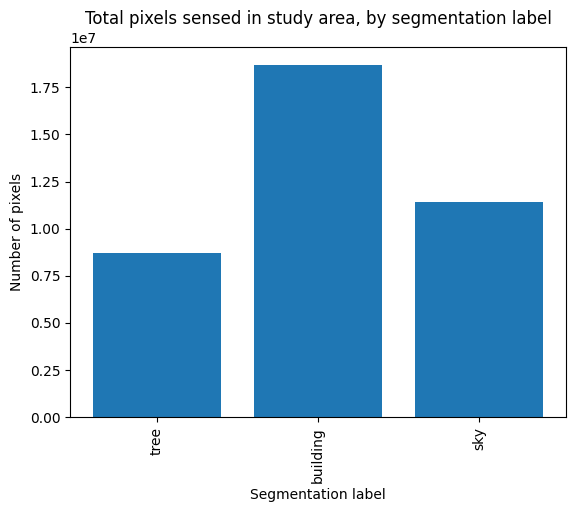

In [ ]:
import matplotlib.pyplot as plt

# plot a graph of pixel totals by segmentation area
total_pixel_counts = [panoidDF[name].sum() for name in YOUR_PRED_NAMES]

plt.bar(range(len(YOUR_LABELS)), total_pixel_counts, align='center')
plt.xticks(range(len(YOUR_LABELS)), list(YOUR_PRED_NAMES), rotation='vertical')
plt.title("Total pixels sensed in study area, by segmentation label")
plt.xlabel("Segmentation label")
plt.ylabel("Number of pixels")

plt.show()

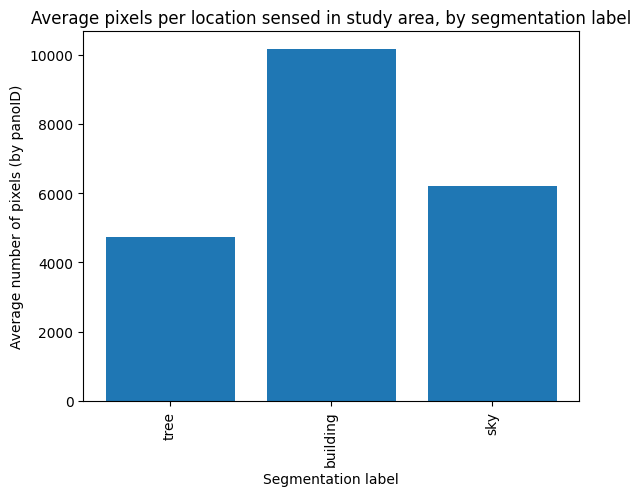

In [ ]:
# plot a graph of avearage pixel counts per label (dividing the total by the number of panoIDs)
average_pixel_counts = [total / panoidDF.shape[0] for total in total_pixel_counts]

plt.bar(range(len(YOUR_LABELS)), average_pixel_counts, align='center')
plt.xticks(range(len(YOUR_LABELS)), list(YOUR_PRED_NAMES), rotation='vertical')
plt.title("Average pixels per location sensed in study area, by segmentation label")
plt.xlabel("Segmentation label")
plt.ylabel("Average number of pixels (by panoID)")

plt.show()

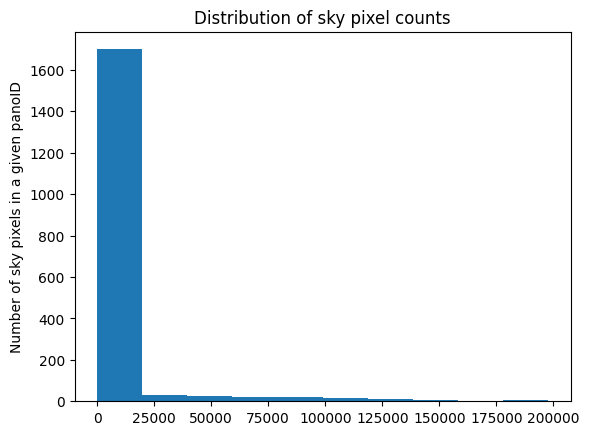

In [ ]:
# distribution of pixel values for one label
VISUALIZE_LABEL = 'sky'

plt.hist(panoidDF[VISUALIZE_LABEL])
plt.title(f"Distribution of {VISUALIZE_LABEL} pixel counts")
plt.ylabel(f"Number of {VISUALIZE_LABEL} pixels in a given panoID")

plt.show()

In [ ]:
import folium
import io

zoom_level = 15
center = [panoidDF['lat'].mean(), panoidDF['lon'].mean()]

# VISUALIZATION THEMES (you can switch these by commenting and un-commenting the below lines)
#theme = 'CartoDB dark_matter'
#theme  = 'openstreetmap'
theme = 'cartodbpositron'

map0 = folium.Map(location=center,tiles=theme,zoom_start=zoom_level)

# FILL IN with which label you want to map
LABEL_TO_PLOT = 'sky'

# color map starts at the lowest edge (red = bin 0). feel free to change it
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "indigo", "purple",  "magenta", "black"]

# assign a color to every point in the panoidDF, based on its value for the label you selected
panoidDF['marker_color'] = pd.cut(panoidDF[LABEL_TO_PLOT], bins=10,
                              labels=colors)

# plot every point in the panoidDF
for index, row in panoidDF.iterrows():
  folium.CircleMarker([row['lat'], row['lon']],radius=.01,fill=True, color=row['marker_color'],opacity=1, fill_color='green',fill_opacity=1).add_to(map0)

map0

<ipython-input-23-4177d40826e1>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  panoidDF['marker_color'] = pd.cut(panoidDF[LABEL_TO_PLOT], bins=10,


ValueError: Location values cannot contain NaNs.

In [ ]:
# save the dataframe with results and color labels (in map above)
# for if you want to visualize it in other software
SAVE_DF_AS = 'panos_segmented_withcolors_DATE.csv'
panoidDF.to_csv(os.path.join(YOUR_IMAGE_FOLDER_PATH, SAVE_DF_AS))